# Recriar Estudo 6

In [1]:
import sys
print(sys.executable)

/home/magda/tf-gpu-env/bin/python3.10


**Ver se está a usar a GPU**

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2025-06-25 10:42:03.572822: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-06-25 10:42:04.244163: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8777160537817358933
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2351693824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14639655253683600745
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2025-06-25 10:42:05.086823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 10:42:05.122375: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 10:42:05.122430: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 10:42:05.295844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 10:42:05.295917: I tensorflow/compile

**imports**

In [3]:
import os
# Ativa o alocador assíncrono (melhora fragmentação de memória)
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf
# Ativa a alocação dinâmica de memória (não ocupa toda a memória no início)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Erro ao definir memory growth:", e)
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, 
                                     GlobalMaxPooling2D, Dense, Dropout, BatchNormalization, AveragePooling2D,
                                     Concatenate, Flatten, LayerNormalization, Multiply, Add, Activation, Reshape)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_auc_score

print("TensorFlow:", tf.__version__)
print("TensorFlow Addons:", tfa.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", matplotlib.__version__)

2025-06-25 10:42:05.307245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 10:42:05.307358: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 10:42:05.307392: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
/home/magda/tf-gpu-env/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.


TensorFlow: 2.13.0
TensorFlow Addons: 0.21.0
NumPy: 1.23.5
Pandas: 1.5.3
Matplotlib: 3.7.1


## Arquitetura do Modelo:

In [4]:
def channel_attention(input_feature, reduction_ratio=8):
    channel = input_feature.shape[-1]

    shared_dense_one = Dense(channel // reduction_ratio, activation='relu', kernel_initializer='glorot_uniform')
    shared_dense_two = Dense(channel, activation='relu', kernel_initializer='glorot_uniform')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    max_pool = GlobalMaxPooling2D()(input_feature)

    avg_out = shared_dense_two(shared_dense_one(avg_pool))
    max_out = shared_dense_two(shared_dense_one(max_pool))

    cbam_feature = Add()([avg_out, max_out])
    cbam_feature = Activation('relu')(cbam_feature)
    cbam_feature = Reshape((1, 1, channel))(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

# Atenção espacial com layer norm, conv 7x7 e gating
def spatial_attention(input_feature):
    avg_pool = tf.reduce_mean(input_feature, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(input_feature, axis=-1, keepdims=True)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    concat = LayerNormalization()(concat)

    conv = Conv2D(1, kernel_size=7, padding='same', activation='relu')(concat)
    gate = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')(concat)
    gated = Multiply()([conv, gate])

    return Multiply()([input_feature, gated])

# Bloco AHC: convoluções paralelas com pooling
def AHC_block(input_tensor):
    conv_3x3 = Conv2D(32, kernel_size=3, padding='same', activation='relu')(input_tensor)
    conv_5x5 = Conv2D(32, kernel_size=5, padding='same', activation='relu')(input_tensor)
    conv_7x7 = Conv2D(32, kernel_size=7, padding='same', activation='relu')(input_tensor)

    pool_3x3 = AveragePooling2D(pool_size=2, strides=1, padding='same')(conv_3x3)
    pool_5x5 = AveragePooling2D(pool_size=2, strides=1, padding='same')(conv_5x5)
    pool_7x7 = AveragePooling2D(pool_size=2, strides=1, padding='same')(conv_7x7)

    return Concatenate()([pool_3x3, pool_5x5, pool_7x7])

# Modelo completo AHMHCNN-mCBAM
def build_AHMHCNN_mCBAM(input_shape=(256, 256, 3), num_classes=2):
    inputs = Input(shape=input_shape)

    # MHCNN base convolucional
    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(48, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(64, kernel_size=5, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.02)(x)
    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.02)(x)

    # Bloco AHC
    x = AHC_block(x)

    # Bloco mCBAM
    x = channel_attention(x)
    x = spatial_attention(x)

    # Classificação
    x = Flatten()(x)
    x = Dense(56, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(48, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Criar o modelo
model = build_AHMHCNN_mCBAM()

2025-06-25 10:42:05.832989: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 10:42:05.833129: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 10:42:05.833163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 10:42:05.833546: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-25 10:42:05.833561: I tensorflow/core/co

In [5]:
# Compilar o modelo
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=2, average='macro')
    ]
)

In [6]:
# Mostrar resumo
model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                Output Shape                 Param #   Connected to                  


 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            


 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             


 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d[0][0]']              


 D)                                                                                               


 conv2d_1 (Conv2D)           (None, 128, 128, 48)         13872     ['max_pooling2d[0][0]']       


 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 48)           0         ['conv2d_1[0][0]']            


 g2D)                                                                                             


 conv2d_2 (Conv2D)           (None, 64, 64, 64)           76864     ['max_pooling2d_1[0][0]']     


 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 64)           0         ['conv2d_2[0][0]']            


 g2D)                                                                                             


 dropout (Dropout)           (None, 32, 32, 64)           0         ['max_pooling2d_2[0][0]']     


 conv2d_3 (Conv2D)           (None, 32, 32, 32)           18464     ['dropout[0][0]']             


 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)           0         ['conv2d_3[0][0]']            


 g2D)                                                                                             


 batch_normalization (Batch  (None, 16, 16, 32)           128       ['max_pooling2d_3[0][0]']     


 Normalization)                                                                                   


 dropout_1 (Dropout)         (None, 16, 16, 32)           0         ['batch_normalization[0][0]'] 


 conv2d_4 (Conv2D)           (None, 16, 16, 32)           9248      ['dropout_1[0][0]']           


 conv2d_5 (Conv2D)           (None, 16, 16, 32)           25632     ['dropout_1[0][0]']           


 conv2d_6 (Conv2D)           (None, 16, 16, 32)           50208     ['dropout_1[0][0]']           


 average_pooling2d (Average  (None, 16, 16, 32)           0         ['conv2d_4[0][0]']            


 Pooling2D)                                                                                       


 average_pooling2d_1 (Avera  (None, 16, 16, 32)           0         ['conv2d_5[0][0]']            


 gePooling2D)                                                                                     


 average_pooling2d_2 (Avera  (None, 16, 16, 32)           0         ['conv2d_6[0][0]']            


 gePooling2D)                                                                                     


 concatenate (Concatenate)   (None, 16, 16, 96)           0         ['average_pooling2d[0][0]',   


                                                                     'average_pooling2d_1[0][0]', 


                                                                     'average_pooling2d_2[0][0]'] 


 global_average_pooling2d (  (None, 96)                   0         ['concatenate[0][0]']         


 GlobalAveragePooling2D)                                                                          


 global_max_pooling2d (Glob  (None, 96)                   0         ['concatenate[0][0]']         


 alMaxPooling2D)                                                                                  


 dense (Dense)               (None, 12)                   1164      ['global_average_pooling2d[0][


                                                                    0]',                          


                                                                     'global_max_pooling2d[0][0]']


 dense_1 (Dense)             (None, 96)                   1248      ['dense[0][0]',               


                                                                     'dense[1][0]']               


 add (Add)                   (None, 96)                   0         ['dense_1[0][0]',             


                                                                     'dense_1[1][0]']             


 activation (Activation)     (None, 96)                   0         ['add[0][0]']                 


 reshape (Reshape)           (None, 1, 1, 96)             0         ['activation[0][0]']          


 multiply (Multiply)         (None, 16, 16, 96)           0         ['concatenate[0][0]',         


                                                                     'reshape[0][0]']             


 tf.math.reduce_mean (TFOpL  (None, 16, 16, 1)            0         ['multiply[0][0]']            


 ambda)                                                                                           


 tf.math.reduce_max (TFOpLa  (None, 16, 16, 1)            0         ['multiply[0][0]']            


 mbda)                                                                                            


 concatenate_1 (Concatenate  (None, 16, 16, 2)            0         ['tf.math.reduce_mean[0][0]', 


 )                                                                   'tf.math.reduce_max[0][0]']  


 layer_normalization (Layer  (None, 16, 16, 2)            4         ['concatenate_1[0][0]']       


 Normalization)                                                                                   


 conv2d_7 (Conv2D)           (None, 16, 16, 1)            99        ['layer_normalization[0][0]'] 


 conv2d_8 (Conv2D)           (None, 16, 16, 1)            3         ['layer_normalization[0][0]'] 


 multiply_1 (Multiply)       (None, 16, 16, 1)            0         ['conv2d_7[0][0]',            


                                                                     'conv2d_8[0][0]']            


 multiply_2 (Multiply)       (None, 16, 16, 96)           0         ['multiply[0][0]',            


                                                                     'multiply_1[0][0]']          


 flatten (Flatten)           (None, 24576)                0         ['multiply_2[0][0]']          


 dense_2 (Dense)             (None, 56)                   1376312   ['flatten[0][0]']             


 batch_normalization_1 (Bat  (None, 56)                   224       ['dense_2[0][0]']             


 chNormalization)                                                                                 


 dense_3 (Dense)             (None, 48)                   2736      ['batch_normalization_1[0][0]'


                                                                    ]                             


 batch_normalization_2 (Bat  (None, 48)                   192       ['dense_3[0][0]']             


 chNormalization)                                                                                 


 dense_4 (Dense)             (None, 32)                   1568      ['batch_normalization_2[0][0]'


                                                                    ]                             


 batch_normalization_3 (Bat  (None, 32)                   128       ['dense_4[0][0]']             


 chNormalization)                                                                                 


 dense_5 (Dense)             (None, 2)                    66        ['batch_normalization_3[0][0]'


                                                                    ]                             


Total params: 1579056 (6.02 MB)


Trainable params: 1578720 (6.02 MB)


Non-trainable params: 336 (1.31 KB)


__________________________________________________________________________________________________


## Funções Auxiliares

Trata do pré-processamento das imagens, ou seja redimensiona para 224 X 224 pixels e normaliza [0,1] e coloca em one hot.

In [7]:
# Função auxiliar para carregar imagem
def preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    label = tf.one_hot(label, 2)
    return image, label

Permite analisar a distribuição dos datasets.

In [8]:
def inspect_dataset_distribution(dataset, name="dataset"):
    total_samples = 0
    label_counter = Counter()

    for images, labels in dataset:
        # labels vêm em one-hot: [0,1] ou [1,0]
        labels_np = labels.numpy()
        class_indices = labels_np.argmax(axis=1)  # <-- Corrigir: pegar o índice da classe correta
        total_samples += len(class_indices)
        label_counter.update(class_indices)

    print(f"📊 {name.upper()} -> Total de imagens: {total_samples}")
    for label, count in sorted(label_counter.items()):
        perc = (count / total_samples) * 100
        print(f"  Classe {int(label)} ({'Fogo' if label == 1 else 'Sem fogo'}): {count} imagens ({perc:.2f}%)")
    print("-" * 40)

Permite analisar o histórico de trino.

In [9]:
def plot_training_history(history):
    metrics = history.history.keys()
    epochs_range = range(len(history.history['loss']))

    for metric in metrics:
        if "val_" not in metric:
            plt.figure(figsize=(10, 5))
            plt.plot(epochs_range, history.history[metric], label=f"Train {metric}")
            if f"val_{metric}" in metrics:
                plt.plot(epochs_range, history.history[f"val_{metric}"], label=f"Val {metric}")
            plt.title(f"Training and Validation {metric.capitalize()}")
            plt.xlabel("Epochs")
            plt.ylabel(metric.capitalize())
            plt.legend()
            plt.grid(True)
            plt.show()

Usada para avaliar o modelo, ou seja, se está a prever corretamente a classificação das imagens.

In [10]:
def avaliar_modelo(model, dataset):
    # 1. Previsões e rótulos reais
    y_pred_probs = model.predict(dataset, verbose=0)
    y_true = np.concatenate([y for _, y in dataset], axis=0)
    y_true_int = np.argmax(y_true, axis=1)
    y_pred_int = (y_pred_probs[:, 1] > 0.5).astype(int)

    # 2. Contagem das classes
    TP = np.sum((y_true_int == 1) & (y_pred_int == 1))
    TN = np.sum((y_true_int == 0) & (y_pred_int == 0))
    FP = np.sum((y_true_int == 0) & (y_pred_int == 1))
    FN = np.sum((y_true_int == 1) & (y_pred_int == 0))

    total = TP + TN + FP + FN

    # 3. Cálculo das métricas com base nas fórmulas
    accuracy   = (TP + TN) / total if total > 0 else 0.0
    precision  = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall     = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_score   = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    auc        = roc_auc_score(y_true_int, y_pred_probs[:, 1])

    # Binary crossentropy loss
    eps = 1e-7
    p = np.clip(y_pred_probs[:, 1], eps, 1 - eps)
    y = y_true_int
    loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

    # Métricas específicas de detecção de incêndio
    fdr = recall * 100  # ou (TP / (TP + FN)) * 100
    ewr = ((FP + FN) / total) * 100 if total > 0 else 0.0

    # 4. Impressão
    print("=== MÉTRICAS DE AVALIAÇÃO ===")
    print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")
    print(f"Accuracy       : {accuracy:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"F1-Score       : {f1_score:.4f}")
    print(f"AUC            : {auc:.4f}")
    print(f"Binary Loss    : {loss:.4f}")
    print(f"FDR (Fire Detection Rate)      : {fdr:.2f} %")
    print(f"EWR (Error Warning Rate)       : {ewr:.2f} %")
    print("Confusion Matrix:")
    print(np.array([[TN, FP], [FN, TP]]))  # [[negativos reais], [positivos reais]]

    # 5. Retorno opcional
    return {
        'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'auc': auc,
        'loss': loss,
        'fdr': fdr,
        'ewr': ewr,
        'confusion_matrix': np.array([[TN, FP], [FN, TP]])
    }

## Treino

In [11]:
# Configurações gerais
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16
EPOCHS = 50
SEED = 42

In [12]:
data = pd.read_csv("../Datasets/UAVS_RawImages.csv")
data = data[['image_path', 'label_bi']]
data['label_bi'] = data['label_bi'].astype(str)

data_test = pd.read_csv("../Datasets/UAVS_AugmentedImages.csv")
image_paths_test = data_test['image_path'].values
labels_test = data_test['label_bi'].values

In [13]:
train_df, val_df = train_test_split(data, test_size=0.1, random_state=SEED, stratify=data['label_bi'])

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Criar datasets TensorFlow
# Generator com aumentações para treino
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=160,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='reflect',
    cval=125
)

# Apenas normalização para validação
val_datagen = ImageDataGenerator(rescale=1./255)

test_ds = tf.data.Dataset.from_tensor_slices((image_paths_test, labels_test))
test_ds = test_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
# Função do agendamento de learning rate conforme o estudo
def custom_lr_schedule(epoch, lr):
    if epoch < 15:
        return 1e-4
    elif epoch < 25:
        return 1e-5
    else:
        return 1e-6

# Callbacks combinados
callback = [
    ModelCheckpoint('Recriar_Estudo_6_Aug_best.h5', monitor='val_loss', save_best_only=True, verbose=1),
    LearningRateScheduler(custom_lr_schedule, verbose=1)
]

In [16]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label_bi',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',   # automaticamente faz one-hot
    color_mode='rgb',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label_bi',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 1478 validated image filenames belonging to 2 classes.


Found 165 validated image filenames belonging to 2 classes.


In [17]:
# Treinar
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callback
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.


Epoch 1/50


2025-06-25 10:42:09.158948: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2025-06-25 10:42:09.799179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


2025-06-25 10:42:11.053234: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5cbd7853fe90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-25 10:42:11.053278: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-06-25 10:42:11.099979: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


2025-06-25 10:42:11.356521: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 1/93 [..............................] - ETA: 14:36 - loss: 1.1012 - accuracy: 0.5625 - precision: 0.5625 - recall: 0.5625 - auc: 0.5430 - f1_score: 0.5152

 2/93 [..............................] - ETA: 1:57 - loss: 1.0245 - accuracy: 0.5455 - precision: 0.5455 - recall: 0.5455 - auc: 0.5455 - f1_score: 0.5299 

 3/93 [..............................] - ETA: 1:01 - loss: 0.9149 - accuracy: 0.5789 - precision: 0.5789 - recall: 0.5789 - auc: 0.5734 - f1_score: 0.5742

 4/93 [>.............................] - ETA: 43s - loss: 0.9393 - accuracy: 0.5556 - precision: 0.5556 - recall: 0.5556 - auc: 0.5538 - f1_score: 0.5500 

 5/93 [>.............................] - ETA: 35s - loss: 0.8364 - accuracy: 0.6000 - precision: 0.6000 - recall: 0.6000 - auc: 0.6120 - f1_score: 0.5947

 6/93 [>.............................] - ETA: 32s - loss: 0.8241 - accuracy: 0.6047 - precision: 0.6047 - recall: 0.6047 - auc: 0.6161 - f1_score: 0.5992

 7/93 [=>............................] - ETA: 29s - loss: 0.7759 - accuracy: 0.6373 - precision: 0.6373 - recall: 0.6373 - auc: 0.6409 - f1_score: 0.6269

 8/93 [=>............................] - ETA: 28s - loss: 0.7462 - accuracy: 0.6356 - precision: 0.6356 - recall: 0.6356 - auc: 0.6526 - f1_score: 0.6279

 9/93 [=>............................] - ETA: 26s - loss: 0.7486 - accuracy: 0.6269 - precision: 0.6269 - recall: 0.6269 - auc: 0.6452 - f1_score: 0.6215

10/93 [==>...........................] - ETA: 25s - loss: 0.7676 - accuracy: 0.6267 - precision: 0.6267 - recall: 0.6267 - auc: 0.6456 - f1_score: 0.6185

11/93 [==>...........................] - ETA: 24s - loss: 0.7422 - accuracy: 0.6325 - precision: 0.6325 - recall: 0.6325 - auc: 0.6663 - f1_score: 0.6240

12/93 [==>...........................] - ETA: 23s - loss: 0.7165 - accuracy: 0.6429 - precision: 0.6429 - recall: 0.6429 - auc: 0.6866 - f1_score: 0.6360

13/93 [===>..........................] - ETA: 22s - loss: 0.7167 - accuracy: 0.6515 - precision: 0.6515 - recall: 0.6515 - auc: 0.6873 - f1_score: 0.6428

14/93 [===>..........................] - ETA: 22s - loss: 0.7183 - accuracy: 0.6495 - precision: 0.6495 - recall: 0.6495 - auc: 0.6827 - f1_score: 0.6399

15/93 [===>..........................] - ETA: 21s - loss: 0.7401 - accuracy: 0.6435 - precision: 0.6435 - recall: 0.6435 - auc: 0.6729 - f1_score: 0.6345

16/93 [====>.........................] - ETA: 20s - loss: 0.7382 - accuracy: 0.6301 - precision: 0.6301 - recall: 0.6301 - auc: 0.6702 - f1_score: 0.6215

17/93 [====>.........................] - ETA: 20s - loss: 0.7103 - accuracy: 0.6450 - precision: 0.6450 - recall: 0.6450 - auc: 0.6911 - f1_score: 0.6370

18/93 [====>.........................] - ETA: 20s - loss: 0.7186 - accuracy: 0.6439 - precision: 0.6439 - recall: 0.6439 - auc: 0.6889 - f1_score: 0.6375

19/93 [=====>........................] - ETA: 19s - loss: 0.7166 - accuracy: 0.6429 - precision: 0.6429 - recall: 0.6429 - auc: 0.6892 - f1_score: 0.6365

20/93 [=====>........................] - ETA: 19s - loss: 0.7267 - accuracy: 0.6419 - precision: 0.6419 - recall: 0.6419 - auc: 0.6865 - f1_score: 0.6349

21/93 [=====>........................] - ETA: 18s - loss: 0.7197 - accuracy: 0.6472 - precision: 0.6472 - recall: 0.6472 - auc: 0.6903 - f1_score: 0.6384

22/93 [======>.......................] - ETA: 18s - loss: 0.7087 - accuracy: 0.6550 - precision: 0.6550 - recall: 0.6550 - auc: 0.6990 - f1_score: 0.6468

23/93 [======>.......................] - ETA: 18s - loss: 0.6957 - accuracy: 0.6620 - precision: 0.6620 - recall: 0.6620 - auc: 0.7078 - f1_score: 0.6532

24/93 [======>.......................] - ETA: 17s - loss: 0.6811 - accuracy: 0.6658 - precision: 0.6658 - recall: 0.6658 - auc: 0.7184 - f1_score: 0.6572

25/93 [=======>......................] - ETA: 17s - loss: 0.6808 - accuracy: 0.6641 - precision: 0.6641 - recall: 0.6641 - auc: 0.7193 - f1_score: 0.6557

26/93 [=======>......................] - ETA: 16s - loss: 0.6685 - accuracy: 0.6700 - precision: 0.6700 - recall: 0.6700 - auc: 0.7274 - f1_score: 0.6615

27/93 [=======>......................] - ETA: 16s - loss: 0.6644 - accuracy: 0.6682 - precision: 0.6682 - recall: 0.6682 - auc: 0.7292 - f1_score: 0.6599

28/93 [========>.....................] - ETA: 16s - loss: 0.6525 - accuracy: 0.6758 - precision: 0.6758 - recall: 0.6758 - auc: 0.7382 - f1_score: 0.6687

29/93 [========>.....................] - ETA: 16s - loss: 0.6488 - accuracy: 0.6784 - precision: 0.6784 - recall: 0.6784 - auc: 0.7422 - f1_score: 0.6715

30/93 [========>.....................] - ETA: 15s - loss: 0.6459 - accuracy: 0.6809 - precision: 0.6809 - recall: 0.6809 - auc: 0.7452 - f1_score: 0.6748

31/93 [=========>....................] - ETA: 15s - loss: 0.6423 - accuracy: 0.6852 - precision: 0.6852 - recall: 0.6852 - auc: 0.7488 - f1_score: 0.6783

32/93 [=========>....................] - ETA: 15s - loss: 0.6447 - accuracy: 0.6873 - precision: 0.6873 - recall: 0.6873 - auc: 0.7469 - f1_score: 0.6793

33/93 [=========>....................] - ETA: 14s - loss: 0.6502 - accuracy: 0.6873 - precision: 0.6873 - recall: 0.6873 - auc: 0.7442 - f1_score: 0.6784

34/93 [=========>....................] - ETA: 14s - loss: 0.6388 - accuracy: 0.6966 - precision: 0.6966 - recall: 0.6966 - auc: 0.7519 - f1_score: 0.6878

35/93 [==========>...................] - ETA: 14s - loss: 0.6373 - accuracy: 0.6982 - precision: 0.6982 - recall: 0.6982 - auc: 0.7533 - f1_score: 0.6887

36/93 [==========>...................] - ETA: 13s - loss: 0.6350 - accuracy: 0.6979 - precision: 0.6979 - recall: 0.6979 - auc: 0.7542 - f1_score: 0.6879

37/93 [==========>...................] - ETA: 13s - loss: 0.6291 - accuracy: 0.7027 - precision: 0.7027 - recall: 0.7027 - auc: 0.7581 - f1_score: 0.6935

38/93 [===========>..................] - ETA: 13s - loss: 0.6199 - accuracy: 0.7074 - precision: 0.7074 - recall: 0.7074 - auc: 0.7649 - f1_score: 0.6980

39/93 [===========>..................] - ETA: 13s - loss: 0.6210 - accuracy: 0.7085 - precision: 0.7085 - recall: 0.7085 - auc: 0.7656 - f1_score: 0.6986

40/93 [===========>..................] - ETA: 12s - loss: 0.6126 - accuracy: 0.7111 - precision: 0.7111 - recall: 0.7111 - auc: 0.7713 - f1_score: 0.7017

41/93 [============>.................] - ETA: 12s - loss: 0.6029 - accuracy: 0.7167 - precision: 0.7167 - recall: 0.7167 - auc: 0.7780 - f1_score: 0.7074

42/93 [============>.................] - ETA: 12s - loss: 0.5971 - accuracy: 0.7175 - precision: 0.7175 - recall: 0.7175 - auc: 0.7815 - f1_score: 0.7081

43/93 [============>.................] - ETA: 12s - loss: 0.5896 - accuracy: 0.7212 - precision: 0.7212 - recall: 0.7212 - auc: 0.7864 - f1_score: 0.7118

44/93 [=============>................] - ETA: 11s - loss: 0.5854 - accuracy: 0.7219 - precision: 0.7219 - recall: 0.7219 - auc: 0.7888 - f1_score: 0.7126

45/93 [=============>................] - ETA: 11s - loss: 0.5783 - accuracy: 0.7268 - precision: 0.7268 - recall: 0.7268 - auc: 0.7936 - f1_score: 0.7173

46/93 [=============>................] - ETA: 11s - loss: 0.5748 - accuracy: 0.7273 - precision: 0.7273 - recall: 0.7273 - auc: 0.7954 - f1_score: 0.7177

47/93 [==============>...............] - ETA: 11s - loss: 0.5749 - accuracy: 0.7291 - precision: 0.7291 - recall: 0.7291 - auc: 0.7964 - f1_score: 0.7195

48/93 [==============>...............] - ETA: 10s - loss: 0.5686 - accuracy: 0.7335 - precision: 0.7335 - recall: 0.7335 - auc: 0.8006 - f1_score: 0.7241

49/93 [==============>...............] - ETA: 10s - loss: 0.5696 - accuracy: 0.7313 - precision: 0.7313 - recall: 0.7313 - auc: 0.8000 - f1_score: 0.7214

50/93 [===============>..............] - ETA: 10s - loss: 0.5616 - accuracy: 0.7354 - precision: 0.7354 - recall: 0.7354 - auc: 0.8054 - f1_score: 0.7260

51/93 [===============>..............] - ETA: 10s - loss: 0.5564 - accuracy: 0.7382 - precision: 0.7382 - recall: 0.7382 - auc: 0.8087 - f1_score: 0.7290

52/93 [===============>..............] - ETA: 9s - loss: 0.5570 - accuracy: 0.7372 - precision: 0.7372 - recall: 0.7372 - auc: 0.8081 - f1_score: 0.7274 

53/93 [================>.............] - ETA: 9s - loss: 0.5565 - accuracy: 0.7399 - precision: 0.7399 - recall: 0.7399 - auc: 0.8087 - f1_score: 0.7295

54/93 [================>.............] - ETA: 9s - loss: 0.5606 - accuracy: 0.7377 - precision: 0.7377 - recall: 0.7377 - auc: 0.8057 - f1_score: 0.7266

55/93 [================>.............] - ETA: 9s - loss: 0.5543 - accuracy: 0.7414 - precision: 0.7414 - recall: 0.7414 - auc: 0.8099 - f1_score: 0.7307

56/93 [=================>............] - ETA: 8s - loss: 0.5482 - accuracy: 0.7460 - precision: 0.7460 - recall: 0.7460 - auc: 0.8138 - f1_score: 0.7352

57/93 [=================>............] - ETA: 8s - loss: 0.5417 - accuracy: 0.7494 - precision: 0.7494 - recall: 0.7494 - auc: 0.8180 - f1_score: 0.7386

58/93 [=================>............] - ETA: 8s - loss: 0.5392 - accuracy: 0.7505 - precision: 0.7505 - recall: 0.7505 - auc: 0.8194 - f1_score: 0.7393

59/93 [==================>...........] - ETA: 8s - loss: 0.5341 - accuracy: 0.7548 - precision: 0.7548 - recall: 0.7548 - auc: 0.8226 - f1_score: 0.7432

60/93 [==================>...........] - ETA: 7s - loss: 0.5300 - accuracy: 0.7558 - precision: 0.7558 - recall: 0.7558 - auc: 0.8251 - f1_score: 0.7442

61/93 [==================>...........] - ETA: 7s - loss: 0.5264 - accuracy: 0.7578 - precision: 0.7578 - recall: 0.7578 - auc: 0.8273 - f1_score: 0.7460

62/93 [===================>..........] - ETA: 7s - loss: 0.5243 - accuracy: 0.7587 - precision: 0.7587 - recall: 0.7587 - auc: 0.8284 - f1_score: 0.7465

63/93 [===================>..........] - ETA: 7s - loss: 0.5289 - accuracy: 0.7585 - precision: 0.7585 - recall: 0.7585 - auc: 0.8263 - f1_score: 0.7461

64/93 [===================>..........] - ETA: 6s - loss: 0.5278 - accuracy: 0.7594 - precision: 0.7594 - recall: 0.7594 - auc: 0.8269 - f1_score: 0.7468

65/93 [===================>..........] - ETA: 6s - loss: 0.5242 - accuracy: 0.7612 - precision: 0.7612 - recall: 0.7612 - auc: 0.8291 - f1_score: 0.7486

66/93 [====================>.........] - ETA: 6s - loss: 0.5206 - accuracy: 0.7629 - precision: 0.7629 - recall: 0.7629 - auc: 0.8313 - f1_score: 0.7502

67/93 [====================>.........] - ETA: 6s - loss: 0.5179 - accuracy: 0.7646 - precision: 0.7646 - recall: 0.7646 - auc: 0.8329 - f1_score: 0.7515

68/93 [====================>.........] - ETA: 5s - loss: 0.5123 - accuracy: 0.7672 - precision: 0.7672 - recall: 0.7672 - auc: 0.8365 - f1_score: 0.7543

69/93 [=====================>........] - ETA: 5s - loss: 0.5093 - accuracy: 0.7697 - precision: 0.7697 - recall: 0.7697 - auc: 0.8383 - f1_score: 0.7563

70/93 [=====================>........] - ETA: 5s - loss: 0.5081 - accuracy: 0.7712 - precision: 0.7712 - recall: 0.7712 - auc: 0.8391 - f1_score: 0.7577

71/93 [=====================>........] - ETA: 5s - loss: 0.5022 - accuracy: 0.7744 - precision: 0.7744 - recall: 0.7744 - auc: 0.8429 - f1_score: 0.7613

72/93 [======================>.......] - ETA: 4s - loss: 0.5005 - accuracy: 0.7767 - precision: 0.7767 - recall: 0.7767 - auc: 0.8442 - f1_score: 0.7638

73/93 [======================>.......] - ETA: 4s - loss: 0.4964 - accuracy: 0.7789 - precision: 0.7789 - recall: 0.7789 - auc: 0.8468 - f1_score: 0.7666

74/93 [======================>.......] - ETA: 4s - loss: 0.4914 - accuracy: 0.7819 - precision: 0.7819 - recall: 0.7819 - auc: 0.8499 - f1_score: 0.7701

75/93 [=======================>......] - ETA: 4s - loss: 0.4867 - accuracy: 0.7849 - precision: 0.7849 - recall: 0.7849 - auc: 0.8528 - f1_score: 0.7732

76/93 [=======================>......] - ETA: 4s - loss: 0.4848 - accuracy: 0.7861 - precision: 0.7861 - recall: 0.7861 - auc: 0.8538 - f1_score: 0.7741

77/93 [=======================>......] - ETA: 3s - loss: 0.4843 - accuracy: 0.7856 - precision: 0.7856 - recall: 0.7856 - auc: 0.8540 - f1_score: 0.7734

78/93 [========================>.....] - ETA: 3s - loss: 0.4834 - accuracy: 0.7851 - precision: 0.7851 - recall: 0.7851 - auc: 0.8545 - f1_score: 0.7725

79/93 [========================>.....] - ETA: 3s - loss: 0.4807 - accuracy: 0.7863 - precision: 0.7863 - recall: 0.7863 - auc: 0.8561 - f1_score: 0.7737

80/93 [========================>.....] - ETA: 3s - loss: 0.4776 - accuracy: 0.7882 - precision: 0.7882 - recall: 0.7882 - auc: 0.8579 - f1_score: 0.7754

81/93 [=========================>....] - ETA: 2s - loss: 0.4748 - accuracy: 0.7900 - precision: 0.7900 - recall: 0.7900 - auc: 0.8596 - f1_score: 0.7771

82/93 [=========================>....] - ETA: 2s - loss: 0.4762 - accuracy: 0.7896 - precision: 0.7896 - recall: 0.7896 - auc: 0.8588 - f1_score: 0.7764

83/93 [=========================>....] - ETA: 2s - loss: 0.4741 - accuracy: 0.7906 - precision: 0.7906 - recall: 0.7906 - auc: 0.8600 - f1_score: 0.7771

84/93 [==========================>...] - ETA: 2s - loss: 0.4768 - accuracy: 0.7886 - precision: 0.7886 - recall: 0.7886 - auc: 0.8584 - f1_score: 0.7746

85/93 [==========================>...] - ETA: 1s - loss: 0.4729 - accuracy: 0.7911 - precision: 0.7911 - recall: 0.7911 - auc: 0.8607 - f1_score: 0.7775

86/93 [==========================>...] - ETA: 1s - loss: 0.4714 - accuracy: 0.7914 - precision: 0.7914 - recall: 0.7914 - auc: 0.8615 - f1_score: 0.7777

87/93 [===========================>..] - ETA: 1s - loss: 0.4703 - accuracy: 0.7931 - precision: 0.7931 - recall: 0.7931 - auc: 0.8623 - f1_score: 0.7801

88/93 [===========================>..] - ETA: 1s - loss: 0.4716 - accuracy: 0.7933 - precision: 0.7933 - recall: 0.7933 - auc: 0.8619 - f1_score: 0.7800

89/93 [===========================>..] - ETA: 0s - loss: 0.4710 - accuracy: 0.7928 - precision: 0.7928 - recall: 0.7928 - auc: 0.8621 - f1_score: 0.7793

90/93 [============================>.] - ETA: 0s - loss: 0.4686 - accuracy: 0.7937 - precision: 0.7937 - recall: 0.7937 - auc: 0.8635 - f1_score: 0.7802

91/93 [============================>.] - ETA: 0s - loss: 0.4653 - accuracy: 0.7960 - precision: 0.7960 - recall: 0.7960 - auc: 0.8654 - f1_score: 0.7829

92/93 [============================>.] - ETA: 0s - loss: 0.4633 - accuracy: 0.7975 - precision: 0.7975 - recall: 0.7975 - auc: 0.8667 - f1_score: 0.7846

93/93 [==============================] - ETA: 0s - loss: 0.4597 - accuracy: 0.7997 - precision: 0.7997 - recall: 0.7997 - auc: 0.8688 - f1_score: 0.7868


Epoch 1: val_loss improved from inf to 0.82211, saving model to Recriar_Estudo_6_Aug_best.h5


93/93 [==============================] - 34s 262ms/step - loss: 0.4597 - accuracy: 0.7997 - precision: 0.7997 - recall: 0.7997 - auc: 0.8688 - f1_score: 0.7868 - val_loss: 0.8221 - val_accuracy: 0.3030 - val_precision: 0.3030 - val_recall: 0.3030 - val_auc: 0.3030 - val_f1_score: 0.2326 - lr: 1.0000e-04



Epoch 2: LearningRateScheduler setting learning rate to 0.0001.


Epoch 2/50


/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 1/93 [..............................] - ETA: 26s - loss: 0.4474 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.9023 - f1_score: 0.7257

 2/93 [..............................] - ETA: 19s - loss: 0.5226 - accuracy: 0.7188 - precision: 0.7188 - recall: 0.7188 - auc: 0.8271 - f1_score: 0.6946

 3/93 [..............................] - ETA: 19s - loss: 0.5487 - accuracy: 0.7708 - precision: 0.7708 - recall: 0.7708 - auc: 0.8342 - f1_score: 0.7380

 4/93 [>.............................] - ETA: 19s - loss: 0.4387 - accuracy: 0.8281 - precision: 0.8281 - recall: 0.8281 - auc: 0.8901 - f1_score: 0.8115

 5/93 [>.............................] - ETA: 19s - loss: 0.4758 - accuracy: 0.7875 - precision: 0.7875 - recall: 0.7875 - auc: 0.8647 - f1_score: 0.7645

 6/93 [>.............................] - ETA: 19s - loss: 0.4590 - accuracy: 0.7917 - precision: 0.7917 - recall: 0.7917 - auc: 0.8717 - f1_score: 0.7723

 7/93 [=>............................] - ETA: 18s - loss: 0.4614 - accuracy: 0.7946 - precision: 0.7946 - recall: 0.7946 - auc: 0.8679 - f1_score: 0.7695

 8/93 [=>............................] - ETA: 18s - loss: 0.4456 - accuracy: 0.7969 - precision: 0.7969 - recall: 0.7969 - auc: 0.8762 - f1_score: 0.7697

 9/93 [=>............................] - ETA: 18s - loss: 0.4053 - accuracy: 0.8194 - precision: 0.8194 - recall: 0.8194 - auc: 0.8982 - f1_score: 0.7969

10/93 [==>...........................] - ETA: 18s - loss: 0.4119 - accuracy: 0.8188 - precision: 0.8188 - recall: 0.8188 - auc: 0.8955 - f1_score: 0.7945

11/93 [==>...........................] - ETA: 17s - loss: 0.3863 - accuracy: 0.8352 - precision: 0.8352 - recall: 0.8352 - auc: 0.9083 - f1_score: 0.8144

12/93 [==>...........................] - ETA: 17s - loss: 0.3638 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9189 - f1_score: 0.8268

13/93 [===>..........................] - ETA: 17s - loss: 0.3459 - accuracy: 0.8510 - precision: 0.8510 - recall: 0.8510 - auc: 0.9272 - f1_score: 0.8348

14/93 [===>..........................] - ETA: 17s - loss: 0.3380 - accuracy: 0.8571 - precision: 0.8571 - recall: 0.8571 - auc: 0.9303 - f1_score: 0.8426

15/93 [===>..........................] - ETA: 17s - loss: 0.3461 - accuracy: 0.8625 - precision: 0.8625 - recall: 0.8625 - auc: 0.9272 - f1_score: 0.8467

16/93 [====>.........................] - ETA: 16s - loss: 0.3377 - accuracy: 0.8633 - precision: 0.8633 - recall: 0.8633 - auc: 0.9311 - f1_score: 0.8481

17/93 [====>.........................] - ETA: 16s - loss: 0.3295 - accuracy: 0.8676 - precision: 0.8676 - recall: 0.8676 - auc: 0.9344 - f1_score: 0.8529

18/93 [====>.........................] - ETA: 16s - loss: 0.3165 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9396 - f1_score: 0.8621

19/93 [=====>........................] - ETA: 16s - loss: 0.3098 - accuracy: 0.8783 - precision: 0.8783 - recall: 0.8783 - auc: 0.9426 - f1_score: 0.8657

20/93 [=====>........................] - ETA: 15s - loss: 0.3043 - accuracy: 0.8781 - precision: 0.8781 - recall: 0.8781 - auc: 0.9450 - f1_score: 0.8652

21/93 [=====>........................] - ETA: 15s - loss: 0.2960 - accuracy: 0.8810 - precision: 0.8810 - recall: 0.8810 - auc: 0.9481 - f1_score: 0.8689

22/93 [======>.......................] - ETA: 15s - loss: 0.2977 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9478 - f1_score: 0.8620

23/93 [======>.......................] - ETA: 15s - loss: 0.2903 - accuracy: 0.8804 - precision: 0.8804 - recall: 0.8804 - auc: 0.9509 - f1_score: 0.8677

24/93 [======>.......................] - ETA: 14s - loss: 0.2837 - accuracy: 0.8854 - precision: 0.8854 - recall: 0.8854 - auc: 0.9535 - f1_score: 0.8730

25/93 [=======>......................] - ETA: 14s - loss: 0.2814 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9541 - f1_score: 0.8762

26/93 [=======>......................] - ETA: 14s - loss: 0.2769 - accuracy: 0.8894 - precision: 0.8894 - recall: 0.8894 - auc: 0.9558 - f1_score: 0.8783

27/93 [=======>......................] - ETA: 14s - loss: 0.2712 - accuracy: 0.8935 - precision: 0.8935 - recall: 0.8935 - auc: 0.9580 - f1_score: 0.8829

28/93 [========>.....................] - ETA: 14s - loss: 0.2704 - accuracy: 0.8951 - precision: 0.8951 - recall: 0.8951 - auc: 0.9586 - f1_score: 0.8843

29/93 [========>.....................] - ETA: 13s - loss: 0.2679 - accuracy: 0.8966 - precision: 0.8966 - recall: 0.8966 - auc: 0.9598 - f1_score: 0.8855

30/93 [========>.....................] - ETA: 13s - loss: 0.2673 - accuracy: 0.8979 - precision: 0.8979 - recall: 0.8979 - auc: 0.9591 - f1_score: 0.8874

31/93 [=========>....................] - ETA: 13s - loss: 0.2634 - accuracy: 0.9012 - precision: 0.9012 - recall: 0.9012 - auc: 0.9606 - f1_score: 0.8908

32/93 [=========>....................] - ETA: 13s - loss: 0.2572 - accuracy: 0.9043 - precision: 0.9043 - recall: 0.9043 - auc: 0.9625 - f1_score: 0.8949

33/93 [=========>....................] - ETA: 12s - loss: 0.2662 - accuracy: 0.8977 - precision: 0.8977 - recall: 0.8977 - auc: 0.9591 - f1_score: 0.8874

34/93 [=========>....................] - ETA: 12s - loss: 0.2689 - accuracy: 0.8971 - precision: 0.8971 - recall: 0.8971 - auc: 0.9578 - f1_score: 0.8865

35/93 [==========>...................] - ETA: 12s - loss: 0.2664 - accuracy: 0.8982 - precision: 0.8982 - recall: 0.8982 - auc: 0.9588 - f1_score: 0.8877

36/93 [==========>...................] - ETA: 12s - loss: 0.2630 - accuracy: 0.8993 - precision: 0.8993 - recall: 0.8993 - auc: 0.9601 - f1_score: 0.8897

37/93 [==========>...................] - ETA: 12s - loss: 0.2615 - accuracy: 0.9020 - precision: 0.9020 - recall: 0.9020 - auc: 0.9609 - f1_score: 0.8920

38/93 [===========>..................] - ETA: 11s - loss: 0.2565 - accuracy: 0.9046 - precision: 0.9046 - recall: 0.9046 - auc: 0.9625 - f1_score: 0.8952

39/93 [===========>..................] - ETA: 11s - loss: 0.2560 - accuracy: 0.9071 - precision: 0.9071 - recall: 0.9071 - auc: 0.9630 - f1_score: 0.8973

40/93 [===========>..................] - ETA: 11s - loss: 0.2556 - accuracy: 0.9078 - precision: 0.9078 - recall: 0.9078 - auc: 0.9634 - f1_score: 0.8979

41/93 [============>.................] - ETA: 11s - loss: 0.2521 - accuracy: 0.9101 - precision: 0.9101 - recall: 0.9101 - auc: 0.9645 - f1_score: 0.9005

42/93 [============>.................] - ETA: 10s - loss: 0.2482 - accuracy: 0.9122 - precision: 0.9122 - recall: 0.9122 - auc: 0.9658 - f1_score: 0.9032

43/93 [============>.................] - ETA: 10s - loss: 0.2452 - accuracy: 0.9142 - precision: 0.9142 - recall: 0.9142 - auc: 0.9668 - f1_score: 0.9053

44/93 [=============>................] - ETA: 10s - loss: 0.2425 - accuracy: 0.9162 - precision: 0.9162 - recall: 0.9162 - auc: 0.9677 - f1_score: 0.9072

45/93 [=============>................] - ETA: 10s - loss: 0.2465 - accuracy: 0.9153 - precision: 0.9153 - recall: 0.9153 - auc: 0.9655 - f1_score: 0.9061

46/93 [=============>................] - ETA: 10s - loss: 0.2478 - accuracy: 0.9144 - precision: 0.9144 - recall: 0.9144 - auc: 0.9655 - f1_score: 0.9049

47/93 [==============>...............] - ETA: 9s - loss: 0.2532 - accuracy: 0.9136 - precision: 0.9136 - recall: 0.9136 - auc: 0.9626 - f1_score: 0.9039 

48/93 [==============>...............] - ETA: 9s - loss: 0.2510 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9635 - f1_score: 0.9044

49/93 [==============>...............] - ETA: 9s - loss: 0.2674 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9568 - f1_score: 0.9001

50/93 [===============>..............] - ETA: 9s - loss: 0.2674 - accuracy: 0.9100 - precision: 0.9100 - recall: 0.9100 - auc: 0.9571 - f1_score: 0.8990

51/93 [===============>..............] - ETA: 9s - loss: 0.2661 - accuracy: 0.9105 - precision: 0.9105 - recall: 0.9105 - auc: 0.9577 - f1_score: 0.8994

52/93 [===============>..............] - ETA: 8s - loss: 0.2685 - accuracy: 0.9099 - precision: 0.9099 - recall: 0.9099 - auc: 0.9566 - f1_score: 0.8984

54/93 [================>.............] - ETA: 8s - loss: 0.2652 - accuracy: 0.9110 - precision: 0.9110 - recall: 0.9110 - auc: 0.9578 - f1_score: 0.9001

55/93 [================>.............] - ETA: 8s - loss: 0.2620 - accuracy: 0.9126 - precision: 0.9126 - recall: 0.9126 - auc: 0.9588 - f1_score: 0.9022

56/93 [=================>............] - ETA: 7s - loss: 0.2607 - accuracy: 0.9142 - precision: 0.9142 - recall: 0.9142 - auc: 0.9594 - f1_score: 0.9038

57/93 [=================>............] - ETA: 7s - loss: 0.2603 - accuracy: 0.9146 - precision: 0.9146 - recall: 0.9146 - auc: 0.9598 - f1_score: 0.9039

58/93 [=================>............] - ETA: 7s - loss: 0.2581 - accuracy: 0.9161 - precision: 0.9161 - recall: 0.9161 - auc: 0.9607 - f1_score: 0.9056

59/93 [==================>...........] - ETA: 7s - loss: 0.2564 - accuracy: 0.9165 - precision: 0.9165 - recall: 0.9165 - auc: 0.9613 - f1_score: 0.9060

60/93 [==================>...........] - ETA: 7s - loss: 0.2577 - accuracy: 0.9158 - precision: 0.9158 - recall: 0.9158 - auc: 0.9612 - f1_score: 0.9049

61/93 [==================>...........] - ETA: 6s - loss: 0.2598 - accuracy: 0.9120 - precision: 0.9120 - recall: 0.9120 - auc: 0.9608 - f1_score: 0.9005

62/93 [===================>..........] - ETA: 6s - loss: 0.2592 - accuracy: 0.9124 - precision: 0.9124 - recall: 0.9124 - auc: 0.9610 - f1_score: 0.9008

63/93 [===================>..........] - ETA: 6s - loss: 0.2562 - accuracy: 0.9138 - precision: 0.9138 - recall: 0.9138 - auc: 0.9620 - f1_score: 0.9025

64/93 [===================>..........] - ETA: 6s - loss: 0.2543 - accuracy: 0.9142 - precision: 0.9142 - recall: 0.9142 - auc: 0.9625 - f1_score: 0.9030

65/93 [===================>..........] - ETA: 5s - loss: 0.2523 - accuracy: 0.9155 - precision: 0.9155 - recall: 0.9155 - auc: 0.9632 - f1_score: 0.9046

66/93 [====================>.........] - ETA: 5s - loss: 0.2501 - accuracy: 0.9168 - precision: 0.9168 - recall: 0.9168 - auc: 0.9640 - f1_score: 0.9061

67/93 [====================>.........] - ETA: 5s - loss: 0.2514 - accuracy: 0.9171 - precision: 0.9171 - recall: 0.9171 - auc: 0.9632 - f1_score: 0.9062

68/93 [====================>.........] - ETA: 5s - loss: 0.2487 - accuracy: 0.9184 - precision: 0.9184 - recall: 0.9184 - auc: 0.9641 - f1_score: 0.9077

69/93 [=====================>........] - ETA: 5s - loss: 0.2464 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9648 - f1_score: 0.9090

70/93 [=====================>........] - ETA: 4s - loss: 0.2447 - accuracy: 0.9207 - precision: 0.9207 - recall: 0.9207 - auc: 0.9653 - f1_score: 0.9102

71/93 [=====================>........] - ETA: 4s - loss: 0.2492 - accuracy: 0.9192 - precision: 0.9192 - recall: 0.9192 - auc: 0.9640 - f1_score: 0.9081

72/93 [======================>.......] - ETA: 4s - loss: 0.2467 - accuracy: 0.9203 - precision: 0.9203 - recall: 0.9203 - auc: 0.9648 - f1_score: 0.9096

73/93 [======================>.......] - ETA: 4s - loss: 0.2445 - accuracy: 0.9214 - precision: 0.9214 - recall: 0.9214 - auc: 0.9654 - f1_score: 0.9108

74/93 [======================>.......] - ETA: 4s - loss: 0.2429 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9660 - f1_score: 0.9120

75/93 [=======================>......] - ETA: 3s - loss: 0.2421 - accuracy: 0.9227 - precision: 0.9227 - recall: 0.9227 - auc: 0.9663 - f1_score: 0.9122

76/93 [=======================>......] - ETA: 3s - loss: 0.2395 - accuracy: 0.9237 - precision: 0.9237 - recall: 0.9237 - auc: 0.9671 - f1_score: 0.9134

77/93 [=======================>......] - ETA: 3s - loss: 0.2401 - accuracy: 0.9231 - precision: 0.9231 - recall: 0.9231 - auc: 0.9670 - f1_score: 0.9127

78/93 [========================>.....] - ETA: 3s - loss: 0.2377 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9677 - f1_score: 0.9141

79/93 [========================>.....] - ETA: 2s - loss: 0.2358 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9682 - f1_score: 0.9156

80/93 [========================>.....] - ETA: 2s - loss: 0.2340 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9688 - f1_score: 0.9166

81/93 [=========================>....] - ETA: 2s - loss: 0.2322 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9693 - f1_score: 0.9176

82/93 [=========================>....] - ETA: 2s - loss: 0.2322 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9694 - f1_score: 0.9176

83/93 [=========================>....] - ETA: 2s - loss: 0.2305 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9699 - f1_score: 0.9186

84/93 [==========================>...] - ETA: 1s - loss: 0.2288 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9704 - f1_score: 0.9197

85/93 [==========================>...] - ETA: 1s - loss: 0.2272 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9708 - f1_score: 0.9205

86/93 [==========================>...] - ETA: 1s - loss: 0.2254 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9713 - f1_score: 0.9216

87/93 [===========================>..] - ETA: 1s - loss: 0.2251 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9715 - f1_score: 0.9209

88/93 [===========================>..] - ETA: 1s - loss: 0.2240 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9718 - f1_score: 0.9217

89/93 [===========================>..] - ETA: 0s - loss: 0.2229 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9722 - f1_score: 0.9225

90/93 [============================>.] - ETA: 0s - loss: 0.2228 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9724 - f1_score: 0.9233

91/93 [============================>.] - ETA: 0s - loss: 0.2227 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9726 - f1_score: 0.9232

92/93 [============================>.] - ETA: 0s - loss: 0.2255 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9716 - f1_score: 0.9224

93/93 [==============================] - ETA: 0s - loss: 0.2249 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9716 - f1_score: 0.9226


Epoch 2: val_loss improved from 0.82211 to 0.80024, saving model to Recriar_Estudo_6_Aug_best.h5


93/93 [==============================] - 21s 225ms/step - loss: 0.2249 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9716 - f1_score: 0.9226 - val_loss: 0.8002 - val_accuracy: 0.3030 - val_precision: 0.3030 - val_recall: 0.3030 - val_auc: 0.3030 - val_f1_score: 0.2326 - lr: 1.0000e-04



Epoch 3: LearningRateScheduler setting learning rate to 0.0001.


Epoch 3/50


 1/93 [..............................] - ETA: 28s - loss: 0.3846 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.8945 - f1_score: 0.9227

 2/93 [..............................] - ETA: 19s - loss: 0.2687 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9434 - f1_score: 0.9352

 3/93 [..............................] - ETA: 19s - loss: 0.2202 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9627 - f1_score: 0.9545

 4/93 [>.............................] - ETA: 19s - loss: 0.1845 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9729 - f1_score: 0.9654

 5/93 [>.............................] - ETA: 18s - loss: 0.1861 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9766 - f1_score: 0.9451

 6/93 [>.............................] - ETA: 18s - loss: 0.1740 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9797 - f1_score: 0.9427

 7/93 [=>............................] - ETA: 18s - loss: 0.1935 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9711 - f1_score: 0.9307

 8/93 [=>............................] - ETA: 18s - loss: 0.1895 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9746 - f1_score: 0.9376

 9/93 [=>............................] - ETA: 18s - loss: 0.1714 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9783 - f1_score: 0.9461

10/93 [==>...........................] - ETA: 17s - loss: 0.1593 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9809 - f1_score: 0.9528

11/93 [==>...........................] - ETA: 17s - loss: 0.1472 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9833 - f1_score: 0.9574

12/93 [==>...........................] - ETA: 17s - loss: 0.1601 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9784 - f1_score: 0.9550

13/93 [===>..........................] - ETA: 17s - loss: 0.1606 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9797 - f1_score: 0.9578

14/93 [===>..........................] - ETA: 16s - loss: 0.1557 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9811 - f1_score: 0.9604

15/93 [===>..........................] - ETA: 16s - loss: 0.1490 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9827 - f1_score: 0.9632

16/93 [====>.........................] - ETA: 16s - loss: 0.1515 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9813 - f1_score: 0.9613

17/93 [====>.........................] - ETA: 16s - loss: 0.1456 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9827 - f1_score: 0.9637

18/93 [====>.........................] - ETA: 16s - loss: 0.1418 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9837 - f1_score: 0.9658

19/93 [=====>........................] - ETA: 15s - loss: 0.1437 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9841 - f1_score: 0.9636

20/93 [=====>........................] - ETA: 15s - loss: 0.1414 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9850 - f1_score: 0.9654

21/93 [=====>........................] - ETA: 15s - loss: 0.1376 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9858 - f1_score: 0.9673

22/93 [======>.......................] - ETA: 15s - loss: 0.1386 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9863 - f1_score: 0.9686

23/93 [======>.......................] - ETA: 14s - loss: 0.1350 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9869 - f1_score: 0.9701

24/93 [======>.......................] - ETA: 14s - loss: 0.1307 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9876 - f1_score: 0.9714

25/93 [=======>......................] - ETA: 14s - loss: 0.1276 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9882 - f1_score: 0.9726

26/93 [=======>......................] - ETA: 14s - loss: 0.1259 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9886 - f1_score: 0.9736

27/93 [=======>......................] - ETA: 14s - loss: 0.1234 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9891 - f1_score: 0.9745

28/93 [========>.....................] - ETA: 13s - loss: 0.1219 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9894 - f1_score: 0.9755

29/93 [========>.....................] - ETA: 13s - loss: 0.1263 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9881 - f1_score: 0.9739

30/93 [========>.....................] - ETA: 13s - loss: 0.1252 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9884 - f1_score: 0.9746

31/93 [=========>....................] - ETA: 13s - loss: 0.1436 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9839 - f1_score: 0.9685

32/93 [=========>....................] - ETA: 13s - loss: 0.1407 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9845 - f1_score: 0.9696

33/93 [=========>....................] - ETA: 12s - loss: 0.1378 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9850 - f1_score: 0.9707

34/93 [=========>....................] - ETA: 12s - loss: 0.1361 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9854 - f1_score: 0.9715

35/93 [==========>...................] - ETA: 12s - loss: 0.1373 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9856 - f1_score: 0.9702

36/93 [==========>...................] - ETA: 12s - loss: 0.1410 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9848 - f1_score: 0.9690

37/93 [==========>...................] - ETA: 11s - loss: 0.1380 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9854 - f1_score: 0.9700

38/93 [===========>..................] - ETA: 11s - loss: 0.1438 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9834 - f1_score: 0.9689

39/93 [===========>..................] - ETA: 11s - loss: 0.1462 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9829 - f1_score: 0.9679

40/93 [===========>..................] - ETA: 11s - loss: 0.1445 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9833 - f1_score: 0.9686

41/93 [============>.................] - ETA: 11s - loss: 0.1430 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9837 - f1_score: 0.9694

42/93 [============>.................] - ETA: 10s - loss: 0.1423 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9841 - f1_score: 0.9686

43/93 [============>.................] - ETA: 10s - loss: 0.1422 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9844 - f1_score: 0.9693

44/93 [=============>................] - ETA: 10s - loss: 0.1400 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9848 - f1_score: 0.9700

45/93 [=============>................] - ETA: 10s - loss: 0.1413 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9849 - f1_score: 0.9677

46/93 [=============>................] - ETA: 10s - loss: 0.1441 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9836 - f1_score: 0.9669

47/93 [==============>...............] - ETA: 9s - loss: 0.1462 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9837 - f1_score: 0.9674 

48/93 [==============>...............] - ETA: 9s - loss: 0.1468 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9839 - f1_score: 0.9679

49/93 [==============>...............] - ETA: 9s - loss: 0.1461 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9842 - f1_score: 0.9685

50/93 [===============>..............] - ETA: 9s - loss: 0.1441 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9845 - f1_score: 0.9691

51/93 [===============>..............] - ETA: 8s - loss: 0.1430 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9848 - f1_score: 0.9697

52/93 [===============>..............] - ETA: 8s - loss: 0.1413 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9852 - f1_score: 0.9703

53/93 [================>.............] - ETA: 8s - loss: 0.1400 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9855 - f1_score: 0.9709

54/93 [================>.............] - ETA: 8s - loss: 0.1384 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9858 - f1_score: 0.9715

55/93 [================>.............] - ETA: 8s - loss: 0.1417 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9854 - f1_score: 0.9682

56/93 [=================>............] - ETA: 7s - loss: 0.1483 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9843 - f1_score: 0.9636

57/93 [=================>............] - ETA: 7s - loss: 0.1467 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9847 - f1_score: 0.9642

58/93 [=================>............] - ETA: 7s - loss: 0.1458 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9849 - f1_score: 0.9647

59/93 [==================>...........] - ETA: 7s - loss: 0.1452 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9851 - f1_score: 0.9653

60/93 [==================>...........] - ETA: 7s - loss: 0.1448 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9853 - f1_score: 0.9646

61/93 [==================>...........] - ETA: 6s - loss: 0.1485 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9839 - f1_score: 0.9640

62/93 [===================>..........] - ETA: 6s - loss: 0.1543 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9834 - f1_score: 0.9599

63/93 [===================>..........] - ETA: 6s - loss: 0.1544 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9834 - f1_score: 0.9590

64/93 [===================>..........] - ETA: 6s - loss: 0.1533 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9837 - f1_score: 0.9596

65/93 [===================>..........] - ETA: 5s - loss: 0.1524 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9840 - f1_score: 0.9601

66/93 [====================>.........] - ETA: 5s - loss: 0.1514 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9842 - f1_score: 0.9607

67/93 [====================>.........] - ETA: 5s - loss: 0.1503 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9845 - f1_score: 0.9613

68/93 [====================>.........] - ETA: 5s - loss: 0.1504 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9846 - f1_score: 0.9618

69/93 [=====================>........] - ETA: 5s - loss: 0.1489 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9849 - f1_score: 0.9623

70/93 [=====================>........] - ETA: 4s - loss: 0.1478 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9852 - f1_score: 0.9628

71/93 [=====================>........] - ETA: 4s - loss: 0.1465 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9854 - f1_score: 0.9634

72/93 [======================>.......] - ETA: 4s - loss: 0.1469 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9855 - f1_score: 0.9638

73/93 [======================>.......] - ETA: 4s - loss: 0.1491 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9853 - f1_score: 0.9631

74/93 [======================>.......] - ETA: 4s - loss: 0.1509 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9853 - f1_score: 0.9615

75/93 [=======================>......] - ETA: 3s - loss: 0.1493 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9856 - f1_score: 0.9621

76/93 [=======================>......] - ETA: 3s - loss: 0.1490 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9857 - f1_score: 0.9626

77/93 [=======================>......] - ETA: 3s - loss: 0.1494 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9858 - f1_score: 0.9620

78/93 [========================>.....] - ETA: 3s - loss: 0.1488 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9860 - f1_score: 0.9625

79/93 [========================>.....] - ETA: 3s - loss: 0.1479 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9862 - f1_score: 0.9630

80/93 [========================>.....] - ETA: 2s - loss: 0.1488 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9857 - f1_score: 0.9626

81/93 [=========================>....] - ETA: 2s - loss: 0.1482 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9859 - f1_score: 0.9622

82/93 [=========================>....] - ETA: 2s - loss: 0.1481 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9860 - f1_score: 0.9619

83/93 [=========================>....] - ETA: 2s - loss: 0.1483 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9861 - f1_score: 0.9606

84/93 [==========================>...] - ETA: 1s - loss: 0.1481 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9862 - f1_score: 0.9610

85/93 [==========================>...] - ETA: 1s - loss: 0.1469 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9865 - f1_score: 0.9614

86/93 [==========================>...] - ETA: 1s - loss: 0.1472 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9866 - f1_score: 0.9618

87/93 [===========================>..] - ETA: 1s - loss: 0.1462 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9868 - f1_score: 0.9623

88/93 [===========================>..] - ETA: 1s - loss: 0.1451 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9870 - f1_score: 0.9628

89/93 [===========================>..] - ETA: 0s - loss: 0.1449 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9871 - f1_score: 0.9631

90/93 [============================>.] - ETA: 0s - loss: 0.1439 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9873 - f1_score: 0.9636

91/93 [============================>.] - ETA: 0s - loss: 0.1437 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9874 - f1_score: 0.9632

92/93 [============================>.] - ETA: 0s - loss: 0.1443 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9874 - f1_score: 0.9628

93/93 [==============================] - ETA: 0s - loss: 0.1431 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9876 - f1_score: 0.9632


Epoch 3: val_loss improved from 0.80024 to 0.65976, saving model to Recriar_Estudo_6_Aug_best.h5


93/93 [==============================] - 21s 227ms/step - loss: 0.1431 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9876 - f1_score: 0.9632 - val_loss: 0.6598 - val_accuracy: 0.6970 - val_precision: 0.6970 - val_recall: 0.6970 - val_auc: 0.8591 - val_f1_score: 0.4107 - lr: 1.0000e-04



Epoch 4: LearningRateScheduler setting learning rate to 0.0001.


Epoch 4/50


 1/93 [..............................] - ETA: 31s - loss: 0.3038 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9609 - f1_score: 0.7949

 2/93 [..............................] - ETA: 18s - loss: 0.4001 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9258 - f1_score: 0.8171

 3/93 [..............................] - ETA: 19s - loss: 0.2965 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9492 - f1_score: 0.8712

 4/93 [>.............................] - ETA: 19s - loss: 0.2434 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9641 - f1_score: 0.9017

 5/93 [>.............................] - ETA: 18s - loss: 0.2299 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9694 - f1_score: 0.9031

 6/93 [>.............................] - ETA: 18s - loss: 0.1958 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9756 - f1_score: 0.9227

 7/93 [=>............................] - ETA: 18s - loss: 0.1797 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9796 - f1_score: 0.9377

 8/93 [=>............................] - ETA: 17s - loss: 0.1641 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9826 - f1_score: 0.9455

 9/93 [=>............................] - ETA: 17s - loss: 0.1519 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9849 - f1_score: 0.9515

10/93 [==>...........................] - ETA: 17s - loss: 0.1460 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9866 - f1_score: 0.9564

11/93 [==>...........................] - ETA: 17s - loss: 0.1601 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9813 - f1_score: 0.9530

12/93 [==>...........................] - ETA: 17s - loss: 0.1678 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9815 - f1_score: 0.9382

13/93 [===>..........................] - ETA: 16s - loss: 0.1652 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9829 - f1_score: 0.9420

14/93 [===>..........................] - ETA: 16s - loss: 0.1604 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9842 - f1_score: 0.9463

15/93 [===>..........................] - ETA: 16s - loss: 0.1548 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9854 - f1_score: 0.9500

16/93 [====>.........................] - ETA: 16s - loss: 0.1537 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9863 - f1_score: 0.9525

17/93 [====>.........................] - ETA: 15s - loss: 0.1466 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9873 - f1_score: 0.9560

18/93 [====>.........................] - ETA: 15s - loss: 0.1500 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9854 - f1_score: 0.9546

19/93 [=====>........................] - ETA: 15s - loss: 0.1435 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9865 - f1_score: 0.9575

20/93 [=====>........................] - ETA: 15s - loss: 0.1451 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9868 - f1_score: 0.9594

21/93 [=====>........................] - ETA: 15s - loss: 0.1406 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9876 - f1_score: 0.9616

22/93 [======>.......................] - ETA: 14s - loss: 0.1389 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9881 - f1_score: 0.9632

23/93 [======>.......................] - ETA: 14s - loss: 0.1389 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9883 - f1_score: 0.9617

24/93 [======>.......................] - ETA: 14s - loss: 0.1450 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9865 - f1_score: 0.9600

25/93 [=======>......................] - ETA: 14s - loss: 0.1419 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9871 - f1_score: 0.9614

26/93 [=======>......................] - ETA: 14s - loss: 0.1463 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9871 - f1_score: 0.9596

27/93 [=======>......................] - ETA: 13s - loss: 0.1436 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9876 - f1_score: 0.9610

28/93 [========>.....................] - ETA: 13s - loss: 0.1419 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9881 - f1_score: 0.9602

29/93 [========>.....................] - ETA: 13s - loss: 0.1398 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9885 - f1_score: 0.9614

30/93 [========>.....................] - ETA: 13s - loss: 0.1401 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9888 - f1_score: 0.9624

31/93 [=========>....................] - ETA: 13s - loss: 0.1365 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9893 - f1_score: 0.9640

32/93 [=========>....................] - ETA: 12s - loss: 0.1334 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9897 - f1_score: 0.9651

33/93 [=========>....................] - ETA: 12s - loss: 0.1311 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9900 - f1_score: 0.9662

34/93 [=========>....................] - ETA: 12s - loss: 0.1284 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9904 - f1_score: 0.9673

35/93 [==========>...................] - ETA: 12s - loss: 0.1261 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9907 - f1_score: 0.9685

36/93 [==========>...................] - ETA: 11s - loss: 0.1294 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9907 - f1_score: 0.9652

37/93 [==========>...................] - ETA: 11s - loss: 0.1275 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9910 - f1_score: 0.9661

38/93 [===========>..................] - ETA: 11s - loss: 0.1267 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9912 - f1_score: 0.9669

39/93 [===========>..................] - ETA: 11s - loss: 0.1278 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9909 - f1_score: 0.9660

40/93 [===========>..................] - ETA: 11s - loss: 0.1281 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9911 - f1_score: 0.9667

41/93 [============>.................] - ETA: 10s - loss: 0.1301 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9911 - f1_score: 0.9656

42/93 [============>.................] - ETA: 10s - loss: 0.1280 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9914 - f1_score: 0.9664

43/93 [============>.................] - ETA: 10s - loss: 0.1264 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9916 - f1_score: 0.9673

44/93 [=============>................] - ETA: 10s - loss: 0.1266 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9918 - f1_score: 0.9680

45/93 [=============>................] - ETA: 10s - loss: 0.1247 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9920 - f1_score: 0.9687

46/93 [=============>................] - ETA: 9s - loss: 0.1305 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9917 - f1_score: 0.9659 

47/93 [==============>...............] - ETA: 9s - loss: 0.1416 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9894 - f1_score: 0.9648

48/93 [==============>...............] - ETA: 9s - loss: 0.1404 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9896 - f1_score: 0.9655

49/93 [==============>...............] - ETA: 9s - loss: 0.1381 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9899 - f1_score: 0.9665

50/93 [===============>..............] - ETA: 9s - loss: 0.1504 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9876 - f1_score: 0.9654

51/93 [===============>..............] - ETA: 8s - loss: 0.1483 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9879 - f1_score: 0.9663

52/93 [===============>..............] - ETA: 8s - loss: 0.1484 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9879 - f1_score: 0.9655

53/93 [================>.............] - ETA: 8s - loss: 0.1466 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9882 - f1_score: 0.9664

54/93 [================>.............] - ETA: 8s - loss: 0.1451 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9884 - f1_score: 0.9669

55/93 [================>.............] - ETA: 8s - loss: 0.1435 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9886 - f1_score: 0.9675

56/93 [=================>............] - ETA: 7s - loss: 0.1414 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9889 - f1_score: 0.9683

57/93 [=================>............] - ETA: 7s - loss: 0.1397 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9892 - f1_score: 0.9689

58/93 [=================>............] - ETA: 7s - loss: 0.1400 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9893 - f1_score: 0.9693

59/93 [==================>...........] - ETA: 7s - loss: 0.1386 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9895 - f1_score: 0.9698

60/93 [==================>...........] - ETA: 6s - loss: 0.1394 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9894 - f1_score: 0.9694

61/93 [==================>...........] - ETA: 6s - loss: 0.1417 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9892 - f1_score: 0.9674

62/93 [===================>..........] - ETA: 6s - loss: 0.1406 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9894 - f1_score: 0.9679

63/93 [===================>..........] - ETA: 6s - loss: 0.1391 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9896 - f1_score: 0.9685

64/93 [===================>..........] - ETA: 6s - loss: 0.1375 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9898 - f1_score: 0.9690

65/93 [===================>..........] - ETA: 5s - loss: 0.1364 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9900 - f1_score: 0.9695

66/93 [====================>.........] - ETA: 5s - loss: 0.1347 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9902 - f1_score: 0.9700

67/93 [====================>.........] - ETA: 5s - loss: 0.1332 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9904 - f1_score: 0.9704

68/93 [====================>.........] - ETA: 5s - loss: 0.1316 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9906 - f1_score: 0.9709

69/93 [=====================>........] - ETA: 5s - loss: 0.1315 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9907 - f1_score: 0.9712

70/93 [=====================>........] - ETA: 4s - loss: 0.1308 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9908 - f1_score: 0.9706

71/93 [=====================>........] - ETA: 4s - loss: 0.1299 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9909 - f1_score: 0.9710

72/93 [======================>.......] - ETA: 4s - loss: 0.1283 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9911 - f1_score: 0.9715

73/93 [======================>.......] - ETA: 4s - loss: 0.1306 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9909 - f1_score: 0.9688

75/93 [=======================>......] - ETA: 3s - loss: 0.1294 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9911 - f1_score: 0.9694

76/93 [=======================>......] - ETA: 3s - loss: 0.1291 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9912 - f1_score: 0.9690

77/93 [=======================>......] - ETA: 3s - loss: 0.1279 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9914 - f1_score: 0.9694

78/93 [========================>.....] - ETA: 3s - loss: 0.1271 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9915 - f1_score: 0.9698

79/93 [========================>.....] - ETA: 2s - loss: 0.1318 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9911 - f1_score: 0.9664

80/93 [========================>.....] - ETA: 2s - loss: 0.1305 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9913 - f1_score: 0.9668

81/93 [=========================>....] - ETA: 2s - loss: 0.1291 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9914 - f1_score: 0.9673

82/93 [=========================>....] - ETA: 2s - loss: 0.1289 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9915 - f1_score: 0.9677

83/93 [=========================>....] - ETA: 2s - loss: 0.1281 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9916 - f1_score: 0.9680

84/93 [==========================>...] - ETA: 1s - loss: 0.1268 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9918 - f1_score: 0.9685

85/93 [==========================>...] - ETA: 1s - loss: 0.1263 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9919 - f1_score: 0.9688

86/93 [==========================>...] - ETA: 1s - loss: 0.1251 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9920 - f1_score: 0.9692

87/93 [===========================>..] - ETA: 1s - loss: 0.1249 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9921 - f1_score: 0.9695

88/93 [===========================>..] - ETA: 1s - loss: 0.1242 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9922 - f1_score: 0.9698

89/93 [===========================>..] - ETA: 0s - loss: 0.1236 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9923 - f1_score: 0.9702

90/93 [============================>.] - ETA: 0s - loss: 0.1234 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9923 - f1_score: 0.9699

91/93 [============================>.] - ETA: 0s - loss: 0.1229 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9924 - f1_score: 0.9702

92/93 [============================>.] - ETA: 0s - loss: 0.1227 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9925 - f1_score: 0.9697

93/93 [==============================] - ETA: 0s - loss: 0.1219 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9926 - f1_score: 0.9701


Epoch 4: val_loss improved from 0.65976 to 0.59919, saving model to Recriar_Estudo_6_Aug_best.h5


93/93 [==============================] - 21s 223ms/step - loss: 0.1219 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9926 - f1_score: 0.9701 - val_loss: 0.5992 - val_accuracy: 0.6970 - val_precision: 0.6970 - val_recall: 0.6970 - val_auc: 0.8224 - val_f1_score: 0.4107 - lr: 1.0000e-04



Epoch 5: LearningRateScheduler setting learning rate to 0.0001.


Epoch 5/50


 1/93 [..............................] - ETA: 31s - loss: 0.0634 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 17s - loss: 0.0415 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 18s - loss: 0.0429 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 18s - loss: 0.2158 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9485 - f1_score: 0.9614

 5/93 [>.............................] - ETA: 18s - loss: 0.1919 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9608 - f1_score: 0.9715

 6/93 [>.............................] - ETA: 18s - loss: 0.2055 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9583 - f1_score: 0.9640

 7/93 [=>............................] - ETA: 18s - loss: 0.1804 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9643 - f1_score: 0.9695

 8/93 [=>............................] - ETA: 18s - loss: 0.1737 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9679 - f1_score: 0.9641

 9/93 [=>............................] - ETA: 18s - loss: 0.1624 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9710 - f1_score: 0.9603

10/93 [==>...........................] - ETA: 17s - loss: 0.1500 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9742 - f1_score: 0.9642

11/93 [==>...........................] - ETA: 17s - loss: 0.1433 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9762 - f1_score: 0.9671

12/93 [==>...........................] - ETA: 17s - loss: 0.1322 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9788 - f1_score: 0.9706

13/93 [===>..........................] - ETA: 17s - loss: 0.1236 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9807 - f1_score: 0.9732

14/93 [===>..........................] - ETA: 16s - loss: 0.1206 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9818 - f1_score: 0.9749

15/93 [===>..........................] - ETA: 16s - loss: 0.1162 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9829 - f1_score: 0.9763

16/93 [====>.........................] - ETA: 16s - loss: 0.1211 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9836 - f1_score: 0.9773

17/93 [====>.........................] - ETA: 16s - loss: 0.1283 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9838 - f1_score: 0.9740

18/93 [====>.........................] - ETA: 16s - loss: 0.1231 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9846 - f1_score: 0.9755

19/93 [=====>........................] - ETA: 15s - loss: 0.1203 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9856 - f1_score: 0.9772

20/93 [=====>........................] - ETA: 15s - loss: 0.1206 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9861 - f1_score: 0.9746

21/93 [=====>........................] - ETA: 15s - loss: 0.1174 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9867 - f1_score: 0.9758

22/93 [======>.......................] - ETA: 15s - loss: 0.1131 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9874 - f1_score: 0.9769

23/93 [======>.......................] - ETA: 14s - loss: 0.1119 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9879 - f1_score: 0.9777

24/93 [======>.......................] - ETA: 14s - loss: 0.1083 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9885 - f1_score: 0.9787

25/93 [=======>......................] - ETA: 14s - loss: 0.1065 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9889 - f1_score: 0.9795

26/93 [=======>......................] - ETA: 14s - loss: 0.1035 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9894 - f1_score: 0.9803

27/93 [=======>......................] - ETA: 14s - loss: 0.1004 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9899 - f1_score: 0.9813

28/93 [========>.....................] - ETA: 13s - loss: 0.0975 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9903 - f1_score: 0.9820

29/93 [========>.....................] - ETA: 13s - loss: 0.0974 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9906 - f1_score: 0.9825

30/93 [========>.....................] - ETA: 13s - loss: 0.1002 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9907 - f1_score: 0.9805

31/93 [=========>....................] - ETA: 13s - loss: 0.0982 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9911 - f1_score: 0.9812

32/93 [=========>....................] - ETA: 13s - loss: 0.0957 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9914 - f1_score: 0.9818

33/93 [=========>....................] - ETA: 12s - loss: 0.0933 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9917 - f1_score: 0.9824

34/93 [=========>....................] - ETA: 12s - loss: 0.0924 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9919 - f1_score: 0.9810

35/93 [==========>...................] - ETA: 12s - loss: 0.0921 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9921 - f1_score: 0.9794

36/93 [==========>...................] - ETA: 12s - loss: 0.0914 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9923 - f1_score: 0.9799

37/93 [==========>...................] - ETA: 12s - loss: 0.0901 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9926 - f1_score: 0.9806

38/93 [===========>..................] - ETA: 11s - loss: 0.0891 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9928 - f1_score: 0.9811

39/93 [===========>..................] - ETA: 11s - loss: 0.0873 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9930 - f1_score: 0.9816

41/93 [============>.................] - ETA: 10s - loss: 0.0926 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9925 - f1_score: 0.9803

42/93 [============>.................] - ETA: 10s - loss: 0.0907 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9928 - f1_score: 0.9808

43/93 [============>.................] - ETA: 10s - loss: 0.0925 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9928 - f1_score: 0.9812

44/93 [=============>................] - ETA: 10s - loss: 0.0913 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9930 - f1_score: 0.9816

45/93 [=============>................] - ETA: 10s - loss: 0.0897 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9932 - f1_score: 0.9820

46/93 [=============>................] - ETA: 9s - loss: 0.0885 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9934 - f1_score: 0.9824 

47/93 [==============>...............] - ETA: 9s - loss: 0.0969 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9912 - f1_score: 0.9811

48/93 [==============>...............] - ETA: 9s - loss: 0.0953 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9914 - f1_score: 0.9815

49/93 [==============>...............] - ETA: 9s - loss: 0.0953 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9915 - f1_score: 0.9818

50/93 [===============>..............] - ETA: 9s - loss: 0.0949 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9917 - f1_score: 0.9824

51/93 [===============>..............] - ETA: 8s - loss: 0.0932 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9919 - f1_score: 0.9828

52/93 [===============>..............] - ETA: 8s - loss: 0.0929 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9920 - f1_score: 0.9831

53/93 [================>.............] - ETA: 8s - loss: 0.1049 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9899 - f1_score: 0.9805

54/93 [================>.............] - ETA: 8s - loss: 0.1041 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9901 - f1_score: 0.9808

55/93 [================>.............] - ETA: 8s - loss: 0.1029 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9903 - f1_score: 0.9813

56/93 [=================>............] - ETA: 7s - loss: 0.1015 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9905 - f1_score: 0.9817

57/93 [=================>............] - ETA: 7s - loss: 0.1004 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9907 - f1_score: 0.9820

58/93 [=================>............] - ETA: 7s - loss: 0.0996 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9909 - f1_score: 0.9823

59/93 [==================>...........] - ETA: 7s - loss: 0.0987 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9910 - f1_score: 0.9826

60/93 [==================>...........] - ETA: 6s - loss: 0.0978 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9912 - f1_score: 0.9829

61/93 [==================>...........] - ETA: 6s - loss: 0.0966 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9913 - f1_score: 0.9832

62/93 [===================>..........] - ETA: 6s - loss: 0.1015 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9897 - f1_score: 0.9823

63/93 [===================>..........] - ETA: 6s - loss: 0.1006 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9899 - f1_score: 0.9826

64/93 [===================>..........] - ETA: 6s - loss: 0.1009 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9900 - f1_score: 0.9828

65/93 [===================>..........] - ETA: 5s - loss: 0.0998 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9902 - f1_score: 0.9831

66/93 [====================>.........] - ETA: 5s - loss: 0.0988 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9903 - f1_score: 0.9834

67/93 [====================>.........] - ETA: 5s - loss: 0.0977 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9905 - f1_score: 0.9836

68/93 [====================>.........] - ETA: 5s - loss: 0.0974 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9906 - f1_score: 0.9839

69/93 [=====================>........] - ETA: 5s - loss: 0.0977 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9907 - f1_score: 0.9830

70/93 [=====================>........] - ETA: 4s - loss: 0.1003 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9902 - f1_score: 0.9822

71/93 [=====================>........] - ETA: 4s - loss: 0.1028 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9895 - f1_score: 0.9814

72/93 [======================>.......] - ETA: 4s - loss: 0.1015 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9897 - f1_score: 0.9817

73/93 [======================>.......] - ETA: 4s - loss: 0.1036 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9897 - f1_score: 0.9798

74/93 [======================>.......] - ETA: 4s - loss: 0.1027 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9899 - f1_score: 0.9801

75/93 [=======================>......] - ETA: 3s - loss: 0.1017 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9900 - f1_score: 0.9804

76/93 [=======================>......] - ETA: 3s - loss: 0.1016 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9901 - f1_score: 0.9807

77/93 [=======================>......] - ETA: 3s - loss: 0.1031 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9901 - f1_score: 0.9791

78/93 [========================>.....] - ETA: 3s - loss: 0.1036 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9901 - f1_score: 0.9784

79/93 [========================>.....] - ETA: 2s - loss: 0.1041 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9902 - f1_score: 0.9786

80/93 [========================>.....] - ETA: 2s - loss: 0.1038 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9903 - f1_score: 0.9780

81/93 [=========================>....] - ETA: 2s - loss: 0.1079 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9901 - f1_score: 0.9755

82/93 [=========================>....] - ETA: 2s - loss: 0.1113 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9894 - f1_score: 0.9741

83/93 [=========================>....] - ETA: 2s - loss: 0.1125 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9894 - f1_score: 0.9735

84/93 [==========================>...] - ETA: 1s - loss: 0.1134 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9891 - f1_score: 0.9730

85/93 [==========================>...] - ETA: 1s - loss: 0.1137 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9892 - f1_score: 0.9725

86/93 [==========================>...] - ETA: 1s - loss: 0.1151 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9891 - f1_score: 0.9712

87/93 [===========================>..] - ETA: 1s - loss: 0.1144 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9892 - f1_score: 0.9714

88/93 [===========================>..] - ETA: 1s - loss: 0.1233 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9878 - f1_score: 0.9667

89/93 [===========================>..] - ETA: 0s - loss: 0.1230 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9879 - f1_score: 0.9670

90/93 [============================>.] - ETA: 0s - loss: 0.1239 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9878 - f1_score: 0.9665

91/93 [============================>.] - ETA: 0s - loss: 0.1232 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9879 - f1_score: 0.9668

92/93 [============================>.] - ETA: 0s - loss: 0.1222 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9881 - f1_score: 0.9672

93/93 [==============================] - ETA: 0s - loss: 0.1229 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9879 - f1_score: 0.9668


Epoch 5: val_loss did not improve from 0.59919


93/93 [==============================] - 21s 224ms/step - loss: 0.1229 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9879 - f1_score: 0.9668 - val_loss: 0.6303 - val_accuracy: 0.6970 - val_precision: 0.6970 - val_recall: 0.6970 - val_auc: 0.7833 - val_f1_score: 0.4107 - lr: 1.0000e-04



Epoch 6: LearningRateScheduler setting learning rate to 0.0001.


Epoch 6/50


 1/93 [..............................] - ETA: 32s - loss: 0.0433 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 16s - loss: 0.0389 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 17s - loss: 0.0326 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 18s - loss: 0.0327 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 18s - loss: 0.0304 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 18s - loss: 0.0290 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 18s - loss: 0.0847 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9978 - f1_score: 0.9699

 8/93 [=>............................] - ETA: 17s - loss: 0.1214 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9943 - f1_score: 0.9455

 9/93 [=>............................] - ETA: 17s - loss: 0.1337 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9933 - f1_score: 0.9503

10/93 [==>...........................] - ETA: 17s - loss: 0.1297 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9942 - f1_score: 0.9548

11/93 [==>...........................] - ETA: 17s - loss: 0.1353 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9930 - f1_score: 0.9476

12/93 [==>...........................] - ETA: 17s - loss: 0.1258 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9941 - f1_score: 0.9524

13/93 [===>..........................] - ETA: 16s - loss: 0.1272 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9938 - f1_score: 0.9499

14/93 [===>..........................] - ETA: 16s - loss: 0.1196 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9947 - f1_score: 0.9544

15/93 [===>..........................] - ETA: 16s - loss: 0.1184 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9952 - f1_score: 0.9568

16/93 [====>.........................] - ETA: 16s - loss: 0.1161 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9955 - f1_score: 0.9592

17/93 [====>.........................] - ETA: 16s - loss: 0.1130 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9958 - f1_score: 0.9616

18/93 [====>.........................] - ETA: 15s - loss: 0.1085 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9962 - f1_score: 0.9642

19/93 [=====>........................] - ETA: 15s - loss: 0.1056 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9965 - f1_score: 0.9660

20/93 [=====>........................] - ETA: 15s - loss: 0.1024 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9968 - f1_score: 0.9675

21/93 [=====>........................] - ETA: 15s - loss: 0.0980 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9971 - f1_score: 0.9694

22/93 [======>.......................] - ETA: 15s - loss: 0.1084 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9956 - f1_score: 0.9639

23/93 [======>.......................] - ETA: 14s - loss: 0.1080 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9958 - f1_score: 0.9651

24/93 [======>.......................] - ETA: 14s - loss: 0.1332 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9880 - f1_score: 0.9603

25/93 [=======>......................] - ETA: 14s - loss: 0.1287 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9886 - f1_score: 0.9619

26/93 [=======>......................] - ETA: 14s - loss: 0.1258 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9891 - f1_score: 0.9632

27/93 [=======>......................] - ETA: 14s - loss: 0.1270 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9888 - f1_score: 0.9620

28/93 [========>.....................] - ETA: 13s - loss: 0.1233 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9894 - f1_score: 0.9635

29/93 [========>.....................] - ETA: 13s - loss: 0.1263 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9891 - f1_score: 0.9620

30/93 [========>.....................] - ETA: 13s - loss: 0.1241 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9895 - f1_score: 0.9632

31/93 [=========>....................] - ETA: 13s - loss: 0.1209 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9900 - f1_score: 0.9646

32/93 [=========>....................] - ETA: 13s - loss: 0.1198 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9903 - f1_score: 0.9656

33/93 [=========>....................] - ETA: 13s - loss: 0.1172 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9907 - f1_score: 0.9667

34/93 [=========>....................] - ETA: 12s - loss: 0.1145 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9910 - f1_score: 0.9678

35/93 [==========>...................] - ETA: 12s - loss: 0.1127 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9913 - f1_score: 0.9686

36/93 [==========>...................] - ETA: 12s - loss: 0.1115 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9916 - f1_score: 0.9694

37/93 [==========>...................] - ETA: 12s - loss: 0.1165 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9900 - f1_score: 0.9686

38/93 [===========>..................] - ETA: 12s - loss: 0.1150 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9902 - f1_score: 0.9694

39/93 [===========>..................] - ETA: 12s - loss: 0.1141 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9904 - f1_score: 0.9701

40/93 [===========>..................] - ETA: 11s - loss: 0.1121 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9908 - f1_score: 0.9709

41/93 [============>.................] - ETA: 11s - loss: 0.1104 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9910 - f1_score: 0.9716

42/93 [============>.................] - ETA: 11s - loss: 0.1120 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9910 - f1_score: 0.9704

43/93 [============>.................] - ETA: 11s - loss: 0.1109 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9912 - f1_score: 0.9711

44/93 [=============>................] - ETA: 10s - loss: 0.1108 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9913 - f1_score: 0.9712

45/93 [=============>................] - ETA: 10s - loss: 0.1094 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9915 - f1_score: 0.9718

46/93 [=============>................] - ETA: 10s - loss: 0.1144 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9898 - f1_score: 0.9708

47/93 [==============>...............] - ETA: 10s - loss: 0.1137 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9900 - f1_score: 0.9700

48/93 [==============>...............] - ETA: 10s - loss: 0.1139 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9902 - f1_score: 0.9705

49/93 [==============>...............] - ETA: 9s - loss: 0.1124 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9904 - f1_score: 0.9710 

50/93 [===============>..............] - ETA: 9s - loss: 0.1126 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9905 - f1_score: 0.9701

51/93 [===============>..............] - ETA: 9s - loss: 0.1107 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9907 - f1_score: 0.9707

52/93 [===============>..............] - ETA: 9s - loss: 0.1096 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9909 - f1_score: 0.9713

53/93 [================>.............] - ETA: 8s - loss: 0.1170 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9889 - f1_score: 0.9702

54/93 [================>.............] - ETA: 8s - loss: 0.1153 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9892 - f1_score: 0.9710

55/93 [================>.............] - ETA: 8s - loss: 0.1137 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9894 - f1_score: 0.9716

56/93 [=================>............] - ETA: 8s - loss: 0.1122 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9897 - f1_score: 0.9723

57/93 [=================>............] - ETA: 8s - loss: 0.1105 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9899 - f1_score: 0.9728

58/93 [=================>............] - ETA: 7s - loss: 0.1089 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9902 - f1_score: 0.9734

59/93 [==================>...........] - ETA: 7s - loss: 0.1159 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9884 - f1_score: 0.9724

60/93 [==================>...........] - ETA: 7s - loss: 0.1144 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9886 - f1_score: 0.9730

61/93 [==================>...........] - ETA: 7s - loss: 0.1141 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9888 - f1_score: 0.9723

62/93 [===================>..........] - ETA: 6s - loss: 0.1129 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9890 - f1_score: 0.9728

63/93 [===================>..........] - ETA: 6s - loss: 0.1120 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9892 - f1_score: 0.9732

64/93 [===================>..........] - ETA: 6s - loss: 0.1104 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9895 - f1_score: 0.9737

65/93 [===================>..........] - ETA: 6s - loss: 0.1090 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9897 - f1_score: 0.9741

66/93 [====================>.........] - ETA: 6s - loss: 0.1075 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9899 - f1_score: 0.9746

67/93 [====================>.........] - ETA: 5s - loss: 0.1065 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9900 - f1_score: 0.9749

68/93 [====================>.........] - ETA: 5s - loss: 0.1051 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9902 - f1_score: 0.9753

69/93 [=====================>........] - ETA: 5s - loss: 0.1103 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9888 - f1_score: 0.9746

70/93 [=====================>........] - ETA: 5s - loss: 0.1091 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9890 - f1_score: 0.9749

71/93 [=====================>........] - ETA: 4s - loss: 0.1080 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9892 - f1_score: 0.9754

72/93 [======================>.......] - ETA: 4s - loss: 0.1087 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9892 - f1_score: 0.9756

73/93 [======================>.......] - ETA: 4s - loss: 0.1078 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9894 - f1_score: 0.9760

74/93 [======================>.......] - ETA: 4s - loss: 0.1069 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9896 - f1_score: 0.9763

75/93 [=======================>......] - ETA: 4s - loss: 0.1097 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9895 - f1_score: 0.9755

76/93 [=======================>......] - ETA: 3s - loss: 0.1092 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9897 - f1_score: 0.9758

77/93 [=======================>......] - ETA: 3s - loss: 0.1098 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9897 - f1_score: 0.9751

78/93 [========================>.....] - ETA: 3s - loss: 0.1213 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9877 - f1_score: 0.9687

79/93 [========================>.....] - ETA: 3s - loss: 0.1205 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9879 - f1_score: 0.9693

80/93 [========================>.....] - ETA: 2s - loss: 0.1192 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9881 - f1_score: 0.9698

81/93 [=========================>....] - ETA: 2s - loss: 0.1179 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9883 - f1_score: 0.9702

82/93 [=========================>....] - ETA: 2s - loss: 0.1172 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9885 - f1_score: 0.9705

83/93 [=========================>....] - ETA: 2s - loss: 0.1182 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9883 - f1_score: 0.9701

84/93 [==========================>...] - ETA: 2s - loss: 0.1197 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9882 - f1_score: 0.9688

85/93 [==========================>...] - ETA: 1s - loss: 0.1185 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9884 - f1_score: 0.9692

86/93 [==========================>...] - ETA: 1s - loss: 0.1176 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9885 - f1_score: 0.9695

87/93 [===========================>..] - ETA: 1s - loss: 0.1167 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9887 - f1_score: 0.9699

88/93 [===========================>..] - ETA: 1s - loss: 0.1165 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9888 - f1_score: 0.9702

89/93 [===========================>..] - ETA: 0s - loss: 0.1162 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9889 - f1_score: 0.9704

90/93 [============================>.] - ETA: 0s - loss: 0.1161 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9890 - f1_score: 0.9699

91/93 [============================>.] - ETA: 0s - loss: 0.1166 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9890 - f1_score: 0.9701

92/93 [============================>.] - ETA: 0s - loss: 0.1157 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9891 - f1_score: 0.9705

93/93 [==============================] - ETA: 0s - loss: 0.1151 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9893 - f1_score: 0.9708


Epoch 6: val_loss did not improve from 0.59919


93/93 [==============================] - 22s 234ms/step - loss: 0.1151 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9893 - f1_score: 0.9708 - val_loss: 0.7882 - val_accuracy: 0.6970 - val_precision: 0.6970 - val_recall: 0.6970 - val_auc: 0.7392 - val_f1_score: 0.4107 - lr: 1.0000e-04



Epoch 7: LearningRateScheduler setting learning rate to 0.0001.


Epoch 7/50


 1/93 [..............................] - ETA: 31s - loss: 0.1827 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9844 - f1_score: 0.8750

 2/93 [..............................] - ETA: 20s - loss: 0.1708 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9854 - f1_score: 0.8937

 3/93 [..............................] - ETA: 21s - loss: 0.1205 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9935 - f1_score: 0.9285

 4/93 [>.............................] - ETA: 21s - loss: 0.1303 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9935 - f1_score: 0.9227

 5/93 [>.............................] - ETA: 20s - loss: 0.1074 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9959 - f1_score: 0.9405

 6/93 [>.............................] - ETA: 20s - loss: 0.1069 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9961 - f1_score: 0.9363

 7/93 [=>............................] - ETA: 19s - loss: 0.0946 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9972 - f1_score: 0.9458

 9/93 [=>............................] - ETA: 17s - loss: 0.1130 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9903 - f1_score: 0.9465

10/93 [==>...........................] - ETA: 17s - loss: 0.1108 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9909 - f1_score: 0.9511

11/93 [==>...........................] - ETA: 18s - loss: 0.1027 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9921 - f1_score: 0.9560

12/93 [==>...........................] - ETA: 17s - loss: 0.1004 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9926 - f1_score: 0.9532

13/93 [===>..........................] - ETA: 17s - loss: 0.0939 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9934 - f1_score: 0.9571

14/93 [===>..........................] - ETA: 17s - loss: 0.0874 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9942 - f1_score: 0.9608

15/93 [===>..........................] - ETA: 17s - loss: 0.0916 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9943 - f1_score: 0.9626

16/93 [====>.........................] - ETA: 17s - loss: 0.0976 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9932 - f1_score: 0.9601

17/93 [====>.........................] - ETA: 17s - loss: 0.0935 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9936 - f1_score: 0.9623

18/93 [====>.........................] - ETA: 17s - loss: 0.0914 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9940 - f1_score: 0.9644

19/93 [=====>........................] - ETA: 16s - loss: 0.0869 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9946 - f1_score: 0.9669

20/93 [=====>........................] - ETA: 16s - loss: 0.0883 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9946 - f1_score: 0.9644

21/93 [=====>........................] - ETA: 16s - loss: 0.0858 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9949 - f1_score: 0.9660

22/93 [======>.......................] - ETA: 16s - loss: 0.0848 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9951 - f1_score: 0.9679

23/93 [======>.......................] - ETA: 16s - loss: 0.0823 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9954 - f1_score: 0.9699

24/93 [======>.......................] - ETA: 16s - loss: 0.0840 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9954 - f1_score: 0.9680

25/93 [=======>......................] - ETA: 15s - loss: 0.0816 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9957 - f1_score: 0.9693

26/93 [=======>......................] - ETA: 15s - loss: 0.0796 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9959 - f1_score: 0.9706

27/93 [=======>......................] - ETA: 15s - loss: 0.0967 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9930 - f1_score: 0.9656

28/93 [========>.....................] - ETA: 15s - loss: 0.0946 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9933 - f1_score: 0.9670

29/93 [========>.....................] - ETA: 14s - loss: 0.0920 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9937 - f1_score: 0.9682

30/93 [========>.....................] - ETA: 14s - loss: 0.0939 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9937 - f1_score: 0.9673

31/93 [=========>....................] - ETA: 14s - loss: 0.0920 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9939 - f1_score: 0.9684

32/93 [=========>....................] - ETA: 14s - loss: 0.0917 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9940 - f1_score: 0.9692

33/93 [=========>....................] - ETA: 14s - loss: 0.0981 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9918 - f1_score: 0.9681

34/93 [=========>....................] - ETA: 13s - loss: 0.0975 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9920 - f1_score: 0.9689

35/93 [==========>...................] - ETA: 13s - loss: 0.1036 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9901 - f1_score: 0.9676

36/93 [==========>...................] - ETA: 13s - loss: 0.1014 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9904 - f1_score: 0.9685

37/93 [==========>...................] - ETA: 13s - loss: 0.0998 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9907 - f1_score: 0.9693

38/93 [===========>..................] - ETA: 12s - loss: 0.0998 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9908 - f1_score: 0.9700

39/93 [===========>..................] - ETA: 12s - loss: 0.0978 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9911 - f1_score: 0.9708

40/93 [===========>..................] - ETA: 12s - loss: 0.0959 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9913 - f1_score: 0.9715

41/93 [============>.................] - ETA: 12s - loss: 0.0946 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9916 - f1_score: 0.9722

42/93 [============>.................] - ETA: 12s - loss: 0.0952 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9916 - f1_score: 0.9709

43/93 [============>.................] - ETA: 11s - loss: 0.0938 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9918 - f1_score: 0.9715

44/93 [=============>................] - ETA: 11s - loss: 0.0926 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9920 - f1_score: 0.9721

45/93 [=============>................] - ETA: 11s - loss: 0.0908 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9923 - f1_score: 0.9729

46/93 [=============>................] - ETA: 11s - loss: 0.0895 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9925 - f1_score: 0.9734

47/93 [==============>...............] - ETA: 10s - loss: 0.0880 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9927 - f1_score: 0.9742

48/93 [==============>...............] - ETA: 10s - loss: 0.0879 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9929 - f1_score: 0.9734

49/93 [==============>...............] - ETA: 10s - loss: 0.0869 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9930 - f1_score: 0.9739

50/93 [===============>..............] - ETA: 10s - loss: 0.0871 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9931 - f1_score: 0.9743

51/93 [===============>..............] - ETA: 10s - loss: 0.0860 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9933 - f1_score: 0.9750

52/93 [===============>..............] - ETA: 9s - loss: 0.0901 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9918 - f1_score: 0.9742 

53/93 [================>.............] - ETA: 9s - loss: 0.0885 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9921 - f1_score: 0.9748

54/93 [================>.............] - ETA: 9s - loss: 0.0880 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9922 - f1_score: 0.9752

55/93 [================>.............] - ETA: 9s - loss: 0.0869 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9923 - f1_score: 0.9757

56/93 [=================>............] - ETA: 8s - loss: 0.0954 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9904 - f1_score: 0.9747

57/93 [=================>............] - ETA: 8s - loss: 0.0944 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9905 - f1_score: 0.9751

58/93 [=================>............] - ETA: 8s - loss: 0.0941 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9906 - f1_score: 0.9754

59/93 [==================>...........] - ETA: 8s - loss: 0.0930 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9908 - f1_score: 0.9758

60/93 [==================>...........] - ETA: 7s - loss: 0.0919 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9910 - f1_score: 0.9763

61/93 [==================>...........] - ETA: 7s - loss: 0.0922 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9911 - f1_score: 0.9755

62/93 [===================>..........] - ETA: 7s - loss: 0.0959 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9910 - f1_score: 0.9734

63/93 [===================>..........] - ETA: 7s - loss: 0.0956 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9911 - f1_score: 0.9737

64/93 [===================>..........] - ETA: 6s - loss: 0.0993 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9910 - f1_score: 0.9717

65/93 [===================>..........] - ETA: 6s - loss: 0.1002 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9910 - f1_score: 0.9710

66/93 [====================>.........] - ETA: 6s - loss: 0.1004 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9910 - f1_score: 0.9713

67/93 [====================>.........] - ETA: 6s - loss: 0.1006 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9911 - f1_score: 0.9707

68/93 [====================>.........] - ETA: 5s - loss: 0.1018 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9911 - f1_score: 0.9710

69/93 [=====================>........] - ETA: 5s - loss: 0.1004 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9913 - f1_score: 0.9715

70/93 [=====================>........] - ETA: 5s - loss: 0.0994 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9915 - f1_score: 0.9720

71/93 [=====================>........] - ETA: 5s - loss: 0.0985 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9916 - f1_score: 0.9723

72/93 [======================>.......] - ETA: 4s - loss: 0.0980 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9917 - f1_score: 0.9728

73/93 [======================>.......] - ETA: 4s - loss: 0.0985 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9918 - f1_score: 0.9731

74/93 [======================>.......] - ETA: 4s - loss: 0.0993 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9918 - f1_score: 0.9726

75/93 [=======================>......] - ETA: 4s - loss: 0.0985 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9919 - f1_score: 0.9730

76/93 [=======================>......] - ETA: 4s - loss: 0.0975 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9921 - f1_score: 0.9733

77/93 [=======================>......] - ETA: 3s - loss: 0.0964 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9922 - f1_score: 0.9738

78/93 [========================>.....] - ETA: 3s - loss: 0.0954 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9924 - f1_score: 0.9742

79/93 [========================>.....] - ETA: 3s - loss: 0.0943 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9925 - f1_score: 0.9746

80/93 [========================>.....] - ETA: 3s - loss: 0.0932 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9927 - f1_score: 0.9750

81/93 [=========================>....] - ETA: 2s - loss: 0.0947 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9922 - f1_score: 0.9744

82/93 [=========================>....] - ETA: 2s - loss: 0.0943 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9923 - f1_score: 0.9747

83/93 [=========================>....] - ETA: 2s - loss: 0.0934 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9924 - f1_score: 0.9750

84/93 [==========================>...] - ETA: 2s - loss: 0.0936 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9925 - f1_score: 0.9743

85/93 [==========================>...] - ETA: 1s - loss: 0.0927 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9926 - f1_score: 0.9748

86/93 [==========================>...] - ETA: 1s - loss: 0.0917 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9927 - f1_score: 0.9751

87/93 [===========================>..] - ETA: 1s - loss: 0.0910 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9929 - f1_score: 0.9754

88/93 [===========================>..] - ETA: 1s - loss: 0.0903 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9930 - f1_score: 0.9758

89/93 [===========================>..] - ETA: 0s - loss: 0.0894 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9931 - f1_score: 0.9761

90/93 [============================>.] - ETA: 0s - loss: 0.0892 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9932 - f1_score: 0.9763

91/93 [============================>.] - ETA: 0s - loss: 0.0884 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9933 - f1_score: 0.9766

92/93 [============================>.] - ETA: 0s - loss: 0.0890 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9933 - f1_score: 0.9760

93/93 [==============================] - ETA: 0s - loss: 0.0887 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9933 - f1_score: 0.9762


Epoch 7: val_loss improved from 0.59919 to 0.05650, saving model to Recriar_Estudo_6_Aug_best.h5


93/93 [==============================] - 23s 247ms/step - loss: 0.0887 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9933 - f1_score: 0.9762 - val_loss: 0.0565 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_f1_score: 1.0000 - lr: 1.0000e-04



Epoch 8: LearningRateScheduler setting learning rate to 0.0001.


Epoch 8/50


 1/93 [..............................] - ETA: 31s - loss: 0.0173 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 18s - loss: 0.0558 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9626

 3/93 [..............................] - ETA: 18s - loss: 0.0392 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9769

 4/93 [>.............................] - ETA: 19s - loss: 0.0451 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9816

 5/93 [>.............................] - ETA: 18s - loss: 0.0377 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9856

 6/93 [>.............................] - ETA: 18s - loss: 0.0441 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9875

 7/93 [=>............................] - ETA: 18s - loss: 0.0451 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9892

 8/93 [=>............................] - ETA: 18s - loss: 0.0405 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9908

 9/93 [=>............................] - ETA: 18s - loss: 0.0373 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9920

10/93 [==>...........................] - ETA: 18s - loss: 0.0404 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9926

11/93 [==>...........................] - ETA: 18s - loss: 0.0423 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9999 - f1_score: 0.9868

12/93 [==>...........................] - ETA: 17s - loss: 0.0404 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9881

13/93 [===>..........................] - ETA: 17s - loss: 0.0475 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9996 - f1_score: 0.9836

14/93 [===>..........................] - ETA: 17s - loss: 0.0477 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9996 - f1_score: 0.9846

15/93 [===>..........................] - ETA: 17s - loss: 0.0470 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9996 - f1_score: 0.9856

16/93 [====>.........................] - ETA: 17s - loss: 0.0485 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9996 - f1_score: 0.9863

17/93 [====>.........................] - ETA: 17s - loss: 0.0461 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9996 - f1_score: 0.9872

18/93 [====>.........................] - ETA: 16s - loss: 0.0527 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9989 - f1_score: 0.9839

19/93 [=====>........................] - ETA: 16s - loss: 0.0522 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9990 - f1_score: 0.9850

20/93 [=====>........................] - ETA: 16s - loss: 0.0503 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9991 - f1_score: 0.9858

21/93 [=====>........................] - ETA: 16s - loss: 0.0495 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9991 - f1_score: 0.9864

22/93 [======>.......................] - ETA: 15s - loss: 0.0497 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9991 - f1_score: 0.9871

23/93 [======>.......................] - ETA: 15s - loss: 0.0528 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9990 - f1_score: 0.9875

24/93 [======>.......................] - ETA: 15s - loss: 0.0519 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9991 - f1_score: 0.9880

25/93 [=======>......................] - ETA: 15s - loss: 0.0501 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9992 - f1_score: 0.9885

26/93 [=======>......................] - ETA: 15s - loss: 0.0508 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9992 - f1_score: 0.9889

27/93 [=======>......................] - ETA: 14s - loss: 0.0505 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9992 - f1_score: 0.9894

28/93 [========>.....................] - ETA: 14s - loss: 0.0505 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9992 - f1_score: 0.9899

29/93 [========>.....................] - ETA: 14s - loss: 0.0498 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9992 - f1_score: 0.9902

30/93 [========>.....................] - ETA: 14s - loss: 0.0498 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9993 - f1_score: 0.9906

31/93 [=========>....................] - ETA: 13s - loss: 0.0487 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9993 - f1_score: 0.9909

32/93 [=========>....................] - ETA: 13s - loss: 0.0474 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9993 - f1_score: 0.9912

33/93 [=========>....................] - ETA: 13s - loss: 0.0481 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9993 - f1_score: 0.9914

34/93 [=========>....................] - ETA: 13s - loss: 0.0476 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9994 - f1_score: 0.9916

35/93 [==========>...................] - ETA: 13s - loss: 0.0471 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9994 - f1_score: 0.9919

36/93 [==========>...................] - ETA: 12s - loss: 0.0486 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9994 - f1_score: 0.9901

37/93 [==========>...................] - ETA: 12s - loss: 0.0477 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9994 - f1_score: 0.9903

38/93 [===========>..................] - ETA: 12s - loss: 0.0467 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9994 - f1_score: 0.9907

39/93 [===========>..................] - ETA: 12s - loss: 0.0470 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9995 - f1_score: 0.9908

40/93 [===========>..................] - ETA: 12s - loss: 0.0472 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9995 - f1_score: 0.9910

41/93 [============>.................] - ETA: 11s - loss: 0.0473 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9995 - f1_score: 0.9912

42/93 [============>.................] - ETA: 11s - loss: 0.0468 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9995 - f1_score: 0.9914

43/93 [============>.................] - ETA: 11s - loss: 0.0499 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9994 - f1_score: 0.9898

44/93 [=============>................] - ETA: 11s - loss: 0.0501 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9995 - f1_score: 0.9900

45/93 [=============>................] - ETA: 10s - loss: 0.0520 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9993 - f1_score: 0.9886

46/93 [=============>................] - ETA: 10s - loss: 0.0511 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9993 - f1_score: 0.9889

47/93 [==============>...............] - ETA: 10s - loss: 0.0517 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9993 - f1_score: 0.9891

48/93 [==============>...............] - ETA: 10s - loss: 0.0509 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9993 - f1_score: 0.9894

49/93 [==============>...............] - ETA: 9s - loss: 0.0511 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9993 - f1_score: 0.9881 

50/93 [===============>..............] - ETA: 9s - loss: 0.0559 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9982 - f1_score: 0.9869

51/93 [===============>..............] - ETA: 9s - loss: 0.0560 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9982 - f1_score: 0.9871

52/93 [===============>..............] - ETA: 9s - loss: 0.0554 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9982 - f1_score: 0.9873

53/93 [================>.............] - ETA: 9s - loss: 0.0549 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9983 - f1_score: 0.9875

54/93 [================>.............] - ETA: 8s - loss: 0.0543 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9983 - f1_score: 0.9877

55/93 [================>.............] - ETA: 8s - loss: 0.0539 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9984 - f1_score: 0.9879

56/93 [=================>............] - ETA: 8s - loss: 0.0548 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9984 - f1_score: 0.9868

57/93 [=================>............] - ETA: 8s - loss: 0.0540 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9984 - f1_score: 0.9871

58/93 [=================>............] - ETA: 7s - loss: 0.0533 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9985 - f1_score: 0.9873

59/93 [==================>...........] - ETA: 7s - loss: 0.0537 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9985 - f1_score: 0.9863

60/93 [==================>...........] - ETA: 7s - loss: 0.0538 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9985 - f1_score: 0.9865

61/93 [==================>...........] - ETA: 7s - loss: 0.0530 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9985 - f1_score: 0.9868

62/93 [===================>..........] - ETA: 6s - loss: 0.0522 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9986 - f1_score: 0.9870

63/93 [===================>..........] - ETA: 6s - loss: 0.0561 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9978 - f1_score: 0.9860

64/93 [===================>..........] - ETA: 6s - loss: 0.0562 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9978 - f1_score: 0.9862

65/93 [===================>..........] - ETA: 6s - loss: 0.0557 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9979 - f1_score: 0.9864

66/93 [====================>.........] - ETA: 6s - loss: 0.0569 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9978 - f1_score: 0.9855

67/93 [====================>.........] - ETA: 5s - loss: 0.0566 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9978 - f1_score: 0.9857

68/93 [====================>.........] - ETA: 5s - loss: 0.0562 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9978 - f1_score: 0.9859

69/93 [=====================>........] - ETA: 5s - loss: 0.0555 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9979 - f1_score: 0.9861

70/93 [=====================>........] - ETA: 5s - loss: 0.0550 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9979 - f1_score: 0.9863

71/93 [=====================>........] - ETA: 4s - loss: 0.0559 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9979 - f1_score: 0.9855

72/93 [======================>.......] - ETA: 4s - loss: 0.0554 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9980 - f1_score: 0.9857

73/93 [======================>.......] - ETA: 4s - loss: 0.0556 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9980 - f1_score: 0.9849

74/93 [======================>.......] - ETA: 4s - loss: 0.0551 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9980 - f1_score: 0.9851

75/93 [=======================>......] - ETA: 4s - loss: 0.0597 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9970 - f1_score: 0.9843

76/93 [=======================>......] - ETA: 3s - loss: 0.0594 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9970 - f1_score: 0.9844

77/93 [=======================>......] - ETA: 3s - loss: 0.0589 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9970 - f1_score: 0.9846

78/93 [========================>.....] - ETA: 3s - loss: 0.0583 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9971 - f1_score: 0.9848

79/93 [========================>.....] - ETA: 3s - loss: 0.0579 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9971 - f1_score: 0.9850

80/93 [========================>.....] - ETA: 2s - loss: 0.0577 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9972 - f1_score: 0.9852

81/93 [=========================>....] - ETA: 2s - loss: 0.0572 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9972 - f1_score: 0.9854

82/93 [=========================>....] - ETA: 2s - loss: 0.0569 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9973 - f1_score: 0.9856

83/93 [=========================>....] - ETA: 2s - loss: 0.0569 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9973 - f1_score: 0.9858

84/93 [==========================>...] - ETA: 2s - loss: 0.0584 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9973 - f1_score: 0.9850

85/93 [==========================>...] - ETA: 1s - loss: 0.0581 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9973 - f1_score: 0.9852

86/93 [==========================>...] - ETA: 1s - loss: 0.0575 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9974 - f1_score: 0.9854

87/93 [===========================>..] - ETA: 1s - loss: 0.0582 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9974 - f1_score: 0.9847

88/93 [===========================>..] - ETA: 1s - loss: 0.0577 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9974 - f1_score: 0.9849

89/93 [===========================>..] - ETA: 0s - loss: 0.0572 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9974 - f1_score: 0.9851

90/93 [============================>.] - ETA: 0s - loss: 0.0587 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9972 - f1_score: 0.9845

91/93 [============================>.] - ETA: 0s - loss: 0.0584 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9973 - f1_score: 0.9847

92/93 [============================>.] - ETA: 0s - loss: 0.0579 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9973 - f1_score: 0.9848

93/93 [==============================] - ETA: 0s - loss: 0.0695 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9957 - f1_score: 0.9810


Epoch 8: val_loss improved from 0.05650 to 0.03460, saving model to Recriar_Estudo_6_Aug_best.h5


93/93 [==============================] - 22s 236ms/step - loss: 0.0695 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9957 - f1_score: 0.9810 - val_loss: 0.0346 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_f1_score: 1.0000 - lr: 1.0000e-04



Epoch 9: LearningRateScheduler setting learning rate to 0.0001.


Epoch 9/50


 1/93 [..............................] - ETA: 29s - loss: 0.4704 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.8906 - f1_score: 0.8815

 2/93 [..............................] - ETA: 20s - loss: 0.2516 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9453 - f1_score: 0.9517

 3/93 [..............................] - ETA: 20s - loss: 0.1776 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9640 - f1_score: 0.9695

 4/93 [>.............................] - ETA: 19s - loss: 0.1371 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9731 - f1_score: 0.9796

 5/93 [>.............................] - ETA: 19s - loss: 0.1402 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9775 - f1_score: 0.9677

 6/93 [>.............................] - ETA: 19s - loss: 0.1251 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9809 - f1_score: 0.9730

 7/93 [=>............................] - ETA: 19s - loss: 0.1182 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9833 - f1_score: 0.9762

 8/93 [=>............................] - ETA: 18s - loss: 0.1072 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9856 - f1_score: 0.9796

 9/93 [=>............................] - ETA: 18s - loss: 0.1145 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9864 - f1_score: 0.9725

10/93 [==>...........................] - ETA: 18s - loss: 0.1177 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9869 - f1_score: 0.9743

11/93 [==>...........................] - ETA: 18s - loss: 0.1420 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9782 - f1_score: 0.9687

12/93 [==>...........................] - ETA: 18s - loss: 0.1419 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9795 - f1_score: 0.9705

13/93 [===>..........................] - ETA: 17s - loss: 0.1361 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9812 - f1_score: 0.9673

14/93 [===>..........................] - ETA: 17s - loss: 0.1278 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9826 - f1_score: 0.9704

15/93 [===>..........................] - ETA: 17s - loss: 0.1245 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9838 - f1_score: 0.9721

16/93 [====>.........................] - ETA: 17s - loss: 0.1181 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9849 - f1_score: 0.9746

17/93 [====>.........................] - ETA: 16s - loss: 0.1132 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9859 - f1_score: 0.9761

18/93 [====>.........................] - ETA: 16s - loss: 0.1081 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9867 - f1_score: 0.9777

19/93 [=====>........................] - ETA: 16s - loss: 0.1046 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9874 - f1_score: 0.9792

20/93 [=====>........................] - ETA: 16s - loss: 0.1081 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9870 - f1_score: 0.9763

21/93 [=====>........................] - ETA: 15s - loss: 0.1076 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9876 - f1_score: 0.9741

22/93 [======>.......................] - ETA: 15s - loss: 0.1045 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9882 - f1_score: 0.9752

23/93 [======>.......................] - ETA: 15s - loss: 0.1117 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9861 - f1_score: 0.9732

24/93 [======>.......................] - ETA: 15s - loss: 0.1111 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9864 - f1_score: 0.9741

25/93 [=======>......................] - ETA: 14s - loss: 0.1087 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9870 - f1_score: 0.9752

26/93 [=======>......................] - ETA: 14s - loss: 0.1056 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9875 - f1_score: 0.9762

27/93 [=======>......................] - ETA: 14s - loss: 0.1055 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9879 - f1_score: 0.9745

28/93 [========>.....................] - ETA: 14s - loss: 0.1062 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9881 - f1_score: 0.9751

29/93 [========>.....................] - ETA: 14s - loss: 0.1036 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9886 - f1_score: 0.9761

30/93 [========>.....................] - ETA: 14s - loss: 0.1011 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9890 - f1_score: 0.9769

31/93 [=========>....................] - ETA: 13s - loss: 0.0988 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9894 - f1_score: 0.9777

32/93 [=========>....................] - ETA: 13s - loss: 0.0962 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9899 - f1_score: 0.9786

33/93 [=========>....................] - ETA: 13s - loss: 0.0935 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9903 - f1_score: 0.9794

34/93 [=========>....................] - ETA: 13s - loss: 0.0911 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9907 - f1_score: 0.9800

35/93 [==========>...................] - ETA: 13s - loss: 0.0903 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9909 - f1_score: 0.9805

36/93 [==========>...................] - ETA: 13s - loss: 0.0906 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9911 - f1_score: 0.9789

37/93 [==========>...................] - ETA: 12s - loss: 0.0887 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9914 - f1_score: 0.9797

38/93 [===========>..................] - ETA: 12s - loss: 0.0869 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9917 - f1_score: 0.9803

39/93 [===========>..................] - ETA: 12s - loss: 0.0900 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9917 - f1_score: 0.9788

40/93 [===========>..................] - ETA: 12s - loss: 0.0910 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9918 - f1_score: 0.9791

41/93 [============>.................] - ETA: 12s - loss: 0.0893 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9920 - f1_score: 0.9797

42/93 [============>.................] - ETA: 11s - loss: 0.0875 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9922 - f1_score: 0.9802

43/93 [============>.................] - ETA: 11s - loss: 0.0869 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9924 - f1_score: 0.9806

44/93 [=============>................] - ETA: 11s - loss: 0.0858 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9926 - f1_score: 0.9810

45/93 [=============>................] - ETA: 11s - loss: 0.0841 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9928 - f1_score: 0.9814

46/93 [=============>................] - ETA: 10s - loss: 0.0825 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9930 - f1_score: 0.9819

47/93 [==============>...............] - ETA: 10s - loss: 0.0815 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9932 - f1_score: 0.9823

48/93 [==============>...............] - ETA: 10s - loss: 0.0813 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9933 - f1_score: 0.9810

49/93 [==============>...............] - ETA: 10s - loss: 0.0805 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9934 - f1_score: 0.9816

50/93 [===============>..............] - ETA: 10s - loss: 0.0833 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9928 - f1_score: 0.9804

51/93 [===============>..............] - ETA: 9s - loss: 0.0825 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9930 - f1_score: 0.9809 

52/93 [===============>..............] - ETA: 9s - loss: 0.0813 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9931 - f1_score: 0.9813

53/93 [================>.............] - ETA: 9s - loss: 0.0803 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9933 - f1_score: 0.9817

54/93 [================>.............] - ETA: 9s - loss: 0.0791 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9934 - f1_score: 0.9821

55/93 [================>.............] - ETA: 9s - loss: 0.0806 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9934 - f1_score: 0.9797

56/93 [=================>............] - ETA: 8s - loss: 0.0798 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9936 - f1_score: 0.9801

57/93 [=================>............] - ETA: 8s - loss: 0.0845 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9925 - f1_score: 0.9790

58/93 [=================>............] - ETA: 8s - loss: 0.0838 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9927 - f1_score: 0.9794

59/93 [==================>...........] - ETA: 8s - loss: 0.0831 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9928 - f1_score: 0.9798

60/93 [==================>...........] - ETA: 7s - loss: 0.0821 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9929 - f1_score: 0.9802

61/93 [==================>...........] - ETA: 7s - loss: 0.0810 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9931 - f1_score: 0.9805

62/93 [===================>..........] - ETA: 7s - loss: 0.0802 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9932 - f1_score: 0.9808

63/93 [===================>..........] - ETA: 7s - loss: 0.0792 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9933 - f1_score: 0.9812

64/93 [===================>..........] - ETA: 7s - loss: 0.0785 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9935 - f1_score: 0.9814

65/93 [===================>..........] - ETA: 6s - loss: 0.0799 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9935 - f1_score: 0.9816

66/93 [====================>.........] - ETA: 6s - loss: 0.0789 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9936 - f1_score: 0.9819

67/93 [====================>.........] - ETA: 6s - loss: 0.0781 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9937 - f1_score: 0.9821

68/93 [====================>.........] - ETA: 6s - loss: 0.0773 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9938 - f1_score: 0.9824

69/93 [=====================>........] - ETA: 5s - loss: 0.0767 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9939 - f1_score: 0.9827

70/93 [=====================>........] - ETA: 5s - loss: 0.0758 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9940 - f1_score: 0.9829

71/93 [=====================>........] - ETA: 5s - loss: 0.0754 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9941 - f1_score: 0.9831

72/93 [======================>.......] - ETA: 5s - loss: 0.0748 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9942 - f1_score: 0.9834

73/93 [======================>.......] - ETA: 4s - loss: 0.0766 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9941 - f1_score: 0.9816

74/93 [======================>.......] - ETA: 4s - loss: 0.0806 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9928 - f1_score: 0.9808

75/93 [=======================>......] - ETA: 4s - loss: 0.0809 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9929 - f1_score: 0.9812

76/93 [=======================>......] - ETA: 4s - loss: 0.0802 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9930 - f1_score: 0.9814

77/93 [=======================>......] - ETA: 3s - loss: 0.0793 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9931 - f1_score: 0.9816

78/93 [========================>.....] - ETA: 3s - loss: 0.0787 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9932 - f1_score: 0.9819

79/93 [========================>.....] - ETA: 3s - loss: 0.0779 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9933 - f1_score: 0.9821

80/93 [========================>.....] - ETA: 3s - loss: 0.0775 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9934 - f1_score: 0.9823

81/93 [=========================>....] - ETA: 2s - loss: 0.0768 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9935 - f1_score: 0.9826

82/93 [=========================>....] - ETA: 2s - loss: 0.0760 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9936 - f1_score: 0.9828

83/93 [=========================>....] - ETA: 2s - loss: 0.0752 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9937 - f1_score: 0.9830

85/93 [==========================>...] - ETA: 1s - loss: 0.0749 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9938 - f1_score: 0.9824

86/93 [==========================>...] - ETA: 1s - loss: 0.0753 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9938 - f1_score: 0.9819

87/93 [===========================>..] - ETA: 1s - loss: 0.0745 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9939 - f1_score: 0.9821

88/93 [===========================>..] - ETA: 1s - loss: 0.0743 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9940 - f1_score: 0.9824

89/93 [===========================>..] - ETA: 0s - loss: 0.0736 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9941 - f1_score: 0.9826

90/93 [============================>.] - ETA: 0s - loss: 0.0733 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9942 - f1_score: 0.9828

91/93 [============================>.] - ETA: 0s - loss: 0.0732 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9942 - f1_score: 0.9829

92/93 [============================>.] - ETA: 0s - loss: 0.0726 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9943 - f1_score: 0.9831

93/93 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9943 - f1_score: 0.9832


Epoch 9: val_loss did not improve from 0.03460


93/93 [==============================] - 23s 247ms/step - loss: 0.0722 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9943 - f1_score: 0.9832 - val_loss: 0.1466 - val_accuracy: 0.9515 - val_precision: 0.9515 - val_recall: 0.9515 - val_auc: 0.9896 - val_f1_score: 0.9397 - lr: 1.0000e-04



Epoch 10: LearningRateScheduler setting learning rate to 0.0001.


Epoch 10/50


 1/93 [..............................] - ETA: 29s - loss: 0.3518 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9727 - f1_score: 0.8730

 2/93 [..............................] - ETA: 20s - loss: 0.1844 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9902 - f1_score: 0.9365

 3/93 [..............................] - ETA: 21s - loss: 0.1484 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9870 - f1_score: 0.9545

 4/93 [>.............................] - ETA: 20s - loss: 0.1493 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9897 - f1_score: 0.9486

 5/93 [>.............................] - ETA: 20s - loss: 0.2255 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9686 - f1_score: 0.9418

 6/93 [>.............................] - ETA: 19s - loss: 0.2667 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9503 - f1_score: 0.9348

 7/93 [=>............................] - ETA: 19s - loss: 0.2359 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9565 - f1_score: 0.9425

 8/93 [=>............................] - ETA: 18s - loss: 0.2356 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9567 - f1_score: 0.9399

 9/93 [=>............................] - ETA: 18s - loss: 0.2120 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9629 - f1_score: 0.9489

10/93 [==>...........................] - ETA: 18s - loss: 0.2125 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9646 - f1_score: 0.9482

11/93 [==>...........................] - ETA: 18s - loss: 0.2296 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9593 - f1_score: 0.9448

12/93 [==>...........................] - ETA: 17s - loss: 0.2119 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9636 - f1_score: 0.9501

13/93 [===>..........................] - ETA: 17s - loss: 0.1975 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9666 - f1_score: 0.9540

14/93 [===>..........................] - ETA: 17s - loss: 0.1883 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9687 - f1_score: 0.9574

15/93 [===>..........................] - ETA: 17s - loss: 0.1830 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9706 - f1_score: 0.9555

16/93 [====>.........................] - ETA: 16s - loss: 0.1782 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9717 - f1_score: 0.9577

17/93 [====>.........................] - ETA: 16s - loss: 0.1702 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9731 - f1_score: 0.9603

18/93 [====>.........................] - ETA: 16s - loss: 0.1674 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9745 - f1_score: 0.9591

19/93 [=====>........................] - ETA: 16s - loss: 0.1609 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9760 - f1_score: 0.9615

20/93 [=====>........................] - ETA: 15s - loss: 0.1605 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9766 - f1_score: 0.9594

21/93 [=====>........................] - ETA: 15s - loss: 0.1541 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9780 - f1_score: 0.9614

22/93 [======>.......................] - ETA: 15s - loss: 0.1489 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9789 - f1_score: 0.9630

23/93 [======>.......................] - ETA: 15s - loss: 0.1437 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9800 - f1_score: 0.9646

24/93 [======>.......................] - ETA: 15s - loss: 0.1382 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9811 - f1_score: 0.9663

25/93 [=======>......................] - ETA: 14s - loss: 0.1540 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9777 - f1_score: 0.9645

26/93 [=======>......................] - ETA: 14s - loss: 0.1493 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9786 - f1_score: 0.9658

27/93 [=======>......................] - ETA: 14s - loss: 0.1447 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9796 - f1_score: 0.9671

28/93 [========>.....................] - ETA: 14s - loss: 0.1422 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9801 - f1_score: 0.9682

29/93 [========>.....................] - ETA: 14s - loss: 0.1510 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9779 - f1_score: 0.9665

30/93 [========>.....................] - ETA: 13s - loss: 0.1524 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9781 - f1_score: 0.9649

31/93 [=========>....................] - ETA: 13s - loss: 0.1489 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9789 - f1_score: 0.9663

32/93 [=========>....................] - ETA: 13s - loss: 0.1465 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9794 - f1_score: 0.9675

33/93 [=========>....................] - ETA: 13s - loss: 0.1438 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9800 - f1_score: 0.9687

34/93 [=========>....................] - ETA: 13s - loss: 0.1451 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9802 - f1_score: 0.9693

35/93 [==========>...................] - ETA: 12s - loss: 0.1424 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9807 - f1_score: 0.9702

36/93 [==========>...................] - ETA: 12s - loss: 0.1402 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9811 - f1_score: 0.9709

37/93 [==========>...................] - ETA: 12s - loss: 0.1370 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9817 - f1_score: 0.9718

38/93 [===========>..................] - ETA: 12s - loss: 0.1351 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9822 - f1_score: 0.9727

39/93 [===========>..................] - ETA: 12s - loss: 0.1322 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9828 - f1_score: 0.9735

40/93 [===========>..................] - ETA: 11s - loss: 0.1296 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9832 - f1_score: 0.9742

41/93 [============>.................] - ETA: 11s - loss: 0.1270 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9837 - f1_score: 0.9750

42/93 [============>.................] - ETA: 11s - loss: 0.1258 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9841 - f1_score: 0.9740

43/93 [============>.................] - ETA: 11s - loss: 0.1243 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9844 - f1_score: 0.9745

44/93 [=============>................] - ETA: 11s - loss: 0.1222 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9848 - f1_score: 0.9750

45/93 [=============>................] - ETA: 10s - loss: 0.1203 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9851 - f1_score: 0.9755

46/93 [=============>................] - ETA: 10s - loss: 0.1183 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9856 - f1_score: 0.9762

47/93 [==============>...............] - ETA: 10s - loss: 0.1164 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9859 - f1_score: 0.9767

48/93 [==============>...............] - ETA: 10s - loss: 0.1147 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9862 - f1_score: 0.9771

49/93 [==============>...............] - ETA: 10s - loss: 0.1128 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9865 - f1_score: 0.9776

50/93 [===============>..............] - ETA: 9s - loss: 0.1109 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9868 - f1_score: 0.9781 

51/93 [===============>..............] - ETA: 9s - loss: 0.1089 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9872 - f1_score: 0.9786

52/93 [===============>..............] - ETA: 9s - loss: 0.1104 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9873 - f1_score: 0.9775

53/93 [================>.............] - ETA: 9s - loss: 0.1087 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9876 - f1_score: 0.9779

54/93 [================>.............] - ETA: 8s - loss: 0.1071 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9878 - f1_score: 0.9783

55/93 [================>.............] - ETA: 8s - loss: 0.1076 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9880 - f1_score: 0.9775

56/93 [=================>............] - ETA: 8s - loss: 0.1059 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9882 - f1_score: 0.9779

57/93 [=================>............] - ETA: 8s - loss: 0.1043 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9885 - f1_score: 0.9783

58/93 [=================>............] - ETA: 7s - loss: 0.1030 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9888 - f1_score: 0.9787

59/93 [==================>...........] - ETA: 7s - loss: 0.1014 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9890 - f1_score: 0.9792

60/93 [==================>...........] - ETA: 7s - loss: 0.1041 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9883 - f1_score: 0.9783

61/93 [==================>...........] - ETA: 7s - loss: 0.1074 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9878 - f1_score: 0.9762

62/93 [===================>..........] - ETA: 7s - loss: 0.1060 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9880 - f1_score: 0.9766

63/93 [===================>..........] - ETA: 6s - loss: 0.1056 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9882 - f1_score: 0.9759

64/93 [===================>..........] - ETA: 6s - loss: 0.1119 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9866 - f1_score: 0.9750

65/93 [===================>..........] - ETA: 6s - loss: 0.1113 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9867 - f1_score: 0.9753

66/93 [====================>.........] - ETA: 6s - loss: 0.1102 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9869 - f1_score: 0.9757

67/93 [====================>.........] - ETA: 5s - loss: 0.1087 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9872 - f1_score: 0.9761

68/93 [====================>.........] - ETA: 5s - loss: 0.1111 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9866 - f1_score: 0.9753

69/93 [=====================>........] - ETA: 5s - loss: 0.1097 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9868 - f1_score: 0.9757

70/93 [=====================>........] - ETA: 5s - loss: 0.1083 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9871 - f1_score: 0.9760

71/93 [=====================>........] - ETA: 5s - loss: 0.1072 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9872 - f1_score: 0.9764

72/93 [======================>.......] - ETA: 4s - loss: 0.1067 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9873 - f1_score: 0.9767

73/93 [======================>.......] - ETA: 4s - loss: 0.1063 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9875 - f1_score: 0.9760

75/93 [=======================>......] - ETA: 4s - loss: 0.1052 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9878 - f1_score: 0.9766

76/93 [=======================>......] - ETA: 3s - loss: 0.1042 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9879 - f1_score: 0.9768

77/93 [=======================>......] - ETA: 3s - loss: 0.1046 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9880 - f1_score: 0.9762

78/93 [========================>.....] - ETA: 3s - loss: 0.1047 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9881 - f1_score: 0.9756

79/93 [========================>.....] - ETA: 3s - loss: 0.1059 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9880 - f1_score: 0.9750

80/93 [========================>.....] - ETA: 2s - loss: 0.1073 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9877 - f1_score: 0.9744

81/93 [=========================>....] - ETA: 2s - loss: 0.1067 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9878 - f1_score: 0.9746

82/93 [=========================>....] - ETA: 2s - loss: 0.1058 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9880 - f1_score: 0.9750

83/93 [=========================>....] - ETA: 2s - loss: 0.1060 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9880 - f1_score: 0.9752

84/93 [==========================>...] - ETA: 2s - loss: 0.1055 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9881 - f1_score: 0.9754

85/93 [==========================>...] - ETA: 1s - loss: 0.1049 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9882 - f1_score: 0.9757

86/93 [==========================>...] - ETA: 1s - loss: 0.1039 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9884 - f1_score: 0.9760

87/93 [===========================>..] - ETA: 1s - loss: 0.1030 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9885 - f1_score: 0.9763

88/93 [===========================>..] - ETA: 1s - loss: 0.1023 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9887 - f1_score: 0.9766

89/93 [===========================>..] - ETA: 0s - loss: 0.1014 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9888 - f1_score: 0.9769

90/93 [============================>.] - ETA: 0s - loss: 0.1005 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9890 - f1_score: 0.9771

91/93 [============================>.] - ETA: 0s - loss: 0.1001 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9891 - f1_score: 0.9773

92/93 [============================>.] - ETA: 0s - loss: 0.1000 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9892 - f1_score: 0.9775

93/93 [==============================] - ETA: 0s - loss: 0.0992 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9893 - f1_score: 0.9777


Epoch 10: val_loss did not improve from 0.03460


93/93 [==============================] - 23s 242ms/step - loss: 0.0992 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9893 - f1_score: 0.9777 - val_loss: 0.0745 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9986 - val_f1_score: 0.9781 - lr: 1.0000e-04



Epoch 11: LearningRateScheduler setting learning rate to 0.0001.


Epoch 11/50


 1/93 [..............................] - ETA: 29s - loss: 0.0246 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 21s - loss: 0.0368 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 21s - loss: 0.0278 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 21s - loss: 0.0237 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 20s - loss: 0.0248 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 20s - loss: 0.0227 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 20s - loss: 0.0218 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 19s - loss: 0.0205 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 9/93 [=>............................] - ETA: 19s - loss: 0.0199 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

10/93 [==>...........................] - ETA: 19s - loss: 0.0212 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

11/93 [==>...........................] - ETA: 19s - loss: 0.0256 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

12/93 [==>...........................] - ETA: 18s - loss: 0.0252 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

13/93 [===>..........................] - ETA: 18s - loss: 0.0237 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

14/93 [===>..........................] - ETA: 18s - loss: 0.0228 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

15/93 [===>..........................] - ETA: 18s - loss: 0.0220 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

16/93 [====>.........................] - ETA: 17s - loss: 0.0350 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9910

17/93 [====>.........................] - ETA: 17s - loss: 0.0341 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9998 - f1_score: 0.9915

18/93 [====>.........................] - ETA: 17s - loss: 0.0344 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9919

19/93 [=====>........................] - ETA: 17s - loss: 0.0334 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9998 - f1_score: 0.9923

20/93 [=====>........................] - ETA: 16s - loss: 0.0329 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9927

21/93 [=====>........................] - ETA: 16s - loss: 0.0439 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9987 - f1_score: 0.9894

22/93 [======>.......................] - ETA: 16s - loss: 0.0425 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9988 - f1_score: 0.9899

23/93 [======>.......................] - ETA: 16s - loss: 0.0437 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9987 - f1_score: 0.9902

24/93 [======>.......................] - ETA: 15s - loss: 0.0442 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9987 - f1_score: 0.9907

25/93 [=======>......................] - ETA: 15s - loss: 0.0428 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9988 - f1_score: 0.9911

26/93 [=======>......................] - ETA: 15s - loss: 0.0420 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9989 - f1_score: 0.9914

27/93 [=======>......................] - ETA: 15s - loss: 0.0421 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9988 - f1_score: 0.9917

28/93 [========>.....................] - ETA: 15s - loss: 0.0411 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9989 - f1_score: 0.9920

29/93 [========>.....................] - ETA: 14s - loss: 0.0401 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9990 - f1_score: 0.9922

30/93 [========>.....................] - ETA: 14s - loss: 0.0403 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9990 - f1_score: 0.9925

31/93 [=========>....................] - ETA: 14s - loss: 0.0402 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9990 - f1_score: 0.9928

32/93 [=========>....................] - ETA: 14s - loss: 0.0400 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9991 - f1_score: 0.9931

33/93 [=========>....................] - ETA: 13s - loss: 0.0448 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9990 - f1_score: 0.9889

34/93 [=========>....................] - ETA: 13s - loss: 0.0459 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9990 - f1_score: 0.9871

35/93 [==========>...................] - ETA: 13s - loss: 0.0450 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9990 - f1_score: 0.9875

36/93 [==========>...................] - ETA: 13s - loss: 0.0452 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9990 - f1_score: 0.9879

37/93 [==========>...................] - ETA: 12s - loss: 0.0477 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9989 - f1_score: 0.9881

38/93 [===========>..................] - ETA: 12s - loss: 0.0466 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9990 - f1_score: 0.9885

39/93 [===========>..................] - ETA: 12s - loss: 0.0456 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9990 - f1_score: 0.9888

40/93 [===========>..................] - ETA: 12s - loss: 0.0492 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9989 - f1_score: 0.9856

41/93 [============>.................] - ETA: 12s - loss: 0.0482 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9990 - f1_score: 0.9860

42/93 [============>.................] - ETA: 11s - loss: 0.0478 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9990 - f1_score: 0.9863

43/93 [============>.................] - ETA: 11s - loss: 0.0495 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9990 - f1_score: 0.9865

44/93 [=============>................] - ETA: 11s - loss: 0.0486 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9990 - f1_score: 0.9868

45/93 [=============>................] - ETA: 11s - loss: 0.0480 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9990 - f1_score: 0.9870

46/93 [=============>................] - ETA: 10s - loss: 0.0473 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9991 - f1_score: 0.9873

48/93 [==============>...............] - ETA: 10s - loss: 0.0465 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9991 - f1_score: 0.9876

49/93 [==============>...............] - ETA: 10s - loss: 0.0459 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9991 - f1_score: 0.9879

50/93 [===============>..............] - ETA: 9s - loss: 0.0451 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9992 - f1_score: 0.9881 

51/93 [===============>..............] - ETA: 9s - loss: 0.0443 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9992 - f1_score: 0.9884

52/93 [===============>..............] - ETA: 9s - loss: 0.0435 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9992 - f1_score: 0.9886

53/93 [================>.............] - ETA: 9s - loss: 0.0430 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9993 - f1_score: 0.9888

54/93 [================>.............] - ETA: 8s - loss: 0.0423 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9993 - f1_score: 0.9891

55/93 [================>.............] - ETA: 8s - loss: 0.0421 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9993 - f1_score: 0.9892

56/93 [=================>............] - ETA: 8s - loss: 0.0416 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9993 - f1_score: 0.9895

57/93 [=================>............] - ETA: 8s - loss: 0.0412 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9993 - f1_score: 0.9897

58/93 [=================>............] - ETA: 8s - loss: 0.0410 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9993 - f1_score: 0.9898

59/93 [==================>...........] - ETA: 7s - loss: 0.0404 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9994 - f1_score: 0.9900

60/93 [==================>...........] - ETA: 7s - loss: 0.0412 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9994 - f1_score: 0.9901

61/93 [==================>...........] - ETA: 7s - loss: 0.0413 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9994 - f1_score: 0.9891

62/93 [===================>..........] - ETA: 7s - loss: 0.0431 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9993 - f1_score: 0.9881

63/93 [===================>..........] - ETA: 6s - loss: 0.0425 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9993 - f1_score: 0.9883

64/93 [===================>..........] - ETA: 6s - loss: 0.0422 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9993 - f1_score: 0.9884

65/93 [===================>..........] - ETA: 6s - loss: 0.0424 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9993 - f1_score: 0.9886

66/93 [====================>.........] - ETA: 6s - loss: 0.0419 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9994 - f1_score: 0.9888

67/93 [====================>.........] - ETA: 5s - loss: 0.0414 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9994 - f1_score: 0.9890

68/93 [====================>.........] - ETA: 5s - loss: 0.0416 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9994 - f1_score: 0.9891

69/93 [=====================>........] - ETA: 5s - loss: 0.0411 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9994 - f1_score: 0.9893

70/93 [=====================>........] - ETA: 5s - loss: 0.0406 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9994 - f1_score: 0.9895

71/93 [=====================>........] - ETA: 5s - loss: 0.0401 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9994 - f1_score: 0.9897

72/93 [======================>.......] - ETA: 4s - loss: 0.0418 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9993 - f1_score: 0.9888

73/93 [======================>.......] - ETA: 4s - loss: 0.0412 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9993 - f1_score: 0.9890

74/93 [======================>.......] - ETA: 4s - loss: 0.0417 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9993 - f1_score: 0.9891

75/93 [=======================>......] - ETA: 4s - loss: 0.0439 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9992 - f1_score: 0.9882

76/93 [=======================>......] - ETA: 3s - loss: 0.0436 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9992 - f1_score: 0.9883

77/93 [=======================>......] - ETA: 3s - loss: 0.0432 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9993 - f1_score: 0.9885

78/93 [========================>.....] - ETA: 3s - loss: 0.0429 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9993 - f1_score: 0.9886

79/93 [========================>.....] - ETA: 3s - loss: 0.0519 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9980 - f1_score: 0.9879

80/93 [========================>.....] - ETA: 2s - loss: 0.0513 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9980 - f1_score: 0.9880

81/93 [=========================>....] - ETA: 2s - loss: 0.0508 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9981 - f1_score: 0.9882

82/93 [=========================>....] - ETA: 2s - loss: 0.0506 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9981 - f1_score: 0.9883

83/93 [=========================>....] - ETA: 2s - loss: 0.0500 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9981 - f1_score: 0.9885

84/93 [==========================>...] - ETA: 2s - loss: 0.0494 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9982 - f1_score: 0.9886

85/93 [==========================>...] - ETA: 1s - loss: 0.0497 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9982 - f1_score: 0.9887

86/93 [==========================>...] - ETA: 1s - loss: 0.0507 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9982 - f1_score: 0.9880

87/93 [===========================>..] - ETA: 1s - loss: 0.0516 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9981 - f1_score: 0.9864

88/93 [===========================>..] - ETA: 1s - loss: 0.0511 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9982 - f1_score: 0.9866

89/93 [===========================>..] - ETA: 0s - loss: 0.0561 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9970 - f1_score: 0.9858

90/93 [============================>.] - ETA: 0s - loss: 0.0561 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9971 - f1_score: 0.9860

91/93 [============================>.] - ETA: 0s - loss: 0.0563 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9971 - f1_score: 0.9861

92/93 [============================>.] - ETA: 0s - loss: 0.0565 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9971 - f1_score: 0.9854

93/93 [==============================] - ETA: 0s - loss: 0.0560 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9971 - f1_score: 0.9856


Epoch 11: val_loss did not improve from 0.03460


93/93 [==============================] - 22s 240ms/step - loss: 0.0560 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9971 - f1_score: 0.9856 - val_loss: 0.4507 - val_accuracy: 0.8545 - val_precision: 0.8545 - val_recall: 0.8545 - val_auc: 0.9208 - val_f1_score: 0.7949 - lr: 1.0000e-04



Epoch 12: LearningRateScheduler setting learning rate to 0.0001.


Epoch 12/50


 1/93 [..............................] - ETA: 29s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 23s - loss: 0.0470 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9661

 3/93 [..............................] - ETA: 22s - loss: 0.0505 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9769

 4/93 [>.............................] - ETA: 21s - loss: 0.0482 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9825

 5/93 [>.............................] - ETA: 21s - loss: 0.0457 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9864

 6/93 [>.............................] - ETA: 20s - loss: 0.0431 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9884

 7/93 [=>............................] - ETA: 20s - loss: 0.0393 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9900

 8/93 [=>............................] - ETA: 20s - loss: 0.0370 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9912

 9/93 [=>............................] - ETA: 20s - loss: 0.0375 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9920

10/93 [==>...........................] - ETA: 19s - loss: 0.0377 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9927

11/93 [==>...........................] - ETA: 19s - loss: 0.0445 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9997 - f1_score: 0.9865

12/93 [==>...........................] - ETA: 19s - loss: 0.0432 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9998 - f1_score: 0.9875

13/93 [===>..........................] - ETA: 18s - loss: 0.0988 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9847 - f1_score: 0.9766

14/93 [===>..........................] - ETA: 18s - loss: 0.0944 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9861 - f1_score: 0.9789

15/93 [===>..........................] - ETA: 18s - loss: 0.0994 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9863 - f1_score: 0.9755

16/93 [====>.........................] - ETA: 18s - loss: 0.0936 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9874 - f1_score: 0.9772

17/93 [====>.........................] - ETA: 18s - loss: 0.0941 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9882 - f1_score: 0.9747

18/93 [====>.........................] - ETA: 17s - loss: 0.0892 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9891 - f1_score: 0.9762

19/93 [=====>........................] - ETA: 17s - loss: 0.0858 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9896 - f1_score: 0.9773

20/93 [=====>........................] - ETA: 17s - loss: 0.0842 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9901 - f1_score: 0.9782

21/93 [=====>........................] - ETA: 17s - loss: 0.0811 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9905 - f1_score: 0.9791

22/93 [======>.......................] - ETA: 16s - loss: 0.0782 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9910 - f1_score: 0.9800

23/93 [======>.......................] - ETA: 16s - loss: 0.0799 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9913 - f1_score: 0.9776

24/93 [======>.......................] - ETA: 16s - loss: 0.0777 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9916 - f1_score: 0.9785

25/93 [=======>......................] - ETA: 16s - loss: 0.0762 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9920 - f1_score: 0.9793

26/93 [=======>......................] - ETA: 15s - loss: 0.0798 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9920 - f1_score: 0.9770

27/93 [=======>......................] - ETA: 15s - loss: 0.0789 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9922 - f1_score: 0.9777

28/93 [========>.....................] - ETA: 15s - loss: 0.0852 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9910 - f1_score: 0.9757

29/93 [========>.....................] - ETA: 15s - loss: 0.0907 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9909 - f1_score: 0.9713

30/93 [========>.....................] - ETA: 14s - loss: 0.0894 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9911 - f1_score: 0.9721

31/93 [=========>....................] - ETA: 14s - loss: 0.0873 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9914 - f1_score: 0.9731

32/93 [=========>....................] - ETA: 14s - loss: 0.0860 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9916 - f1_score: 0.9739

33/93 [=========>....................] - ETA: 14s - loss: 0.0839 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9919 - f1_score: 0.9747

34/93 [=========>....................] - ETA: 13s - loss: 0.0836 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9921 - f1_score: 0.9753

35/93 [==========>...................] - ETA: 13s - loss: 0.0831 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9922 - f1_score: 0.9759

37/93 [==========>...................] - ETA: 12s - loss: 0.0802 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9927 - f1_score: 0.9769

38/93 [===========>..................] - ETA: 12s - loss: 0.0797 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9928 - f1_score: 0.9776

39/93 [===========>..................] - ETA: 12s - loss: 0.0786 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9930 - f1_score: 0.9781

40/93 [===========>..................] - ETA: 12s - loss: 0.0768 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9933 - f1_score: 0.9787

41/93 [============>.................] - ETA: 12s - loss: 0.0758 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9934 - f1_score: 0.9792

42/93 [============>.................] - ETA: 11s - loss: 0.0768 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9935 - f1_score: 0.9778

43/93 [============>.................] - ETA: 11s - loss: 0.0754 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9937 - f1_score: 0.9784

44/93 [=============>................] - ETA: 11s - loss: 0.0746 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9938 - f1_score: 0.9788

45/93 [=============>................] - ETA: 11s - loss: 0.0743 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9939 - f1_score: 0.9792

46/93 [=============>................] - ETA: 10s - loss: 0.0728 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9941 - f1_score: 0.9798

47/93 [==============>...............] - ETA: 10s - loss: 0.0724 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9942 - f1_score: 0.9786

48/93 [==============>...............] - ETA: 10s - loss: 0.0711 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9944 - f1_score: 0.9791

49/93 [==============>...............] - ETA: 10s - loss: 0.0706 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9945 - f1_score: 0.9795

50/93 [===============>..............] - ETA: 10s - loss: 0.0705 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9946 - f1_score: 0.9784

51/93 [===============>..............] - ETA: 9s - loss: 0.0692 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9948 - f1_score: 0.9789 

52/93 [===============>..............] - ETA: 9s - loss: 0.0683 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9949 - f1_score: 0.9794

53/93 [================>.............] - ETA: 9s - loss: 0.0678 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9949 - f1_score: 0.9797

54/93 [================>.............] - ETA: 9s - loss: 0.0698 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9948 - f1_score: 0.9788

55/93 [================>.............] - ETA: 9s - loss: 0.0695 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9948 - f1_score: 0.9791

56/93 [=================>............] - ETA: 8s - loss: 0.0685 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9950 - f1_score: 0.9794

57/93 [=================>............] - ETA: 8s - loss: 0.0680 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9950 - f1_score: 0.9797

58/93 [=================>............] - ETA: 8s - loss: 0.0675 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9951 - f1_score: 0.9800

59/93 [==================>...........] - ETA: 8s - loss: 0.0667 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9952 - f1_score: 0.9805

60/93 [==================>...........] - ETA: 7s - loss: 0.0729 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9945 - f1_score: 0.9772

61/93 [==================>...........] - ETA: 7s - loss: 0.0721 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9946 - f1_score: 0.9776

62/93 [===================>..........] - ETA: 7s - loss: 0.0715 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9947 - f1_score: 0.9779

63/93 [===================>..........] - ETA: 7s - loss: 0.0706 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9948 - f1_score: 0.9784

64/93 [===================>..........] - ETA: 7s - loss: 0.0698 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9949 - f1_score: 0.9787

65/93 [===================>..........] - ETA: 6s - loss: 0.0690 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9950 - f1_score: 0.9790

66/93 [====================>.........] - ETA: 6s - loss: 0.0682 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9951 - f1_score: 0.9794

67/93 [====================>.........] - ETA: 6s - loss: 0.0674 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9952 - f1_score: 0.9797

68/93 [====================>.........] - ETA: 6s - loss: 0.0671 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9953 - f1_score: 0.9801

69/93 [=====================>........] - ETA: 5s - loss: 0.0662 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9954 - f1_score: 0.9805

70/93 [=====================>........] - ETA: 5s - loss: 0.0654 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9955 - f1_score: 0.9808

71/93 [=====================>........] - ETA: 5s - loss: 0.0649 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9956 - f1_score: 0.9811

72/93 [======================>.......] - ETA: 5s - loss: 0.0641 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9957 - f1_score: 0.9813

73/93 [======================>.......] - ETA: 4s - loss: 0.0636 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9957 - f1_score: 0.9816

74/93 [======================>.......] - ETA: 4s - loss: 0.0646 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9958 - f1_score: 0.9809

75/93 [=======================>......] - ETA: 4s - loss: 0.0639 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9958 - f1_score: 0.9812

76/93 [=======================>......] - ETA: 4s - loss: 0.0632 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9959 - f1_score: 0.9815

77/93 [=======================>......] - ETA: 3s - loss: 0.0664 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9958 - f1_score: 0.9797

78/93 [========================>.....] - ETA: 3s - loss: 0.0657 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9959 - f1_score: 0.9799

79/93 [========================>.....] - ETA: 3s - loss: 0.0660 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9959 - f1_score: 0.9801

80/93 [========================>.....] - ETA: 3s - loss: 0.0655 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9959 - f1_score: 0.9803

81/93 [=========================>....] - ETA: 2s - loss: 0.0649 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9960 - f1_score: 0.9806

82/93 [=========================>....] - ETA: 2s - loss: 0.0642 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9960 - f1_score: 0.9809

83/93 [=========================>....] - ETA: 2s - loss: 0.0640 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9961 - f1_score: 0.9811

84/93 [==========================>...] - ETA: 2s - loss: 0.0635 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9961 - f1_score: 0.9813

85/93 [==========================>...] - ETA: 1s - loss: 0.0638 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9962 - f1_score: 0.9807

86/93 [==========================>...] - ETA: 1s - loss: 0.0632 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9962 - f1_score: 0.9809

87/93 [===========================>..] - ETA: 1s - loss: 0.0653 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9958 - f1_score: 0.9803

88/93 [===========================>..] - ETA: 1s - loss: 0.0652 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9958 - f1_score: 0.9805

89/93 [===========================>..] - ETA: 1s - loss: 0.0645 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9959 - f1_score: 0.9808

90/93 [============================>.] - ETA: 0s - loss: 0.0639 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9960 - f1_score: 0.9810

91/93 [============================>.] - ETA: 0s - loss: 0.0635 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9960 - f1_score: 0.9812

92/93 [============================>.] - ETA: 0s - loss: 0.0634 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9960 - f1_score: 0.9814

93/93 [==============================] - ETA: 0s - loss: 0.0633 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9961 - f1_score: 0.9815


Epoch 12: val_loss did not improve from 0.03460


93/93 [==============================] - 24s 261ms/step - loss: 0.0633 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9961 - f1_score: 0.9815 - val_loss: 0.0977 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9973 - val_f1_score: 0.9788 - lr: 1.0000e-04



Epoch 13: LearningRateScheduler setting learning rate to 0.0001.


Epoch 13/50


 1/93 [..............................] - ETA: 33s - loss: 0.0322 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 17s - loss: 0.0191 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 20s - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 19s - loss: 0.2794 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9529 - f1_score: 0.9447

 5/93 [>.............................] - ETA: 19s - loss: 0.2241 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9642 - f1_score: 0.9568

 6/93 [>.............................] - ETA: 19s - loss: 0.1876 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9708 - f1_score: 0.9651

 7/93 [=>............................] - ETA: 19s - loss: 0.1638 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9744 - f1_score: 0.9695

 8/93 [=>............................] - ETA: 19s - loss: 0.1456 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9772 - f1_score: 0.9733

 9/93 [=>............................] - ETA: 19s - loss: 0.1323 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9792 - f1_score: 0.9759

10/93 [==>...........................] - ETA: 19s - loss: 0.1204 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9812 - f1_score: 0.9783

11/93 [==>...........................] - ETA: 18s - loss: 0.1127 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9826 - f1_score: 0.9799

12/93 [==>...........................] - ETA: 18s - loss: 0.1138 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9839 - f1_score: 0.9760

13/93 [===>..........................] - ETA: 18s - loss: 0.1072 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9852 - f1_score: 0.9780

14/93 [===>..........................] - ETA: 18s - loss: 0.1087 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9859 - f1_score: 0.9741

15/93 [===>..........................] - ETA: 17s - loss: 0.1053 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9869 - f1_score: 0.9713

16/93 [====>.........................] - ETA: 17s - loss: 0.0993 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9877 - f1_score: 0.9731

17/93 [====>.........................] - ETA: 17s - loss: 0.0958 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9883 - f1_score: 0.9743

18/93 [====>.........................] - ETA: 17s - loss: 0.0918 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9889 - f1_score: 0.9756

19/93 [=====>........................] - ETA: 17s - loss: 0.0887 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9895 - f1_score: 0.9770

20/93 [=====>........................] - ETA: 16s - loss: 0.0884 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9899 - f1_score: 0.9778

21/93 [=====>........................] - ETA: 16s - loss: 0.0921 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9902 - f1_score: 0.9785

22/93 [======>.......................] - ETA: 16s - loss: 0.0885 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9907 - f1_score: 0.9796

23/93 [======>.......................] - ETA: 16s - loss: 0.0900 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9909 - f1_score: 0.9772

24/93 [======>.......................] - ETA: 15s - loss: 0.0868 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9912 - f1_score: 0.9781

25/93 [=======>......................] - ETA: 15s - loss: 0.1027 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9876 - f1_score: 0.9757

26/93 [=======>......................] - ETA: 15s - loss: 0.0989 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9882 - f1_score: 0.9769

27/93 [=======>......................] - ETA: 15s - loss: 0.0961 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9886 - f1_score: 0.9777

28/93 [========>.....................] - ETA: 15s - loss: 0.0964 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9889 - f1_score: 0.9757

29/93 [========>.....................] - ETA: 14s - loss: 0.0933 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9893 - f1_score: 0.9766

30/93 [========>.....................] - ETA: 14s - loss: 0.0992 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9886 - f1_score: 0.9749

31/93 [=========>....................] - ETA: 14s - loss: 0.0966 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9890 - f1_score: 0.9758

32/93 [=========>....................] - ETA: 14s - loss: 0.1000 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9890 - f1_score: 0.9739

33/93 [=========>....................] - ETA: 13s - loss: 0.0996 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9892 - f1_score: 0.9723

34/93 [=========>....................] - ETA: 13s - loss: 0.0976 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9895 - f1_score: 0.9730

35/93 [==========>...................] - ETA: 13s - loss: 0.0952 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9899 - f1_score: 0.9739

36/93 [==========>...................] - ETA: 13s - loss: 0.0930 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9902 - f1_score: 0.9747

37/93 [==========>...................] - ETA: 12s - loss: 0.0934 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9903 - f1_score: 0.9734

38/93 [===========>..................] - ETA: 12s - loss: 0.0925 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9906 - f1_score: 0.9724

39/93 [===========>..................] - ETA: 12s - loss: 0.0912 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9908 - f1_score: 0.9729

40/93 [===========>..................] - ETA: 12s - loss: 0.1144 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9873 - f1_score: 0.9603

41/93 [============>.................] - ETA: 11s - loss: 0.1119 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9876 - f1_score: 0.9613

42/93 [============>.................] - ETA: 11s - loss: 0.1119 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9878 - f1_score: 0.9605

43/93 [============>.................] - ETA: 11s - loss: 0.1095 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9882 - f1_score: 0.9615

44/93 [=============>................] - ETA: 11s - loss: 0.1072 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9885 - f1_score: 0.9625

46/93 [=============>................] - ETA: 10s - loss: 0.1048 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9889 - f1_score: 0.9638

47/93 [==============>...............] - ETA: 10s - loss: 0.1037 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9891 - f1_score: 0.9644

48/93 [==============>...............] - ETA: 10s - loss: 0.1017 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9894 - f1_score: 0.9652

49/93 [==============>...............] - ETA: 9s - loss: 0.1003 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9896 - f1_score: 0.9663 

50/93 [===============>..............] - ETA: 9s - loss: 0.0985 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9899 - f1_score: 0.9671

51/93 [===============>..............] - ETA: 9s - loss: 0.0971 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9901 - f1_score: 0.9677

52/93 [===============>..............] - ETA: 9s - loss: 0.0956 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9903 - f1_score: 0.9682

53/93 [================>.............] - ETA: 8s - loss: 0.0946 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9904 - f1_score: 0.9687

54/93 [================>.............] - ETA: 8s - loss: 0.0931 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9907 - f1_score: 0.9694

55/93 [================>.............] - ETA: 8s - loss: 0.0924 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9908 - f1_score: 0.9698

56/93 [=================>............] - ETA: 8s - loss: 0.0931 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9908 - f1_score: 0.9702

57/93 [=================>............] - ETA: 8s - loss: 0.0975 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9900 - f1_score: 0.9692

58/93 [=================>............] - ETA: 7s - loss: 0.0962 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9902 - f1_score: 0.9701

59/93 [==================>...........] - ETA: 7s - loss: 0.0949 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9904 - f1_score: 0.9706

60/93 [==================>...........] - ETA: 7s - loss: 0.0934 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9906 - f1_score: 0.9711

61/93 [==================>...........] - ETA: 7s - loss: 0.0921 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9907 - f1_score: 0.9716

62/93 [===================>..........] - ETA: 6s - loss: 0.0909 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9909 - f1_score: 0.9721

63/93 [===================>..........] - ETA: 6s - loss: 0.0901 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9910 - f1_score: 0.9725

64/93 [===================>..........] - ETA: 6s - loss: 0.0891 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9912 - f1_score: 0.9730

65/93 [===================>..........] - ETA: 6s - loss: 0.0893 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9912 - f1_score: 0.9732

66/93 [====================>.........] - ETA: 6s - loss: 0.0881 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9914 - f1_score: 0.9737

67/93 [====================>.........] - ETA: 5s - loss: 0.0870 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9916 - f1_score: 0.9741

68/93 [====================>.........] - ETA: 5s - loss: 0.0860 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9917 - f1_score: 0.9746

69/93 [=====================>........] - ETA: 5s - loss: 0.0883 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9917 - f1_score: 0.9737

70/93 [=====================>........] - ETA: 5s - loss: 0.0873 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9918 - f1_score: 0.9741

71/93 [=====================>........] - ETA: 4s - loss: 0.0872 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9919 - f1_score: 0.9746

72/93 [======================>.......] - ETA: 4s - loss: 0.0862 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9920 - f1_score: 0.9751

73/93 [======================>.......] - ETA: 4s - loss: 0.0868 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9921 - f1_score: 0.9746

74/93 [======================>.......] - ETA: 4s - loss: 0.0858 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9922 - f1_score: 0.9750

75/93 [=======================>......] - ETA: 4s - loss: 0.0850 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9923 - f1_score: 0.9753

76/93 [=======================>......] - ETA: 3s - loss: 0.0844 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9924 - f1_score: 0.9755

77/93 [=======================>......] - ETA: 3s - loss: 0.0839 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9925 - f1_score: 0.9758

78/93 [========================>.....] - ETA: 3s - loss: 0.0828 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9926 - f1_score: 0.9761

79/93 [========================>.....] - ETA: 3s - loss: 0.0854 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9926 - f1_score: 0.9754

80/93 [========================>.....] - ETA: 2s - loss: 0.0852 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9926 - f1_score: 0.9756

81/93 [=========================>....] - ETA: 2s - loss: 0.0843 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9928 - f1_score: 0.9759

82/93 [=========================>....] - ETA: 2s - loss: 0.0837 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9929 - f1_score: 0.9763

83/93 [=========================>....] - ETA: 2s - loss: 0.0829 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9930 - f1_score: 0.9767

84/93 [==========================>...] - ETA: 2s - loss: 0.0821 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9931 - f1_score: 0.9770

85/93 [==========================>...] - ETA: 1s - loss: 0.0815 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9932 - f1_score: 0.9773

86/93 [==========================>...] - ETA: 1s - loss: 0.0809 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9932 - f1_score: 0.9775

87/93 [===========================>..] - ETA: 1s - loss: 0.0800 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9934 - f1_score: 0.9778

88/93 [===========================>..] - ETA: 1s - loss: 0.0792 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9935 - f1_score: 0.9781

89/93 [===========================>..] - ETA: 0s - loss: 0.0831 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9927 - f1_score: 0.9766

90/93 [============================>.] - ETA: 0s - loss: 0.0823 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9928 - f1_score: 0.9769

91/93 [============================>.] - ETA: 0s - loss: 0.0814 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9930 - f1_score: 0.9772

92/93 [============================>.] - ETA: 0s - loss: 0.0808 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9930 - f1_score: 0.9775

93/93 [==============================] - ETA: 0s - loss: 0.0802 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9931 - f1_score: 0.9778


Epoch 13: val_loss did not improve from 0.03460


93/93 [==============================] - 22s 235ms/step - loss: 0.0802 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9931 - f1_score: 0.9778 - val_loss: 0.2878 - val_accuracy: 0.8182 - val_precision: 0.8182 - val_recall: 0.8182 - val_auc: 0.9545 - val_f1_score: 0.7280 - lr: 1.0000e-04



Epoch 14: LearningRateScheduler setting learning rate to 0.0001.


Epoch 14/50


 1/93 [..............................] - ETA: 30s - loss: 0.0416 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 20s - loss: 0.0585 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 20s - loss: 0.0483 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 20s - loss: 0.0470 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 19s - loss: 0.0397 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 19s - loss: 0.0346 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 19s - loss: 0.0337 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 18s - loss: 0.0816 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9876 - f1_score: 0.9913

 9/93 [=>............................] - ETA: 18s - loss: 0.0806 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9891 - f1_score: 0.9925

10/93 [==>...........................] - ETA: 18s - loss: 0.0751 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9904 - f1_score: 0.9934

11/93 [==>...........................] - ETA: 18s - loss: 0.0894 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9882 - f1_score: 0.9877

12/93 [==>...........................] - ETA: 17s - loss: 0.0828 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9894 - f1_score: 0.9887

13/93 [===>..........................] - ETA: 17s - loss: 0.0777 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9902 - f1_score: 0.9894

14/93 [===>..........................] - ETA: 17s - loss: 0.0725 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9912 - f1_score: 0.9902

15/93 [===>..........................] - ETA: 17s - loss: 0.0681 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9919 - f1_score: 0.9909

16/93 [====>.........................] - ETA: 17s - loss: 0.0644 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9925 - f1_score: 0.9915

17/93 [====>.........................] - ETA: 16s - loss: 0.0609 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9930 - f1_score: 0.9920

18/93 [====>.........................] - ETA: 16s - loss: 0.0603 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9933 - f1_score: 0.9924

19/93 [=====>........................] - ETA: 16s - loss: 0.0575 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9937 - f1_score: 0.9928

20/93 [=====>........................] - ETA: 16s - loss: 0.0817 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9892 - f1_score: 0.9862

21/93 [=====>........................] - ETA: 15s - loss: 0.0795 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9896 - f1_score: 0.9867

22/93 [======>.......................] - ETA: 15s - loss: 0.0763 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9901 - f1_score: 0.9873

23/93 [======>.......................] - ETA: 15s - loss: 0.0733 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9906 - f1_score: 0.9879

24/93 [======>.......................] - ETA: 15s - loss: 0.0715 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9909 - f1_score: 0.9884

25/93 [=======>......................] - ETA: 14s - loss: 0.0688 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9913 - f1_score: 0.9889

26/93 [=======>......................] - ETA: 14s - loss: 0.0669 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9916 - f1_score: 0.9892

27/93 [=======>......................] - ETA: 14s - loss: 0.0648 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9919 - f1_score: 0.9896

28/93 [========>.....................] - ETA: 14s - loss: 0.0632 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9922 - f1_score: 0.9900

29/93 [========>.....................] - ETA: 14s - loss: 0.0613 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9925 - f1_score: 0.9903

30/93 [========>.....................] - ETA: 13s - loss: 0.0707 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9911 - f1_score: 0.9882

31/93 [=========>....................] - ETA: 13s - loss: 0.0722 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9913 - f1_score: 0.9863

32/93 [=========>....................] - ETA: 13s - loss: 0.0702 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9916 - f1_score: 0.9868

33/93 [=========>....................] - ETA: 13s - loss: 0.0707 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9919 - f1_score: 0.9851

34/93 [=========>....................] - ETA: 12s - loss: 0.0699 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9921 - f1_score: 0.9856

35/93 [==========>...................] - ETA: 12s - loss: 0.0684 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9923 - f1_score: 0.9860

36/93 [==========>...................] - ETA: 12s - loss: 0.0669 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9925 - f1_score: 0.9864

37/93 [==========>...................] - ETA: 12s - loss: 0.0718 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9925 - f1_score: 0.9847

38/93 [===========>..................] - ETA: 12s - loss: 0.0713 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9926 - f1_score: 0.9851

39/93 [===========>..................] - ETA: 11s - loss: 0.0701 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9928 - f1_score: 0.9855

40/93 [===========>..................] - ETA: 11s - loss: 0.0717 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9928 - f1_score: 0.9857

41/93 [============>.................] - ETA: 11s - loss: 0.0707 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9930 - f1_score: 0.9861

42/93 [============>.................] - ETA: 11s - loss: 0.0697 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9931 - f1_score: 0.9864

43/93 [============>.................] - ETA: 10s - loss: 0.0682 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9933 - f1_score: 0.9867

44/93 [=============>................] - ETA: 10s - loss: 0.0682 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9934 - f1_score: 0.9869

45/93 [=============>................] - ETA: 10s - loss: 0.0671 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9935 - f1_score: 0.9872

46/93 [=============>................] - ETA: 10s - loss: 0.0661 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9937 - f1_score: 0.9876

47/93 [==============>...............] - ETA: 10s - loss: 0.0649 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9939 - f1_score: 0.9879

48/93 [==============>...............] - ETA: 9s - loss: 0.0649 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9940 - f1_score: 0.9882 

49/93 [==============>...............] - ETA: 9s - loss: 0.0638 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9941 - f1_score: 0.9884

50/93 [===============>..............] - ETA: 9s - loss: 0.0631 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9943 - f1_score: 0.9886

51/93 [===============>..............] - ETA: 9s - loss: 0.0633 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9943 - f1_score: 0.9888

52/93 [===============>..............] - ETA: 8s - loss: 0.0625 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9944 - f1_score: 0.9890

53/93 [================>.............] - ETA: 8s - loss: 0.0623 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9945 - f1_score: 0.9892

54/93 [================>.............] - ETA: 8s - loss: 0.0625 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9946 - f1_score: 0.9893

55/93 [================>.............] - ETA: 8s - loss: 0.0617 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9947 - f1_score: 0.9895

56/93 [=================>............] - ETA: 8s - loss: 0.0606 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9948 - f1_score: 0.9897

57/93 [=================>............] - ETA: 7s - loss: 0.0597 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9949 - f1_score: 0.9899

58/93 [=================>............] - ETA: 7s - loss: 0.0589 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9950 - f1_score: 0.9901

59/93 [==================>...........] - ETA: 7s - loss: 0.0582 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9951 - f1_score: 0.9903

60/93 [==================>...........] - ETA: 7s - loss: 0.0609 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9948 - f1_score: 0.9892

61/93 [==================>...........] - ETA: 6s - loss: 0.0602 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9949 - f1_score: 0.9894

62/93 [===================>..........] - ETA: 6s - loss: 0.0594 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9949 - f1_score: 0.9895

63/93 [===================>..........] - ETA: 6s - loss: 0.0652 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9934 - f1_score: 0.9885

64/93 [===================>..........] - ETA: 6s - loss: 0.0657 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9934 - f1_score: 0.9886

65/93 [===================>..........] - ETA: 6s - loss: 0.0667 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9935 - f1_score: 0.9877

66/93 [====================>.........] - ETA: 5s - loss: 0.0668 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9935 - f1_score: 0.9878

67/93 [====================>.........] - ETA: 5s - loss: 0.0658 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9937 - f1_score: 0.9880

68/93 [====================>.........] - ETA: 5s - loss: 0.0654 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9937 - f1_score: 0.9882

70/93 [=====================>........] - ETA: 4s - loss: 0.0711 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9924 - f1_score: 0.9874

71/93 [=====================>........] - ETA: 4s - loss: 0.0703 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9926 - f1_score: 0.9877

72/93 [======================>.......] - ETA: 4s - loss: 0.0700 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9926 - f1_score: 0.9878

73/93 [======================>.......] - ETA: 4s - loss: 0.0695 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9927 - f1_score: 0.9879

74/93 [======================>.......] - ETA: 4s - loss: 0.0690 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9928 - f1_score: 0.9881

75/93 [=======================>......] - ETA: 3s - loss: 0.0688 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9929 - f1_score: 0.9882

76/93 [=======================>......] - ETA: 3s - loss: 0.0682 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9930 - f1_score: 0.9884

77/93 [=======================>......] - ETA: 3s - loss: 0.0676 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9931 - f1_score: 0.9886

78/93 [========================>.....] - ETA: 3s - loss: 0.0675 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9931 - f1_score: 0.9887

79/93 [========================>.....] - ETA: 3s - loss: 0.0691 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9930 - f1_score: 0.9879

80/93 [========================>.....] - ETA: 2s - loss: 0.0685 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9931 - f1_score: 0.9880

81/93 [=========================>....] - ETA: 2s - loss: 0.0681 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9932 - f1_score: 0.9882

82/93 [=========================>....] - ETA: 2s - loss: 0.0678 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9933 - f1_score: 0.9883

83/93 [=========================>....] - ETA: 2s - loss: 0.0674 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9933 - f1_score: 0.9885

84/93 [==========================>...] - ETA: 1s - loss: 0.0668 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9934 - f1_score: 0.9886

85/93 [==========================>...] - ETA: 1s - loss: 0.0662 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9935 - f1_score: 0.9887

86/93 [==========================>...] - ETA: 1s - loss: 0.0659 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9936 - f1_score: 0.9889

87/93 [===========================>..] - ETA: 1s - loss: 0.0654 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9937 - f1_score: 0.9890

88/93 [===========================>..] - ETA: 1s - loss: 0.0661 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9937 - f1_score: 0.9883

89/93 [===========================>..] - ETA: 0s - loss: 0.0687 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9933 - f1_score: 0.9875

90/93 [============================>.] - ETA: 0s - loss: 0.0689 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9934 - f1_score: 0.9869

91/93 [============================>.] - ETA: 0s - loss: 0.0682 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9935 - f1_score: 0.9870

92/93 [============================>.] - ETA: 0s - loss: 0.0717 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9924 - f1_score: 0.9863

93/93 [==============================] - ETA: 0s - loss: 0.0711 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9925 - f1_score: 0.9865


Epoch 14: val_loss did not improve from 0.03460


93/93 [==============================] - 21s 229ms/step - loss: 0.0711 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9925 - f1_score: 0.9865 - val_loss: 0.6833 - val_accuracy: 0.7879 - val_precision: 0.7879 - val_recall: 0.7879 - val_auc: 0.8480 - val_f1_score: 0.7806 - lr: 1.0000e-04



Epoch 15: LearningRateScheduler setting learning rate to 0.0001.


Epoch 15/50


 1/93 [..............................] - ETA: 29s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 19s - loss: 0.0288 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 19s - loss: 0.0210 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 19s - loss: 0.0173 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 19s - loss: 0.0441 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9849

 6/93 [>.............................] - ETA: 16s - loss: 0.0430 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9996 - f1_score: 0.9864

 7/93 [=>............................] - ETA: 16s - loss: 0.0446 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9995 - f1_score: 0.9881

 8/93 [=>............................] - ETA: 16s - loss: 0.0397 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9996 - f1_score: 0.9901

 9/93 [=>............................] - ETA: 16s - loss: 0.0364 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9997 - f1_score: 0.9913

10/93 [==>...........................] - ETA: 16s - loss: 0.0418 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9996 - f1_score: 0.9843

11/93 [==>...........................] - ETA: 16s - loss: 0.0388 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9997 - f1_score: 0.9858

12/93 [==>...........................] - ETA: 16s - loss: 0.0484 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9992 - f1_score: 0.9806

13/93 [===>..........................] - ETA: 16s - loss: 0.0460 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9994 - f1_score: 0.9820

14/93 [===>..........................] - ETA: 16s - loss: 0.0445 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9994 - f1_score: 0.9834

15/93 [===>..........................] - ETA: 16s - loss: 0.0515 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9990 - f1_score: 0.9841

16/93 [====>.........................] - ETA: 16s - loss: 0.0490 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9991 - f1_score: 0.9853

17/93 [====>.........................] - ETA: 16s - loss: 0.0464 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9992 - f1_score: 0.9863

18/93 [====>.........................] - ETA: 15s - loss: 0.0463 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9992 - f1_score: 0.9873

19/93 [=====>........................] - ETA: 15s - loss: 0.0460 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9993 - f1_score: 0.9879

20/93 [=====>........................] - ETA: 15s - loss: 0.0442 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9994 - f1_score: 0.9885

21/93 [=====>........................] - ETA: 15s - loss: 0.0445 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9993 - f1_score: 0.9892

22/93 [======>.......................] - ETA: 15s - loss: 0.0440 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9994 - f1_score: 0.9896

23/93 [======>.......................] - ETA: 15s - loss: 0.0430 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9994 - f1_score: 0.9901

24/93 [======>.......................] - ETA: 15s - loss: 0.0419 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9995 - f1_score: 0.9905

25/93 [=======>......................] - ETA: 14s - loss: 0.0479 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9993 - f1_score: 0.9851

26/93 [=======>......................] - ETA: 14s - loss: 0.0478 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9994 - f1_score: 0.9855

27/93 [=======>......................] - ETA: 14s - loss: 0.0464 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9994 - f1_score: 0.9861

28/93 [========>.....................] - ETA: 14s - loss: 0.0452 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9994 - f1_score: 0.9866

29/93 [========>.....................] - ETA: 14s - loss: 0.0451 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9994 - f1_score: 0.9871

30/93 [========>.....................] - ETA: 14s - loss: 0.0441 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9995 - f1_score: 0.9875

31/93 [=========>....................] - ETA: 13s - loss: 0.0440 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9995 - f1_score: 0.9878

32/93 [=========>....................] - ETA: 13s - loss: 0.0429 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9995 - f1_score: 0.9882

33/93 [=========>....................] - ETA: 13s - loss: 0.0423 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9996 - f1_score: 0.9886

34/93 [=========>....................] - ETA: 13s - loss: 0.0483 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9985 - f1_score: 0.9868

35/93 [==========>...................] - ETA: 13s - loss: 0.0480 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9986 - f1_score: 0.9872

36/93 [==========>...................] - ETA: 12s - loss: 0.0471 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9986 - f1_score: 0.9875

37/93 [==========>...................] - ETA: 12s - loss: 0.0463 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9987 - f1_score: 0.9878

38/93 [===========>..................] - ETA: 12s - loss: 0.0463 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9987 - f1_score: 0.9881

39/93 [===========>..................] - ETA: 12s - loss: 0.0502 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9984 - f1_score: 0.9866

40/93 [===========>..................] - ETA: 12s - loss: 0.0547 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9982 - f1_score: 0.9849

41/93 [============>.................] - ETA: 11s - loss: 0.0538 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9982 - f1_score: 0.9853

42/93 [============>.................] - ETA: 11s - loss: 0.0528 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9983 - f1_score: 0.9856

43/93 [============>.................] - ETA: 11s - loss: 0.0519 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9984 - f1_score: 0.9859

44/93 [=============>................] - ETA: 11s - loss: 0.0517 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9984 - f1_score: 0.9862

45/93 [=============>................] - ETA: 10s - loss: 0.0505 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9985 - f1_score: 0.9865

46/93 [=============>................] - ETA: 10s - loss: 0.0506 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9985 - f1_score: 0.9868

47/93 [==============>...............] - ETA: 10s - loss: 0.0496 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9985 - f1_score: 0.9871

48/93 [==============>...............] - ETA: 10s - loss: 0.0492 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9986 - f1_score: 0.9873

49/93 [==============>...............] - ETA: 10s - loss: 0.0485 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9986 - f1_score: 0.9875

50/93 [===============>..............] - ETA: 9s - loss: 0.0482 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9986 - f1_score: 0.9877 

51/93 [===============>..............] - ETA: 9s - loss: 0.0513 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9983 - f1_score: 0.9864

52/93 [===============>..............] - ETA: 9s - loss: 0.0506 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9984 - f1_score: 0.9867

53/93 [================>.............] - ETA: 9s - loss: 0.0679 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9956 - f1_score: 0.9810

54/93 [================>.............] - ETA: 8s - loss: 0.0670 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9957 - f1_score: 0.9813

55/93 [================>.............] - ETA: 8s - loss: 0.0660 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9958 - f1_score: 0.9817

56/93 [=================>............] - ETA: 8s - loss: 0.0650 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9959 - f1_score: 0.9821

57/93 [=================>............] - ETA: 8s - loss: 0.0651 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9959 - f1_score: 0.9823

58/93 [=================>............] - ETA: 7s - loss: 0.0641 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9960 - f1_score: 0.9826

59/93 [==================>...........] - ETA: 7s - loss: 0.0647 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9960 - f1_score: 0.9818

60/93 [==================>...........] - ETA: 7s - loss: 0.0637 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9962 - f1_score: 0.9821

61/93 [==================>...........] - ETA: 7s - loss: 0.0640 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9962 - f1_score: 0.9812

62/93 [===================>..........] - ETA: 7s - loss: 0.0632 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9963 - f1_score: 0.9815

63/93 [===================>..........] - ETA: 6s - loss: 0.0625 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9964 - f1_score: 0.9818

64/93 [===================>..........] - ETA: 6s - loss: 0.0617 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9964 - f1_score: 0.9821

65/93 [===================>..........] - ETA: 6s - loss: 0.0617 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9965 - f1_score: 0.9813

66/93 [====================>.........] - ETA: 6s - loss: 0.0621 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9965 - f1_score: 0.9815

67/93 [====================>.........] - ETA: 5s - loss: 0.0616 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9965 - f1_score: 0.9818

68/93 [====================>.........] - ETA: 5s - loss: 0.0608 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9966 - f1_score: 0.9821

69/93 [=====================>........] - ETA: 5s - loss: 0.0602 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9967 - f1_score: 0.9823

70/93 [=====================>........] - ETA: 5s - loss: 0.0595 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9968 - f1_score: 0.9826

71/93 [=====================>........] - ETA: 4s - loss: 0.0588 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9968 - f1_score: 0.9829

72/93 [======================>.......] - ETA: 4s - loss: 0.0583 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9969 - f1_score: 0.9831

73/93 [======================>.......] - ETA: 4s - loss: 0.0578 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9969 - f1_score: 0.9834

74/93 [======================>.......] - ETA: 4s - loss: 0.0571 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9970 - f1_score: 0.9837

75/93 [=======================>......] - ETA: 4s - loss: 0.0570 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9970 - f1_score: 0.9838

76/93 [=======================>......] - ETA: 3s - loss: 0.0563 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9971 - f1_score: 0.9841

77/93 [=======================>......] - ETA: 3s - loss: 0.0585 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9970 - f1_score: 0.9832

78/93 [========================>.....] - ETA: 3s - loss: 0.0617 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9962 - f1_score: 0.9825

79/93 [========================>.....] - ETA: 3s - loss: 0.0613 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9962 - f1_score: 0.9828

80/93 [========================>.....] - ETA: 2s - loss: 0.0609 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9963 - f1_score: 0.9830

81/93 [=========================>....] - ETA: 2s - loss: 0.0611 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9963 - f1_score: 0.9823

82/93 [=========================>....] - ETA: 2s - loss: 0.0604 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9964 - f1_score: 0.9826

83/93 [=========================>....] - ETA: 2s - loss: 0.0597 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9965 - f1_score: 0.9828

84/93 [==========================>...] - ETA: 2s - loss: 0.0591 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9965 - f1_score: 0.9831

85/93 [==========================>...] - ETA: 1s - loss: 0.0589 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9966 - f1_score: 0.9832

86/93 [==========================>...] - ETA: 1s - loss: 0.0612 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9963 - f1_score: 0.9826

87/93 [===========================>..] - ETA: 1s - loss: 0.0606 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9963 - f1_score: 0.9828

88/93 [===========================>..] - ETA: 1s - loss: 0.0600 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9964 - f1_score: 0.9830

89/93 [===========================>..] - ETA: 0s - loss: 0.0603 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9964 - f1_score: 0.9824

90/93 [============================>.] - ETA: 0s - loss: 0.0598 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9965 - f1_score: 0.9826

91/93 [============================>.] - ETA: 0s - loss: 0.0592 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9965 - f1_score: 0.9828

92/93 [============================>.] - ETA: 0s - loss: 0.0587 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9966 - f1_score: 0.9831

93/93 [==============================] - ETA: 0s - loss: 0.0583 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9966 - f1_score: 0.9832


Epoch 15: val_loss improved from 0.03460 to 0.02864, saving model to Recriar_Estudo_6_Aug_best.h5


93/93 [==============================] - 22s 234ms/step - loss: 0.0583 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9966 - f1_score: 0.9832 - val_loss: 0.0286 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_f1_score: 1.0000 - lr: 1.0000e-04



Epoch 16: LearningRateScheduler setting learning rate to 1e-05.


Epoch 16/50


 1/93 [..............................] - ETA: 11s - loss: 1.7819 - accuracy: 0.8333 - precision: 0.8333 - recall: 0.8333 - auc: 0.6944 - f1_score: 0.4545

 2/93 [..............................] - ETA: 26s - loss: 0.6191 - accuracy: 0.9091 - precision: 0.9091 - recall: 0.9091 - auc: 0.9256 - f1_score: 0.8854

 3/93 [..............................] - ETA: 22s - loss: 0.3625 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9571 - f1_score: 0.9360

 4/93 [>.............................] - ETA: 21s - loss: 0.2573 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9719 - f1_score: 0.9583

 5/93 [>.............................] - ETA: 20s - loss: 0.2180 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9735 - f1_score: 0.9650

 6/93 [>.............................] - ETA: 20s - loss: 0.1793 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9788 - f1_score: 0.9718

 7/93 [=>............................] - ETA: 19s - loss: 0.1900 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9797 - f1_score: 0.9552

 8/93 [=>............................] - ETA: 19s - loss: 0.1664 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9828 - f1_score: 0.9606

 9/93 [=>............................] - ETA: 19s - loss: 0.1500 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9846 - f1_score: 0.9644

10/93 [==>...........................] - ETA: 18s - loss: 0.1353 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9865 - f1_score: 0.9678

11/93 [==>...........................] - ETA: 18s - loss: 0.1237 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9880 - f1_score: 0.9707

12/93 [==>...........................] - ETA: 18s - loss: 0.1140 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9892 - f1_score: 0.9731

13/93 [===>..........................] - ETA: 18s - loss: 0.1058 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9901 - f1_score: 0.9751

14/93 [===>..........................] - ETA: 17s - loss: 0.0983 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9911 - f1_score: 0.9771

15/93 [===>..........................] - ETA: 17s - loss: 0.1042 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9911 - f1_score: 0.9731

16/93 [====>.........................] - ETA: 17s - loss: 0.1113 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9906 - f1_score: 0.9695

17/93 [====>.........................] - ETA: 17s - loss: 0.1065 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9910 - f1_score: 0.9710

18/93 [====>.........................] - ETA: 16s - loss: 0.1024 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9914 - f1_score: 0.9724

19/93 [=====>........................] - ETA: 16s - loss: 0.0984 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9919 - f1_score: 0.9736

20/93 [=====>........................] - ETA: 16s - loss: 0.0938 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9924 - f1_score: 0.9753

21/93 [=====>........................] - ETA: 16s - loss: 0.0938 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9923 - f1_score: 0.9761

22/93 [======>.......................] - ETA: 15s - loss: 0.0898 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9928 - f1_score: 0.9774

23/93 [======>.......................] - ETA: 15s - loss: 0.0866 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9932 - f1_score: 0.9789

24/93 [======>.......................] - ETA: 15s - loss: 0.0836 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9935 - f1_score: 0.9799

25/93 [=======>......................] - ETA: 15s - loss: 0.0811 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9939 - f1_score: 0.9809

26/93 [=======>......................] - ETA: 15s - loss: 0.0781 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9942 - f1_score: 0.9818

27/93 [=======>......................] - ETA: 14s - loss: 0.0761 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9945 - f1_score: 0.9827

28/93 [========>.....................] - ETA: 14s - loss: 0.0739 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9947 - f1_score: 0.9834

29/93 [========>.....................] - ETA: 14s - loss: 0.0714 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9950 - f1_score: 0.9841

30/93 [========>.....................] - ETA: 14s - loss: 0.0694 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9952 - f1_score: 0.9846

31/93 [=========>....................] - ETA: 13s - loss: 0.0763 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9942 - f1_score: 0.9826

32/93 [=========>....................] - ETA: 13s - loss: 0.0750 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9944 - f1_score: 0.9832

33/93 [=========>....................] - ETA: 13s - loss: 0.0737 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9945 - f1_score: 0.9836

34/93 [=========>....................] - ETA: 13s - loss: 0.0719 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9947 - f1_score: 0.9841

35/93 [==========>...................] - ETA: 12s - loss: 0.0699 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9950 - f1_score: 0.9847

36/93 [==========>...................] - ETA: 12s - loss: 0.0701 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9948 - f1_score: 0.9849

37/93 [==========>...................] - ETA: 12s - loss: 0.0682 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9951 - f1_score: 0.9855

38/93 [===========>..................] - ETA: 12s - loss: 0.0667 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9952 - f1_score: 0.9858

39/93 [===========>..................] - ETA: 12s - loss: 0.0655 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9954 - f1_score: 0.9863

40/93 [===========>..................] - ETA: 11s - loss: 0.0639 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9956 - f1_score: 0.9867

41/93 [============>.................] - ETA: 11s - loss: 0.0631 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9956 - f1_score: 0.9869

42/93 [============>.................] - ETA: 11s - loss: 0.0620 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9958 - f1_score: 0.9872

43/93 [============>.................] - ETA: 11s - loss: 0.0607 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9959 - f1_score: 0.9875

44/93 [=============>................] - ETA: 10s - loss: 0.0595 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9960 - f1_score: 0.9879

45/93 [=============>................] - ETA: 10s - loss: 0.0591 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9961 - f1_score: 0.9881

46/93 [=============>................] - ETA: 10s - loss: 0.0580 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9962 - f1_score: 0.9884

47/93 [==============>...............] - ETA: 10s - loss: 0.0572 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9963 - f1_score: 0.9887

48/93 [==============>...............] - ETA: 9s - loss: 0.0573 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9962 - f1_score: 0.9889 

49/93 [==============>...............] - ETA: 9s - loss: 0.0563 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9963 - f1_score: 0.9892

50/93 [===============>..............] - ETA: 9s - loss: 0.0573 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9963 - f1_score: 0.9893

51/93 [===============>..............] - ETA: 9s - loss: 0.0562 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9964 - f1_score: 0.9896

52/93 [===============>..............] - ETA: 9s - loss: 0.0567 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9963 - f1_score: 0.9897

53/93 [================>.............] - ETA: 8s - loss: 0.0559 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9964 - f1_score: 0.9900

54/93 [================>.............] - ETA: 8s - loss: 0.0550 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9965 - f1_score: 0.9902

55/93 [================>.............] - ETA: 8s - loss: 0.0541 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9966 - f1_score: 0.9904

56/93 [=================>............] - ETA: 8s - loss: 0.0532 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9967 - f1_score: 0.9905

57/93 [=================>............] - ETA: 7s - loss: 0.0543 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9968 - f1_score: 0.9894

58/93 [=================>............] - ETA: 7s - loss: 0.0551 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9967 - f1_score: 0.9896

59/93 [==================>...........] - ETA: 7s - loss: 0.0543 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9968 - f1_score: 0.9897

60/93 [==================>...........] - ETA: 7s - loss: 0.0535 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9969 - f1_score: 0.9899

61/93 [==================>...........] - ETA: 7s - loss: 0.0527 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9970 - f1_score: 0.9901

62/93 [===================>..........] - ETA: 6s - loss: 0.0520 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9970 - f1_score: 0.9903

63/93 [===================>..........] - ETA: 6s - loss: 0.0514 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9971 - f1_score: 0.9904

64/93 [===================>..........] - ETA: 6s - loss: 0.0525 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9971 - f1_score: 0.9895

65/93 [===================>..........] - ETA: 6s - loss: 0.0529 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9971 - f1_score: 0.9896

66/93 [====================>.........] - ETA: 5s - loss: 0.0564 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9964 - f1_score: 0.9886

67/93 [====================>.........] - ETA: 5s - loss: 0.0556 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9965 - f1_score: 0.9888

68/93 [====================>.........] - ETA: 5s - loss: 0.0549 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9965 - f1_score: 0.9889

69/93 [=====================>........] - ETA: 5s - loss: 0.0542 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9966 - f1_score: 0.9892

70/93 [=====================>........] - ETA: 5s - loss: 0.0537 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9967 - f1_score: 0.9893

71/93 [=====================>........] - ETA: 4s - loss: 0.0530 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9967 - f1_score: 0.9895

72/93 [======================>.......] - ETA: 4s - loss: 0.0523 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9968 - f1_score: 0.9897

73/93 [======================>.......] - ETA: 4s - loss: 0.0516 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9969 - f1_score: 0.9898

74/93 [======================>.......] - ETA: 4s - loss: 0.0511 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9969 - f1_score: 0.9899

75/93 [=======================>......] - ETA: 3s - loss: 0.0509 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9970 - f1_score: 0.9900

76/93 [=======================>......] - ETA: 3s - loss: 0.0505 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9970 - f1_score: 0.9902

77/93 [=======================>......] - ETA: 3s - loss: 0.0499 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9971 - f1_score: 0.9904

78/93 [========================>.....] - ETA: 3s - loss: 0.0498 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9971 - f1_score: 0.9905

79/93 [========================>.....] - ETA: 3s - loss: 0.0494 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9971 - f1_score: 0.9906

80/93 [========================>.....] - ETA: 2s - loss: 0.0490 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9971 - f1_score: 0.9907

81/93 [=========================>....] - ETA: 2s - loss: 0.0518 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9971 - f1_score: 0.9889

82/93 [=========================>....] - ETA: 2s - loss: 0.0513 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9971 - f1_score: 0.9891

83/93 [=========================>....] - ETA: 2s - loss: 0.0508 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9972 - f1_score: 0.9892

84/93 [==========================>...] - ETA: 1s - loss: 0.0506 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9972 - f1_score: 0.9894

85/93 [==========================>...] - ETA: 1s - loss: 0.0500 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9973 - f1_score: 0.9896

86/93 [==========================>...] - ETA: 1s - loss: 0.0496 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9973 - f1_score: 0.9897

87/93 [===========================>..] - ETA: 1s - loss: 0.0493 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9973 - f1_score: 0.9898

88/93 [===========================>..] - ETA: 1s - loss: 0.0495 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9973 - f1_score: 0.9899

89/93 [===========================>..] - ETA: 0s - loss: 0.0490 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9974 - f1_score: 0.9900

90/93 [============================>.] - ETA: 0s - loss: 0.0486 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9974 - f1_score: 0.9901

91/93 [============================>.] - ETA: 0s - loss: 0.0481 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9975 - f1_score: 0.9902

92/93 [============================>.] - ETA: 0s - loss: 0.0476 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9975 - f1_score: 0.9904

93/93 [==============================] - ETA: 0s - loss: 0.0494 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9974 - f1_score: 0.9896


Epoch 16: val_loss did not improve from 0.02864


93/93 [==============================] - 21s 232ms/step - loss: 0.0494 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9974 - f1_score: 0.9896 - val_loss: 0.0336 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9997 - val_f1_score: 0.9781 - lr: 1.0000e-05



Epoch 17: LearningRateScheduler setting learning rate to 1e-05.


Epoch 17/50


 1/93 [..............................] - ETA: 29s - loss: 0.1576 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9227

 2/93 [..............................] - ETA: 19s - loss: 0.0821 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9626

 3/93 [..............................] - ETA: 19s - loss: 0.0587 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9742

 4/93 [>.............................] - ETA: 19s - loss: 0.0500 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9993 - f1_score: 0.9810

 5/93 [>.............................] - ETA: 19s - loss: 0.0416 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9849

 6/93 [>.............................] - ETA: 18s - loss: 0.0697 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9983 - f1_score: 0.9742

 7/93 [=>............................] - ETA: 18s - loss: 0.0611 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9985 - f1_score: 0.9781

 8/93 [=>............................] - ETA: 18s - loss: 0.0559 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9986 - f1_score: 0.9813

 9/93 [=>............................] - ETA: 18s - loss: 0.0529 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9987 - f1_score: 0.9838

10/93 [==>...........................] - ETA: 17s - loss: 0.0480 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9989 - f1_score: 0.9856

11/93 [==>...........................] - ETA: 17s - loss: 0.0452 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9990 - f1_score: 0.9868

12/93 [==>...........................] - ETA: 17s - loss: 0.0427 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9990 - f1_score: 0.9878

13/93 [===>..........................] - ETA: 17s - loss: 0.0398 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9992 - f1_score: 0.9888

14/93 [===>..........................] - ETA: 17s - loss: 0.0376 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9993 - f1_score: 0.9896

15/93 [===>..........................] - ETA: 16s - loss: 0.0356 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9994 - f1_score: 0.9903

16/93 [====>.........................] - ETA: 16s - loss: 0.0335 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9995 - f1_score: 0.9910

17/93 [====>.........................] - ETA: 16s - loss: 0.0320 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9995 - f1_score: 0.9915

18/93 [====>.........................] - ETA: 16s - loss: 0.0307 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9995 - f1_score: 0.9921

19/93 [=====>........................] - ETA: 15s - loss: 0.0293 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9996 - f1_score: 0.9925

20/93 [=====>........................] - ETA: 15s - loss: 0.0285 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9996 - f1_score: 0.9929

21/93 [=====>........................] - ETA: 15s - loss: 0.0309 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9996 - f1_score: 0.9897

22/93 [======>.......................] - ETA: 15s - loss: 0.0296 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9996 - f1_score: 0.9902

23/93 [======>.......................] - ETA: 14s - loss: 0.0291 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9996 - f1_score: 0.9908

24/93 [======>.......................] - ETA: 14s - loss: 0.0280 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9996 - f1_score: 0.9912

25/93 [=======>......................] - ETA: 14s - loss: 0.0330 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9996 - f1_score: 0.9888

26/93 [=======>......................] - ETA: 14s - loss: 0.0319 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9996 - f1_score: 0.9893

27/93 [=======>......................] - ETA: 14s - loss: 0.0310 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9996 - f1_score: 0.9897

28/93 [========>.....................] - ETA: 13s - loss: 0.0303 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9996 - f1_score: 0.9901

29/93 [========>.....................] - ETA: 13s - loss: 0.0297 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9996 - f1_score: 0.9904

30/93 [========>.....................] - ETA: 13s - loss: 0.0291 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9996 - f1_score: 0.9908

31/93 [=========>....................] - ETA: 13s - loss: 0.0298 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9996 - f1_score: 0.9910

32/93 [=========>....................] - ETA: 13s - loss: 0.0290 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9996 - f1_score: 0.9913

33/93 [=========>....................] - ETA: 12s - loss: 0.0284 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9997 - f1_score: 0.9916

34/93 [=========>....................] - ETA: 12s - loss: 0.0278 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9997 - f1_score: 0.9919

35/93 [==========>...................] - ETA: 12s - loss: 0.0319 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9995 - f1_score: 0.9920

36/93 [==========>...................] - ETA: 12s - loss: 0.0311 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9995 - f1_score: 0.9922

37/93 [==========>...................] - ETA: 11s - loss: 0.0307 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9995 - f1_score: 0.9924

38/93 [===========>..................] - ETA: 11s - loss: 0.0305 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9995 - f1_score: 0.9926

39/93 [===========>..................] - ETA: 11s - loss: 0.0299 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9996 - f1_score: 0.9928

40/93 [===========>..................] - ETA: 11s - loss: 0.0309 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9995 - f1_score: 0.9929

41/93 [============>.................] - ETA: 11s - loss: 0.0304 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9995 - f1_score: 0.9931

42/93 [============>.................] - ETA: 10s - loss: 0.0317 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9994 - f1_score: 0.9932

43/93 [============>.................] - ETA: 10s - loss: 0.0311 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9995 - f1_score: 0.9933

44/93 [=============>................] - ETA: 10s - loss: 0.0310 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9995 - f1_score: 0.9935

45/93 [=============>................] - ETA: 10s - loss: 0.0310 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9995 - f1_score: 0.9936

46/93 [=============>................] - ETA: 10s - loss: 0.0308 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9995 - f1_score: 0.9937

47/93 [==============>...............] - ETA: 9s - loss: 0.0309 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9995 - f1_score: 0.9939 

48/93 [==============>...............] - ETA: 9s - loss: 0.0305 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9995 - f1_score: 0.9940

49/93 [==============>...............] - ETA: 9s - loss: 0.0299 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9995 - f1_score: 0.9942

50/93 [===============>..............] - ETA: 9s - loss: 0.0294 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9995 - f1_score: 0.9943

51/93 [===============>..............] - ETA: 8s - loss: 0.0292 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9996 - f1_score: 0.9944

52/93 [===============>..............] - ETA: 8s - loss: 0.0291 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9996 - f1_score: 0.9945

53/93 [================>.............] - ETA: 8s - loss: 0.0288 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9996 - f1_score: 0.9946

54/93 [================>.............] - ETA: 8s - loss: 0.0290 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9996 - f1_score: 0.9947

55/93 [================>.............] - ETA: 8s - loss: 0.0287 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9947

56/93 [=================>............] - ETA: 7s - loss: 0.0286 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9949

57/93 [=================>............] - ETA: 7s - loss: 0.0286 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9996 - f1_score: 0.9949

58/93 [=================>............] - ETA: 7s - loss: 0.0286 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9996 - f1_score: 0.9950

59/93 [==================>...........] - ETA: 7s - loss: 0.0283 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9996 - f1_score: 0.9951

60/93 [==================>...........] - ETA: 7s - loss: 0.0280 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9996 - f1_score: 0.9952

61/93 [==================>...........] - ETA: 6s - loss: 0.0278 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9952

62/93 [===================>..........] - ETA: 6s - loss: 0.0274 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9997 - f1_score: 0.9953

63/93 [===================>..........] - ETA: 6s - loss: 0.0281 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9942

64/93 [===================>..........] - ETA: 6s - loss: 0.0278 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9943

65/93 [===================>..........] - ETA: 5s - loss: 0.0274 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9944

66/93 [====================>.........] - ETA: 5s - loss: 0.0274 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9945

67/93 [====================>.........] - ETA: 5s - loss: 0.0299 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9996 - f1_score: 0.9945

68/93 [====================>.........] - ETA: 5s - loss: 0.0305 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9996 - f1_score: 0.9946

69/93 [=====================>........] - ETA: 5s - loss: 0.0301 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9947

70/93 [=====================>........] - ETA: 4s - loss: 0.0297 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9948

71/93 [=====================>........] - ETA: 4s - loss: 0.0300 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9996 - f1_score: 0.9949

72/93 [======================>.......] - ETA: 4s - loss: 0.0297 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9996 - f1_score: 0.9949

74/93 [======================>.......] - ETA: 4s - loss: 0.0293 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9996 - f1_score: 0.9950

75/93 [=======================>......] - ETA: 3s - loss: 0.0298 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9996 - f1_score: 0.9951

76/93 [=======================>......] - ETA: 3s - loss: 0.0300 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9952

77/93 [=======================>......] - ETA: 3s - loss: 0.0297 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9953

78/93 [========================>.....] - ETA: 3s - loss: 0.0295 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9997 - f1_score: 0.9953

79/93 [========================>.....] - ETA: 2s - loss: 0.0292 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9997 - f1_score: 0.9954

80/93 [========================>.....] - ETA: 2s - loss: 0.0289 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9997 - f1_score: 0.9954

81/93 [=========================>....] - ETA: 2s - loss: 0.0307 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9996 - f1_score: 0.9955

82/93 [=========================>....] - ETA: 2s - loss: 0.0303 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9996 - f1_score: 0.9955

83/93 [=========================>....] - ETA: 2s - loss: 0.0300 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9997 - f1_score: 0.9956

84/93 [==========================>...] - ETA: 1s - loss: 0.0307 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9948

85/93 [==========================>...] - ETA: 1s - loss: 0.0306 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9996 - f1_score: 0.9948

86/93 [==========================>...] - ETA: 1s - loss: 0.0307 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9996 - f1_score: 0.9949

87/93 [===========================>..] - ETA: 1s - loss: 0.0305 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9997 - f1_score: 0.9949

88/93 [===========================>..] - ETA: 1s - loss: 0.0305 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9997 - f1_score: 0.9950

89/93 [===========================>..] - ETA: 0s - loss: 0.0302 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9950

90/93 [============================>.] - ETA: 0s - loss: 0.0322 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9996 - f1_score: 0.9951

91/93 [============================>.] - ETA: 0s - loss: 0.0326 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9951

92/93 [============================>.] - ETA: 0s - loss: 0.0326 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9952

93/93 [==============================] - ETA: 0s - loss: 0.0327 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9952


Epoch 17: val_loss improved from 0.02864 to 0.02446, saving model to Recriar_Estudo_6_Aug_best.h5


93/93 [==============================] - 21s 226ms/step - loss: 0.0327 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9952 - val_loss: 0.0245 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9997 - val_f1_score: 0.9781 - lr: 1.0000e-05



Epoch 18: LearningRateScheduler setting learning rate to 1e-05.


Epoch 18/50


 1/93 [..............................] - ETA: 30s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 20s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 20s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 20s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 19s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 19s - loss: 0.0189 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9888

 7/93 [=>............................] - ETA: 19s - loss: 0.0195 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9903

 8/93 [=>............................] - ETA: 18s - loss: 0.0285 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9827

 9/93 [=>............................] - ETA: 18s - loss: 0.0478 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9993 - f1_score: 0.9759

10/93 [==>...........................] - ETA: 18s - loss: 0.0436 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9994 - f1_score: 0.9783

11/93 [==>...........................] - ETA: 18s - loss: 0.0398 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9995 - f1_score: 0.9806

12/93 [==>...........................] - ETA: 17s - loss: 0.0667 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9922 - f1_score: 0.9762

13/93 [===>..........................] - ETA: 17s - loss: 0.0621 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9928 - f1_score: 0.9780

14/93 [===>..........................] - ETA: 17s - loss: 0.0593 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9932 - f1_score: 0.9792

15/93 [===>..........................] - ETA: 17s - loss: 0.0558 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9937 - f1_score: 0.9807

16/93 [====>.........................] - ETA: 16s - loss: 0.0541 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9940 - f1_score: 0.9818

17/93 [====>.........................] - ETA: 16s - loss: 0.0526 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9943 - f1_score: 0.9827

18/93 [====>.........................] - ETA: 16s - loss: 0.0816 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9893 - f1_score: 0.9751

19/93 [=====>........................] - ETA: 16s - loss: 0.0838 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9897 - f1_score: 0.9728

20/93 [=====>........................] - ETA: 16s - loss: 0.0801 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9901 - f1_score: 0.9740

21/93 [=====>........................] - ETA: 15s - loss: 0.0769 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9906 - f1_score: 0.9752

22/93 [======>.......................] - ETA: 15s - loss: 0.0740 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9910 - f1_score: 0.9762

23/93 [======>.......................] - ETA: 15s - loss: 0.0710 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9914 - f1_score: 0.9772

24/93 [======>.......................] - ETA: 15s - loss: 0.0682 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9919 - f1_score: 0.9783

25/93 [=======>......................] - ETA: 14s - loss: 0.0659 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9923 - f1_score: 0.9794

26/93 [=======>......................] - ETA: 14s - loss: 0.0700 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9924 - f1_score: 0.9749

27/93 [=======>......................] - ETA: 14s - loss: 0.0679 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9926 - f1_score: 0.9757

28/93 [========>.....................] - ETA: 14s - loss: 0.0658 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9929 - f1_score: 0.9766

29/93 [========>.....................] - ETA: 14s - loss: 0.0677 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9930 - f1_score: 0.9748

30/93 [========>.....................] - ETA: 13s - loss: 0.0691 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9931 - f1_score: 0.9754

31/93 [=========>....................] - ETA: 13s - loss: 0.0749 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9930 - f1_score: 0.9711

32/93 [=========>....................] - ETA: 13s - loss: 0.0771 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9930 - f1_score: 0.9694

33/93 [=========>....................] - ETA: 13s - loss: 0.0753 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9932 - f1_score: 0.9703

34/93 [=========>....................] - ETA: 12s - loss: 0.0733 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9935 - f1_score: 0.9712

35/93 [==========>...................] - ETA: 12s - loss: 0.0716 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9937 - f1_score: 0.9721

36/93 [==========>...................] - ETA: 12s - loss: 0.0706 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9938 - f1_score: 0.9727

37/93 [==========>...................] - ETA: 12s - loss: 0.0691 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9941 - f1_score: 0.9737

38/93 [===========>..................] - ETA: 12s - loss: 0.0683 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9942 - f1_score: 0.9746

39/93 [===========>..................] - ETA: 11s - loss: 0.0675 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9944 - f1_score: 0.9751

40/93 [===========>..................] - ETA: 11s - loss: 0.0661 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9945 - f1_score: 0.9757

41/93 [============>.................] - ETA: 11s - loss: 0.0671 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9946 - f1_score: 0.9746

42/93 [============>.................] - ETA: 11s - loss: 0.0665 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9947 - f1_score: 0.9754

43/93 [============>.................] - ETA: 10s - loss: 0.0845 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9930 - f1_score: 0.9655

44/93 [=============>................] - ETA: 10s - loss: 0.0847 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9931 - f1_score: 0.9645

45/93 [=============>................] - ETA: 10s - loss: 0.0832 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9932 - f1_score: 0.9652

46/93 [=============>................] - ETA: 10s - loss: 0.0836 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9933 - f1_score: 0.9657

47/93 [==============>...............] - ETA: 10s - loss: 0.0820 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9935 - f1_score: 0.9667

48/93 [==============>...............] - ETA: 9s - loss: 0.0806 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9936 - f1_score: 0.9674 

49/93 [==============>...............] - ETA: 9s - loss: 0.0797 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9938 - f1_score: 0.9682

50/93 [===============>..............] - ETA: 9s - loss: 0.0789 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9939 - f1_score: 0.9688

51/93 [===============>..............] - ETA: 9s - loss: 0.0780 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9940 - f1_score: 0.9693

52/93 [===============>..............] - ETA: 8s - loss: 0.0785 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9940 - f1_score: 0.9697

53/93 [================>.............] - ETA: 8s - loss: 0.0771 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9942 - f1_score: 0.9703

54/93 [================>.............] - ETA: 8s - loss: 0.0758 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9943 - f1_score: 0.9708

55/93 [================>.............] - ETA: 8s - loss: 0.0747 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9944 - f1_score: 0.9713

56/93 [=================>............] - ETA: 8s - loss: 0.0737 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9945 - f1_score: 0.9718

57/93 [=================>............] - ETA: 7s - loss: 0.0728 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9946 - f1_score: 0.9722

58/93 [=================>............] - ETA: 7s - loss: 0.0717 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9947 - f1_score: 0.9727

59/93 [==================>...........] - ETA: 7s - loss: 0.0705 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9949 - f1_score: 0.9732

60/93 [==================>...........] - ETA: 7s - loss: 0.0736 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9947 - f1_score: 0.9714

61/93 [==================>...........] - ETA: 6s - loss: 0.0724 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9948 - f1_score: 0.9719

62/93 [===================>..........] - ETA: 6s - loss: 0.0715 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9949 - f1_score: 0.9723

63/93 [===================>..........] - ETA: 6s - loss: 0.0713 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9950 - f1_score: 0.9726

64/93 [===================>..........] - ETA: 6s - loss: 0.0703 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9951 - f1_score: 0.9731

65/93 [===================>..........] - ETA: 6s - loss: 0.0694 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9952 - f1_score: 0.9736

66/93 [====================>.........] - ETA: 5s - loss: 0.0688 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9953 - f1_score: 0.9739

67/93 [====================>.........] - ETA: 5s - loss: 0.0685 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9953 - f1_score: 0.9744

68/93 [====================>.........] - ETA: 5s - loss: 0.0688 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9954 - f1_score: 0.9737

69/93 [=====================>........] - ETA: 5s - loss: 0.0678 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9955 - f1_score: 0.9741

70/93 [=====================>........] - ETA: 5s - loss: 0.0670 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9956 - f1_score: 0.9745

71/93 [=====================>........] - ETA: 4s - loss: 0.0662 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9956 - f1_score: 0.9748

72/93 [======================>.......] - ETA: 4s - loss: 0.0655 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9957 - f1_score: 0.9753

73/93 [======================>.......] - ETA: 4s - loss: 0.0646 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9958 - f1_score: 0.9756

74/93 [======================>.......] - ETA: 4s - loss: 0.0639 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9959 - f1_score: 0.9761

75/93 [=======================>......] - ETA: 3s - loss: 0.0636 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9959 - f1_score: 0.9763

76/93 [=======================>......] - ETA: 3s - loss: 0.0629 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9960 - f1_score: 0.9766

77/93 [=======================>......] - ETA: 3s - loss: 0.0622 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9960 - f1_score: 0.9769

78/93 [========================>.....] - ETA: 3s - loss: 0.0615 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9961 - f1_score: 0.9772

79/93 [========================>.....] - ETA: 3s - loss: 0.0609 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9962 - f1_score: 0.9775

80/93 [========================>.....] - ETA: 2s - loss: 0.0609 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9962 - f1_score: 0.9776

81/93 [=========================>....] - ETA: 2s - loss: 0.0607 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9962 - f1_score: 0.9779

82/93 [=========================>....] - ETA: 2s - loss: 0.0601 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9963 - f1_score: 0.9782

83/93 [=========================>....] - ETA: 2s - loss: 0.0594 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9964 - f1_score: 0.9785

84/93 [==========================>...] - ETA: 1s - loss: 0.0595 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9964 - f1_score: 0.9789

85/93 [==========================>...] - ETA: 1s - loss: 0.0589 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9964 - f1_score: 0.9791

86/93 [==========================>...] - ETA: 1s - loss: 0.0584 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9965 - f1_score: 0.9795

87/93 [===========================>..] - ETA: 1s - loss: 0.0580 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9965 - f1_score: 0.9798

89/93 [===========================>..] - ETA: 0s - loss: 0.0601 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9965 - f1_score: 0.9784

90/93 [============================>.] - ETA: 0s - loss: 0.0606 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9965 - f1_score: 0.9786

91/93 [============================>.] - ETA: 0s - loss: 0.0600 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9965 - f1_score: 0.9789

92/93 [============================>.] - ETA: 0s - loss: 0.0595 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9966 - f1_score: 0.9791

93/93 [==============================] - ETA: 0s - loss: 0.0590 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9966 - f1_score: 0.9793


Epoch 18: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 225ms/step - loss: 0.0590 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9966 - f1_score: 0.9793 - val_loss: 0.0325 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9997 - val_f1_score: 0.9781 - lr: 1.0000e-05



Epoch 19: LearningRateScheduler setting learning rate to 1e-05.


Epoch 19/50


 1/93 [..............................] - ETA: 30s - loss: 0.0023 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 19s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 19s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 19s - loss: 0.0205 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 19s - loss: 0.0184 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 18s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 18s - loss: 0.0225 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 18s - loss: 0.0201 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 9/93 [=>............................] - ETA: 18s - loss: 0.0185 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

10/93 [==>...........................] - ETA: 17s - loss: 0.0233 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9928

11/93 [==>...........................] - ETA: 17s - loss: 0.0227 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9934

12/93 [==>...........................] - ETA: 17s - loss: 0.0238 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9938

13/93 [===>..........................] - ETA: 17s - loss: 0.0226 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9943

14/93 [===>..........................] - ETA: 17s - loss: 0.0212 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9947

15/93 [===>..........................] - ETA: 16s - loss: 0.0202 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9951

16/93 [====>.........................] - ETA: 16s - loss: 0.0195 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9954

17/93 [====>.........................] - ETA: 16s - loss: 0.0189 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9957

18/93 [====>.........................] - ETA: 16s - loss: 0.0198 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9959

19/93 [=====>........................] - ETA: 16s - loss: 0.0195 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9961

20/93 [=====>........................] - ETA: 16s - loss: 0.0191 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9964

21/93 [=====>........................] - ETA: 15s - loss: 0.0195 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9965

22/93 [======>.......................] - ETA: 15s - loss: 0.0410 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9956 - f1_score: 0.9933

23/93 [======>.......................] - ETA: 15s - loss: 0.0404 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9958 - f1_score: 0.9937

24/93 [======>.......................] - ETA: 15s - loss: 0.0390 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9960 - f1_score: 0.9940

25/93 [=======>......................] - ETA: 15s - loss: 0.0387 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9961 - f1_score: 0.9942

26/93 [=======>......................] - ETA: 14s - loss: 0.0375 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9963 - f1_score: 0.9944

27/93 [=======>......................] - ETA: 14s - loss: 0.0436 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9961 - f1_score: 0.9921

28/93 [========>.....................] - ETA: 14s - loss: 0.0423 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9962 - f1_score: 0.9924

29/93 [========>.....................] - ETA: 14s - loss: 0.0417 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9964 - f1_score: 0.9927

30/93 [========>.....................] - ETA: 14s - loss: 0.0437 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9965 - f1_score: 0.9905

31/93 [=========>....................] - ETA: 13s - loss: 0.0478 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9964 - f1_score: 0.9907

32/93 [=========>....................] - ETA: 13s - loss: 0.0464 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9966 - f1_score: 0.9911

33/93 [=========>....................] - ETA: 13s - loss: 0.0457 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9967 - f1_score: 0.9913

34/93 [=========>....................] - ETA: 13s - loss: 0.0445 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9968 - f1_score: 0.9916

35/93 [==========>...................] - ETA: 12s - loss: 0.0479 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9968 - f1_score: 0.9897

36/93 [==========>...................] - ETA: 12s - loss: 0.0468 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9969 - f1_score: 0.9899

37/93 [==========>...................] - ETA: 12s - loss: 0.0475 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9969 - f1_score: 0.9901

38/93 [===========>..................] - ETA: 12s - loss: 0.0463 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9970 - f1_score: 0.9904

39/93 [===========>..................] - ETA: 12s - loss: 0.0479 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9971 - f1_score: 0.9887

40/93 [===========>..................] - ETA: 11s - loss: 0.0469 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9972 - f1_score: 0.9890

42/93 [============>.................] - ETA: 11s - loss: 0.0456 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9973 - f1_score: 0.9894

43/93 [============>.................] - ETA: 10s - loss: 0.0446 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9974 - f1_score: 0.9897

44/93 [=============>................] - ETA: 10s - loss: 0.0437 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9974 - f1_score: 0.9899

45/93 [=============>................] - ETA: 10s - loss: 0.0428 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9975 - f1_score: 0.9902

46/93 [=============>................] - ETA: 10s - loss: 0.0443 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9975 - f1_score: 0.9888

47/93 [==============>...............] - ETA: 10s - loss: 0.0435 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9976 - f1_score: 0.9891

48/93 [==============>...............] - ETA: 9s - loss: 0.0426 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9976 - f1_score: 0.9893 

49/93 [==============>...............] - ETA: 9s - loss: 0.0455 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9976 - f1_score: 0.9894

50/93 [===============>..............] - ETA: 9s - loss: 0.0446 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9977 - f1_score: 0.9897

51/93 [===============>..............] - ETA: 9s - loss: 0.0441 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9977 - f1_score: 0.9899

52/93 [===============>..............] - ETA: 9s - loss: 0.0433 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9978 - f1_score: 0.9901

53/93 [================>.............] - ETA: 8s - loss: 0.0427 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9978 - f1_score: 0.9904

54/93 [================>.............] - ETA: 8s - loss: 0.0421 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9979 - f1_score: 0.9906

55/93 [================>.............] - ETA: 8s - loss: 0.0416 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9979 - f1_score: 0.9908

56/93 [=================>............] - ETA: 8s - loss: 0.0414 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9980 - f1_score: 0.9909

57/93 [=================>............] - ETA: 7s - loss: 0.0407 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9980 - f1_score: 0.9911

58/93 [=================>............] - ETA: 7s - loss: 0.0401 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9981 - f1_score: 0.9913

59/93 [==================>...........] - ETA: 7s - loss: 0.0431 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9980 - f1_score: 0.9901

60/93 [==================>...........] - ETA: 7s - loss: 0.0429 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9980 - f1_score: 0.9903

61/93 [==================>...........] - ETA: 7s - loss: 0.0425 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9981 - f1_score: 0.9905

62/93 [===================>..........] - ETA: 6s - loss: 0.0419 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9981 - f1_score: 0.9906

63/93 [===================>..........] - ETA: 6s - loss: 0.0414 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9982 - f1_score: 0.9908

64/93 [===================>..........] - ETA: 6s - loss: 0.0409 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9982 - f1_score: 0.9910

65/93 [===================>..........] - ETA: 6s - loss: 0.0405 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9982 - f1_score: 0.9911

66/93 [====================>.........] - ETA: 5s - loss: 0.0404 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9982 - f1_score: 0.9912

67/93 [====================>.........] - ETA: 5s - loss: 0.0400 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9983 - f1_score: 0.9913

68/93 [====================>.........] - ETA: 5s - loss: 0.0395 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9983 - f1_score: 0.9914

69/93 [=====================>........] - ETA: 5s - loss: 0.0391 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9983 - f1_score: 0.9916

70/93 [=====================>........] - ETA: 5s - loss: 0.0387 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9984 - f1_score: 0.9917

71/93 [=====================>........] - ETA: 4s - loss: 0.0383 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9984 - f1_score: 0.9918

72/93 [======================>.......] - ETA: 4s - loss: 0.0381 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9984 - f1_score: 0.9919

73/93 [======================>.......] - ETA: 4s - loss: 0.0380 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9984 - f1_score: 0.9920

74/93 [======================>.......] - ETA: 4s - loss: 0.0379 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9984 - f1_score: 0.9921

75/93 [=======================>......] - ETA: 3s - loss: 0.0375 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9985 - f1_score: 0.9922

76/93 [=======================>......] - ETA: 3s - loss: 0.0371 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9985 - f1_score: 0.9923

77/93 [=======================>......] - ETA: 3s - loss: 0.0387 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9985 - f1_score: 0.9924

78/93 [========================>.....] - ETA: 3s - loss: 0.0385 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9985 - f1_score: 0.9924

79/93 [========================>.....] - ETA: 3s - loss: 0.0384 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9985 - f1_score: 0.9925

80/93 [========================>.....] - ETA: 2s - loss: 0.0380 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9985 - f1_score: 0.9926

81/93 [=========================>....] - ETA: 2s - loss: 0.0378 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9986 - f1_score: 0.9927

82/93 [=========================>....] - ETA: 2s - loss: 0.0377 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9986 - f1_score: 0.9928

83/93 [=========================>....] - ETA: 2s - loss: 0.0382 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9986 - f1_score: 0.9920

84/93 [==========================>...] - ETA: 1s - loss: 0.0378 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9986 - f1_score: 0.9921

85/93 [==========================>...] - ETA: 1s - loss: 0.0375 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9986 - f1_score: 0.9922

86/93 [==========================>...] - ETA: 1s - loss: 0.0371 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9986 - f1_score: 0.9923

87/93 [===========================>..] - ETA: 1s - loss: 0.0367 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9987 - f1_score: 0.9924

88/93 [===========================>..] - ETA: 1s - loss: 0.0365 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9987 - f1_score: 0.9925

89/93 [===========================>..] - ETA: 0s - loss: 0.0368 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9987 - f1_score: 0.9925

90/93 [============================>.] - ETA: 0s - loss: 0.0366 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9987 - f1_score: 0.9926

91/93 [============================>.] - ETA: 0s - loss: 0.0373 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9987 - f1_score: 0.9918

92/93 [============================>.] - ETA: 0s - loss: 0.0369 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9987 - f1_score: 0.9919

93/93 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9987 - f1_score: 0.9920


Epoch 19: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 229ms/step - loss: 0.0367 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9987 - f1_score: 0.9920 - val_loss: 0.0388 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9997 - val_f1_score: 0.9781 - lr: 1.0000e-05



Epoch 20: LearningRateScheduler setting learning rate to 1e-05.


Epoch 20/50


 1/93 [..............................] - ETA: 27s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 19s - loss: 0.0184 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 20s - loss: 0.0239 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 20s - loss: 0.0261 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 19s - loss: 0.0335 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 19s - loss: 0.0283 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 19s - loss: 0.0248 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 18s - loss: 0.0234 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 9/93 [=>............................] - ETA: 18s - loss: 0.0225 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

10/93 [==>...........................] - ETA: 18s - loss: 0.0219 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

11/93 [==>...........................] - ETA: 18s - loss: 0.0218 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

12/93 [==>...........................] - ETA: 17s - loss: 0.0249 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9937

13/93 [===>..........................] - ETA: 17s - loss: 0.0353 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9998 - f1_score: 0.9882

14/93 [===>..........................] - ETA: 17s - loss: 0.0382 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9997 - f1_score: 0.9838

15/93 [===>..........................] - ETA: 17s - loss: 0.0375 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9997 - f1_score: 0.9847

16/93 [====>.........................] - ETA: 16s - loss: 0.0356 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9997 - f1_score: 0.9859

17/93 [====>.........................] - ETA: 16s - loss: 0.0345 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9998 - f1_score: 0.9867

18/93 [====>.........................] - ETA: 16s - loss: 0.0328 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9998 - f1_score: 0.9874

19/93 [=====>........................] - ETA: 16s - loss: 0.0319 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9998 - f1_score: 0.9880

20/93 [=====>........................] - ETA: 15s - loss: 0.0306 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9998 - f1_score: 0.9887

21/93 [=====>........................] - ETA: 15s - loss: 0.0294 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9893

22/93 [======>.......................] - ETA: 15s - loss: 0.0302 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9998 - f1_score: 0.9898

23/93 [======>.......................] - ETA: 15s - loss: 0.0308 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9998 - f1_score: 0.9902

24/93 [======>.......................] - ETA: 14s - loss: 0.0298 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9906

25/93 [=======>......................] - ETA: 14s - loss: 0.0289 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9998 - f1_score: 0.9910

26/93 [=======>......................] - ETA: 14s - loss: 0.0289 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9998 - f1_score: 0.9913

27/93 [=======>......................] - ETA: 14s - loss: 0.0281 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9916

28/93 [========>.....................] - ETA: 14s - loss: 0.0274 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9999 - f1_score: 0.9919

29/93 [========>.....................] - ETA: 13s - loss: 0.0287 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9998 - f1_score: 0.9896

30/93 [========>.....................] - ETA: 13s - loss: 0.0279 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9998 - f1_score: 0.9900

31/93 [=========>....................] - ETA: 13s - loss: 0.0386 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9994 - f1_score: 0.9834

32/93 [=========>....................] - ETA: 13s - loss: 0.0376 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9994 - f1_score: 0.9839

33/93 [=========>....................] - ETA: 12s - loss: 0.0369 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9994 - f1_score: 0.9843

34/93 [=========>....................] - ETA: 12s - loss: 0.0366 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9995 - f1_score: 0.9847

35/93 [==========>...................] - ETA: 12s - loss: 0.0364 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9851

36/93 [==========>...................] - ETA: 12s - loss: 0.0355 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9995 - f1_score: 0.9856

37/93 [==========>...................] - ETA: 12s - loss: 0.0347 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9995 - f1_score: 0.9860

38/93 [===========>..................] - ETA: 11s - loss: 0.0342 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9995 - f1_score: 0.9863

39/93 [===========>..................] - ETA: 11s - loss: 0.0351 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9995 - f1_score: 0.9866

40/93 [===========>..................] - ETA: 11s - loss: 0.0344 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9995 - f1_score: 0.9870

41/93 [============>.................] - ETA: 11s - loss: 0.0339 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9995 - f1_score: 0.9873

42/93 [============>.................] - ETA: 11s - loss: 0.0338 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9996 - f1_score: 0.9875

43/93 [============>.................] - ETA: 10s - loss: 0.0334 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9996 - f1_score: 0.9878

44/93 [=============>................] - ETA: 10s - loss: 0.0346 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9995 - f1_score: 0.9864

45/93 [=============>................] - ETA: 10s - loss: 0.0342 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9996 - f1_score: 0.9868

46/93 [=============>................] - ETA: 10s - loss: 0.0338 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9996 - f1_score: 0.9871

47/93 [==============>...............] - ETA: 9s - loss: 0.0364 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9995 - f1_score: 0.9858 

48/93 [==============>...............] - ETA: 9s - loss: 0.0361 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9995 - f1_score: 0.9861

49/93 [==============>...............] - ETA: 9s - loss: 0.0359 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9995 - f1_score: 0.9863

50/93 [===============>..............] - ETA: 9s - loss: 0.0353 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9995 - f1_score: 0.9866

52/93 [===============>..............] - ETA: 8s - loss: 0.0345 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9996 - f1_score: 0.9870

53/93 [================>.............] - ETA: 8s - loss: 0.0339 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9996 - f1_score: 0.9873

54/93 [================>.............] - ETA: 8s - loss: 0.0338 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9996 - f1_score: 0.9875

55/93 [================>.............] - ETA: 8s - loss: 0.0333 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9996 - f1_score: 0.9877

56/93 [=================>............] - ETA: 7s - loss: 0.0328 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9996 - f1_score: 0.9880

57/93 [=================>............] - ETA: 7s - loss: 0.0356 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9994 - f1_score: 0.9869

58/93 [=================>............] - ETA: 7s - loss: 0.0351 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9995 - f1_score: 0.9871

59/93 [==================>...........] - ETA: 7s - loss: 0.0355 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9994 - f1_score: 0.9861

60/93 [==================>...........] - ETA: 7s - loss: 0.0388 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9992 - f1_score: 0.9851

61/93 [==================>...........] - ETA: 6s - loss: 0.0382 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9992 - f1_score: 0.9854

62/93 [===================>..........] - ETA: 6s - loss: 0.0382 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9992 - f1_score: 0.9855

63/93 [===================>..........] - ETA: 6s - loss: 0.0377 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9992 - f1_score: 0.9858

64/93 [===================>..........] - ETA: 6s - loss: 0.0382 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9992 - f1_score: 0.9860

65/93 [===================>..........] - ETA: 6s - loss: 0.0377 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9992 - f1_score: 0.9863

66/93 [====================>.........] - ETA: 5s - loss: 0.0372 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9992 - f1_score: 0.9865

67/93 [====================>.........] - ETA: 5s - loss: 0.0371 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9992 - f1_score: 0.9867

68/93 [====================>.........] - ETA: 5s - loss: 0.0370 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9993 - f1_score: 0.9868

69/93 [=====================>........] - ETA: 5s - loss: 0.0374 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9992 - f1_score: 0.9869

70/93 [=====================>........] - ETA: 4s - loss: 0.0370 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9992 - f1_score: 0.9872

71/93 [=====================>........] - ETA: 4s - loss: 0.0365 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9993 - f1_score: 0.9874

72/93 [======================>.......] - ETA: 4s - loss: 0.0362 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9993 - f1_score: 0.9876

73/93 [======================>.......] - ETA: 4s - loss: 0.0365 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9993 - f1_score: 0.9877

74/93 [======================>.......] - ETA: 4s - loss: 0.0366 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9993 - f1_score: 0.9879

75/93 [=======================>......] - ETA: 3s - loss: 0.0362 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9993 - f1_score: 0.9881

76/93 [=======================>......] - ETA: 3s - loss: 0.0359 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9993 - f1_score: 0.9883

77/93 [=======================>......] - ETA: 3s - loss: 0.0356 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9993 - f1_score: 0.9884

78/93 [========================>.....] - ETA: 3s - loss: 0.0352 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9993 - f1_score: 0.9886

79/93 [========================>.....] - ETA: 3s - loss: 0.0348 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9993 - f1_score: 0.9887

80/93 [========================>.....] - ETA: 2s - loss: 0.0348 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9993 - f1_score: 0.9888

81/93 [=========================>....] - ETA: 2s - loss: 0.0344 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9993 - f1_score: 0.9890

82/93 [=========================>....] - ETA: 2s - loss: 0.0341 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9994 - f1_score: 0.9891

83/93 [=========================>....] - ETA: 2s - loss: 0.0338 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9994 - f1_score: 0.9893

84/93 [==========================>...] - ETA: 1s - loss: 0.0335 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9994 - f1_score: 0.9894

85/93 [==========================>...] - ETA: 1s - loss: 0.0332 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9994 - f1_score: 0.9896

86/93 [==========================>...] - ETA: 1s - loss: 0.0329 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9994 - f1_score: 0.9897

87/93 [===========================>..] - ETA: 1s - loss: 0.0328 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9994 - f1_score: 0.9898

88/93 [===========================>..] - ETA: 1s - loss: 0.0331 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9994 - f1_score: 0.9899

89/93 [===========================>..] - ETA: 0s - loss: 0.0346 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9993 - f1_score: 0.9899

90/93 [============================>.] - ETA: 0s - loss: 0.0343 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9994 - f1_score: 0.9900

91/93 [============================>.] - ETA: 0s - loss: 0.0340 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9994 - f1_score: 0.9902

92/93 [============================>.] - ETA: 0s - loss: 0.0344 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9994 - f1_score: 0.9902

93/93 [==============================] - ETA: 0s - loss: 0.0353 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9993 - f1_score: 0.9888


Epoch 20: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 228ms/step - loss: 0.0353 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9993 - f1_score: 0.9888 - val_loss: 0.0328 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9997 - val_f1_score: 0.9781 - lr: 1.0000e-05



Epoch 21: LearningRateScheduler setting learning rate to 1e-05.


Epoch 21/50


 1/93 [..............................] - ETA: 28s - loss: 0.0111 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 19s - loss: 0.0370 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 18s - loss: 0.0944 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 18s - loss: 0.0715 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 18s - loss: 0.0721 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9849

 6/93 [>.............................] - ETA: 18s - loss: 0.0817 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9980 - f1_score: 0.9742

 7/93 [=>............................] - ETA: 18s - loss: 0.0722 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9986 - f1_score: 0.9777

 8/93 [=>............................] - ETA: 18s - loss: 0.1225 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9858 - f1_score: 0.9691

 9/93 [=>............................] - ETA: 17s - loss: 0.1136 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9874 - f1_score: 0.9725

10/93 [==>...........................] - ETA: 17s - loss: 0.1035 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9888 - f1_score: 0.9752

11/93 [==>...........................] - ETA: 17s - loss: 0.0947 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9900 - f1_score: 0.9781

12/93 [==>...........................] - ETA: 17s - loss: 0.0888 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9908 - f1_score: 0.9796

13/93 [===>..........................] - ETA: 17s - loss: 0.0843 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9915 - f1_score: 0.9809

14/93 [===>..........................] - ETA: 17s - loss: 0.0784 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9923 - f1_score: 0.9828

15/93 [===>..........................] - ETA: 16s - loss: 0.0737 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9929 - f1_score: 0.9841

16/93 [====>.........................] - ETA: 16s - loss: 0.0711 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9933 - f1_score: 0.9849

17/93 [====>.........................] - ETA: 16s - loss: 0.0678 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9938 - f1_score: 0.9859

18/93 [====>.........................] - ETA: 16s - loss: 0.0645 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9942 - f1_score: 0.9868

19/93 [=====>........................] - ETA: 16s - loss: 0.0648 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9944 - f1_score: 0.9872

20/93 [=====>........................] - ETA: 15s - loss: 0.0650 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9947 - f1_score: 0.9877

21/93 [=====>........................] - ETA: 15s - loss: 0.0654 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9949 - f1_score: 0.9880

22/93 [======>.......................] - ETA: 15s - loss: 0.0628 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9951 - f1_score: 0.9886

23/93 [======>.......................] - ETA: 15s - loss: 0.0612 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9953 - f1_score: 0.9890

24/93 [======>.......................] - ETA: 15s - loss: 0.0630 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9955 - f1_score: 0.9864

25/93 [=======>......................] - ETA: 14s - loss: 0.0737 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9945 - f1_score: 0.9810

26/93 [=======>......................] - ETA: 14s - loss: 0.0710 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9948 - f1_score: 0.9819

27/93 [=======>......................] - ETA: 14s - loss: 0.0696 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9950 - f1_score: 0.9824

28/93 [========>.....................] - ETA: 14s - loss: 0.0675 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9952 - f1_score: 0.9830

29/93 [========>.....................] - ETA: 14s - loss: 0.0661 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9954 - f1_score: 0.9835

30/93 [========>.....................] - ETA: 13s - loss: 0.0648 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9956 - f1_score: 0.9839

31/93 [=========>....................] - ETA: 13s - loss: 0.0642 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9956 - f1_score: 0.9842

32/93 [=========>....................] - ETA: 13s - loss: 0.0625 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9958 - f1_score: 0.9848

33/93 [=========>....................] - ETA: 13s - loss: 0.0607 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9960 - f1_score: 0.9853

34/93 [=========>....................] - ETA: 12s - loss: 0.0597 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9961 - f1_score: 0.9857

35/93 [==========>...................] - ETA: 12s - loss: 0.0614 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9961 - f1_score: 0.9840

36/93 [==========>...................] - ETA: 12s - loss: 0.0616 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9962 - f1_score: 0.9824

37/93 [==========>...................] - ETA: 12s - loss: 0.0600 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9964 - f1_score: 0.9830

38/93 [===========>..................] - ETA: 11s - loss: 0.0586 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9965 - f1_score: 0.9835

39/93 [===========>..................] - ETA: 11s - loss: 0.0572 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9966 - f1_score: 0.9840

40/93 [===========>..................] - ETA: 11s - loss: 0.0560 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9967 - f1_score: 0.9845

41/93 [============>.................] - ETA: 11s - loss: 0.0555 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9968 - f1_score: 0.9848

42/93 [============>.................] - ETA: 11s - loss: 0.0559 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9969 - f1_score: 0.9850

43/93 [============>.................] - ETA: 10s - loss: 0.0547 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9970 - f1_score: 0.9855

44/93 [=============>................] - ETA: 10s - loss: 0.0542 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9970 - f1_score: 0.9859

45/93 [=============>................] - ETA: 10s - loss: 0.0532 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9971 - f1_score: 0.9862

46/93 [=============>................] - ETA: 10s - loss: 0.0532 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9972 - f1_score: 0.9867

47/93 [==============>...............] - ETA: 10s - loss: 0.0525 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9972 - f1_score: 0.9870

48/93 [==============>...............] - ETA: 9s - loss: 0.0517 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9973 - f1_score: 0.9873 

49/93 [==============>...............] - ETA: 9s - loss: 0.0510 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9974 - f1_score: 0.9877

50/93 [===============>..............] - ETA: 9s - loss: 0.0502 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9974 - f1_score: 0.9879

51/93 [===============>..............] - ETA: 9s - loss: 0.0529 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9973 - f1_score: 0.9866

52/93 [===============>..............] - ETA: 8s - loss: 0.0571 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9971 - f1_score: 0.9853

53/93 [================>.............] - ETA: 8s - loss: 0.0562 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9972 - f1_score: 0.9856

54/93 [================>.............] - ETA: 8s - loss: 0.0552 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9972 - f1_score: 0.9859

55/93 [================>.............] - ETA: 8s - loss: 0.0546 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9973 - f1_score: 0.9861

56/93 [=================>............] - ETA: 8s - loss: 0.0537 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9974 - f1_score: 0.9864

57/93 [=================>............] - ETA: 7s - loss: 0.0530 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9974 - f1_score: 0.9867

58/93 [=================>............] - ETA: 7s - loss: 0.0549 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9973 - f1_score: 0.9857

59/93 [==================>...........] - ETA: 7s - loss: 0.0541 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9974 - f1_score: 0.9860

60/93 [==================>...........] - ETA: 7s - loss: 0.0533 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9974 - f1_score: 0.9863

61/93 [==================>...........] - ETA: 6s - loss: 0.0525 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9975 - f1_score: 0.9865

62/93 [===================>..........] - ETA: 6s - loss: 0.0526 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9975 - f1_score: 0.9856

63/93 [===================>..........] - ETA: 6s - loss: 0.0536 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9975 - f1_score: 0.9847

64/93 [===================>..........] - ETA: 6s - loss: 0.0528 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9976 - f1_score: 0.9849

65/93 [===================>..........] - ETA: 6s - loss: 0.0521 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9976 - f1_score: 0.9853

66/93 [====================>.........] - ETA: 5s - loss: 0.0514 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9977 - f1_score: 0.9855

67/93 [====================>.........] - ETA: 5s - loss: 0.0510 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9977 - f1_score: 0.9857

68/93 [====================>.........] - ETA: 5s - loss: 0.0506 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9977 - f1_score: 0.9860

69/93 [=====================>........] - ETA: 5s - loss: 0.0515 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9977 - f1_score: 0.9861

70/93 [=====================>........] - ETA: 5s - loss: 0.0517 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9977 - f1_score: 0.9863

71/93 [=====================>........] - ETA: 4s - loss: 0.0534 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9976 - f1_score: 0.9864

72/93 [======================>.......] - ETA: 4s - loss: 0.0528 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9977 - f1_score: 0.9865

73/93 [======================>.......] - ETA: 4s - loss: 0.0525 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9977 - f1_score: 0.9867

74/93 [======================>.......] - ETA: 4s - loss: 0.0522 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9977 - f1_score: 0.9869

75/93 [=======================>......] - ETA: 3s - loss: 0.0515 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9978 - f1_score: 0.9871

76/93 [=======================>......] - ETA: 3s - loss: 0.0513 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9978 - f1_score: 0.9872

77/93 [=======================>......] - ETA: 3s - loss: 0.0530 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9977 - f1_score: 0.9873

78/93 [========================>.....] - ETA: 3s - loss: 0.0526 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9978 - f1_score: 0.9875

79/93 [========================>.....] - ETA: 3s - loss: 0.0533 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9978 - f1_score: 0.9867

80/93 [========================>.....] - ETA: 2s - loss: 0.0530 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9978 - f1_score: 0.9869

81/93 [=========================>....] - ETA: 2s - loss: 0.0529 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9978 - f1_score: 0.9872

82/93 [=========================>....] - ETA: 2s - loss: 0.0524 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9979 - f1_score: 0.9873

83/93 [=========================>....] - ETA: 2s - loss: 0.0518 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9979 - f1_score: 0.9875

84/93 [==========================>...] - ETA: 1s - loss: 0.0512 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9979 - f1_score: 0.9876

85/93 [==========================>...] - ETA: 1s - loss: 0.0510 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9980 - f1_score: 0.9877

86/93 [==========================>...] - ETA: 1s - loss: 0.0504 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9980 - f1_score: 0.9879

87/93 [===========================>..] - ETA: 1s - loss: 0.0499 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9980 - f1_score: 0.9881

88/93 [===========================>..] - ETA: 1s - loss: 0.0494 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9981 - f1_score: 0.9882

89/93 [===========================>..] - ETA: 0s - loss: 0.0490 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9981 - f1_score: 0.9883

90/93 [============================>.] - ETA: 0s - loss: 0.0485 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9981 - f1_score: 0.9885

91/93 [============================>.] - ETA: 0s - loss: 0.0481 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9982 - f1_score: 0.9886

92/93 [============================>.] - ETA: 0s - loss: 0.0513 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9976 - f1_score: 0.9879

93/93 [==============================] - ETA: 0s - loss: 0.0514 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9976 - f1_score: 0.9880


Epoch 21: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 228ms/step - loss: 0.0514 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9976 - f1_score: 0.9880 - val_loss: 0.0397 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9997 - val_f1_score: 0.9781 - lr: 1.0000e-05



Epoch 22: LearningRateScheduler setting learning rate to 1e-05.


Epoch 22/50


 1/93 [..............................] - ETA: 28s - loss: 0.0352 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 20s - loss: 0.0232 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 19s - loss: 0.0191 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 19s - loss: 0.0186 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 19s - loss: 0.0226 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 18s - loss: 0.0208 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 18s - loss: 0.0191 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 18s - loss: 0.0190 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 9/93 [=>............................] - ETA: 18s - loss: 0.0202 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

10/93 [==>...........................] - ETA: 17s - loss: 0.0184 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

11/93 [==>...........................] - ETA: 17s - loss: 0.0177 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

12/93 [==>...........................] - ETA: 17s - loss: 0.0169 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

13/93 [===>..........................] - ETA: 17s - loss: 0.0323 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9992 - f1_score: 0.9944

14/93 [===>..........................] - ETA: 17s - loss: 0.0323 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9991 - f1_score: 0.9947

15/93 [===>..........................] - ETA: 16s - loss: 0.0306 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9992 - f1_score: 0.9951

16/93 [====>.........................] - ETA: 16s - loss: 0.0299 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9992 - f1_score: 0.9954

17/93 [====>.........................] - ETA: 16s - loss: 0.0289 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9993 - f1_score: 0.9956

18/93 [====>.........................] - ETA: 16s - loss: 0.0287 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9993 - f1_score: 0.9958

19/93 [=====>........................] - ETA: 15s - loss: 0.0275 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9994 - f1_score: 0.9960

20/93 [=====>........................] - ETA: 15s - loss: 0.0327 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9993 - f1_score: 0.9925

21/93 [=====>........................] - ETA: 15s - loss: 0.0323 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9993 - f1_score: 0.9928

22/93 [======>.......................] - ETA: 15s - loss: 0.0311 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9994 - f1_score: 0.9931

23/93 [======>.......................] - ETA: 15s - loss: 0.0300 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9994 - f1_score: 0.9934

24/93 [======>.......................] - ETA: 14s - loss: 0.0289 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9995 - f1_score: 0.9938

25/93 [=======>......................] - ETA: 14s - loss: 0.0282 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9995 - f1_score: 0.9940

26/93 [=======>......................] - ETA: 14s - loss: 0.0282 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9995 - f1_score: 0.9942

27/93 [=======>......................] - ETA: 14s - loss: 0.0274 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9995 - f1_score: 0.9944

28/93 [========>.....................] - ETA: 13s - loss: 0.0266 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9946

29/93 [========>.....................] - ETA: 13s - loss: 0.0280 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9995 - f1_score: 0.9948

30/93 [========>.....................] - ETA: 13s - loss: 0.0279 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9995 - f1_score: 0.9950

31/93 [=========>....................] - ETA: 13s - loss: 0.0345 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9989 - f1_score: 0.9928

32/93 [=========>....................] - ETA: 13s - loss: 0.0336 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9990 - f1_score: 0.9930

33/93 [=========>....................] - ETA: 12s - loss: 0.0326 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9990 - f1_score: 0.9933

34/93 [=========>....................] - ETA: 12s - loss: 0.0337 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9989 - f1_score: 0.9934

35/93 [==========>...................] - ETA: 12s - loss: 0.0331 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9989 - f1_score: 0.9936

36/93 [==========>...................] - ETA: 12s - loss: 0.0326 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9990 - f1_score: 0.9938

37/93 [==========>...................] - ETA: 12s - loss: 0.0323 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9990 - f1_score: 0.9940

38/93 [===========>..................] - ETA: 11s - loss: 0.0322 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9990 - f1_score: 0.9941

39/93 [===========>..................] - ETA: 11s - loss: 0.0324 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9990 - f1_score: 0.9943

40/93 [===========>..................] - ETA: 11s - loss: 0.0319 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9991 - f1_score: 0.9944

41/93 [============>.................] - ETA: 11s - loss: 0.0319 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9991 - f1_score: 0.9945

42/93 [============>.................] - ETA: 10s - loss: 0.0317 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9991 - f1_score: 0.9946

43/93 [============>.................] - ETA: 10s - loss: 0.0321 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9991 - f1_score: 0.9947

44/93 [=============>................] - ETA: 10s - loss: 0.0314 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9991 - f1_score: 0.9949

45/93 [=============>................] - ETA: 10s - loss: 0.0311 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9991 - f1_score: 0.9950

46/93 [=============>................] - ETA: 10s - loss: 0.0310 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9991 - f1_score: 0.9951

47/93 [==============>...............] - ETA: 9s - loss: 0.0309 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9991 - f1_score: 0.9952 

48/93 [==============>...............] - ETA: 9s - loss: 0.0303 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9992 - f1_score: 0.9953

49/93 [==============>...............] - ETA: 9s - loss: 0.0299 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9992 - f1_score: 0.9954

50/93 [===============>..............] - ETA: 9s - loss: 0.0295 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9992 - f1_score: 0.9955

51/93 [===============>..............] - ETA: 9s - loss: 0.0290 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9992 - f1_score: 0.9956

52/93 [===============>..............] - ETA: 8s - loss: 0.0304 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9992 - f1_score: 0.9943

53/93 [================>.............] - ETA: 8s - loss: 0.0333 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9992 - f1_score: 0.9916

54/93 [================>.............] - ETA: 8s - loss: 0.0333 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9992 - f1_score: 0.9917

55/93 [================>.............] - ETA: 8s - loss: 0.0331 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9992 - f1_score: 0.9919

56/93 [=================>............] - ETA: 8s - loss: 0.0327 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9992 - f1_score: 0.9921

57/93 [=================>............] - ETA: 7s - loss: 0.0323 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9992 - f1_score: 0.9922

58/93 [=================>............] - ETA: 7s - loss: 0.0320 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9992 - f1_score: 0.9924

59/93 [==================>...........] - ETA: 7s - loss: 0.0316 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9993 - f1_score: 0.9925

60/93 [==================>...........] - ETA: 7s - loss: 0.0321 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9993 - f1_score: 0.9914

61/93 [==================>...........] - ETA: 6s - loss: 0.0319 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9993 - f1_score: 0.9916

62/93 [===================>..........] - ETA: 6s - loss: 0.0319 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9993 - f1_score: 0.9917

63/93 [===================>..........] - ETA: 6s - loss: 0.0315 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9993 - f1_score: 0.9918

64/93 [===================>..........] - ETA: 6s - loss: 0.0311 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9993 - f1_score: 0.9920

65/93 [===================>..........] - ETA: 6s - loss: 0.0318 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9993 - f1_score: 0.9920

66/93 [====================>.........] - ETA: 5s - loss: 0.0314 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9993 - f1_score: 0.9922

67/93 [====================>.........] - ETA: 5s - loss: 0.0310 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9993 - f1_score: 0.9923

68/93 [====================>.........] - ETA: 5s - loss: 0.0309 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9993 - f1_score: 0.9924

69/93 [=====================>........] - ETA: 5s - loss: 0.0308 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9993 - f1_score: 0.9925

70/93 [=====================>........] - ETA: 5s - loss: 0.0305 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9994 - f1_score: 0.9926

71/93 [=====================>........] - ETA: 4s - loss: 0.0303 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9994 - f1_score: 0.9927

72/93 [======================>.......] - ETA: 4s - loss: 0.0299 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9994 - f1_score: 0.9928

73/93 [======================>.......] - ETA: 4s - loss: 0.0296 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9994 - f1_score: 0.9929

74/93 [======================>.......] - ETA: 4s - loss: 0.0294 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9994 - f1_score: 0.9930

75/93 [=======================>......] - ETA: 3s - loss: 0.0291 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9994 - f1_score: 0.9931

76/93 [=======================>......] - ETA: 3s - loss: 0.0290 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9994 - f1_score: 0.9932

77/93 [=======================>......] - ETA: 3s - loss: 0.0289 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9994 - f1_score: 0.9933

78/93 [========================>.....] - ETA: 3s - loss: 0.0286 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9995 - f1_score: 0.9934

79/93 [========================>.....] - ETA: 3s - loss: 0.0284 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9995 - f1_score: 0.9935

80/93 [========================>.....] - ETA: 2s - loss: 0.0285 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9995 - f1_score: 0.9935

82/93 [=========================>....] - ETA: 2s - loss: 0.0298 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9994 - f1_score: 0.9927

83/93 [=========================>....] - ETA: 2s - loss: 0.0308 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9994 - f1_score: 0.9919

84/93 [==========================>...] - ETA: 1s - loss: 0.0307 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9994 - f1_score: 0.9920

85/93 [==========================>...] - ETA: 1s - loss: 0.0307 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9994 - f1_score: 0.9921

86/93 [==========================>...] - ETA: 1s - loss: 0.0304 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9995 - f1_score: 0.9922

87/93 [===========================>..] - ETA: 1s - loss: 0.0301 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9995 - f1_score: 0.9923

88/93 [===========================>..] - ETA: 1s - loss: 0.0299 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9995 - f1_score: 0.9924

89/93 [===========================>..] - ETA: 0s - loss: 0.0296 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9995 - f1_score: 0.9925

90/93 [============================>.] - ETA: 0s - loss: 0.0294 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9995 - f1_score: 0.9925

91/93 [============================>.] - ETA: 0s - loss: 0.0295 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9995 - f1_score: 0.9926

92/93 [============================>.] - ETA: 0s - loss: 0.0314 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9994 - f1_score: 0.9919

93/93 [==============================] - ETA: 0s - loss: 0.0312 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9994 - f1_score: 0.9920


Epoch 22: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 229ms/step - loss: 0.0312 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9994 - f1_score: 0.9920 - val_loss: 0.0617 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9985 - val_f1_score: 0.9781 - lr: 1.0000e-05



Epoch 23: LearningRateScheduler setting learning rate to 1e-05.


Epoch 23/50


 1/93 [..............................] - ETA: 28s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 18s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 19s - loss: 0.0107 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 18s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 18s - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 18s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 18s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 18s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 9/93 [=>............................] - ETA: 18s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

10/93 [==>...........................] - ETA: 18s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

11/93 [==>...........................] - ETA: 17s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

12/93 [==>...........................] - ETA: 17s - loss: 0.0141 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

13/93 [===>..........................] - ETA: 17s - loss: 0.0193 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9947

14/93 [===>..........................] - ETA: 17s - loss: 0.0207 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9950

15/93 [===>..........................] - ETA: 16s - loss: 0.0197 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9954

16/93 [====>.........................] - ETA: 16s - loss: 0.0201 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9956

17/93 [====>.........................] - ETA: 16s - loss: 0.0191 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9959

18/93 [====>.........................] - ETA: 16s - loss: 0.0196 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9961

19/93 [=====>........................] - ETA: 16s - loss: 0.0189 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9963

20/93 [=====>........................] - ETA: 15s - loss: 0.0183 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9964

21/93 [=====>........................] - ETA: 15s - loss: 0.0177 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9966

22/93 [======>.......................] - ETA: 15s - loss: 0.0171 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9968

23/93 [======>.......................] - ETA: 15s - loss: 0.0168 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9969

24/93 [======>.......................] - ETA: 14s - loss: 0.0196 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9941

25/93 [=======>......................] - ETA: 14s - loss: 0.0204 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 1.0000 - f1_score: 0.9943

26/93 [=======>......................] - ETA: 14s - loss: 0.0202 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9945

27/93 [=======>......................] - ETA: 14s - loss: 0.0195 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 1.0000 - f1_score: 0.9947

28/93 [========>.....................] - ETA: 13s - loss: 0.0191 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9949

29/93 [========>.....................] - ETA: 13s - loss: 0.0186 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9951

30/93 [========>.....................] - ETA: 13s - loss: 0.0182 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9953

31/93 [=========>....................] - ETA: 13s - loss: 0.0181 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9954

32/93 [=========>....................] - ETA: 13s - loss: 0.0177 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9956

33/93 [=========>....................] - ETA: 12s - loss: 0.0174 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9957

34/93 [=========>....................] - ETA: 12s - loss: 0.0171 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9958

35/93 [==========>...................] - ETA: 12s - loss: 0.0173 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9959

36/93 [==========>...................] - ETA: 12s - loss: 0.0179 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9960

37/93 [==========>...................] - ETA: 11s - loss: 0.0177 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9961

38/93 [===========>..................] - ETA: 11s - loss: 0.0175 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9962

39/93 [===========>..................] - ETA: 11s - loss: 0.0185 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9944

40/93 [===========>..................] - ETA: 11s - loss: 0.0250 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9991 - f1_score: 0.9927

41/93 [============>.................] - ETA: 11s - loss: 0.0244 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9991 - f1_score: 0.9929

42/93 [============>.................] - ETA: 10s - loss: 0.0254 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9991 - f1_score: 0.9914

43/93 [============>.................] - ETA: 10s - loss: 0.0250 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9992 - f1_score: 0.9916

44/93 [=============>................] - ETA: 10s - loss: 0.0251 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9992 - f1_score: 0.9918

45/93 [=============>................] - ETA: 10s - loss: 0.0247 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9992 - f1_score: 0.9920

46/93 [=============>................] - ETA: 10s - loss: 0.0243 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9992 - f1_score: 0.9921

47/93 [==============>...............] - ETA: 9s - loss: 0.0239 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9992 - f1_score: 0.9923 

48/93 [==============>...............] - ETA: 9s - loss: 0.0297 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9985 - f1_score: 0.9910

49/93 [==============>...............] - ETA: 9s - loss: 0.0298 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9986 - f1_score: 0.9912

50/93 [===============>..............] - ETA: 9s - loss: 0.0293 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9986 - f1_score: 0.9914

51/93 [===============>..............] - ETA: 8s - loss: 0.0288 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9987 - f1_score: 0.9916

52/93 [===============>..............] - ETA: 8s - loss: 0.0290 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9986 - f1_score: 0.9917

53/93 [================>.............] - ETA: 8s - loss: 0.0341 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9978 - f1_score: 0.9905

54/93 [================>.............] - ETA: 8s - loss: 0.0336 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9978 - f1_score: 0.9907

55/93 [================>.............] - ETA: 8s - loss: 0.0351 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9979 - f1_score: 0.9896

56/93 [=================>............] - ETA: 7s - loss: 0.0349 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9979 - f1_score: 0.9897

57/93 [=================>............] - ETA: 7s - loss: 0.0345 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9979 - f1_score: 0.9899

58/93 [=================>............] - ETA: 7s - loss: 0.0341 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9980 - f1_score: 0.9901

59/93 [==================>...........] - ETA: 7s - loss: 0.0338 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9980 - f1_score: 0.9902

60/93 [==================>...........] - ETA: 7s - loss: 0.0334 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9980 - f1_score: 0.9904

61/93 [==================>...........] - ETA: 6s - loss: 0.0334 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9980 - f1_score: 0.9905

62/93 [===================>..........] - ETA: 6s - loss: 0.0330 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9980 - f1_score: 0.9906

63/93 [===================>..........] - ETA: 6s - loss: 0.0325 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9981 - f1_score: 0.9908

64/93 [===================>..........] - ETA: 6s - loss: 0.0355 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9980 - f1_score: 0.9898

65/93 [===================>..........] - ETA: 5s - loss: 0.0352 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9980 - f1_score: 0.9900

66/93 [====================>.........] - ETA: 5s - loss: 0.0348 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9981 - f1_score: 0.9901

67/93 [====================>.........] - ETA: 5s - loss: 0.0354 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9980 - f1_score: 0.9902

68/93 [====================>.........] - ETA: 5s - loss: 0.0352 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9980 - f1_score: 0.9903

69/93 [=====================>........] - ETA: 5s - loss: 0.0348 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9981 - f1_score: 0.9904

70/93 [=====================>........] - ETA: 4s - loss: 0.0360 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9981 - f1_score: 0.9896

71/93 [=====================>........] - ETA: 4s - loss: 0.0356 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9981 - f1_score: 0.9897

72/93 [======================>.......] - ETA: 4s - loss: 0.0357 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9981 - f1_score: 0.9898

73/93 [======================>.......] - ETA: 4s - loss: 0.0367 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9981 - f1_score: 0.9889

74/93 [======================>.......] - ETA: 4s - loss: 0.0362 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9982 - f1_score: 0.9890

75/93 [=======================>......] - ETA: 3s - loss: 0.0361 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9982 - f1_score: 0.9892

76/93 [=======================>......] - ETA: 3s - loss: 0.0360 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9982 - f1_score: 0.9893

77/93 [=======================>......] - ETA: 3s - loss: 0.0358 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9982 - f1_score: 0.9894

78/93 [========================>.....] - ETA: 3s - loss: 0.0357 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9982 - f1_score: 0.9896

79/93 [========================>.....] - ETA: 2s - loss: 0.0378 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9981 - f1_score: 0.9888

80/93 [========================>.....] - ETA: 2s - loss: 0.0375 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9981 - f1_score: 0.9889

81/93 [=========================>....] - ETA: 2s - loss: 0.0371 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9982 - f1_score: 0.9891

82/93 [=========================>....] - ETA: 2s - loss: 0.0396 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9980 - f1_score: 0.9883

83/93 [=========================>....] - ETA: 2s - loss: 0.0392 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9980 - f1_score: 0.9884

84/93 [==========================>...] - ETA: 1s - loss: 0.0392 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9980 - f1_score: 0.9885

85/93 [==========================>...] - ETA: 1s - loss: 0.0388 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9980 - f1_score: 0.9887

86/93 [==========================>...] - ETA: 1s - loss: 0.0387 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9980 - f1_score: 0.9888

87/93 [===========================>..] - ETA: 1s - loss: 0.0383 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9980 - f1_score: 0.9889

88/93 [===========================>..] - ETA: 1s - loss: 0.0380 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9981 - f1_score: 0.9890

89/93 [===========================>..] - ETA: 0s - loss: 0.0376 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9981 - f1_score: 0.9891

90/93 [============================>.] - ETA: 0s - loss: 0.0381 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9981 - f1_score: 0.9892

91/93 [============================>.] - ETA: 0s - loss: 0.0381 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9981 - f1_score: 0.9893

92/93 [============================>.] - ETA: 0s - loss: 0.0378 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9981 - f1_score: 0.9895

93/93 [==============================] - ETA: 0s - loss: 0.0375 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9981 - f1_score: 0.9896


Epoch 23: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 223ms/step - loss: 0.0375 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9981 - f1_score: 0.9896 - val_loss: 0.0533 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9991 - val_f1_score: 0.9781 - lr: 1.0000e-05



Epoch 24: LearningRateScheduler setting learning rate to 1e-05.


Epoch 24/50


 1/93 [..............................] - ETA: 31s - loss: 0.0263 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 16s - loss: 0.0324 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 17s - loss: 0.0269 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 18s - loss: 0.0221 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 18s - loss: 0.0186 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 17s - loss: 0.0178 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 18s - loss: 0.0275 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9903

 8/93 [=>............................] - ETA: 18s - loss: 0.0392 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9994 - f1_score: 0.9830

 9/93 [=>............................] - ETA: 17s - loss: 0.0433 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9993 - f1_score: 0.9844

10/93 [==>...........................] - ETA: 17s - loss: 0.0396 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9859

11/93 [==>...........................] - ETA: 17s - loss: 0.0372 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9995 - f1_score: 0.9871

12/93 [==>...........................] - ETA: 17s - loss: 0.0392 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9996 - f1_score: 0.9879

13/93 [===>..........................] - ETA: 15s - loss: 0.0388 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9996 - f1_score: 0.9882

14/93 [===>..........................] - ETA: 16s - loss: 0.0370 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9997 - f1_score: 0.9890

15/93 [===>..........................] - ETA: 16s - loss: 0.0393 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9997 - f1_score: 0.9895

16/93 [====>.........................] - ETA: 15s - loss: 0.0370 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9997 - f1_score: 0.9903

17/93 [====>.........................] - ETA: 15s - loss: 0.0388 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9997 - f1_score: 0.9907

18/93 [====>.........................] - ETA: 15s - loss: 0.0369 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9997 - f1_score: 0.9912

19/93 [=====>........................] - ETA: 15s - loss: 0.0376 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9997 - f1_score: 0.9919

20/93 [=====>........................] - ETA: 15s - loss: 0.0357 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9998 - f1_score: 0.9924

21/93 [=====>........................] - ETA: 15s - loss: 0.0349 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9998 - f1_score: 0.9927

22/93 [======>.......................] - ETA: 14s - loss: 0.0333 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9998 - f1_score: 0.9931

23/93 [======>.......................] - ETA: 14s - loss: 0.0344 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9998 - f1_score: 0.9933

24/93 [======>.......................] - ETA: 14s - loss: 0.0331 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9998 - f1_score: 0.9936

25/93 [=======>......................] - ETA: 14s - loss: 0.0324 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9998 - f1_score: 0.9939

26/93 [=======>......................] - ETA: 14s - loss: 0.0313 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9998 - f1_score: 0.9942

27/93 [=======>......................] - ETA: 13s - loss: 0.0327 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9998 - f1_score: 0.9916

28/93 [========>.....................] - ETA: 13s - loss: 0.0316 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9998 - f1_score: 0.9920

29/93 [========>.....................] - ETA: 13s - loss: 0.0307 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9998 - f1_score: 0.9924

30/93 [========>.....................] - ETA: 13s - loss: 0.0298 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9999 - f1_score: 0.9927

31/93 [=========>....................] - ETA: 13s - loss: 0.0296 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9999 - f1_score: 0.9929

32/93 [=========>....................] - ETA: 12s - loss: 0.0374 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9992 - f1_score: 0.9884

33/93 [=========>....................] - ETA: 12s - loss: 0.0370 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9993 - f1_score: 0.9887

34/93 [=========>....................] - ETA: 12s - loss: 0.0378 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9992 - f1_score: 0.9889

35/93 [==========>...................] - ETA: 12s - loss: 0.0368 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9993 - f1_score: 0.9893

36/93 [==========>...................] - ETA: 12s - loss: 0.0359 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9993 - f1_score: 0.9896

37/93 [==========>...................] - ETA: 11s - loss: 0.0351 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9993 - f1_score: 0.9900

38/93 [===========>..................] - ETA: 11s - loss: 0.0342 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9994 - f1_score: 0.9903

39/93 [===========>..................] - ETA: 11s - loss: 0.0335 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9994 - f1_score: 0.9905

40/93 [===========>..................] - ETA: 11s - loss: 0.0327 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9994 - f1_score: 0.9908

41/93 [============>.................] - ETA: 11s - loss: 0.0359 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9993 - f1_score: 0.9892

42/93 [============>.................] - ETA: 10s - loss: 0.0352 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9993 - f1_score: 0.9895

43/93 [============>.................] - ETA: 10s - loss: 0.0397 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9988 - f1_score: 0.9880

44/93 [=============>................] - ETA: 10s - loss: 0.0408 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9988 - f1_score: 0.9882

45/93 [=============>................] - ETA: 10s - loss: 0.0404 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9988 - f1_score: 0.9885

46/93 [=============>................] - ETA: 10s - loss: 0.0400 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9988 - f1_score: 0.9887

47/93 [==============>...............] - ETA: 9s - loss: 0.0398 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9988 - f1_score: 0.9889 

48/93 [==============>...............] - ETA: 9s - loss: 0.0401 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9988 - f1_score: 0.9876

49/93 [==============>...............] - ETA: 9s - loss: 0.0394 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9989 - f1_score: 0.9878

50/93 [===============>..............] - ETA: 9s - loss: 0.0414 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9988 - f1_score: 0.9865

51/93 [===============>..............] - ETA: 8s - loss: 0.0410 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9989 - f1_score: 0.9868

52/93 [===============>..............] - ETA: 8s - loss: 0.0408 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9989 - f1_score: 0.9870

53/93 [================>.............] - ETA: 8s - loss: 0.0408 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9989 - f1_score: 0.9873

54/93 [================>.............] - ETA: 8s - loss: 0.0500 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9971 - f1_score: 0.9860

55/93 [================>.............] - ETA: 8s - loss: 0.0493 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9972 - f1_score: 0.9863

56/93 [=================>............] - ETA: 7s - loss: 0.0496 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9971 - f1_score: 0.9865

57/93 [=================>............] - ETA: 7s - loss: 0.0494 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9972 - f1_score: 0.9867

58/93 [=================>............] - ETA: 7s - loss: 0.0487 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9972 - f1_score: 0.9870

59/93 [==================>...........] - ETA: 7s - loss: 0.0480 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9973 - f1_score: 0.9872

60/93 [==================>...........] - ETA: 7s - loss: 0.0474 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9974 - f1_score: 0.9874

61/93 [==================>...........] - ETA: 6s - loss: 0.0467 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9974 - f1_score: 0.9877

62/93 [===================>..........] - ETA: 6s - loss: 0.0466 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9974 - f1_score: 0.9878

63/93 [===================>..........] - ETA: 6s - loss: 0.0460 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9975 - f1_score: 0.9881

64/93 [===================>..........] - ETA: 6s - loss: 0.0455 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9976 - f1_score: 0.9883

65/93 [===================>..........] - ETA: 5s - loss: 0.0448 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9976 - f1_score: 0.9884

66/93 [====================>.........] - ETA: 5s - loss: 0.0444 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9976 - f1_score: 0.9886

67/93 [====================>.........] - ETA: 5s - loss: 0.0444 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9977 - f1_score: 0.9888

68/93 [====================>.........] - ETA: 5s - loss: 0.0440 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9977 - f1_score: 0.9890

69/93 [=====================>........] - ETA: 5s - loss: 0.0455 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9977 - f1_score: 0.9891

70/93 [=====================>........] - ETA: 4s - loss: 0.0450 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9977 - f1_score: 0.9892

71/93 [=====================>........] - ETA: 4s - loss: 0.0454 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9978 - f1_score: 0.9883

72/93 [======================>.......] - ETA: 4s - loss: 0.0456 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9977 - f1_score: 0.9884

73/93 [======================>.......] - ETA: 4s - loss: 0.0453 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9978 - f1_score: 0.9886

74/93 [======================>.......] - ETA: 4s - loss: 0.0475 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9975 - f1_score: 0.9877

75/93 [=======================>......] - ETA: 3s - loss: 0.0500 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9973 - f1_score: 0.9869

76/93 [=======================>......] - ETA: 3s - loss: 0.0494 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9974 - f1_score: 0.9870

77/93 [=======================>......] - ETA: 3s - loss: 0.0489 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9974 - f1_score: 0.9872

78/93 [========================>.....] - ETA: 3s - loss: 0.0484 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9975 - f1_score: 0.9874

79/93 [========================>.....] - ETA: 3s - loss: 0.0479 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9975 - f1_score: 0.9875

80/93 [========================>.....] - ETA: 2s - loss: 0.0474 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9976 - f1_score: 0.9877

81/93 [=========================>....] - ETA: 2s - loss: 0.0470 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9976 - f1_score: 0.9879

82/93 [=========================>....] - ETA: 2s - loss: 0.0465 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9976 - f1_score: 0.9880

83/93 [=========================>....] - ETA: 2s - loss: 0.0461 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9977 - f1_score: 0.9882

84/93 [==========================>...] - ETA: 1s - loss: 0.0457 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9977 - f1_score: 0.9883

85/93 [==========================>...] - ETA: 1s - loss: 0.0452 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9978 - f1_score: 0.9885

86/93 [==========================>...] - ETA: 1s - loss: 0.0448 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9978 - f1_score: 0.9886

87/93 [===========================>..] - ETA: 1s - loss: 0.0443 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9978 - f1_score: 0.9888

88/93 [===========================>..] - ETA: 1s - loss: 0.0439 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9979 - f1_score: 0.9889

89/93 [===========================>..] - ETA: 0s - loss: 0.0443 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9979 - f1_score: 0.9881

90/93 [============================>.] - ETA: 0s - loss: 0.0452 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9979 - f1_score: 0.9875

91/93 [============================>.] - ETA: 0s - loss: 0.0448 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9979 - f1_score: 0.9877

92/93 [============================>.] - ETA: 0s - loss: 0.0461 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9979 - f1_score: 0.9862

93/93 [==============================] - ETA: 0s - loss: 0.0459 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9979 - f1_score: 0.9864


Epoch 24: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 225ms/step - loss: 0.0459 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9979 - f1_score: 0.9864 - val_loss: 0.0626 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9986 - val_f1_score: 0.9781 - lr: 1.0000e-05



Epoch 25: LearningRateScheduler setting learning rate to 1e-05.


Epoch 25/50


 1/93 [..............................] - ETA: 30s - loss: 0.0815 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 19s - loss: 0.0775 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9517

 3/93 [..............................] - ETA: 19s - loss: 0.0737 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9643

 4/93 [>.............................] - ETA: 19s - loss: 0.0710 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9715

 5/93 [>.............................] - ETA: 19s - loss: 0.0590 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9800

 6/93 [>.............................] - ETA: 19s - loss: 0.0513 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9839

 7/93 [=>............................] - ETA: 18s - loss: 0.0448 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9873

 8/93 [=>............................] - ETA: 18s - loss: 0.0433 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9897

 9/93 [=>............................] - ETA: 18s - loss: 0.0390 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9913

10/93 [==>...........................] - ETA: 18s - loss: 0.0388 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9920

11/93 [==>...........................] - ETA: 17s - loss: 0.0372 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9927

12/93 [==>...........................] - ETA: 17s - loss: 0.0350 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9935

13/93 [===>..........................] - ETA: 17s - loss: 0.0333 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9942

14/93 [===>..........................] - ETA: 17s - loss: 0.0328 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9945

15/93 [===>..........................] - ETA: 16s - loss: 0.0436 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9999 - f1_score: 0.9895

16/93 [====>.........................] - ETA: 16s - loss: 0.0429 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9904

17/93 [====>.........................] - ETA: 16s - loss: 0.0407 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9999 - f1_score: 0.9911

18/93 [====>.........................] - ETA: 16s - loss: 0.0390 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9915

19/93 [=====>........................] - ETA: 16s - loss: 0.0376 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 1.0000 - f1_score: 0.9919

20/93 [=====>........................] - ETA: 15s - loss: 0.0391 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9922

21/93 [=====>........................] - ETA: 15s - loss: 0.0374 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 1.0000 - f1_score: 0.9926

22/93 [======>.......................] - ETA: 15s - loss: 0.0358 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9931

23/93 [======>.......................] - ETA: 15s - loss: 0.0346 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 1.0000 - f1_score: 0.9933

24/93 [======>.......................] - ETA: 14s - loss: 0.0362 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9935

25/93 [=======>......................] - ETA: 14s - loss: 0.0353 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 1.0000 - f1_score: 0.9938

26/93 [=======>......................] - ETA: 14s - loss: 0.0343 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9941

27/93 [=======>......................] - ETA: 14s - loss: 0.0334 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 1.0000 - f1_score: 0.9943

28/93 [========>.....................] - ETA: 14s - loss: 0.0325 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9945

29/93 [========>.....................] - ETA: 13s - loss: 0.0321 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9947

30/93 [========>.....................] - ETA: 13s - loss: 0.0314 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9949

31/93 [=========>....................] - ETA: 13s - loss: 0.0324 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9950

32/93 [=========>....................] - ETA: 13s - loss: 0.0316 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9952

33/93 [=========>....................] - ETA: 13s - loss: 0.0308 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9954

34/93 [=========>....................] - ETA: 12s - loss: 0.0304 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9956

35/93 [==========>...................] - ETA: 12s - loss: 0.0296 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9957

36/93 [==========>...................] - ETA: 12s - loss: 0.0288 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9959

37/93 [==========>...................] - ETA: 12s - loss: 0.0282 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9960

38/93 [===========>..................] - ETA: 11s - loss: 0.0280 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9961

39/93 [===========>..................] - ETA: 11s - loss: 0.0275 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

40/93 [===========>..................] - ETA: 11s - loss: 0.0270 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9963

41/93 [============>.................] - ETA: 11s - loss: 0.0289 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

42/93 [============>.................] - ETA: 11s - loss: 0.0283 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9964

43/93 [============>.................] - ETA: 10s - loss: 0.0291 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

44/93 [=============>................] - ETA: 10s - loss: 0.0291 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

45/93 [=============>................] - ETA: 10s - loss: 0.0291 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

46/93 [=============>................] - ETA: 10s - loss: 0.0287 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

47/93 [==============>...............] - ETA: 9s - loss: 0.0284 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9968 

48/93 [==============>...............] - ETA: 9s - loss: 0.0283 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9969

49/93 [==============>...............] - ETA: 9s - loss: 0.0279 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9969

50/93 [===============>..............] - ETA: 9s - loss: 0.0288 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

51/93 [===============>..............] - ETA: 9s - loss: 0.0285 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

52/93 [===============>..............] - ETA: 8s - loss: 0.0280 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

53/93 [================>.............] - ETA: 8s - loss: 0.0279 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9972

54/93 [================>.............] - ETA: 8s - loss: 0.0282 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

55/93 [================>.............] - ETA: 8s - loss: 0.0277 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

56/93 [=================>............] - ETA: 8s - loss: 0.0277 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

57/93 [=================>............] - ETA: 7s - loss: 0.0281 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9961

58/93 [=================>............] - ETA: 7s - loss: 0.0279 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

59/93 [==================>...........] - ETA: 7s - loss: 0.0291 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9949

60/93 [==================>...........] - ETA: 7s - loss: 0.0289 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9950

61/93 [==================>...........] - ETA: 6s - loss: 0.0288 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 1.0000 - f1_score: 0.9951

62/93 [===================>..........] - ETA: 6s - loss: 0.0284 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9952

63/93 [===================>..........] - ETA: 6s - loss: 0.0280 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9952

64/93 [===================>..........] - ETA: 6s - loss: 0.0302 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9953

65/93 [===================>..........] - ETA: 6s - loss: 0.0299 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9954

67/93 [====================>.........] - ETA: 5s - loss: 0.0293 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9955

68/93 [====================>.........] - ETA: 5s - loss: 0.0289 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9956

69/93 [=====================>........] - ETA: 5s - loss: 0.0286 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9956

70/93 [=====================>........] - ETA: 4s - loss: 0.0284 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9957

71/93 [=====================>........] - ETA: 4s - loss: 0.0280 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9958

72/93 [======================>.......] - ETA: 4s - loss: 0.0283 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9958

73/93 [======================>.......] - ETA: 4s - loss: 0.0283 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9959

74/93 [======================>.......] - ETA: 4s - loss: 0.0280 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9959

75/93 [=======================>......] - ETA: 3s - loss: 0.0278 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9960

76/93 [=======================>......] - ETA: 3s - loss: 0.0275 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9961

77/93 [=======================>......] - ETA: 3s - loss: 0.0284 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9951

78/93 [========================>.....] - ETA: 3s - loss: 0.0282 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9952

79/93 [========================>.....] - ETA: 3s - loss: 0.0279 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9953

80/93 [========================>.....] - ETA: 2s - loss: 0.0276 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

81/93 [=========================>....] - ETA: 2s - loss: 0.0273 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9954

82/93 [=========================>....] - ETA: 2s - loss: 0.0270 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9955

83/93 [=========================>....] - ETA: 2s - loss: 0.0267 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9955

84/93 [==========================>...] - ETA: 1s - loss: 0.0264 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9956

85/93 [==========================>...] - ETA: 1s - loss: 0.0262 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9956

86/93 [==========================>...] - ETA: 1s - loss: 0.0262 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9957

87/93 [===========================>..] - ETA: 1s - loss: 0.0259 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9957

88/93 [===========================>..] - ETA: 1s - loss: 0.0257 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9958

89/93 [===========================>..] - ETA: 0s - loss: 0.0255 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9958

90/93 [============================>.] - ETA: 0s - loss: 0.0283 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9996 - f1_score: 0.9950

91/93 [============================>.] - ETA: 0s - loss: 0.0280 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9997 - f1_score: 0.9951

92/93 [============================>.] - ETA: 0s - loss: 0.0278 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9997 - f1_score: 0.9952

93/93 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9997 - f1_score: 0.9952


Epoch 25: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 226ms/step - loss: 0.0277 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9997 - f1_score: 0.9952 - val_loss: 0.0425 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9996 - val_f1_score: 0.9781 - lr: 1.0000e-05



Epoch 26: LearningRateScheduler setting learning rate to 1e-06.


Epoch 26/50


 1/93 [..............................] - ETA: 29s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 19s - loss: 0.0179 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 19s - loss: 0.0155 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 19s - loss: 0.0407 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 19s - loss: 0.0333 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 19s - loss: 0.0316 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 18s - loss: 0.0276 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 18s - loss: 0.0246 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 9/93 [=>............................] - ETA: 18s - loss: 0.0223 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

10/93 [==>...........................] - ETA: 17s - loss: 0.0208 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

11/93 [==>...........................] - ETA: 17s - loss: 0.0199 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

12/93 [==>...........................] - ETA: 17s - loss: 0.0186 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

13/93 [===>..........................] - ETA: 17s - loss: 0.0219 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

14/93 [===>..........................] - ETA: 16s - loss: 0.0675 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9968 - f1_score: 0.9708

15/93 [===>..........................] - ETA: 16s - loss: 0.0637 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9972 - f1_score: 0.9727

16/93 [====>.........................] - ETA: 16s - loss: 0.0604 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9975 - f1_score: 0.9744

17/93 [====>.........................] - ETA: 16s - loss: 0.0573 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9978 - f1_score: 0.9758

18/93 [====>.........................] - ETA: 16s - loss: 0.0592 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9977 - f1_score: 0.9781

19/93 [=====>........................] - ETA: 15s - loss: 0.0633 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9975 - f1_score: 0.9750

20/93 [=====>........................] - ETA: 15s - loss: 0.0607 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9977 - f1_score: 0.9761

21/93 [=====>........................] - ETA: 15s - loss: 0.0591 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9978 - f1_score: 0.9780

22/93 [======>.......................] - ETA: 15s - loss: 0.0578 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9979 - f1_score: 0.9795

23/93 [======>.......................] - ETA: 14s - loss: 0.0555 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9981 - f1_score: 0.9804

24/93 [======>.......................] - ETA: 14s - loss: 0.0534 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9983 - f1_score: 0.9813

25/93 [=======>......................] - ETA: 14s - loss: 0.0514 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9984 - f1_score: 0.9821

26/93 [=======>......................] - ETA: 14s - loss: 0.0495 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9985 - f1_score: 0.9830

27/93 [=======>......................] - ETA: 14s - loss: 0.0499 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9985 - f1_score: 0.9809

28/93 [========>.....................] - ETA: 13s - loss: 0.0488 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9986 - f1_score: 0.9816

29/93 [========>.....................] - ETA: 13s - loss: 0.0471 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9987 - f1_score: 0.9823

30/93 [========>.....................] - ETA: 13s - loss: 0.0497 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9986 - f1_score: 0.9805

31/93 [=========>....................] - ETA: 13s - loss: 0.0490 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9986 - f1_score: 0.9810

32/93 [=========>....................] - ETA: 13s - loss: 0.0478 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9987 - f1_score: 0.9816

33/93 [=========>....................] - ETA: 12s - loss: 0.0471 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9987 - f1_score: 0.9820

34/93 [=========>....................] - ETA: 12s - loss: 0.0474 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9987 - f1_score: 0.9803

35/93 [==========>...................] - ETA: 12s - loss: 0.0463 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9988 - f1_score: 0.9808

36/93 [==========>...................] - ETA: 12s - loss: 0.0451 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9988 - f1_score: 0.9814

37/93 [==========>...................] - ETA: 11s - loss: 0.0441 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9989 - f1_score: 0.9819

38/93 [===========>..................] - ETA: 11s - loss: 0.0433 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9989 - f1_score: 0.9823

39/93 [===========>..................] - ETA: 11s - loss: 0.0423 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9990 - f1_score: 0.9828

40/93 [===========>..................] - ETA: 11s - loss: 0.0417 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9990 - f1_score: 0.9832

41/93 [============>.................] - ETA: 11s - loss: 0.0409 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9991 - f1_score: 0.9837

42/93 [============>.................] - ETA: 10s - loss: 0.0400 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9991 - f1_score: 0.9842

43/93 [============>.................] - ETA: 10s - loss: 0.0391 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9992 - f1_score: 0.9846

44/93 [=============>................] - ETA: 10s - loss: 0.0390 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9992 - f1_score: 0.9849

45/93 [=============>................] - ETA: 10s - loss: 0.0403 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9991 - f1_score: 0.9836

46/93 [=============>................] - ETA: 10s - loss: 0.0398 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9991 - f1_score: 0.9839

47/93 [==============>...............] - ETA: 9s - loss: 0.0397 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9992 - f1_score: 0.9843 

48/93 [==============>...............] - ETA: 9s - loss: 0.0390 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9992 - f1_score: 0.9846

49/93 [==============>...............] - ETA: 9s - loss: 0.0383 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9992 - f1_score: 0.9850

50/93 [===============>..............] - ETA: 9s - loss: 0.0389 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9992 - f1_score: 0.9837

51/93 [===============>..............] - ETA: 8s - loss: 0.0383 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9992 - f1_score: 0.9840

52/93 [===============>..............] - ETA: 8s - loss: 0.0381 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9992 - f1_score: 0.9843

53/93 [================>.............] - ETA: 8s - loss: 0.0375 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9993 - f1_score: 0.9846

54/93 [================>.............] - ETA: 8s - loss: 0.0369 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9993 - f1_score: 0.9849

55/93 [================>.............] - ETA: 8s - loss: 0.0363 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9993 - f1_score: 0.9852

56/93 [=================>............] - ETA: 7s - loss: 0.0359 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9993 - f1_score: 0.9855

57/93 [=================>............] - ETA: 7s - loss: 0.0355 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9993 - f1_score: 0.9857

58/93 [=================>............] - ETA: 7s - loss: 0.0352 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9994 - f1_score: 0.9859

59/93 [==================>...........] - ETA: 7s - loss: 0.0350 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9994 - f1_score: 0.9862

60/93 [==================>...........] - ETA: 7s - loss: 0.0346 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9994 - f1_score: 0.9864

61/93 [==================>...........] - ETA: 6s - loss: 0.0341 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9994 - f1_score: 0.9866

62/93 [===================>..........] - ETA: 6s - loss: 0.0337 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9994 - f1_score: 0.9868

63/93 [===================>..........] - ETA: 6s - loss: 0.0333 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9994 - f1_score: 0.9870

64/93 [===================>..........] - ETA: 6s - loss: 0.0328 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9995 - f1_score: 0.9873

65/93 [===================>..........] - ETA: 5s - loss: 0.0324 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9995 - f1_score: 0.9875

66/93 [====================>.........] - ETA: 5s - loss: 0.0323 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9995 - f1_score: 0.9877

67/93 [====================>.........] - ETA: 5s - loss: 0.0321 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9995 - f1_score: 0.9879

68/93 [====================>.........] - ETA: 5s - loss: 0.0317 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9995 - f1_score: 0.9881

69/93 [=====================>........] - ETA: 5s - loss: 0.0315 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9995 - f1_score: 0.9883

70/93 [=====================>........] - ETA: 4s - loss: 0.0312 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9995 - f1_score: 0.9884

71/93 [=====================>........] - ETA: 4s - loss: 0.0309 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9995 - f1_score: 0.9886

72/93 [======================>.......] - ETA: 4s - loss: 0.0306 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9995 - f1_score: 0.9887

73/93 [======================>.......] - ETA: 4s - loss: 0.0305 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9995 - f1_score: 0.9888

74/93 [======================>.......] - ETA: 4s - loss: 0.0304 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9995 - f1_score: 0.9890

75/93 [=======================>......] - ETA: 3s - loss: 0.0302 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9995 - f1_score: 0.9892

76/93 [=======================>......] - ETA: 3s - loss: 0.0310 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9995 - f1_score: 0.9893

77/93 [=======================>......] - ETA: 3s - loss: 0.0306 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9995 - f1_score: 0.9894

78/93 [========================>.....] - ETA: 3s - loss: 0.0307 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9995 - f1_score: 0.9895

79/93 [========================>.....] - ETA: 2s - loss: 0.0303 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9996 - f1_score: 0.9897

80/93 [========================>.....] - ETA: 2s - loss: 0.0302 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9996 - f1_score: 0.9898

82/93 [=========================>....] - ETA: 2s - loss: 0.0300 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9996 - f1_score: 0.9900

83/93 [=========================>....] - ETA: 2s - loss: 0.0297 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9996 - f1_score: 0.9902

84/93 [==========================>...] - ETA: 1s - loss: 0.0309 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9995 - f1_score: 0.9894

85/93 [==========================>...] - ETA: 1s - loss: 0.0306 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9996 - f1_score: 0.9895

86/93 [==========================>...] - ETA: 1s - loss: 0.0304 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9996 - f1_score: 0.9897

87/93 [===========================>..] - ETA: 1s - loss: 0.0301 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9996 - f1_score: 0.9898

88/93 [===========================>..] - ETA: 1s - loss: 0.0298 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9996 - f1_score: 0.9899

89/93 [===========================>..] - ETA: 0s - loss: 0.0294 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9996 - f1_score: 0.9900

90/93 [============================>.] - ETA: 0s - loss: 0.0317 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9994 - f1_score: 0.9893

91/93 [============================>.] - ETA: 0s - loss: 0.0315 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9994 - f1_score: 0.9894

92/93 [============================>.] - ETA: 0s - loss: 0.0311 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9994 - f1_score: 0.9896

93/93 [==============================] - ETA: 0s - loss: 0.0309 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9995 - f1_score: 0.9897


Epoch 26: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 223ms/step - loss: 0.0309 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9995 - f1_score: 0.9897 - val_loss: 0.0461 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9994 - val_f1_score: 0.9781 - lr: 1.0000e-06



Epoch 27: LearningRateScheduler setting learning rate to 1e-06.


Epoch 27/50


 1/93 [..............................] - ETA: 29s - loss: 0.0051 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 19s - loss: 0.0049 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 19s - loss: 0.0053 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 19s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 19s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 19s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 18s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 18s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 9/93 [=>............................] - ETA: 18s - loss: 0.0222 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

10/93 [==>...........................] - ETA: 18s - loss: 0.0244 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

11/93 [==>...........................] - ETA: 17s - loss: 0.0250 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

12/93 [==>...........................] - ETA: 17s - loss: 0.0306 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

13/93 [===>..........................] - ETA: 17s - loss: 0.0398 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

14/93 [===>..........................] - ETA: 17s - loss: 0.0381 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

15/93 [===>..........................] - ETA: 16s - loss: 0.0457 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

16/93 [====>.........................] - ETA: 16s - loss: 0.0912 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9945 - f1_score: 0.9702

17/93 [====>.........................] - ETA: 16s - loss: 0.0861 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9951 - f1_score: 0.9722

18/93 [====>.........................] - ETA: 16s - loss: 0.0817 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9956 - f1_score: 0.9738

19/93 [=====>........................] - ETA: 16s - loss: 0.0775 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9961 - f1_score: 0.9755

20/93 [=====>........................] - ETA: 15s - loss: 0.0748 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9964 - f1_score: 0.9765

21/93 [=====>........................] - ETA: 15s - loss: 0.0715 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9967 - f1_score: 0.9777

22/93 [======>.......................] - ETA: 15s - loss: 0.0685 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9970 - f1_score: 0.9790

23/93 [======>.......................] - ETA: 15s - loss: 0.0659 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9973 - f1_score: 0.9799

24/93 [======>.......................] - ETA: 14s - loss: 0.0633 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9975 - f1_score: 0.9809

25/93 [=======>......................] - ETA: 14s - loss: 0.0618 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9976 - f1_score: 0.9815

26/93 [=======>......................] - ETA: 14s - loss: 0.0595 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9978 - f1_score: 0.9823

27/93 [=======>......................] - ETA: 14s - loss: 0.0583 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9979 - f1_score: 0.9829

28/93 [========>.....................] - ETA: 14s - loss: 0.0565 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9981 - f1_score: 0.9835

29/93 [========>.....................] - ETA: 13s - loss: 0.0548 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9982 - f1_score: 0.9840

30/93 [========>.....................] - ETA: 13s - loss: 0.0533 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9983 - f1_score: 0.9847

31/93 [=========>....................] - ETA: 13s - loss: 0.0519 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9984 - f1_score: 0.9854

32/93 [=========>....................] - ETA: 13s - loss: 0.0512 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9984 - f1_score: 0.9857

33/93 [=========>....................] - ETA: 12s - loss: 0.0498 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9985 - f1_score: 0.9862

34/93 [=========>....................] - ETA: 12s - loss: 0.0484 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9986 - f1_score: 0.9867

35/93 [==========>...................] - ETA: 12s - loss: 0.0480 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9986 - f1_score: 0.9870

36/93 [==========>...................] - ETA: 12s - loss: 0.0468 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9987 - f1_score: 0.9874

37/93 [==========>...................] - ETA: 12s - loss: 0.0468 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9987 - f1_score: 0.9879

38/93 [===========>..................] - ETA: 11s - loss: 0.0472 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9987 - f1_score: 0.9881

39/93 [===========>..................] - ETA: 11s - loss: 0.0463 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9988 - f1_score: 0.9884

40/93 [===========>..................] - ETA: 11s - loss: 0.0455 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9988 - f1_score: 0.9887

41/93 [============>.................] - ETA: 11s - loss: 0.0445 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9989 - f1_score: 0.9890

42/93 [============>.................] - ETA: 11s - loss: 0.0450 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9988 - f1_score: 0.9892

43/93 [============>.................] - ETA: 10s - loss: 0.0442 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9989 - f1_score: 0.9895

44/93 [=============>................] - ETA: 10s - loss: 0.0432 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9989 - f1_score: 0.9898

45/93 [=============>................] - ETA: 10s - loss: 0.0430 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9990 - f1_score: 0.9899

46/93 [=============>................] - ETA: 10s - loss: 0.0467 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9986 - f1_score: 0.9886

47/93 [==============>...............] - ETA: 9s - loss: 0.0459 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9987 - f1_score: 0.9889 

48/93 [==============>...............] - ETA: 9s - loss: 0.0450 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9988 - f1_score: 0.9892

49/93 [==============>...............] - ETA: 9s - loss: 0.0485 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9985 - f1_score: 0.9880

50/93 [===============>..............] - ETA: 9s - loss: 0.0524 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9983 - f1_score: 0.9852

51/93 [===============>..............] - ETA: 9s - loss: 0.0514 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9984 - f1_score: 0.9855

52/93 [===============>..............] - ETA: 8s - loss: 0.0506 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9984 - f1_score: 0.9857

53/93 [================>.............] - ETA: 8s - loss: 0.0502 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9984 - f1_score: 0.9859

54/93 [================>.............] - ETA: 8s - loss: 0.0494 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9985 - f1_score: 0.9862

55/93 [================>.............] - ETA: 8s - loss: 0.0485 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9986 - f1_score: 0.9865

56/93 [=================>............] - ETA: 8s - loss: 0.0482 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9986 - f1_score: 0.9867

57/93 [=================>............] - ETA: 7s - loss: 0.0493 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9986 - f1_score: 0.9855

58/93 [=================>............] - ETA: 7s - loss: 0.0486 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9986 - f1_score: 0.9858

59/93 [==================>...........] - ETA: 7s - loss: 0.0482 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9986 - f1_score: 0.9860

60/93 [==================>...........] - ETA: 7s - loss: 0.0510 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9984 - f1_score: 0.9849

61/93 [==================>...........] - ETA: 6s - loss: 0.0506 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9984 - f1_score: 0.9851

62/93 [===================>..........] - ETA: 6s - loss: 0.0499 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9985 - f1_score: 0.9854

63/93 [===================>..........] - ETA: 6s - loss: 0.0491 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9985 - f1_score: 0.9856

64/93 [===================>..........] - ETA: 6s - loss: 0.0493 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9986 - f1_score: 0.9848

65/93 [===================>..........] - ETA: 6s - loss: 0.0489 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9986 - f1_score: 0.9849

66/93 [====================>.........] - ETA: 5s - loss: 0.0503 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9985 - f1_score: 0.9851

67/93 [====================>.........] - ETA: 5s - loss: 0.0498 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9985 - f1_score: 0.9854

68/93 [====================>.........] - ETA: 5s - loss: 0.0491 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9986 - f1_score: 0.9856

69/93 [=====================>........] - ETA: 5s - loss: 0.0486 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9986 - f1_score: 0.9859

70/93 [=====================>........] - ETA: 5s - loss: 0.0481 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9986 - f1_score: 0.9861

71/93 [=====================>........] - ETA: 4s - loss: 0.0475 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9987 - f1_score: 0.9863

72/93 [======================>.......] - ETA: 4s - loss: 0.0470 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9987 - f1_score: 0.9866

73/93 [======================>.......] - ETA: 4s - loss: 0.0465 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9987 - f1_score: 0.9867

74/93 [======================>.......] - ETA: 4s - loss: 0.0462 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9987 - f1_score: 0.9869

75/93 [=======================>......] - ETA: 3s - loss: 0.0458 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9988 - f1_score: 0.9870

76/93 [=======================>......] - ETA: 3s - loss: 0.0457 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9988 - f1_score: 0.9873

77/93 [=======================>......] - ETA: 3s - loss: 0.0452 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9988 - f1_score: 0.9874

78/93 [========================>.....] - ETA: 3s - loss: 0.0447 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9988 - f1_score: 0.9876

80/93 [========================>.....] - ETA: 2s - loss: 0.0472 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9988 - f1_score: 0.9860

81/93 [=========================>....] - ETA: 2s - loss: 0.0466 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9988 - f1_score: 0.9862

82/93 [=========================>....] - ETA: 2s - loss: 0.0463 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9988 - f1_score: 0.9863

83/93 [=========================>....] - ETA: 2s - loss: 0.0458 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9988 - f1_score: 0.9865

84/93 [==========================>...] - ETA: 1s - loss: 0.0453 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9989 - f1_score: 0.9867

85/93 [==========================>...] - ETA: 1s - loss: 0.0448 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9989 - f1_score: 0.9869

86/93 [==========================>...] - ETA: 1s - loss: 0.0450 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9989 - f1_score: 0.9870

87/93 [===========================>..] - ETA: 1s - loss: 0.0457 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9988 - f1_score: 0.9871

88/93 [===========================>..] - ETA: 1s - loss: 0.0452 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9989 - f1_score: 0.9873

89/93 [===========================>..] - ETA: 0s - loss: 0.0447 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9989 - f1_score: 0.9874

90/93 [============================>.] - ETA: 0s - loss: 0.0486 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9983 - f1_score: 0.9867

91/93 [============================>.] - ETA: 0s - loss: 0.0481 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9984 - f1_score: 0.9868

92/93 [============================>.] - ETA: 0s - loss: 0.0476 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9984 - f1_score: 0.9870

93/93 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9984 - f1_score: 0.9872


Epoch 27: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 228ms/step - loss: 0.0476 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9984 - f1_score: 0.9872 - val_loss: 0.0439 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9995 - val_f1_score: 0.9781 - lr: 1.0000e-06



Epoch 28: LearningRateScheduler setting learning rate to 1e-06.


Epoch 28/50


 1/93 [..............................] - ETA: 28s - loss: 0.0285 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 19s - loss: 0.0377 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 20s - loss: 0.0282 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 19s - loss: 0.0259 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 19s - loss: 0.0221 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 19s - loss: 0.0195 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 19s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 18s - loss: 0.0174 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 9/93 [=>............................] - ETA: 18s - loss: 0.0162 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

10/93 [==>...........................] - ETA: 18s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

11/93 [==>...........................] - ETA: 17s - loss: 0.0146 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

12/93 [==>...........................] - ETA: 17s - loss: 0.0146 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

13/93 [===>..........................] - ETA: 17s - loss: 0.0142 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

14/93 [===>..........................] - ETA: 17s - loss: 0.0173 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

15/93 [===>..........................] - ETA: 16s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

16/93 [====>.........................] - ETA: 16s - loss: 0.0157 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

17/93 [====>.........................] - ETA: 16s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

18/93 [====>.........................] - ETA: 16s - loss: 0.0182 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9960

19/93 [=====>........................] - ETA: 16s - loss: 0.0182 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9962

20/93 [=====>........................] - ETA: 15s - loss: 0.0178 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9964

21/93 [=====>........................] - ETA: 15s - loss: 0.0177 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9965

22/93 [======>.......................] - ETA: 15s - loss: 0.0191 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9967

23/93 [======>.......................] - ETA: 15s - loss: 0.0185 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9969

24/93 [======>.......................] - ETA: 14s - loss: 0.0178 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9970

25/93 [=======>......................] - ETA: 14s - loss: 0.0173 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9971

26/93 [=======>......................] - ETA: 14s - loss: 0.0169 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9972

27/93 [=======>......................] - ETA: 14s - loss: 0.0166 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9973

28/93 [========>.....................] - ETA: 14s - loss: 0.0161 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9974

29/93 [========>.....................] - ETA: 13s - loss: 0.0158 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9975

30/93 [========>.....................] - ETA: 13s - loss: 0.0159 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9976

31/93 [=========>....................] - ETA: 13s - loss: 0.0166 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9977

32/93 [=========>....................] - ETA: 13s - loss: 0.0165 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9977

33/93 [=========>....................] - ETA: 12s - loss: 0.0167 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9978

34/93 [=========>....................] - ETA: 12s - loss: 0.0163 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9979

35/93 [==========>...................] - ETA: 12s - loss: 0.0163 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9979

36/93 [==========>...................] - ETA: 12s - loss: 0.0159 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9980

37/93 [==========>...................] - ETA: 12s - loss: 0.0156 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9980

38/93 [===========>..................] - ETA: 11s - loss: 0.0191 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9962

39/93 [===========>..................] - ETA: 11s - loss: 0.0205 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9963

40/93 [===========>..................] - ETA: 11s - loss: 0.0208 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9964

41/93 [============>.................] - ETA: 11s - loss: 0.0229 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9948

42/93 [============>.................] - ETA: 10s - loss: 0.0266 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9998 - f1_score: 0.9932

43/93 [============>.................] - ETA: 10s - loss: 0.0260 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9998 - f1_score: 0.9933

44/93 [=============>................] - ETA: 10s - loss: 0.0260 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9998 - f1_score: 0.9935

45/93 [=============>................] - ETA: 10s - loss: 0.0274 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9920

46/93 [=============>................] - ETA: 10s - loss: 0.0269 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9998 - f1_score: 0.9922

47/93 [==============>...............] - ETA: 9s - loss: 0.0271 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9998 - f1_score: 0.9923 

48/93 [==============>...............] - ETA: 9s - loss: 0.0271 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9998 - f1_score: 0.9925

50/93 [===============>..............] - ETA: 9s - loss: 0.0266 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9927

51/93 [===============>..............] - ETA: 8s - loss: 0.0266 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9998 - f1_score: 0.9928

52/93 [===============>..............] - ETA: 8s - loss: 0.0402 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9993 - f1_score: 0.9872

53/93 [================>.............] - ETA: 8s - loss: 0.0407 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9993 - f1_score: 0.9873

54/93 [================>.............] - ETA: 8s - loss: 0.0401 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9993 - f1_score: 0.9875

55/93 [================>.............] - ETA: 8s - loss: 0.0400 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9993 - f1_score: 0.9878

56/93 [=================>............] - ETA: 7s - loss: 0.0398 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9993 - f1_score: 0.9879

57/93 [=================>............] - ETA: 7s - loss: 0.0441 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9986 - f1_score: 0.9868

58/93 [=================>............] - ETA: 7s - loss: 0.0434 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9986 - f1_score: 0.9871

59/93 [==================>...........] - ETA: 7s - loss: 0.0428 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9987 - f1_score: 0.9873

60/93 [==================>...........] - ETA: 7s - loss: 0.0422 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9987 - f1_score: 0.9875

61/93 [==================>...........] - ETA: 6s - loss: 0.0416 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9988 - f1_score: 0.9878

62/93 [===================>..........] - ETA: 6s - loss: 0.0411 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9988 - f1_score: 0.9880

63/93 [===================>..........] - ETA: 6s - loss: 0.0406 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9988 - f1_score: 0.9882

64/93 [===================>..........] - ETA: 6s - loss: 0.0424 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9987 - f1_score: 0.9883

65/93 [===================>..........] - ETA: 5s - loss: 0.0417 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9988 - f1_score: 0.9885

66/93 [====================>.........] - ETA: 5s - loss: 0.0411 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9988 - f1_score: 0.9887

67/93 [====================>.........] - ETA: 5s - loss: 0.0408 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9988 - f1_score: 0.9889

68/93 [====================>.........] - ETA: 5s - loss: 0.0405 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9988 - f1_score: 0.9890

69/93 [=====================>........] - ETA: 5s - loss: 0.0399 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9989 - f1_score: 0.9892

70/93 [=====================>........] - ETA: 4s - loss: 0.0401 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9989 - f1_score: 0.9893

71/93 [=====================>........] - ETA: 4s - loss: 0.0396 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9989 - f1_score: 0.9895

72/93 [======================>.......] - ETA: 4s - loss: 0.0402 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9989 - f1_score: 0.9887

73/93 [======================>.......] - ETA: 4s - loss: 0.0397 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9989 - f1_score: 0.9888

74/93 [======================>.......] - ETA: 4s - loss: 0.0395 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9989 - f1_score: 0.9890

75/93 [=======================>......] - ETA: 3s - loss: 0.0393 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9990 - f1_score: 0.9892

76/93 [=======================>......] - ETA: 3s - loss: 0.0388 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9990 - f1_score: 0.9893

77/93 [=======================>......] - ETA: 3s - loss: 0.0386 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9990 - f1_score: 0.9895

78/93 [========================>.....] - ETA: 3s - loss: 0.0381 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9990 - f1_score: 0.9897

79/93 [========================>.....] - ETA: 3s - loss: 0.0377 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9990 - f1_score: 0.9898

80/93 [========================>.....] - ETA: 2s - loss: 0.0373 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9991 - f1_score: 0.9900

81/93 [=========================>....] - ETA: 2s - loss: 0.0418 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9979 - f1_score: 0.9892

82/93 [=========================>....] - ETA: 2s - loss: 0.0415 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9980 - f1_score: 0.9893

83/93 [=========================>....] - ETA: 2s - loss: 0.0412 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9980 - f1_score: 0.9894

84/93 [==========================>...] - ETA: 1s - loss: 0.0430 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9979 - f1_score: 0.9886

85/93 [==========================>...] - ETA: 1s - loss: 0.0425 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9980 - f1_score: 0.9887

86/93 [==========================>...] - ETA: 1s - loss: 0.0421 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9980 - f1_score: 0.9888

87/93 [===========================>..] - ETA: 1s - loss: 0.0424 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9980 - f1_score: 0.9889

88/93 [===========================>..] - ETA: 1s - loss: 0.0425 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9980 - f1_score: 0.9890

89/93 [===========================>..] - ETA: 0s - loss: 0.0428 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9980 - f1_score: 0.9883

90/93 [============================>.] - ETA: 0s - loss: 0.0423 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9981 - f1_score: 0.9885

91/93 [============================>.] - ETA: 0s - loss: 0.0420 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9981 - f1_score: 0.9886

92/93 [============================>.] - ETA: 0s - loss: 0.0416 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9981 - f1_score: 0.9887

93/93 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9981 - f1_score: 0.9888


Epoch 28: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 226ms/step - loss: 0.0413 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9981 - f1_score: 0.9888 - val_loss: 0.0446 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9994 - val_f1_score: 0.9781 - lr: 1.0000e-06



Epoch 29: LearningRateScheduler setting learning rate to 1e-06.


Epoch 29/50


 1/93 [..............................] - ETA: 31s - loss: 0.0035 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 18s - loss: 0.0039 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 19s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 19s - loss: 0.0070 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 19s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 18s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 18s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 18s - loss: 0.0127 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9907

 9/93 [=>............................] - ETA: 16s - loss: 0.0124 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9999 - f1_score: 0.9912

10/93 [==>...........................] - ETA: 16s - loss: 0.0113 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 1.0000 - f1_score: 0.9922

11/93 [==>...........................] - ETA: 16s - loss: 0.0164 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 1.0000 - f1_score: 0.9927

12/93 [==>...........................] - ETA: 16s - loss: 0.0177 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 1.0000 - f1_score: 0.9932

13/93 [===>..........................] - ETA: 16s - loss: 0.0165 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 1.0000 - f1_score: 0.9939

14/93 [===>..........................] - ETA: 16s - loss: 0.0226 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9999 - f1_score: 0.9884

15/93 [===>..........................] - ETA: 16s - loss: 0.0217 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9999 - f1_score: 0.9892

16/93 [====>.........................] - ETA: 16s - loss: 0.0205 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9999 - f1_score: 0.9900

17/93 [====>.........................] - ETA: 15s - loss: 0.0198 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9999 - f1_score: 0.9907

18/93 [====>.........................] - ETA: 15s - loss: 0.0189 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9999 - f1_score: 0.9912

19/93 [=====>........................] - ETA: 15s - loss: 0.0214 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9999 - f1_score: 0.9877

20/93 [=====>........................] - ETA: 15s - loss: 0.0208 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9999 - f1_score: 0.9883

21/93 [=====>........................] - ETA: 15s - loss: 0.0199 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9999 - f1_score: 0.9890

22/93 [======>.......................] - ETA: 14s - loss: 0.0191 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9999 - f1_score: 0.9897

23/93 [======>.......................] - ETA: 14s - loss: 0.0187 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9999 - f1_score: 0.9901

24/93 [======>.......................] - ETA: 14s - loss: 0.0181 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9999 - f1_score: 0.9905

25/93 [=======>......................] - ETA: 14s - loss: 0.0179 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9999 - f1_score: 0.9909

26/93 [=======>......................] - ETA: 14s - loss: 0.0183 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9999 - f1_score: 0.9911

27/93 [=======>......................] - ETA: 13s - loss: 0.0231 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9999 - f1_score: 0.9886

28/93 [========>.....................] - ETA: 13s - loss: 0.0224 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9999 - f1_score: 0.9891

29/93 [========>.....................] - ETA: 13s - loss: 0.0217 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9999 - f1_score: 0.9895

30/93 [========>.....................] - ETA: 13s - loss: 0.0211 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9999 - f1_score: 0.9899

31/93 [=========>....................] - ETA: 13s - loss: 0.0208 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9999 - f1_score: 0.9902

32/93 [=========>....................] - ETA: 12s - loss: 0.0229 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9999 - f1_score: 0.9905

33/93 [=========>....................] - ETA: 12s - loss: 0.0225 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9999 - f1_score: 0.9908

34/93 [=========>....................] - ETA: 12s - loss: 0.0228 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9999 - f1_score: 0.9910

35/93 [==========>...................] - ETA: 12s - loss: 0.0225 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9999 - f1_score: 0.9913

36/93 [==========>...................] - ETA: 12s - loss: 0.0219 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9999 - f1_score: 0.9916

37/93 [==========>...................] - ETA: 11s - loss: 0.0217 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9918

38/93 [===========>..................] - ETA: 11s - loss: 0.0212 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9999 - f1_score: 0.9921

39/93 [===========>..................] - ETA: 11s - loss: 0.0214 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9999 - f1_score: 0.9922

40/93 [===========>..................] - ETA: 11s - loss: 0.0210 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9925

41/93 [============>.................] - ETA: 11s - loss: 0.0212 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9999 - f1_score: 0.9927

42/93 [============>.................] - ETA: 10s - loss: 0.0208 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9930

43/93 [============>.................] - ETA: 10s - loss: 0.0213 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9999 - f1_score: 0.9931

44/93 [=============>................] - ETA: 10s - loss: 0.0209 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9999 - f1_score: 0.9932

45/93 [=============>................] - ETA: 10s - loss: 0.0205 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9934

46/93 [=============>................] - ETA: 10s - loss: 0.0206 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9999 - f1_score: 0.9935

47/93 [==============>...............] - ETA: 9s - loss: 0.0215 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9937 

48/93 [==============>...............] - ETA: 9s - loss: 0.0211 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9938

49/93 [==============>...............] - ETA: 9s - loss: 0.0207 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9939

50/93 [===============>..............] - ETA: 9s - loss: 0.0204 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9941

51/93 [===============>..............] - ETA: 9s - loss: 0.0202 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9942

52/93 [===============>..............] - ETA: 8s - loss: 0.0200 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9944

53/93 [================>.............] - ETA: 8s - loss: 0.0198 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9944

54/93 [================>.............] - ETA: 8s - loss: 0.0197 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9945

55/93 [================>.............] - ETA: 8s - loss: 0.0204 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9946

56/93 [=================>............] - ETA: 7s - loss: 0.0217 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9934

57/93 [=================>............] - ETA: 7s - loss: 0.0216 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9999 - f1_score: 0.9935

58/93 [=================>............] - ETA: 7s - loss: 0.0216 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9937

59/93 [==================>...........] - ETA: 7s - loss: 0.0213 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9938

60/93 [==================>...........] - ETA: 7s - loss: 0.0210 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9939

61/93 [==================>...........] - ETA: 6s - loss: 0.0208 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9940

62/93 [===================>..........] - ETA: 6s - loss: 0.0205 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9941

63/93 [===================>..........] - ETA: 6s - loss: 0.0202 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9942

64/93 [===================>..........] - ETA: 6s - loss: 0.0199 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9943

65/93 [===================>..........] - ETA: 6s - loss: 0.0234 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9999 - f1_score: 0.9932

66/93 [====================>.........] - ETA: 5s - loss: 0.0232 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9933

67/93 [====================>.........] - ETA: 5s - loss: 0.0233 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9934

68/93 [====================>.........] - ETA: 5s - loss: 0.0230 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9935

69/93 [=====================>........] - ETA: 5s - loss: 0.0230 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9999 - f1_score: 0.9936

70/93 [=====================>........] - ETA: 4s - loss: 0.0227 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9937

71/93 [=====================>........] - ETA: 4s - loss: 0.0234 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9937

72/93 [======================>.......] - ETA: 4s - loss: 0.0236 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9938

73/93 [======================>.......] - ETA: 4s - loss: 0.0236 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9939

74/93 [======================>.......] - ETA: 4s - loss: 0.0236 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9940

75/93 [=======================>......] - ETA: 3s - loss: 0.0234 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9941

76/93 [=======================>......] - ETA: 3s - loss: 0.0237 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9941

77/93 [=======================>......] - ETA: 3s - loss: 0.0237 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9942

78/93 [========================>.....] - ETA: 3s - loss: 0.0235 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9943

79/93 [========================>.....] - ETA: 3s - loss: 0.0232 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9944

80/93 [========================>.....] - ETA: 2s - loss: 0.0231 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9944

81/93 [=========================>....] - ETA: 2s - loss: 0.0229 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9945

82/93 [=========================>....] - ETA: 2s - loss: 0.0227 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9946

83/93 [=========================>....] - ETA: 2s - loss: 0.0225 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9947

84/93 [==========================>...] - ETA: 1s - loss: 0.0228 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9947

85/93 [==========================>...] - ETA: 1s - loss: 0.0243 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9947

86/93 [==========================>...] - ETA: 1s - loss: 0.0242 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9948

87/93 [===========================>..] - ETA: 1s - loss: 0.0239 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9949

88/93 [===========================>..] - ETA: 1s - loss: 0.0237 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9949

89/93 [===========================>..] - ETA: 0s - loss: 0.0236 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9950

90/93 [============================>.] - ETA: 0s - loss: 0.0235 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9950

91/93 [============================>.] - ETA: 0s - loss: 0.0234 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9951

92/93 [============================>.] - ETA: 0s - loss: 0.0232 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9951

93/93 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9952


Epoch 29: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 226ms/step - loss: 0.0230 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9952 - val_loss: 0.0439 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9995 - val_f1_score: 0.9781 - lr: 1.0000e-06



Epoch 30: LearningRateScheduler setting learning rate to 1e-06.


Epoch 30/50


 1/93 [..............................] - ETA: 29s - loss: 0.1396 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 19s - loss: 0.0737 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 19s - loss: 0.0504 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 18s - loss: 0.0428 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 18s - loss: 0.0372 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 18s - loss: 0.0453 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 18s - loss: 0.0404 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 18s - loss: 0.0388 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 9/93 [=>............................] - ETA: 18s - loss: 0.0350 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

10/93 [==>...........................] - ETA: 17s - loss: 0.0323 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

11/93 [==>...........................] - ETA: 17s - loss: 0.0865 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9915 - f1_score: 0.9933

12/93 [==>...........................] - ETA: 17s - loss: 0.0859 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9923 - f1_score: 0.9941

13/93 [===>..........................] - ETA: 17s - loss: 0.0836 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9928 - f1_score: 0.9892

14/93 [===>..........................] - ETA: 17s - loss: 0.0798 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9933 - f1_score: 0.9898

15/93 [===>..........................] - ETA: 16s - loss: 0.0749 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9937 - f1_score: 0.9904

16/93 [====>.........................] - ETA: 16s - loss: 0.0707 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9940 - f1_score: 0.9910

17/93 [====>.........................] - ETA: 16s - loss: 0.0702 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9943 - f1_score: 0.9913

18/93 [====>.........................] - ETA: 16s - loss: 0.0678 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9946 - f1_score: 0.9917

19/93 [=====>........................] - ETA: 15s - loss: 0.0655 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9949 - f1_score: 0.9922

20/93 [=====>........................] - ETA: 15s - loss: 0.0624 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9952 - f1_score: 0.9926

21/93 [=====>........................] - ETA: 15s - loss: 0.0598 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9954 - f1_score: 0.9929

22/93 [======>.......................] - ETA: 15s - loss: 0.0662 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9948 - f1_score: 0.9901

23/93 [======>.......................] - ETA: 15s - loss: 0.0635 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9951 - f1_score: 0.9906

24/93 [======>.......................] - ETA: 14s - loss: 0.0632 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9952 - f1_score: 0.9908

25/93 [=======>......................] - ETA: 14s - loss: 0.0612 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9954 - f1_score: 0.9912

26/93 [=======>......................] - ETA: 14s - loss: 0.0600 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9955 - f1_score: 0.9914

27/93 [=======>......................] - ETA: 14s - loss: 0.0580 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9957 - f1_score: 0.9918

28/93 [========>.....................] - ETA: 13s - loss: 0.0563 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9959 - f1_score: 0.9920

29/93 [========>.....................] - ETA: 13s - loss: 0.0547 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9960 - f1_score: 0.9923

30/93 [========>.....................] - ETA: 13s - loss: 0.0529 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9962 - f1_score: 0.9926

31/93 [=========>....................] - ETA: 13s - loss: 0.0515 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9964 - f1_score: 0.9928

32/93 [=========>....................] - ETA: 13s - loss: 0.0500 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9965 - f1_score: 0.9931

33/93 [=========>....................] - ETA: 12s - loss: 0.0504 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9966 - f1_score: 0.9932

34/93 [=========>....................] - ETA: 12s - loss: 0.0527 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9966 - f1_score: 0.9912

35/93 [==========>...................] - ETA: 12s - loss: 0.0512 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9967 - f1_score: 0.9915

36/93 [==========>...................] - ETA: 12s - loss: 0.0541 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9967 - f1_score: 0.9916

37/93 [==========>...................] - ETA: 11s - loss: 0.0528 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9968 - f1_score: 0.9919

38/93 [===========>..................] - ETA: 11s - loss: 0.0514 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9969 - f1_score: 0.9921

39/93 [===========>..................] - ETA: 11s - loss: 0.0504 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9970 - f1_score: 0.9923

40/93 [===========>..................] - ETA: 11s - loss: 0.0498 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9971 - f1_score: 0.9925

41/93 [============>.................] - ETA: 10s - loss: 0.0500 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9971 - f1_score: 0.9926

42/93 [============>.................] - ETA: 10s - loss: 0.0490 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9972 - f1_score: 0.9928

43/93 [============>.................] - ETA: 10s - loss: 0.0481 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9973 - f1_score: 0.9929

44/93 [=============>................] - ETA: 10s - loss: 0.0471 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9973 - f1_score: 0.9932

45/93 [=============>................] - ETA: 10s - loss: 0.0497 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9973 - f1_score: 0.9932

46/93 [=============>................] - ETA: 9s - loss: 0.0491 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9974 - f1_score: 0.9934 

47/93 [==============>...............] - ETA: 9s - loss: 0.0482 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9974 - f1_score: 0.9935

48/93 [==============>...............] - ETA: 9s - loss: 0.0474 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9975 - f1_score: 0.9936

49/93 [==============>...............] - ETA: 9s - loss: 0.0466 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9976 - f1_score: 0.9938

50/93 [===============>..............] - ETA: 9s - loss: 0.0457 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9976 - f1_score: 0.9940

51/93 [===============>..............] - ETA: 8s - loss: 0.0453 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9977 - f1_score: 0.9941

52/93 [===============>..............] - ETA: 8s - loss: 0.0449 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9977 - f1_score: 0.9942

53/93 [================>.............] - ETA: 8s - loss: 0.0453 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9978 - f1_score: 0.9943

54/93 [================>.............] - ETA: 8s - loss: 0.0450 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9978 - f1_score: 0.9944

55/93 [================>.............] - ETA: 8s - loss: 0.0446 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9978 - f1_score: 0.9944

56/93 [=================>............] - ETA: 7s - loss: 0.0439 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9979 - f1_score: 0.9945

57/93 [=================>............] - ETA: 7s - loss: 0.0431 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9979 - f1_score: 0.9947

58/93 [=================>............] - ETA: 7s - loss: 0.0425 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9980 - f1_score: 0.9948

59/93 [==================>...........] - ETA: 7s - loss: 0.0423 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9980 - f1_score: 0.9949

60/93 [==================>...........] - ETA: 7s - loss: 0.0418 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9981 - f1_score: 0.9949

61/93 [==================>...........] - ETA: 6s - loss: 0.0412 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9981 - f1_score: 0.9950

62/93 [===================>..........] - ETA: 6s - loss: 0.0405 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9981 - f1_score: 0.9951

63/93 [===================>..........] - ETA: 6s - loss: 0.0403 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9982 - f1_score: 0.9952

64/93 [===================>..........] - ETA: 6s - loss: 0.0399 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9982 - f1_score: 0.9953

65/93 [===================>..........] - ETA: 5s - loss: 0.0396 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9982 - f1_score: 0.9954

66/93 [====================>.........] - ETA: 5s - loss: 0.0397 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9983 - f1_score: 0.9954

67/93 [====================>.........] - ETA: 5s - loss: 0.0396 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9983 - f1_score: 0.9955

68/93 [====================>.........] - ETA: 5s - loss: 0.0398 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9983 - f1_score: 0.9956

69/93 [=====================>........] - ETA: 5s - loss: 0.0394 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9983 - f1_score: 0.9956

70/93 [=====================>........] - ETA: 4s - loss: 0.0388 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9984 - f1_score: 0.9957

71/93 [=====================>........] - ETA: 4s - loss: 0.0387 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9984 - f1_score: 0.9958

72/93 [======================>.......] - ETA: 4s - loss: 0.0383 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9984 - f1_score: 0.9958

73/93 [======================>.......] - ETA: 4s - loss: 0.0379 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9984 - f1_score: 0.9959

74/93 [======================>.......] - ETA: 4s - loss: 0.0374 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9985 - f1_score: 0.9959

75/93 [=======================>......] - ETA: 3s - loss: 0.0374 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9985 - f1_score: 0.9960

76/93 [=======================>......] - ETA: 3s - loss: 0.0372 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9985 - f1_score: 0.9961

77/93 [=======================>......] - ETA: 3s - loss: 0.0375 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9985 - f1_score: 0.9961

78/93 [========================>.....] - ETA: 3s - loss: 0.0425 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9973 - f1_score: 0.9952

79/93 [========================>.....] - ETA: 3s - loss: 0.0422 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9974 - f1_score: 0.9952

80/93 [========================>.....] - ETA: 2s - loss: 0.0418 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9974 - f1_score: 0.9953

81/93 [=========================>....] - ETA: 2s - loss: 0.0414 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9974 - f1_score: 0.9954

82/93 [=========================>....] - ETA: 2s - loss: 0.0410 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9975 - f1_score: 0.9954

83/93 [=========================>....] - ETA: 2s - loss: 0.0432 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9974 - f1_score: 0.9937

84/93 [==========================>...] - ETA: 1s - loss: 0.0427 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9975 - f1_score: 0.9938

85/93 [==========================>...] - ETA: 1s - loss: 0.0424 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9975 - f1_score: 0.9939

86/93 [==========================>...] - ETA: 1s - loss: 0.0419 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9975 - f1_score: 0.9939

87/93 [===========================>..] - ETA: 1s - loss: 0.0417 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9976 - f1_score: 0.9940

88/93 [===========================>..] - ETA: 1s - loss: 0.0413 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9976 - f1_score: 0.9941

89/93 [===========================>..] - ETA: 0s - loss: 0.0409 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9976 - f1_score: 0.9941

90/93 [============================>.] - ETA: 0s - loss: 0.0405 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9977 - f1_score: 0.9942

91/93 [============================>.] - ETA: 0s - loss: 0.0402 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9977 - f1_score: 0.9943

92/93 [============================>.] - ETA: 0s - loss: 0.0398 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9977 - f1_score: 0.9943

93/93 [==============================] - ETA: 0s - loss: 0.0394 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9977 - f1_score: 0.9944


Epoch 30: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 226ms/step - loss: 0.0394 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9977 - f1_score: 0.9944 - val_loss: 0.0404 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9996 - val_f1_score: 0.9781 - lr: 1.0000e-06



Epoch 31: LearningRateScheduler setting learning rate to 1e-06.


Epoch 31/50


 1/93 [..............................] - ETA: 31s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 16s - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 17s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 18s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 18s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 18s - loss: 0.0375 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9863

 7/93 [=>............................] - ETA: 18s - loss: 0.0325 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9890

 8/93 [=>............................] - ETA: 18s - loss: 0.0287 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9906

 9/93 [=>............................] - ETA: 18s - loss: 0.0337 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9914

10/93 [==>...........................] - ETA: 18s - loss: 0.0309 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9923

11/93 [==>...........................] - ETA: 17s - loss: 0.0285 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9932

12/93 [==>...........................] - ETA: 17s - loss: 0.0266 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9938

13/93 [===>..........................] - ETA: 17s - loss: 0.0252 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9942

14/93 [===>..........................] - ETA: 17s - loss: 0.0258 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9946

15/93 [===>..........................] - ETA: 17s - loss: 0.0270 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

16/93 [====>.........................] - ETA: 16s - loss: 0.0258 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9952

17/93 [====>.........................] - ETA: 16s - loss: 0.0251 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9955

19/93 [=====>........................] - ETA: 15s - loss: 0.0236 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9959

20/93 [=====>........................] - ETA: 15s - loss: 0.0235 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9960

21/93 [=====>........................] - ETA: 15s - loss: 0.0377 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9980 - f1_score: 0.9924

22/93 [======>.......................] - ETA: 15s - loss: 0.0363 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9981 - f1_score: 0.9927

23/93 [======>.......................] - ETA: 14s - loss: 0.0349 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9983 - f1_score: 0.9931

24/93 [======>.......................] - ETA: 14s - loss: 0.0336 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9984 - f1_score: 0.9934

25/93 [=======>......................] - ETA: 14s - loss: 0.0466 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9945 - f1_score: 0.9904

26/93 [=======>......................] - ETA: 14s - loss: 0.0448 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9948 - f1_score: 0.9909

27/93 [=======>......................] - ETA: 14s - loss: 0.0454 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9949 - f1_score: 0.9911

28/93 [========>.....................] - ETA: 13s - loss: 0.0441 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9951 - f1_score: 0.9914

29/93 [========>.....................] - ETA: 13s - loss: 0.0436 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9952 - f1_score: 0.9917

30/93 [========>.....................] - ETA: 13s - loss: 0.0424 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9953 - f1_score: 0.9920

31/93 [=========>....................] - ETA: 13s - loss: 0.0411 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9956 - f1_score: 0.9923

32/93 [=========>....................] - ETA: 13s - loss: 0.0400 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9957 - f1_score: 0.9925

33/93 [=========>....................] - ETA: 12s - loss: 0.0391 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9958 - f1_score: 0.9927

34/93 [=========>....................] - ETA: 12s - loss: 0.0392 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9960 - f1_score: 0.9930

35/93 [==========>...................] - ETA: 12s - loss: 0.0382 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9961 - f1_score: 0.9932

36/93 [==========>...................] - ETA: 12s - loss: 0.0373 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9963 - f1_score: 0.9934

37/93 [==========>...................] - ETA: 12s - loss: 0.0371 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9963 - f1_score: 0.9936

38/93 [===========>..................] - ETA: 11s - loss: 0.0368 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9964 - f1_score: 0.9937

39/93 [===========>..................] - ETA: 11s - loss: 0.0374 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9965 - f1_score: 0.9919

40/93 [===========>..................] - ETA: 11s - loss: 0.0365 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9966 - f1_score: 0.9921

41/93 [============>.................] - ETA: 11s - loss: 0.0358 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9967 - f1_score: 0.9924

42/93 [============>.................] - ETA: 10s - loss: 0.0356 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9968 - f1_score: 0.9925

43/93 [============>.................] - ETA: 10s - loss: 0.0378 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9968 - f1_score: 0.9910

44/93 [=============>................] - ETA: 10s - loss: 0.0370 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9969 - f1_score: 0.9912

45/93 [=============>................] - ETA: 10s - loss: 0.0362 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9970 - f1_score: 0.9914

46/93 [=============>................] - ETA: 10s - loss: 0.0393 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9970 - f1_score: 0.9899

47/93 [==============>...............] - ETA: 9s - loss: 0.0386 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9971 - f1_score: 0.9901 

48/93 [==============>...............] - ETA: 9s - loss: 0.0499 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9958 - f1_score: 0.9856

49/93 [==============>...............] - ETA: 9s - loss: 0.0498 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9958 - f1_score: 0.9859

50/93 [===============>..............] - ETA: 9s - loss: 0.0488 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9960 - f1_score: 0.9863

51/93 [===============>..............] - ETA: 9s - loss: 0.0487 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9961 - f1_score: 0.9865

52/93 [===============>..............] - ETA: 8s - loss: 0.0479 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9961 - f1_score: 0.9868

53/93 [================>.............] - ETA: 8s - loss: 0.0471 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9963 - f1_score: 0.9871

54/93 [================>.............] - ETA: 8s - loss: 0.0466 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9963 - f1_score: 0.9874

55/93 [================>.............] - ETA: 8s - loss: 0.0459 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9964 - f1_score: 0.9877

56/93 [=================>............] - ETA: 8s - loss: 0.0452 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9965 - f1_score: 0.9879

57/93 [=================>............] - ETA: 7s - loss: 0.0449 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9965 - f1_score: 0.9881

58/93 [=================>............] - ETA: 7s - loss: 0.0443 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9966 - f1_score: 0.9883

59/93 [==================>...........] - ETA: 7s - loss: 0.0450 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9966 - f1_score: 0.9886

60/93 [==================>...........] - ETA: 7s - loss: 0.0445 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9967 - f1_score: 0.9888

61/93 [==================>...........] - ETA: 6s - loss: 0.0438 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9968 - f1_score: 0.9890

62/93 [===================>..........] - ETA: 6s - loss: 0.0432 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9968 - f1_score: 0.9891

63/93 [===================>..........] - ETA: 6s - loss: 0.0427 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9969 - f1_score: 0.9893

64/93 [===================>..........] - ETA: 6s - loss: 0.0420 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9970 - f1_score: 0.9895

65/93 [===================>..........] - ETA: 6s - loss: 0.0419 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9970 - f1_score: 0.9897

66/93 [====================>.........] - ETA: 5s - loss: 0.0416 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9971 - f1_score: 0.9899

67/93 [====================>.........] - ETA: 5s - loss: 0.0411 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9971 - f1_score: 0.9900

68/93 [====================>.........] - ETA: 5s - loss: 0.0407 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9972 - f1_score: 0.9901

69/93 [=====================>........] - ETA: 5s - loss: 0.0401 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9972 - f1_score: 0.9903

70/93 [=====================>........] - ETA: 4s - loss: 0.0396 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9973 - f1_score: 0.9905

71/93 [=====================>........] - ETA: 4s - loss: 0.0392 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9973 - f1_score: 0.9906

72/93 [======================>.......] - ETA: 4s - loss: 0.0388 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9974 - f1_score: 0.9908

73/93 [======================>.......] - ETA: 4s - loss: 0.0383 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9974 - f1_score: 0.9909

74/93 [======================>.......] - ETA: 4s - loss: 0.0383 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9975 - f1_score: 0.9911

75/93 [=======================>......] - ETA: 3s - loss: 0.0379 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9975 - f1_score: 0.9912

76/93 [=======================>......] - ETA: 3s - loss: 0.0375 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9975 - f1_score: 0.9913

77/93 [=======================>......] - ETA: 3s - loss: 0.0374 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9976 - f1_score: 0.9914

78/93 [========================>.....] - ETA: 3s - loss: 0.0370 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9976 - f1_score: 0.9915

79/93 [========================>.....] - ETA: 3s - loss: 0.0369 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9976 - f1_score: 0.9916

80/93 [========================>.....] - ETA: 2s - loss: 0.0367 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9976 - f1_score: 0.9917

81/93 [=========================>....] - ETA: 2s - loss: 0.0371 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9976 - f1_score: 0.9918

82/93 [=========================>....] - ETA: 2s - loss: 0.0393 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9976 - f1_score: 0.9901

83/93 [=========================>....] - ETA: 2s - loss: 0.0391 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9976 - f1_score: 0.9902

84/93 [==========================>...] - ETA: 1s - loss: 0.0387 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9977 - f1_score: 0.9903

85/93 [==========================>...] - ETA: 1s - loss: 0.0391 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9976 - f1_score: 0.9904

86/93 [==========================>...] - ETA: 1s - loss: 0.0387 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9977 - f1_score: 0.9905

87/93 [===========================>..] - ETA: 1s - loss: 0.0383 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9977 - f1_score: 0.9906

88/93 [===========================>..] - ETA: 1s - loss: 0.0380 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9977 - f1_score: 0.9907

89/93 [===========================>..] - ETA: 0s - loss: 0.0379 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9978 - f1_score: 0.9908

90/93 [============================>.] - ETA: 0s - loss: 0.0381 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9978 - f1_score: 0.9908

91/93 [============================>.] - ETA: 0s - loss: 0.0378 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9978 - f1_score: 0.9910

92/93 [============================>.] - ETA: 0s - loss: 0.0374 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9978 - f1_score: 0.9911

93/93 [==============================] - ETA: 0s - loss: 0.0373 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9979 - f1_score: 0.9912


Epoch 31: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 227ms/step - loss: 0.0373 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9979 - f1_score: 0.9912 - val_loss: 0.0410 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9996 - val_f1_score: 0.9781 - lr: 1.0000e-06



Epoch 32: LearningRateScheduler setting learning rate to 1e-06.


Epoch 32/50


 1/93 [..............................] - ETA: 28s - loss: 0.0558 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 19s - loss: 0.0289 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 19s - loss: 0.0248 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 19s - loss: 0.0343 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 19s - loss: 0.0293 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 19s - loss: 0.0247 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 18s - loss: 0.0220 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 18s - loss: 0.0319 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9910

 9/93 [=>............................] - ETA: 18s - loss: 0.0311 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9918

10/93 [==>...........................] - ETA: 18s - loss: 0.0285 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9926

11/93 [==>...........................] - ETA: 17s - loss: 0.0260 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9934

12/93 [==>...........................] - ETA: 17s - loss: 0.0255 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9940

13/93 [===>..........................] - ETA: 17s - loss: 0.0239 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9944

14/93 [===>..........................] - ETA: 17s - loss: 0.0225 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9948

15/93 [===>..........................] - ETA: 17s - loss: 0.0216 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9951

16/93 [====>.........................] - ETA: 16s - loss: 0.0208 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9954

18/93 [====>.........................] - ETA: 15s - loss: 0.0198 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9958

19/93 [=====>........................] - ETA: 15s - loss: 0.0200 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9961

20/93 [=====>........................] - ETA: 15s - loss: 0.0193 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9963

21/93 [=====>........................] - ETA: 15s - loss: 0.0251 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9999 - f1_score: 0.9929

22/93 [======>.......................] - ETA: 15s - loss: 0.0278 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9999 - f1_score: 0.9931

23/93 [======>.......................] - ETA: 14s - loss: 0.0273 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9934

24/93 [======>.......................] - ETA: 14s - loss: 0.0266 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9937

25/93 [=======>......................] - ETA: 14s - loss: 0.0257 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9940

26/93 [=======>......................] - ETA: 14s - loss: 0.0247 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9943

27/93 [=======>......................] - ETA: 14s - loss: 0.0243 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9945

28/93 [========>.....................] - ETA: 13s - loss: 0.0236 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9947

29/93 [========>.....................] - ETA: 13s - loss: 0.0231 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9948

30/93 [========>.....................] - ETA: 13s - loss: 0.0225 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9950

31/93 [=========>....................] - ETA: 13s - loss: 0.0271 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9998 - f1_score: 0.9928

32/93 [=========>....................] - ETA: 13s - loss: 0.0282 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9998 - f1_score: 0.9930

33/93 [=========>....................] - ETA: 12s - loss: 0.0280 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9998 - f1_score: 0.9931

34/93 [=========>....................] - ETA: 12s - loss: 0.0291 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9997 - f1_score: 0.9933

35/93 [==========>...................] - ETA: 12s - loss: 0.0286 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9998 - f1_score: 0.9934

36/93 [==========>...................] - ETA: 12s - loss: 0.0281 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9998 - f1_score: 0.9936

37/93 [==========>...................] - ETA: 12s - loss: 0.0278 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9998 - f1_score: 0.9939

38/93 [===========>..................] - ETA: 11s - loss: 0.0271 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9998 - f1_score: 0.9941

39/93 [===========>..................] - ETA: 11s - loss: 0.0280 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9998 - f1_score: 0.9942

40/93 [===========>..................] - ETA: 11s - loss: 0.0315 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9943

41/93 [============>.................] - ETA: 11s - loss: 0.0308 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9944

42/93 [============>.................] - ETA: 10s - loss: 0.0315 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9997 - f1_score: 0.9945

43/93 [============>.................] - ETA: 10s - loss: 0.0310 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9997 - f1_score: 0.9946

44/93 [=============>................] - ETA: 10s - loss: 0.0307 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9997 - f1_score: 0.9947

45/93 [=============>................] - ETA: 10s - loss: 0.0302 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9948

46/93 [=============>................] - ETA: 10s - loss: 0.0296 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9997 - f1_score: 0.9950

47/93 [==============>...............] - ETA: 9s - loss: 0.0291 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9997 - f1_score: 0.9951 

48/93 [==============>...............] - ETA: 9s - loss: 0.0287 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9997 - f1_score: 0.9952

49/93 [==============>...............] - ETA: 9s - loss: 0.0282 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9998 - f1_score: 0.9953

50/93 [===============>..............] - ETA: 9s - loss: 0.0277 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9998 - f1_score: 0.9954

51/93 [===============>..............] - ETA: 9s - loss: 0.0272 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9998 - f1_score: 0.9955

52/93 [===============>..............] - ETA: 8s - loss: 0.0279 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9998 - f1_score: 0.9956

53/93 [================>.............] - ETA: 8s - loss: 0.0276 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9998 - f1_score: 0.9956

54/93 [================>.............] - ETA: 8s - loss: 0.0282 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9998 - f1_score: 0.9957

55/93 [================>.............] - ETA: 8s - loss: 0.0279 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9958

56/93 [=================>............] - ETA: 7s - loss: 0.0278 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9959

57/93 [=================>............] - ETA: 7s - loss: 0.0278 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9960

58/93 [=================>............] - ETA: 7s - loss: 0.0275 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9960

59/93 [==================>...........] - ETA: 7s - loss: 0.0281 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9961

60/93 [==================>...........] - ETA: 7s - loss: 0.0277 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9961

61/93 [==================>...........] - ETA: 6s - loss: 0.0273 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9962

62/93 [===================>..........] - ETA: 6s - loss: 0.0274 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9963

63/93 [===================>..........] - ETA: 6s - loss: 0.0271 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9963

64/93 [===================>..........] - ETA: 6s - loss: 0.0268 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9964

65/93 [===================>..........] - ETA: 5s - loss: 0.0264 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9964

66/93 [====================>.........] - ETA: 5s - loss: 0.0262 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9965

67/93 [====================>.........] - ETA: 5s - loss: 0.0259 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9966

68/93 [====================>.........] - ETA: 5s - loss: 0.0256 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9966

69/93 [=====================>........] - ETA: 5s - loss: 0.0257 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9967

70/93 [=====================>........] - ETA: 4s - loss: 0.0255 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9967

71/93 [=====================>........] - ETA: 4s - loss: 0.0252 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9968

72/93 [======================>.......] - ETA: 4s - loss: 0.0249 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

73/93 [======================>.......] - ETA: 4s - loss: 0.0247 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

74/93 [======================>.......] - ETA: 4s - loss: 0.0245 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

75/93 [=======================>......] - ETA: 3s - loss: 0.0242 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

76/93 [=======================>......] - ETA: 3s - loss: 0.0239 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

77/93 [=======================>......] - ETA: 3s - loss: 0.0237 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

78/93 [========================>.....] - ETA: 3s - loss: 0.0234 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

79/93 [========================>.....] - ETA: 3s - loss: 0.0245 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

80/93 [========================>.....] - ETA: 2s - loss: 0.0242 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

81/93 [=========================>....] - ETA: 2s - loss: 0.0245 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

82/93 [=========================>....] - ETA: 2s - loss: 0.0244 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

83/93 [=========================>....] - ETA: 2s - loss: 0.0242 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

84/93 [==========================>...] - ETA: 1s - loss: 0.0239 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

85/93 [==========================>...] - ETA: 1s - loss: 0.0237 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9965

86/93 [==========================>...] - ETA: 1s - loss: 0.0237 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

87/93 [===========================>..] - ETA: 1s - loss: 0.0234 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9966

88/93 [===========================>..] - ETA: 1s - loss: 0.0232 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9966

89/93 [===========================>..] - ETA: 0s - loss: 0.0231 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9967

90/93 [============================>.] - ETA: 0s - loss: 0.0233 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9967

91/93 [============================>.] - ETA: 0s - loss: 0.0231 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9967

92/93 [============================>.] - ETA: 0s - loss: 0.0233 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9968

93/93 [==============================] - ETA: 0s - loss: 0.0232 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9968


Epoch 32: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 227ms/step - loss: 0.0232 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9968 - val_loss: 0.0420 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9996 - val_f1_score: 0.9781 - lr: 1.0000e-06



Epoch 33: LearningRateScheduler setting learning rate to 1e-06.


Epoch 33/50


 1/93 [..............................] - ETA: 31s - loss: 0.0358 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 17s - loss: 0.0236 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 18s - loss: 0.0284 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 19s - loss: 0.0276 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 19s - loss: 0.0236 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 19s - loss: 0.0204 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 18s - loss: 0.0180 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 18s - loss: 0.0209 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 9/93 [=>............................] - ETA: 18s - loss: 0.0189 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

10/93 [==>...........................] - ETA: 18s - loss: 0.0194 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

11/93 [==>...........................] - ETA: 18s - loss: 0.0195 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

12/93 [==>...........................] - ETA: 17s - loss: 0.0181 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

13/93 [===>..........................] - ETA: 17s - loss: 0.0169 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

14/93 [===>..........................] - ETA: 17s - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

15/93 [===>..........................] - ETA: 17s - loss: 0.0159 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

16/93 [====>.........................] - ETA: 16s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

17/93 [====>.........................] - ETA: 16s - loss: 0.0366 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9944 - f1_score: 0.9956

18/93 [====>.........................] - ETA: 16s - loss: 0.0348 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9948 - f1_score: 0.9958

19/93 [=====>........................] - ETA: 16s - loss: 0.0340 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9950 - f1_score: 0.9960

20/93 [=====>........................] - ETA: 16s - loss: 0.0325 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9953 - f1_score: 0.9962

21/93 [=====>........................] - ETA: 15s - loss: 0.0312 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9956 - f1_score: 0.9965

22/93 [======>.......................] - ETA: 15s - loss: 0.0305 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9958 - f1_score: 0.9966

23/93 [======>.......................] - ETA: 15s - loss: 0.0303 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9959 - f1_score: 0.9967

24/93 [======>.......................] - ETA: 15s - loss: 0.0308 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9961 - f1_score: 0.9968

25/93 [=======>......................] - ETA: 14s - loss: 0.0323 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9962 - f1_score: 0.9969

26/93 [=======>......................] - ETA: 14s - loss: 0.0319 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9963 - f1_score: 0.9970

27/93 [=======>......................] - ETA: 14s - loss: 0.0311 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9964 - f1_score: 0.9972

28/93 [========>.....................] - ETA: 14s - loss: 0.0305 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9966 - f1_score: 0.9972

29/93 [========>.....................] - ETA: 14s - loss: 0.0297 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9967 - f1_score: 0.9973

30/93 [========>.....................] - ETA: 13s - loss: 0.0288 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9968 - f1_score: 0.9975

31/93 [=========>....................] - ETA: 13s - loss: 0.0280 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9970 - f1_score: 0.9975

32/93 [=========>....................] - ETA: 13s - loss: 0.0274 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9970 - f1_score: 0.9976

33/93 [=========>....................] - ETA: 13s - loss: 0.0288 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9971 - f1_score: 0.9954

34/93 [=========>....................] - ETA: 12s - loss: 0.0356 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9971 - f1_score: 0.9932

36/93 [==========>...................] - ETA: 12s - loss: 0.0362 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9972 - f1_score: 0.9935

37/93 [==========>...................] - ETA: 12s - loss: 0.0362 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9972 - f1_score: 0.9937

38/93 [===========>..................] - ETA: 11s - loss: 0.0358 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9973 - f1_score: 0.9939

39/93 [===========>..................] - ETA: 11s - loss: 0.0349 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9974 - f1_score: 0.9941

40/93 [===========>..................] - ETA: 11s - loss: 0.0342 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9975 - f1_score: 0.9943

41/93 [============>.................] - ETA: 11s - loss: 0.0335 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9975 - f1_score: 0.9944

42/93 [============>.................] - ETA: 11s - loss: 0.0328 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9976 - f1_score: 0.9945

43/93 [============>.................] - ETA: 10s - loss: 0.0323 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9977 - f1_score: 0.9947

44/93 [=============>................] - ETA: 10s - loss: 0.0320 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9977 - f1_score: 0.9948

45/93 [=============>................] - ETA: 10s - loss: 0.0329 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9977 - f1_score: 0.9948

46/93 [=============>................] - ETA: 10s - loss: 0.0335 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9978 - f1_score: 0.9949

47/93 [==============>...............] - ETA: 9s - loss: 0.0331 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9978 - f1_score: 0.9950 

48/93 [==============>...............] - ETA: 9s - loss: 0.0326 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9979 - f1_score: 0.9951

49/93 [==============>...............] - ETA: 9s - loss: 0.0320 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9979 - f1_score: 0.9952

50/93 [===============>..............] - ETA: 9s - loss: 0.0344 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9979 - f1_score: 0.9938

51/93 [===============>..............] - ETA: 9s - loss: 0.0347 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9979 - f1_score: 0.9940

52/93 [===============>..............] - ETA: 8s - loss: 0.0341 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9979 - f1_score: 0.9942

53/93 [================>.............] - ETA: 8s - loss: 0.0343 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9980 - f1_score: 0.9942

54/93 [================>.............] - ETA: 8s - loss: 0.0341 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9980 - f1_score: 0.9943

55/93 [================>.............] - ETA: 8s - loss: 0.0356 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9980 - f1_score: 0.9930

56/93 [=================>............] - ETA: 7s - loss: 0.0350 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9981 - f1_score: 0.9932

57/93 [=================>............] - ETA: 7s - loss: 0.0348 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9981 - f1_score: 0.9933

58/93 [=================>............] - ETA: 7s - loss: 0.0346 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9981 - f1_score: 0.9934

59/93 [==================>...........] - ETA: 7s - loss: 0.0342 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9982 - f1_score: 0.9935

60/93 [==================>...........] - ETA: 7s - loss: 0.0337 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9982 - f1_score: 0.9936

61/93 [==================>...........] - ETA: 6s - loss: 0.0336 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9982 - f1_score: 0.9937

62/93 [===================>..........] - ETA: 6s - loss: 0.0341 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9982 - f1_score: 0.9938

63/93 [===================>..........] - ETA: 6s - loss: 0.0340 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9983 - f1_score: 0.9939

64/93 [===================>..........] - ETA: 6s - loss: 0.0336 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9983 - f1_score: 0.9940

65/93 [===================>..........] - ETA: 6s - loss: 0.0331 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9983 - f1_score: 0.9941

66/93 [====================>.........] - ETA: 5s - loss: 0.0328 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9984 - f1_score: 0.9942

67/93 [====================>.........] - ETA: 5s - loss: 0.0327 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9984 - f1_score: 0.9943

68/93 [====================>.........] - ETA: 5s - loss: 0.0324 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9984 - f1_score: 0.9944

69/93 [=====================>........] - ETA: 5s - loss: 0.0328 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9984 - f1_score: 0.9934

70/93 [=====================>........] - ETA: 4s - loss: 0.0326 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9985 - f1_score: 0.9935

71/93 [=====================>........] - ETA: 4s - loss: 0.0322 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9985 - f1_score: 0.9935

72/93 [======================>.......] - ETA: 4s - loss: 0.0321 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9985 - f1_score: 0.9936

73/93 [======================>.......] - ETA: 4s - loss: 0.0318 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9985 - f1_score: 0.9937

74/93 [======================>.......] - ETA: 4s - loss: 0.0315 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9986 - f1_score: 0.9938

75/93 [=======================>......] - ETA: 3s - loss: 0.0315 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9986 - f1_score: 0.9939

76/93 [=======================>......] - ETA: 3s - loss: 0.0312 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9986 - f1_score: 0.9940

77/93 [=======================>......] - ETA: 3s - loss: 0.0309 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9986 - f1_score: 0.9941

78/93 [========================>.....] - ETA: 3s - loss: 0.0305 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9986 - f1_score: 0.9942

79/93 [========================>.....] - ETA: 3s - loss: 0.0309 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9986 - f1_score: 0.9943

80/93 [========================>.....] - ETA: 2s - loss: 0.0305 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9987 - f1_score: 0.9944

81/93 [=========================>....] - ETA: 2s - loss: 0.0303 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9987 - f1_score: 0.9944

82/93 [=========================>....] - ETA: 2s - loss: 0.0300 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9987 - f1_score: 0.9945

83/93 [=========================>....] - ETA: 2s - loss: 0.0298 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9987 - f1_score: 0.9946

84/93 [==========================>...] - ETA: 1s - loss: 0.0295 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9987 - f1_score: 0.9947

85/93 [==========================>...] - ETA: 1s - loss: 0.0292 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9988 - f1_score: 0.9947

86/93 [==========================>...] - ETA: 1s - loss: 0.0290 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9988 - f1_score: 0.9948

87/93 [===========================>..] - ETA: 1s - loss: 0.0288 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9988 - f1_score: 0.9948

88/93 [===========================>..] - ETA: 1s - loss: 0.0288 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9988 - f1_score: 0.9949

89/93 [===========================>..] - ETA: 0s - loss: 0.0285 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9988 - f1_score: 0.9950

90/93 [============================>.] - ETA: 0s - loss: 0.0283 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9988 - f1_score: 0.9951

91/93 [============================>.] - ETA: 0s - loss: 0.0283 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9988 - f1_score: 0.9951

92/93 [============================>.] - ETA: 0s - loss: 0.0281 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9989 - f1_score: 0.9951

93/93 [==============================] - ETA: 0s - loss: 0.0283 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9989 - f1_score: 0.9944


Epoch 33: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 227ms/step - loss: 0.0283 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9989 - f1_score: 0.9944 - val_loss: 0.0453 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9994 - val_f1_score: 0.9781 - lr: 1.0000e-06



Epoch 34: LearningRateScheduler setting learning rate to 1e-06.


Epoch 34/50


 1/93 [..............................] - ETA: 27s - loss: 0.0140 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 20s - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 19s - loss: 0.0139 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 19s - loss: 0.0111 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 19s - loss: 0.0131 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 18s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 18s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 18s - loss: 0.0107 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 9/93 [=>............................] - ETA: 18s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

10/93 [==>...........................] - ETA: 18s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

11/93 [==>...........................] - ETA: 17s - loss: 0.0188 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9933

12/93 [==>...........................] - ETA: 17s - loss: 0.0449 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9951 - f1_score: 0.9875

13/93 [===>..........................] - ETA: 17s - loss: 0.0416 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9958 - f1_score: 0.9885

14/93 [===>..........................] - ETA: 17s - loss: 0.0390 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9962 - f1_score: 0.9894

15/93 [===>..........................] - ETA: 17s - loss: 0.0378 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9966 - f1_score: 0.9902

16/93 [====>.........................] - ETA: 16s - loss: 0.0358 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9969 - f1_score: 0.9908

17/93 [====>.........................] - ETA: 16s - loss: 0.0345 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9969 - f1_score: 0.9913

18/93 [====>.........................] - ETA: 16s - loss: 0.0328 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9972 - f1_score: 0.9918

19/93 [=====>........................] - ETA: 16s - loss: 0.0312 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9974 - f1_score: 0.9923

20/93 [=====>........................] - ETA: 15s - loss: 0.0310 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9974 - f1_score: 0.9926

21/93 [=====>........................] - ETA: 15s - loss: 0.0297 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9976 - f1_score: 0.9930

22/93 [======>.......................] - ETA: 15s - loss: 0.0286 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9978 - f1_score: 0.9933

24/93 [======>.......................] - ETA: 14s - loss: 0.0434 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9974 - f1_score: 0.9840

25/93 [=======>......................] - ETA: 14s - loss: 0.0426 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9975 - f1_score: 0.9845

26/93 [=======>......................] - ETA: 14s - loss: 0.0421 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9975 - f1_score: 0.9850

27/93 [=======>......................] - ETA: 14s - loss: 0.0406 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9977 - f1_score: 0.9857

28/93 [========>.....................] - ETA: 14s - loss: 0.0403 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9978 - f1_score: 0.9861

29/93 [========>.....................] - ETA: 13s - loss: 0.0391 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9979 - f1_score: 0.9866

30/93 [========>.....................] - ETA: 13s - loss: 0.0380 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9980 - f1_score: 0.9871

31/93 [=========>....................] - ETA: 13s - loss: 0.0369 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9981 - f1_score: 0.9875

32/93 [=========>....................] - ETA: 13s - loss: 0.0359 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9982 - f1_score: 0.9880

33/93 [=========>....................] - ETA: 12s - loss: 0.0349 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9983 - f1_score: 0.9884

34/93 [=========>....................] - ETA: 12s - loss: 0.0342 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9983 - f1_score: 0.9887

35/93 [==========>...................] - ETA: 12s - loss: 0.0335 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9984 - f1_score: 0.9892

36/93 [==========>...................] - ETA: 12s - loss: 0.0328 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9984 - f1_score: 0.9894

37/93 [==========>...................] - ETA: 12s - loss: 0.0321 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9985 - f1_score: 0.9897

38/93 [===========>..................] - ETA: 11s - loss: 0.0327 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9984 - f1_score: 0.9899

39/93 [===========>..................] - ETA: 11s - loss: 0.0326 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9985 - f1_score: 0.9903

40/93 [===========>..................] - ETA: 11s - loss: 0.0319 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9985 - f1_score: 0.9905

41/93 [============>.................] - ETA: 11s - loss: 0.0312 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9986 - f1_score: 0.9908

42/93 [============>.................] - ETA: 11s - loss: 0.0307 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9986 - f1_score: 0.9910

43/93 [============>.................] - ETA: 10s - loss: 0.0301 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9987 - f1_score: 0.9912

44/93 [=============>................] - ETA: 10s - loss: 0.0296 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9987 - f1_score: 0.9914

45/93 [=============>................] - ETA: 10s - loss: 0.0291 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9988 - f1_score: 0.9916

46/93 [=============>................] - ETA: 10s - loss: 0.0297 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9987 - f1_score: 0.9918

47/93 [==============>...............] - ETA: 10s - loss: 0.0350 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9985 - f1_score: 0.9904

48/93 [==============>...............] - ETA: 9s - loss: 0.0346 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9985 - f1_score: 0.9907 

49/93 [==============>...............] - ETA: 9s - loss: 0.0361 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9985 - f1_score: 0.9894

50/93 [===============>..............] - ETA: 9s - loss: 0.0358 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9985 - f1_score: 0.9896

51/93 [===============>..............] - ETA: 9s - loss: 0.0352 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9986 - f1_score: 0.9898

52/93 [===============>..............] - ETA: 8s - loss: 0.0347 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9986 - f1_score: 0.9900

53/93 [================>.............] - ETA: 8s - loss: 0.0366 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9986 - f1_score: 0.9887

54/93 [================>.............] - ETA: 8s - loss: 0.0364 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9986 - f1_score: 0.9889

55/93 [================>.............] - ETA: 8s - loss: 0.0392 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9984 - f1_score: 0.9877

56/93 [=================>............] - ETA: 8s - loss: 0.0387 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9985 - f1_score: 0.9880

57/93 [=================>............] - ETA: 7s - loss: 0.0385 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9985 - f1_score: 0.9881

58/93 [=================>............] - ETA: 7s - loss: 0.0379 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9985 - f1_score: 0.9883

59/93 [==================>...........] - ETA: 7s - loss: 0.0373 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9986 - f1_score: 0.9886

60/93 [==================>...........] - ETA: 7s - loss: 0.0449 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9969 - f1_score: 0.9874

61/93 [==================>...........] - ETA: 6s - loss: 0.0448 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9970 - f1_score: 0.9878

62/93 [===================>..........] - ETA: 6s - loss: 0.0442 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9970 - f1_score: 0.9879

63/93 [===================>..........] - ETA: 6s - loss: 0.0437 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9971 - f1_score: 0.9882

64/93 [===================>..........] - ETA: 6s - loss: 0.0431 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9972 - f1_score: 0.9884

65/93 [===================>..........] - ETA: 6s - loss: 0.0428 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9972 - f1_score: 0.9886

66/93 [====================>.........] - ETA: 5s - loss: 0.0423 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9972 - f1_score: 0.9887

67/93 [====================>.........] - ETA: 5s - loss: 0.0418 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9973 - f1_score: 0.9889

68/93 [====================>.........] - ETA: 5s - loss: 0.0412 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9974 - f1_score: 0.9891

69/93 [=====================>........] - ETA: 5s - loss: 0.0406 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9974 - f1_score: 0.9893

70/93 [=====================>........] - ETA: 5s - loss: 0.0407 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9974 - f1_score: 0.9895

71/93 [=====================>........] - ETA: 4s - loss: 0.0401 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9975 - f1_score: 0.9896

72/93 [======================>.......] - ETA: 4s - loss: 0.0397 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9975 - f1_score: 0.9897

73/93 [======================>.......] - ETA: 4s - loss: 0.0393 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9976 - f1_score: 0.9899

74/93 [======================>.......] - ETA: 4s - loss: 0.0388 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9976 - f1_score: 0.9901

75/93 [=======================>......] - ETA: 3s - loss: 0.0384 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9976 - f1_score: 0.9902

76/93 [=======================>......] - ETA: 3s - loss: 0.0379 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9977 - f1_score: 0.9904

77/93 [=======================>......] - ETA: 3s - loss: 0.0376 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9977 - f1_score: 0.9905

78/93 [========================>.....] - ETA: 3s - loss: 0.0379 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9977 - f1_score: 0.9905

79/93 [========================>.....] - ETA: 3s - loss: 0.0375 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9977 - f1_score: 0.9907

80/93 [========================>.....] - ETA: 2s - loss: 0.0370 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9978 - f1_score: 0.9908

81/93 [=========================>....] - ETA: 2s - loss: 0.0366 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9978 - f1_score: 0.9909

82/93 [=========================>....] - ETA: 2s - loss: 0.0381 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9978 - f1_score: 0.9910

83/93 [=========================>....] - ETA: 2s - loss: 0.0377 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9978 - f1_score: 0.9911

84/93 [==========================>...] - ETA: 1s - loss: 0.0373 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9978 - f1_score: 0.9912

85/93 [==========================>...] - ETA: 1s - loss: 0.0370 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9979 - f1_score: 0.9913

86/93 [==========================>...] - ETA: 1s - loss: 0.0367 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9979 - f1_score: 0.9914

87/93 [===========================>..] - ETA: 1s - loss: 0.0364 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9979 - f1_score: 0.9915

88/93 [===========================>..] - ETA: 1s - loss: 0.0371 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9979 - f1_score: 0.9908

89/93 [===========================>..] - ETA: 0s - loss: 0.0367 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9980 - f1_score: 0.9909

90/93 [============================>.] - ETA: 0s - loss: 0.0370 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9980 - f1_score: 0.9910

91/93 [============================>.] - ETA: 0s - loss: 0.0367 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9980 - f1_score: 0.9911

92/93 [============================>.] - ETA: 0s - loss: 0.0364 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9980 - f1_score: 0.9911

93/93 [==============================] - ETA: 0s - loss: 0.0361 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9980 - f1_score: 0.9912


Epoch 34: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 228ms/step - loss: 0.0361 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9980 - f1_score: 0.9912 - val_loss: 0.0470 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9994 - val_f1_score: 0.9781 - lr: 1.0000e-06



Epoch 35: LearningRateScheduler setting learning rate to 1e-06.


Epoch 35/50


 1/93 [..............................] - ETA: 28s - loss: 0.1738 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9883 - f1_score: 0.9373

 2/93 [..............................] - ETA: 19s - loss: 0.1213 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9941 - f1_score: 0.9333

 3/93 [..............................] - ETA: 20s - loss: 0.0831 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9974 - f1_score: 0.9545

 4/93 [>.............................] - ETA: 20s - loss: 0.0682 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9985 - f1_score: 0.9636

 5/93 [>.............................] - ETA: 19s - loss: 0.0567 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9991 - f1_score: 0.9702

 6/93 [>.............................] - ETA: 19s - loss: 0.0478 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9993 - f1_score: 0.9766

 7/93 [=>............................] - ETA: 18s - loss: 0.0416 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9995 - f1_score: 0.9803

 8/93 [=>............................] - ETA: 18s - loss: 0.0448 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9991 - f1_score: 0.9821

 9/93 [=>............................] - ETA: 18s - loss: 0.0432 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9992 - f1_score: 0.9845

10/93 [==>...........................] - ETA: 18s - loss: 0.0401 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9993 - f1_score: 0.9861

11/93 [==>...........................] - ETA: 18s - loss: 0.0468 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9991 - f1_score: 0.9813

12/93 [==>...........................] - ETA: 17s - loss: 0.0431 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9993 - f1_score: 0.9829

13/93 [===>..........................] - ETA: 17s - loss: 0.0400 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9994 - f1_score: 0.9842

14/93 [===>..........................] - ETA: 17s - loss: 0.0374 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9995 - f1_score: 0.9854

15/93 [===>..........................] - ETA: 17s - loss: 0.0358 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9862

16/93 [====>.........................] - ETA: 16s - loss: 0.0341 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9996 - f1_score: 0.9872

17/93 [====>.........................] - ETA: 16s - loss: 0.0335 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9996 - f1_score: 0.9878

18/93 [====>.........................] - ETA: 16s - loss: 0.0319 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9885

19/93 [=====>........................] - ETA: 16s - loss: 0.0338 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9996 - f1_score: 0.9890

20/93 [=====>........................] - ETA: 16s - loss: 0.0325 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9996 - f1_score: 0.9894

21/93 [=====>........................] - ETA: 15s - loss: 0.0311 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9997 - f1_score: 0.9900

22/93 [======>.......................] - ETA: 15s - loss: 0.0302 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9997 - f1_score: 0.9904

23/93 [======>.......................] - ETA: 15s - loss: 0.0381 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9992 - f1_score: 0.9876

24/93 [======>.......................] - ETA: 15s - loss: 0.0367 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9993 - f1_score: 0.9881

25/93 [=======>......................] - ETA: 14s - loss: 0.0363 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9993 - f1_score: 0.9885

26/93 [=======>......................] - ETA: 14s - loss: 0.0358 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9993 - f1_score: 0.9889

27/93 [=======>......................] - ETA: 14s - loss: 0.0349 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9994 - f1_score: 0.9892

28/93 [========>.....................] - ETA: 14s - loss: 0.0339 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9994 - f1_score: 0.9897

29/93 [========>.....................] - ETA: 14s - loss: 0.0328 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9995 - f1_score: 0.9900

30/93 [========>.....................] - ETA: 13s - loss: 0.0391 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9989 - f1_score: 0.9881

31/93 [=========>....................] - ETA: 13s - loss: 0.0398 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9988 - f1_score: 0.9883

32/93 [=========>....................] - ETA: 13s - loss: 0.0390 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9988 - f1_score: 0.9887

33/93 [=========>....................] - ETA: 13s - loss: 0.0381 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9989 - f1_score: 0.9890

34/93 [=========>....................] - ETA: 12s - loss: 0.0371 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9989 - f1_score: 0.9894

35/93 [==========>...................] - ETA: 12s - loss: 0.0362 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9990 - f1_score: 0.9897

36/93 [==========>...................] - ETA: 12s - loss: 0.0355 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9990 - f1_score: 0.9900

37/93 [==========>...................] - ETA: 12s - loss: 0.0352 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9990 - f1_score: 0.9902

38/93 [===========>..................] - ETA: 12s - loss: 0.0345 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9991 - f1_score: 0.9905

39/93 [===========>..................] - ETA: 11s - loss: 0.0342 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9991 - f1_score: 0.9907

40/93 [===========>..................] - ETA: 11s - loss: 0.0417 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9983 - f1_score: 0.9890

41/93 [============>.................] - ETA: 11s - loss: 0.0415 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9982 - f1_score: 0.9892

42/93 [============>.................] - ETA: 11s - loss: 0.0418 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9983 - f1_score: 0.9878

43/93 [============>.................] - ETA: 10s - loss: 0.0409 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9984 - f1_score: 0.9881

44/93 [=============>................] - ETA: 10s - loss: 0.0413 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9983 - f1_score: 0.9882

45/93 [=============>................] - ETA: 10s - loss: 0.0406 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9984 - f1_score: 0.9885

46/93 [=============>................] - ETA: 10s - loss: 0.0398 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9984 - f1_score: 0.9888

47/93 [==============>...............] - ETA: 10s - loss: 0.0393 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9985 - f1_score: 0.9890

48/93 [==============>...............] - ETA: 9s - loss: 0.0396 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9984 - f1_score: 0.9892 

49/93 [==============>...............] - ETA: 9s - loss: 0.0401 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9983 - f1_score: 0.9893

50/93 [===============>..............] - ETA: 9s - loss: 0.0399 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9983 - f1_score: 0.9894

51/93 [===============>..............] - ETA: 9s - loss: 0.0407 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9984 - f1_score: 0.9882

52/93 [===============>..............] - ETA: 8s - loss: 0.0403 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9984 - f1_score: 0.9884

53/93 [================>.............] - ETA: 8s - loss: 0.0396 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9985 - f1_score: 0.9887

54/93 [================>.............] - ETA: 8s - loss: 0.0391 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9985 - f1_score: 0.9889

55/93 [================>.............] - ETA: 8s - loss: 0.0385 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9986 - f1_score: 0.9891

56/93 [=================>............] - ETA: 8s - loss: 0.0379 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9986 - f1_score: 0.9893

57/93 [=================>............] - ETA: 7s - loss: 0.0377 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9986 - f1_score: 0.9894

58/93 [=================>............] - ETA: 7s - loss: 0.0372 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9987 - f1_score: 0.9896

59/93 [==================>...........] - ETA: 7s - loss: 0.0376 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9986 - f1_score: 0.9897

60/93 [==================>...........] - ETA: 7s - loss: 0.0371 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9987 - f1_score: 0.9899

61/93 [==================>...........] - ETA: 6s - loss: 0.0366 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9987 - f1_score: 0.9901

62/93 [===================>..........] - ETA: 6s - loss: 0.0360 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9988 - f1_score: 0.9903

63/93 [===================>..........] - ETA: 6s - loss: 0.0356 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9988 - f1_score: 0.9904

64/93 [===================>..........] - ETA: 6s - loss: 0.0353 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9988 - f1_score: 0.9906

65/93 [===================>..........] - ETA: 6s - loss: 0.0349 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9988 - f1_score: 0.9907

66/93 [====================>.........] - ETA: 5s - loss: 0.0346 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9989 - f1_score: 0.9909

67/93 [====================>.........] - ETA: 5s - loss: 0.0341 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9989 - f1_score: 0.9911

68/93 [====================>.........] - ETA: 5s - loss: 0.0337 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9989 - f1_score: 0.9912

69/93 [=====================>........] - ETA: 5s - loss: 0.0341 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9989 - f1_score: 0.9914

70/93 [=====================>........] - ETA: 5s - loss: 0.0338 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9990 - f1_score: 0.9915

71/93 [=====================>........] - ETA: 4s - loss: 0.0334 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9990 - f1_score: 0.9916

72/93 [======================>.......] - ETA: 4s - loss: 0.0331 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9990 - f1_score: 0.9917

73/93 [======================>.......] - ETA: 4s - loss: 0.0330 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9990 - f1_score: 0.9919

74/93 [======================>.......] - ETA: 4s - loss: 0.0326 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9991 - f1_score: 0.9920

75/93 [=======================>......] - ETA: 3s - loss: 0.0323 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9991 - f1_score: 0.9921

76/93 [=======================>......] - ETA: 3s - loss: 0.0320 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9991 - f1_score: 0.9922

77/93 [=======================>......] - ETA: 3s - loss: 0.0317 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9991 - f1_score: 0.9923

78/93 [========================>.....] - ETA: 3s - loss: 0.0314 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9991 - f1_score: 0.9924

79/93 [========================>.....] - ETA: 3s - loss: 0.0313 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9991 - f1_score: 0.9925

80/93 [========================>.....] - ETA: 2s - loss: 0.0316 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9991 - f1_score: 0.9926

81/93 [=========================>....] - ETA: 2s - loss: 0.0319 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9992 - f1_score: 0.9918

82/93 [=========================>....] - ETA: 2s - loss: 0.0318 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9992 - f1_score: 0.9919

83/93 [=========================>....] - ETA: 2s - loss: 0.0315 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9992 - f1_score: 0.9920

84/93 [==========================>...] - ETA: 1s - loss: 0.0312 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9992 - f1_score: 0.9921

85/93 [==========================>...] - ETA: 1s - loss: 0.0308 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9992 - f1_score: 0.9922

86/93 [==========================>...] - ETA: 1s - loss: 0.0306 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9992 - f1_score: 0.9923

87/93 [===========================>..] - ETA: 1s - loss: 0.0303 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9992 - f1_score: 0.9924

88/93 [===========================>..] - ETA: 1s - loss: 0.0304 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9992 - f1_score: 0.9925

89/93 [===========================>..] - ETA: 0s - loss: 0.0301 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9993 - f1_score: 0.9925

90/93 [============================>.] - ETA: 0s - loss: 0.0305 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9992 - f1_score: 0.9926

91/93 [============================>.] - ETA: 0s - loss: 0.0304 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9992 - f1_score: 0.9927

92/93 [============================>.] - ETA: 0s - loss: 0.0313 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9992 - f1_score: 0.9920

93/93 [==============================] - ETA: 0s - loss: 0.0312 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9992 - f1_score: 0.9920


Epoch 35: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 228ms/step - loss: 0.0312 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9992 - f1_score: 0.9920 - val_loss: 0.0462 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9994 - val_f1_score: 0.9781 - lr: 1.0000e-06



Epoch 36: LearningRateScheduler setting learning rate to 1e-06.


Epoch 36/50


 1/93 [..............................] - ETA: 31s - loss: 0.0387 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 18s - loss: 0.0247 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 18s - loss: 0.0201 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 18s - loss: 0.0205 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 18s - loss: 0.0355 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9864

 6/93 [>.............................] - ETA: 18s - loss: 0.0315 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9884

 7/93 [=>............................] - ETA: 18s - loss: 0.0486 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9993 - f1_score: 0.9894

 9/93 [=>............................] - ETA: 16s - loss: 0.0442 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9994 - f1_score: 0.9912

10/93 [==>...........................] - ETA: 16s - loss: 0.0426 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9995 - f1_score: 0.9919

11/93 [==>...........................] - ETA: 16s - loss: 0.0476 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9995 - f1_score: 0.9924

12/93 [==>...........................] - ETA: 16s - loss: 0.0465 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9996 - f1_score: 0.9930

13/93 [===>..........................] - ETA: 16s - loss: 0.0432 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9937

14/93 [===>..........................] - ETA: 16s - loss: 0.0404 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9942

15/93 [===>..........................] - ETA: 15s - loss: 0.0383 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9998 - f1_score: 0.9946

16/93 [====>.........................] - ETA: 15s - loss: 0.0361 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9998 - f1_score: 0.9949

17/93 [====>.........................] - ETA: 15s - loss: 0.0345 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9998 - f1_score: 0.9952

18/93 [====>.........................] - ETA: 15s - loss: 0.0331 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9998 - f1_score: 0.9956

19/93 [=====>........................] - ETA: 15s - loss: 0.0315 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9958

20/93 [=====>........................] - ETA: 15s - loss: 0.0309 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9960

21/93 [=====>........................] - ETA: 14s - loss: 0.0315 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

22/93 [======>.......................] - ETA: 14s - loss: 0.0301 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

23/93 [======>.......................] - ETA: 14s - loss: 0.0294 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

24/93 [======>.......................] - ETA: 14s - loss: 0.0286 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

25/93 [=======>......................] - ETA: 14s - loss: 0.0284 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

26/93 [=======>......................] - ETA: 14s - loss: 0.0274 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

27/93 [=======>......................] - ETA: 13s - loss: 0.0268 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

28/93 [========>.....................] - ETA: 13s - loss: 0.0267 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

29/93 [========>.....................] - ETA: 13s - loss: 0.0259 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

30/93 [========>.....................] - ETA: 13s - loss: 0.0251 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

31/93 [=========>....................] - ETA: 13s - loss: 0.0243 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9975

32/93 [=========>....................] - ETA: 12s - loss: 0.0238 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9976

33/93 [=========>....................] - ETA: 12s - loss: 0.0239 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9976

34/93 [=========>....................] - ETA: 12s - loss: 0.0241 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9977

35/93 [==========>...................] - ETA: 12s - loss: 0.0236 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

36/93 [==========>...................] - ETA: 12s - loss: 0.0229 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9979

37/93 [==========>...................] - ETA: 11s - loss: 0.0231 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

38/93 [===========>..................] - ETA: 11s - loss: 0.0227 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9980

39/93 [===========>..................] - ETA: 11s - loss: 0.0224 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

40/93 [===========>..................] - ETA: 11s - loss: 0.0219 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

41/93 [============>.................] - ETA: 11s - loss: 0.0231 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

42/93 [============>.................] - ETA: 10s - loss: 0.0228 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

43/93 [============>.................] - ETA: 10s - loss: 0.0225 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

44/93 [=============>................] - ETA: 10s - loss: 0.0238 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9949

45/93 [=============>................] - ETA: 10s - loss: 0.0234 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9950

46/93 [=============>................] - ETA: 10s - loss: 0.0230 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9951

47/93 [==============>...............] - ETA: 9s - loss: 0.0231 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9952 

48/93 [==============>...............] - ETA: 9s - loss: 0.0229 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9953

49/93 [==============>...............] - ETA: 9s - loss: 0.0226 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9954

50/93 [===============>..............] - ETA: 9s - loss: 0.0222 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9955

51/93 [===============>..............] - ETA: 9s - loss: 0.0221 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9956

52/93 [===============>..............] - ETA: 8s - loss: 0.0218 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

53/93 [================>.............] - ETA: 8s - loss: 0.0214 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9958

54/93 [================>.............] - ETA: 8s - loss: 0.0211 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9959

55/93 [================>.............] - ETA: 8s - loss: 0.0208 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9959

56/93 [=================>............] - ETA: 7s - loss: 0.0204 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9960

57/93 [=================>............] - ETA: 7s - loss: 0.0212 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9961

58/93 [=================>............] - ETA: 7s - loss: 0.0210 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9961

59/93 [==================>...........] - ETA: 7s - loss: 0.0207 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9962

60/93 [==================>...........] - ETA: 7s - loss: 0.0206 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9963

61/93 [==================>...........] - ETA: 6s - loss: 0.0204 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9963

62/93 [===================>..........] - ETA: 6s - loss: 0.0202 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9964

63/93 [===================>..........] - ETA: 6s - loss: 0.0203 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9964

64/93 [===================>..........] - ETA: 6s - loss: 0.0201 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9965

65/93 [===================>..........] - ETA: 6s - loss: 0.0271 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9985 - f1_score: 0.9942

66/93 [====================>.........] - ETA: 5s - loss: 0.0268 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9985 - f1_score: 0.9943

67/93 [====================>.........] - ETA: 5s - loss: 0.0265 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9986 - f1_score: 0.9944

68/93 [====================>.........] - ETA: 5s - loss: 0.0266 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9986 - f1_score: 0.9945

69/93 [=====================>........] - ETA: 5s - loss: 0.0270 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9986 - f1_score: 0.9945

70/93 [=====================>........] - ETA: 4s - loss: 0.0270 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9986 - f1_score: 0.9946

71/93 [=====================>........] - ETA: 4s - loss: 0.0284 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9986 - f1_score: 0.9936

72/93 [======================>.......] - ETA: 4s - loss: 0.0289 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9986 - f1_score: 0.9937

73/93 [======================>.......] - ETA: 4s - loss: 0.0286 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9986 - f1_score: 0.9938

74/93 [======================>.......] - ETA: 4s - loss: 0.0295 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9986 - f1_score: 0.9929

75/93 [=======================>......] - ETA: 3s - loss: 0.0295 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9987 - f1_score: 0.9929

76/93 [=======================>......] - ETA: 3s - loss: 0.0291 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9987 - f1_score: 0.9930

77/93 [=======================>......] - ETA: 3s - loss: 0.0289 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9987 - f1_score: 0.9931

78/93 [========================>.....] - ETA: 3s - loss: 0.0298 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9987 - f1_score: 0.9923

79/93 [========================>.....] - ETA: 3s - loss: 0.0313 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9987 - f1_score: 0.9914

80/93 [========================>.....] - ETA: 2s - loss: 0.0312 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9987 - f1_score: 0.9916

81/93 [=========================>....] - ETA: 2s - loss: 0.0310 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9987 - f1_score: 0.9917

82/93 [=========================>....] - ETA: 2s - loss: 0.0309 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9987 - f1_score: 0.9918

83/93 [=========================>....] - ETA: 2s - loss: 0.0306 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9987 - f1_score: 0.9919

84/93 [==========================>...] - ETA: 1s - loss: 0.0303 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9988 - f1_score: 0.9920

85/93 [==========================>...] - ETA: 1s - loss: 0.0301 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9988 - f1_score: 0.9921

86/93 [==========================>...] - ETA: 1s - loss: 0.0303 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9988 - f1_score: 0.9913

87/93 [===========================>..] - ETA: 1s - loss: 0.0300 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9988 - f1_score: 0.9914

88/93 [===========================>..] - ETA: 1s - loss: 0.0297 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9988 - f1_score: 0.9916

89/93 [===========================>..] - ETA: 0s - loss: 0.0296 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9988 - f1_score: 0.9917

90/93 [============================>.] - ETA: 0s - loss: 0.0294 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9988 - f1_score: 0.9918

91/93 [============================>.] - ETA: 0s - loss: 0.0291 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9989 - f1_score: 0.9919

92/93 [============================>.] - ETA: 0s - loss: 0.0297 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9989 - f1_score: 0.9919

93/93 [==============================] - ETA: 0s - loss: 0.0294 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9989 - f1_score: 0.9920


Epoch 36: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 227ms/step - loss: 0.0294 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9989 - f1_score: 0.9920 - val_loss: 0.0476 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9994 - val_f1_score: 0.9781 - lr: 1.0000e-06



Epoch 37: LearningRateScheduler setting learning rate to 1e-06.


Epoch 37/50


 1/93 [..............................] - ETA: 28s - loss: 0.1037 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9227

 2/93 [..............................] - ETA: 18s - loss: 0.0539 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9626

 3/93 [..............................] - ETA: 18s - loss: 0.0400 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9742

 4/93 [>.............................] - ETA: 18s - loss: 0.0336 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9821

 5/93 [>.............................] - ETA: 18s - loss: 0.0354 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9856

 6/93 [>.............................] - ETA: 18s - loss: 0.0304 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9880

 7/93 [=>............................] - ETA: 18s - loss: 0.0282 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9895

 8/93 [=>............................] - ETA: 18s - loss: 0.0252 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9911

 9/93 [=>............................] - ETA: 17s - loss: 0.0404 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9995 - f1_score: 0.9840

10/93 [==>...........................] - ETA: 17s - loss: 0.0393 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9996 - f1_score: 0.9853

11/93 [==>...........................] - ETA: 17s - loss: 0.0377 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9996 - f1_score: 0.9869

12/93 [==>...........................] - ETA: 17s - loss: 0.0364 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9996 - f1_score: 0.9878

13/93 [===>..........................] - ETA: 17s - loss: 0.0345 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9997 - f1_score: 0.9890

14/93 [===>..........................] - ETA: 16s - loss: 0.0363 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9995 - f1_score: 0.9895

15/93 [===>..........................] - ETA: 16s - loss: 0.0346 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9995 - f1_score: 0.9902

16/93 [====>.........................] - ETA: 16s - loss: 0.0331 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9996 - f1_score: 0.9907

17/93 [====>.........................] - ETA: 16s - loss: 0.0344 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9996 - f1_score: 0.9869

18/93 [====>.........................] - ETA: 15s - loss: 0.0339 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9996 - f1_score: 0.9878

19/93 [=====>........................] - ETA: 15s - loss: 0.0325 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9996 - f1_score: 0.9884

20/93 [=====>........................] - ETA: 15s - loss: 0.0320 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9996 - f1_score: 0.9889

21/93 [=====>........................] - ETA: 15s - loss: 0.0308 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9997 - f1_score: 0.9894

22/93 [======>.......................] - ETA: 15s - loss: 0.0296 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9997 - f1_score: 0.9900

23/93 [======>.......................] - ETA: 14s - loss: 0.0349 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9995 - f1_score: 0.9873

24/93 [======>.......................] - ETA: 14s - loss: 0.0349 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9995 - f1_score: 0.9880

25/93 [=======>......................] - ETA: 14s - loss: 0.0416 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9857

26/93 [=======>......................] - ETA: 14s - loss: 0.0403 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9993 - f1_score: 0.9862

27/93 [=======>......................] - ETA: 14s - loss: 0.0390 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9993 - f1_score: 0.9867

28/93 [========>.....................] - ETA: 13s - loss: 0.0379 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9994 - f1_score: 0.9871

29/93 [========>.....................] - ETA: 13s - loss: 0.0367 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9994 - f1_score: 0.9876

30/93 [========>.....................] - ETA: 13s - loss: 0.0356 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9995 - f1_score: 0.9881

31/93 [=========>....................] - ETA: 13s - loss: 0.0353 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9995 - f1_score: 0.9884

32/93 [=========>....................] - ETA: 12s - loss: 0.0346 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9995 - f1_score: 0.9887

33/93 [=========>....................] - ETA: 12s - loss: 0.0339 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9995 - f1_score: 0.9890

34/93 [=========>....................] - ETA: 12s - loss: 0.0330 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9996 - f1_score: 0.9894

35/93 [==========>...................] - ETA: 12s - loss: 0.0322 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9996 - f1_score: 0.9897

36/93 [==========>...................] - ETA: 12s - loss: 0.0316 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9996 - f1_score: 0.9899

37/93 [==========>...................] - ETA: 11s - loss: 0.0314 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9996 - f1_score: 0.9901

38/93 [===========>..................] - ETA: 11s - loss: 0.0306 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9996 - f1_score: 0.9904

39/93 [===========>..................] - ETA: 11s - loss: 0.0299 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9997 - f1_score: 0.9907

40/93 [===========>..................] - ETA: 11s - loss: 0.0334 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9996 - f1_score: 0.9892

41/93 [============>.................] - ETA: 11s - loss: 0.0326 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9996 - f1_score: 0.9895

42/93 [============>.................] - ETA: 10s - loss: 0.0319 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9996 - f1_score: 0.9898

43/93 [============>.................] - ETA: 10s - loss: 0.0312 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9996 - f1_score: 0.9900

44/93 [=============>................] - ETA: 10s - loss: 0.0306 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9996 - f1_score: 0.9903

45/93 [=============>................] - ETA: 10s - loss: 0.0300 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9997 - f1_score: 0.9905

46/93 [=============>................] - ETA: 10s - loss: 0.0300 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9997 - f1_score: 0.9907

47/93 [==============>...............] - ETA: 9s - loss: 0.0309 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9996 - f1_score: 0.9908 

48/93 [==============>...............] - ETA: 9s - loss: 0.0305 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9996 - f1_score: 0.9910

49/93 [==============>...............] - ETA: 9s - loss: 0.0301 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9996 - f1_score: 0.9911

50/93 [===============>..............] - ETA: 9s - loss: 0.0339 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9995 - f1_score: 0.9898

51/93 [===============>..............] - ETA: 8s - loss: 0.0333 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9995 - f1_score: 0.9900

52/93 [===============>..............] - ETA: 8s - loss: 0.0332 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9995 - f1_score: 0.9902

53/93 [================>.............] - ETA: 8s - loss: 0.0330 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9995 - f1_score: 0.9903

54/93 [================>.............] - ETA: 8s - loss: 0.0326 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9995 - f1_score: 0.9905

55/93 [================>.............] - ETA: 8s - loss: 0.0321 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9995 - f1_score: 0.9907

56/93 [=================>............] - ETA: 7s - loss: 0.0332 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9995 - f1_score: 0.9896

57/93 [=================>............] - ETA: 7s - loss: 0.0337 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9995 - f1_score: 0.9897

58/93 [=================>............] - ETA: 7s - loss: 0.0335 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9995 - f1_score: 0.9898

59/93 [==================>...........] - ETA: 7s - loss: 0.0333 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9995 - f1_score: 0.9900

60/93 [==================>...........] - ETA: 7s - loss: 0.0329 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9995 - f1_score: 0.9902

61/93 [==================>...........] - ETA: 6s - loss: 0.0327 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9995 - f1_score: 0.9902

62/93 [===================>..........] - ETA: 6s - loss: 0.0322 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9995 - f1_score: 0.9904

63/93 [===================>..........] - ETA: 6s - loss: 0.0318 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9996 - f1_score: 0.9905

64/93 [===================>..........] - ETA: 6s - loss: 0.0315 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9996 - f1_score: 0.9907

65/93 [===================>..........] - ETA: 5s - loss: 0.0312 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9996 - f1_score: 0.9908

66/93 [====================>.........] - ETA: 5s - loss: 0.0308 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9996 - f1_score: 0.9909

67/93 [====================>.........] - ETA: 5s - loss: 0.0304 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9996 - f1_score: 0.9911

68/93 [====================>.........] - ETA: 5s - loss: 0.0301 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9996 - f1_score: 0.9913

69/93 [=====================>........] - ETA: 5s - loss: 0.0297 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9996 - f1_score: 0.9914

70/93 [=====================>........] - ETA: 4s - loss: 0.0294 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9996 - f1_score: 0.9915

71/93 [=====================>........] - ETA: 4s - loss: 0.0291 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9996 - f1_score: 0.9917

72/93 [======================>.......] - ETA: 4s - loss: 0.0291 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9996 - f1_score: 0.9918

73/93 [======================>.......] - ETA: 4s - loss: 0.0287 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9997 - f1_score: 0.9919

74/93 [======================>.......] - ETA: 4s - loss: 0.0284 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9997 - f1_score: 0.9920

75/93 [=======================>......] - ETA: 3s - loss: 0.0284 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9997 - f1_score: 0.9921

76/93 [=======================>......] - ETA: 3s - loss: 0.0299 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9996 - f1_score: 0.9921

77/93 [=======================>......] - ETA: 3s - loss: 0.0301 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9996 - f1_score: 0.9923

78/93 [========================>.....] - ETA: 3s - loss: 0.0299 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9996 - f1_score: 0.9924

79/93 [========================>.....] - ETA: 3s - loss: 0.0351 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9992 - f1_score: 0.9906

80/93 [========================>.....] - ETA: 2s - loss: 0.0348 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9992 - f1_score: 0.9907

81/93 [=========================>....] - ETA: 2s - loss: 0.0365 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9992 - f1_score: 0.9898

82/93 [=========================>....] - ETA: 2s - loss: 0.0369 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9991 - f1_score: 0.9899

83/93 [=========================>....] - ETA: 2s - loss: 0.0365 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9992 - f1_score: 0.9901

84/93 [==========================>...] - ETA: 1s - loss: 0.0361 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9992 - f1_score: 0.9902

85/93 [==========================>...] - ETA: 1s - loss: 0.0357 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9992 - f1_score: 0.9904

86/93 [==========================>...] - ETA: 1s - loss: 0.0361 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9992 - f1_score: 0.9896

87/93 [===========================>..] - ETA: 1s - loss: 0.0358 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9992 - f1_score: 0.9898

88/93 [===========================>..] - ETA: 1s - loss: 0.0354 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9992 - f1_score: 0.9899

89/93 [===========================>..] - ETA: 0s - loss: 0.0351 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9993 - f1_score: 0.9900

90/93 [============================>.] - ETA: 0s - loss: 0.0348 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9993 - f1_score: 0.9901

91/93 [============================>.] - ETA: 0s - loss: 0.0352 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9993 - f1_score: 0.9894

92/93 [============================>.] - ETA: 0s - loss: 0.0349 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9993 - f1_score: 0.9896

93/93 [==============================] - ETA: 0s - loss: 0.0349 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9993 - f1_score: 0.9896


Epoch 37: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 226ms/step - loss: 0.0349 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9993 - f1_score: 0.9896 - val_loss: 0.0496 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9994 - val_f1_score: 0.9781 - lr: 1.0000e-06



Epoch 38: LearningRateScheduler setting learning rate to 1e-06.


Epoch 38/50


 1/93 [..............................] - ETA: 30s - loss: 0.2173 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9883 - f1_score: 0.9086

 2/93 [..............................] - ETA: 19s - loss: 0.1112 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9626

 3/93 [..............................] - ETA: 19s - loss: 0.0767 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9983 - f1_score: 0.9753

 4/93 [>.............................] - ETA: 19s - loss: 0.0586 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9990 - f1_score: 0.9816

 5/93 [>.............................] - ETA: 19s - loss: 0.0591 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9958 - f1_score: 0.9841

 6/93 [>.............................] - ETA: 19s - loss: 0.0506 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9971 - f1_score: 0.9870

 7/93 [=>............................] - ETA: 19s - loss: 0.0475 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9974 - f1_score: 0.9897

 8/93 [=>............................] - ETA: 18s - loss: 0.0468 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9978 - f1_score: 0.9913

 9/93 [=>............................] - ETA: 18s - loss: 0.0457 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9981 - f1_score: 0.9924

10/93 [==>...........................] - ETA: 18s - loss: 0.0441 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9984 - f1_score: 0.9932

11/93 [==>...........................] - ETA: 18s - loss: 0.0406 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9986 - f1_score: 0.9939

12/93 [==>...........................] - ETA: 17s - loss: 0.0379 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9988 - f1_score: 0.9943

13/93 [===>..........................] - ETA: 17s - loss: 0.0354 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9990 - f1_score: 0.9947

14/93 [===>..........................] - ETA: 17s - loss: 0.0332 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9991 - f1_score: 0.9951

15/93 [===>..........................] - ETA: 17s - loss: 0.0312 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9992 - f1_score: 0.9954

16/93 [====>.........................] - ETA: 16s - loss: 0.0310 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9992 - f1_score: 0.9957

17/93 [====>.........................] - ETA: 16s - loss: 0.0299 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9993 - f1_score: 0.9959

18/93 [====>.........................] - ETA: 16s - loss: 0.0286 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9993 - f1_score: 0.9961

19/93 [=====>........................] - ETA: 16s - loss: 0.0283 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9993 - f1_score: 0.9963

20/93 [=====>........................] - ETA: 15s - loss: 0.0274 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9994 - f1_score: 0.9965

21/93 [=====>........................] - ETA: 15s - loss: 0.0268 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9994 - f1_score: 0.9966

22/93 [======>.......................] - ETA: 15s - loss: 0.0260 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9995 - f1_score: 0.9967

23/93 [======>.......................] - ETA: 15s - loss: 0.0251 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9995 - f1_score: 0.9969

24/93 [======>.......................] - ETA: 15s - loss: 0.0242 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9995 - f1_score: 0.9970

25/93 [=======>......................] - ETA: 14s - loss: 0.0236 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9996 - f1_score: 0.9971

26/93 [=======>......................] - ETA: 14s - loss: 0.0240 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9995 - f1_score: 0.9972

27/93 [=======>......................] - ETA: 14s - loss: 0.0235 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9995 - f1_score: 0.9973

28/93 [========>.....................] - ETA: 14s - loss: 0.0231 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9996 - f1_score: 0.9974

29/93 [========>.....................] - ETA: 13s - loss: 0.0224 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9996 - f1_score: 0.9975

30/93 [========>.....................] - ETA: 13s - loss: 0.0223 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9996 - f1_score: 0.9976

31/93 [=========>....................] - ETA: 13s - loss: 0.0217 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9996 - f1_score: 0.9977

32/93 [=========>....................] - ETA: 13s - loss: 0.0212 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9978

33/93 [=========>....................] - ETA: 13s - loss: 0.0227 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9996 - f1_score: 0.9957

34/93 [=========>....................] - ETA: 12s - loss: 0.0221 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9958

35/93 [==========>...................] - ETA: 12s - loss: 0.0223 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9997 - f1_score: 0.9959

36/93 [==========>...................] - ETA: 12s - loss: 0.0222 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9960

37/93 [==========>...................] - ETA: 12s - loss: 0.0220 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9997 - f1_score: 0.9961

38/93 [===========>..................] - ETA: 11s - loss: 0.0217 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9997 - f1_score: 0.9962

39/93 [===========>..................] - ETA: 11s - loss: 0.0214 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9997 - f1_score: 0.9963

40/93 [===========>..................] - ETA: 11s - loss: 0.0212 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9997 - f1_score: 0.9964

41/93 [============>.................] - ETA: 11s - loss: 0.0221 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9997 - f1_score: 0.9964

42/93 [============>.................] - ETA: 11s - loss: 0.0236 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9997 - f1_score: 0.9965

43/93 [============>.................] - ETA: 10s - loss: 0.0232 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9997 - f1_score: 0.9966

44/93 [=============>................] - ETA: 10s - loss: 0.0238 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9997 - f1_score: 0.9967

45/93 [=============>................] - ETA: 10s - loss: 0.0237 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9997 - f1_score: 0.9968

46/93 [=============>................] - ETA: 10s - loss: 0.0232 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9997 - f1_score: 0.9969

47/93 [==============>...............] - ETA: 9s - loss: 0.0300 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9987 - f1_score: 0.9954 

48/93 [==============>...............] - ETA: 9s - loss: 0.0305 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9986 - f1_score: 0.9954

49/93 [==============>...............] - ETA: 9s - loss: 0.0300 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9987 - f1_score: 0.9956

50/93 [===============>..............] - ETA: 9s - loss: 0.0296 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9987 - f1_score: 0.9956

51/93 [===============>..............] - ETA: 9s - loss: 0.0301 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9987 - f1_score: 0.9943

52/93 [===============>..............] - ETA: 8s - loss: 0.0297 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9988 - f1_score: 0.9944

53/93 [================>.............] - ETA: 8s - loss: 0.0292 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9988 - f1_score: 0.9945

54/93 [================>.............] - ETA: 8s - loss: 0.0290 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9988 - f1_score: 0.9946

55/93 [================>.............] - ETA: 8s - loss: 0.0286 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9988 - f1_score: 0.9947

56/93 [=================>............] - ETA: 7s - loss: 0.0282 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9989 - f1_score: 0.9948

57/93 [=================>............] - ETA: 7s - loss: 0.0277 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9989 - f1_score: 0.9949

58/93 [=================>............] - ETA: 7s - loss: 0.0274 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9989 - f1_score: 0.9950

59/93 [==================>...........] - ETA: 7s - loss: 0.0271 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9990 - f1_score: 0.9951

60/93 [==================>...........] - ETA: 7s - loss: 0.0269 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9990 - f1_score: 0.9951

61/93 [==================>...........] - ETA: 6s - loss: 0.0266 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9990 - f1_score: 0.9952

62/93 [===================>..........] - ETA: 6s - loss: 0.0262 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9990 - f1_score: 0.9953

63/93 [===================>..........] - ETA: 6s - loss: 0.0259 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9990 - f1_score: 0.9954

64/93 [===================>..........] - ETA: 6s - loss: 0.0258 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9991 - f1_score: 0.9955

65/93 [===================>..........] - ETA: 6s - loss: 0.0256 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9991 - f1_score: 0.9955

66/93 [====================>.........] - ETA: 5s - loss: 0.0258 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9991 - f1_score: 0.9956

67/93 [====================>.........] - ETA: 5s - loss: 0.0255 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9991 - f1_score: 0.9957

68/93 [====================>.........] - ETA: 5s - loss: 0.0254 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9991 - f1_score: 0.9957

69/93 [=====================>........] - ETA: 5s - loss: 0.0253 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9991 - f1_score: 0.9958

70/93 [=====================>........] - ETA: 4s - loss: 0.0260 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9991 - f1_score: 0.9958

71/93 [=====================>........] - ETA: 4s - loss: 0.0257 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9991 - f1_score: 0.9959

72/93 [======================>.......] - ETA: 4s - loss: 0.0255 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9991 - f1_score: 0.9959

73/93 [======================>.......] - ETA: 4s - loss: 0.0255 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9991 - f1_score: 0.9960

74/93 [======================>.......] - ETA: 4s - loss: 0.0253 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9991 - f1_score: 0.9960

75/93 [=======================>......] - ETA: 3s - loss: 0.0250 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9992 - f1_score: 0.9961

76/93 [=======================>......] - ETA: 3s - loss: 0.0248 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9992 - f1_score: 0.9962

77/93 [=======================>......] - ETA: 3s - loss: 0.0246 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9992 - f1_score: 0.9962

78/93 [========================>.....] - ETA: 3s - loss: 0.0247 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9992 - f1_score: 0.9962

79/93 [========================>.....] - ETA: 2s - loss: 0.0246 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9992 - f1_score: 0.9963

80/93 [========================>.....] - ETA: 2s - loss: 0.0244 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9992 - f1_score: 0.9963

81/93 [=========================>....] - ETA: 2s - loss: 0.0241 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9992 - f1_score: 0.9964

82/93 [=========================>....] - ETA: 2s - loss: 0.0239 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9992 - f1_score: 0.9964

83/93 [=========================>....] - ETA: 2s - loss: 0.0237 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9993 - f1_score: 0.9964

84/93 [==========================>...] - ETA: 1s - loss: 0.0260 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9992 - f1_score: 0.9965

85/93 [==========================>...] - ETA: 1s - loss: 0.0258 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9992 - f1_score: 0.9965

86/93 [==========================>...] - ETA: 1s - loss: 0.0256 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9993 - f1_score: 0.9965

87/93 [===========================>..] - ETA: 1s - loss: 0.0273 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9992 - f1_score: 0.9957

88/93 [===========================>..] - ETA: 1s - loss: 0.0271 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9992 - f1_score: 0.9958

89/93 [===========================>..] - ETA: 0s - loss: 0.0269 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9993 - f1_score: 0.9958

90/93 [============================>.] - ETA: 0s - loss: 0.0272 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9993 - f1_score: 0.9959

91/93 [============================>.] - ETA: 0s - loss: 0.0278 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9993 - f1_score: 0.9959

92/93 [============================>.] - ETA: 0s - loss: 0.0279 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9993 - f1_score: 0.9960

93/93 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9993 - f1_score: 0.9960


Epoch 38: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 227ms/step - loss: 0.0277 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9993 - f1_score: 0.9960 - val_loss: 0.0465 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9994 - val_f1_score: 0.9781 - lr: 1.0000e-06



Epoch 39: LearningRateScheduler setting learning rate to 1e-06.


Epoch 39/50


 1/93 [..............................] - ETA: 28s - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 21s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 20s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 20s - loss: 0.0070 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 19s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 19s - loss: 0.0131 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 19s - loss: 0.0130 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 18s - loss: 0.0129 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 9/93 [=>............................] - ETA: 18s - loss: 0.0198 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

10/93 [==>...........................] - ETA: 18s - loss: 0.0183 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

11/93 [==>...........................] - ETA: 18s - loss: 0.0368 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9993 - f1_score: 0.9935

12/93 [==>...........................] - ETA: 17s - loss: 0.0342 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9994 - f1_score: 0.9941

13/93 [===>..........................] - ETA: 17s - loss: 0.0321 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9995 - f1_score: 0.9945

14/93 [===>..........................] - ETA: 17s - loss: 0.0314 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9995 - f1_score: 0.9948

15/93 [===>..........................] - ETA: 17s - loss: 0.0300 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9996 - f1_score: 0.9951

16/93 [====>.........................] - ETA: 17s - loss: 0.0287 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9996 - f1_score: 0.9954

17/93 [====>.........................] - ETA: 16s - loss: 0.0289 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9996 - f1_score: 0.9956

18/93 [====>.........................] - ETA: 16s - loss: 0.0275 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9959

19/93 [=====>........................] - ETA: 16s - loss: 0.0266 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9997 - f1_score: 0.9961

20/93 [=====>........................] - ETA: 16s - loss: 0.0254 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9997 - f1_score: 0.9963

21/93 [=====>........................] - ETA: 15s - loss: 0.0243 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9997 - f1_score: 0.9965

22/93 [======>.......................] - ETA: 15s - loss: 0.0233 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9967

24/93 [======>.......................] - ETA: 14s - loss: 0.0231 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9968

25/93 [=======>......................] - ETA: 14s - loss: 0.0224 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9970

26/93 [=======>......................] - ETA: 14s - loss: 0.0236 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9998 - f1_score: 0.9942

27/93 [=======>......................] - ETA: 14s - loss: 0.0228 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9998 - f1_score: 0.9944

28/93 [========>.....................] - ETA: 13s - loss: 0.0221 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9998 - f1_score: 0.9947

29/93 [========>.....................] - ETA: 13s - loss: 0.0239 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9998 - f1_score: 0.9949

30/93 [========>.....................] - ETA: 13s - loss: 0.0233 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9998 - f1_score: 0.9951

31/93 [=========>....................] - ETA: 13s - loss: 0.0227 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9998 - f1_score: 0.9953

32/93 [=========>....................] - ETA: 13s - loss: 0.0228 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9998 - f1_score: 0.9954

33/93 [=========>....................] - ETA: 12s - loss: 0.0227 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9998 - f1_score: 0.9955

34/93 [=========>....................] - ETA: 12s - loss: 0.0222 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9998 - f1_score: 0.9957

35/93 [==========>...................] - ETA: 12s - loss: 0.0274 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9997 - f1_score: 0.9936

36/93 [==========>...................] - ETA: 12s - loss: 0.0270 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9939

37/93 [==========>...................] - ETA: 12s - loss: 0.0266 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9941

38/93 [===========>..................] - ETA: 11s - loss: 0.0275 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9942

39/93 [===========>..................] - ETA: 11s - loss: 0.0268 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9943

40/93 [===========>..................] - ETA: 11s - loss: 0.0265 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9945

41/93 [============>.................] - ETA: 11s - loss: 0.0274 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9947

42/93 [============>.................] - ETA: 11s - loss: 0.0269 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9997 - f1_score: 0.9948

43/93 [============>.................] - ETA: 10s - loss: 0.0264 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9997 - f1_score: 0.9949

44/93 [=============>................] - ETA: 10s - loss: 0.0262 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9997 - f1_score: 0.9951

45/93 [=============>................] - ETA: 10s - loss: 0.0261 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9951

46/93 [=============>................] - ETA: 10s - loss: 0.0304 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9996 - f1_score: 0.9922

47/93 [==============>...............] - ETA: 10s - loss: 0.0305 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9996 - f1_score: 0.9923

48/93 [==============>...............] - ETA: 9s - loss: 0.0300 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9997 - f1_score: 0.9925 

49/93 [==============>...............] - ETA: 9s - loss: 0.0307 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9996 - f1_score: 0.9926

50/93 [===============>..............] - ETA: 9s - loss: 0.0302 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9996 - f1_score: 0.9927

51/93 [===============>..............] - ETA: 9s - loss: 0.0298 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9997 - f1_score: 0.9929

52/93 [===============>..............] - ETA: 8s - loss: 0.0294 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9997 - f1_score: 0.9930

53/93 [================>.............] - ETA: 8s - loss: 0.0295 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - f1_score: 0.9931

54/93 [================>.............] - ETA: 8s - loss: 0.0292 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9997 - f1_score: 0.9932

55/93 [================>.............] - ETA: 8s - loss: 0.0287 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9997 - f1_score: 0.9934

56/93 [=================>............] - ETA: 8s - loss: 0.0286 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9997 - f1_score: 0.9935

57/93 [=================>............] - ETA: 7s - loss: 0.0283 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9997 - f1_score: 0.9936

58/93 [=================>............] - ETA: 7s - loss: 0.0291 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9997 - f1_score: 0.9924

59/93 [==================>...........] - ETA: 7s - loss: 0.0411 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9981 - f1_score: 0.9912

60/93 [==================>...........] - ETA: 7s - loss: 0.0405 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9981 - f1_score: 0.9914

61/93 [==================>...........] - ETA: 6s - loss: 0.0401 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9982 - f1_score: 0.9915

62/93 [===================>..........] - ETA: 6s - loss: 0.0395 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9982 - f1_score: 0.9917

63/93 [===================>..........] - ETA: 6s - loss: 0.0389 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9982 - f1_score: 0.9918

64/93 [===================>..........] - ETA: 6s - loss: 0.0385 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9983 - f1_score: 0.9919

65/93 [===================>..........] - ETA: 6s - loss: 0.0380 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9983 - f1_score: 0.9920

66/93 [====================>.........] - ETA: 5s - loss: 0.0389 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9983 - f1_score: 0.9921

67/93 [====================>.........] - ETA: 5s - loss: 0.0389 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9983 - f1_score: 0.9923

68/93 [====================>.........] - ETA: 5s - loss: 0.0387 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9983 - f1_score: 0.9924

69/93 [=====================>........] - ETA: 5s - loss: 0.0386 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9983 - f1_score: 0.9924

70/93 [=====================>........] - ETA: 5s - loss: 0.0390 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9983 - f1_score: 0.9925

71/93 [=====================>........] - ETA: 4s - loss: 0.0392 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9983 - f1_score: 0.9926

72/93 [======================>.......] - ETA: 4s - loss: 0.0389 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9984 - f1_score: 0.9927

73/93 [======================>.......] - ETA: 4s - loss: 0.0399 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9984 - f1_score: 0.9917

74/93 [======================>.......] - ETA: 4s - loss: 0.0394 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9984 - f1_score: 0.9919

75/93 [=======================>......] - ETA: 3s - loss: 0.0392 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9984 - f1_score: 0.9919

76/93 [=======================>......] - ETA: 3s - loss: 0.0388 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9984 - f1_score: 0.9921

77/93 [=======================>......] - ETA: 3s - loss: 0.0407 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9983 - f1_score: 0.9912

78/93 [========================>.....] - ETA: 3s - loss: 0.0403 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9984 - f1_score: 0.9913

79/93 [========================>.....] - ETA: 3s - loss: 0.0400 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9984 - f1_score: 0.9914

80/93 [========================>.....] - ETA: 2s - loss: 0.0396 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9984 - f1_score: 0.9916

81/93 [=========================>....] - ETA: 2s - loss: 0.0445 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9973 - f1_score: 0.9907

82/93 [=========================>....] - ETA: 2s - loss: 0.0440 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9973 - f1_score: 0.9909

83/93 [=========================>....] - ETA: 2s - loss: 0.0442 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9973 - f1_score: 0.9910

84/93 [==========================>...] - ETA: 1s - loss: 0.0438 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9974 - f1_score: 0.9911

85/93 [==========================>...] - ETA: 1s - loss: 0.0441 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9974 - f1_score: 0.9903

86/93 [==========================>...] - ETA: 1s - loss: 0.0440 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9974 - f1_score: 0.9904

87/93 [===========================>..] - ETA: 1s - loss: 0.0435 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9974 - f1_score: 0.9905

88/93 [===========================>..] - ETA: 1s - loss: 0.0432 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9975 - f1_score: 0.9907

89/93 [===========================>..] - ETA: 0s - loss: 0.0430 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9975 - f1_score: 0.9908

90/93 [============================>.] - ETA: 0s - loss: 0.0426 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9975 - f1_score: 0.9909

91/93 [============================>.] - ETA: 0s - loss: 0.0422 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9976 - f1_score: 0.9910

92/93 [============================>.] - ETA: 0s - loss: 0.0418 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9976 - f1_score: 0.9911

93/93 [==============================] - ETA: 0s - loss: 0.0414 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9976 - f1_score: 0.9912


Epoch 39: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 229ms/step - loss: 0.0414 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9976 - f1_score: 0.9912 - val_loss: 0.0480 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9994 - val_f1_score: 0.9781 - lr: 1.0000e-06



Epoch 40: LearningRateScheduler setting learning rate to 1e-06.


Epoch 40/50


 1/93 [..............................] - ETA: 31s - loss: 0.0022 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 15s - loss: 0.0039 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 17s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 17s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 17s - loss: 0.0244 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 17s - loss: 0.0206 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 17s - loss: 0.0344 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9885

 8/93 [=>............................] - ETA: 17s - loss: 0.0308 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9901

 9/93 [=>............................] - ETA: 17s - loss: 0.0277 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9914

10/93 [==>...........................] - ETA: 17s - loss: 0.0261 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9925

11/93 [==>...........................] - ETA: 17s - loss: 0.0247 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9931

12/93 [==>...........................] - ETA: 16s - loss: 0.0284 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9935

13/93 [===>..........................] - ETA: 16s - loss: 0.0395 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9998 - f1_score: 0.9938

14/93 [===>..........................] - ETA: 16s - loss: 0.0375 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9942

15/93 [===>..........................] - ETA: 16s - loss: 0.0352 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9946

16/93 [====>.........................] - ETA: 16s - loss: 0.0333 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9950

17/93 [====>.........................] - ETA: 15s - loss: 0.0315 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

18/93 [====>.........................] - ETA: 15s - loss: 0.0304 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

19/93 [=====>........................] - ETA: 15s - loss: 0.0289 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

20/93 [=====>........................] - ETA: 15s - loss: 0.0276 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

21/93 [=====>........................] - ETA: 15s - loss: 0.0269 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

22/93 [======>.......................] - ETA: 14s - loss: 0.0262 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

23/93 [======>.......................] - ETA: 14s - loss: 0.0255 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

24/93 [======>.......................] - ETA: 14s - loss: 0.0245 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9969

25/93 [=======>......................] - ETA: 14s - loss: 0.0236 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

26/93 [=======>......................] - ETA: 14s - loss: 0.0229 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

27/93 [=======>......................] - ETA: 13s - loss: 0.0222 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9973

28/93 [========>.....................] - ETA: 13s - loss: 0.0245 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9947

29/93 [========>.....................] - ETA: 13s - loss: 0.0243 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9948

30/93 [========>.....................] - ETA: 13s - loss: 0.0236 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9950

31/93 [=========>....................] - ETA: 13s - loss: 0.0230 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9952

32/93 [=========>....................] - ETA: 12s - loss: 0.0231 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

33/93 [=========>....................] - ETA: 12s - loss: 0.0233 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

34/93 [=========>....................] - ETA: 12s - loss: 0.0228 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9956

35/93 [==========>...................] - ETA: 12s - loss: 0.0225 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9957

36/93 [==========>...................] - ETA: 11s - loss: 0.0223 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9959

37/93 [==========>...................] - ETA: 11s - loss: 0.0323 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9975 - f1_score: 0.9939

38/93 [===========>..................] - ETA: 11s - loss: 0.0317 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9976 - f1_score: 0.9941

39/93 [===========>..................] - ETA: 11s - loss: 0.0310 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9976 - f1_score: 0.9942

40/93 [===========>..................] - ETA: 11s - loss: 0.0305 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9977 - f1_score: 0.9943

41/93 [============>.................] - ETA: 10s - loss: 0.0302 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9977 - f1_score: 0.9945

42/93 [============>.................] - ETA: 10s - loss: 0.0315 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9978 - f1_score: 0.9928

43/93 [============>.................] - ETA: 10s - loss: 0.0346 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9978 - f1_score: 0.9929

44/93 [=============>................] - ETA: 10s - loss: 0.0424 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9957 - f1_score: 0.9913

45/93 [=============>................] - ETA: 10s - loss: 0.0421 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9958 - f1_score: 0.9916

46/93 [=============>................] - ETA: 9s - loss: 0.0413 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9959 - f1_score: 0.9918 

47/93 [==============>...............] - ETA: 9s - loss: 0.0410 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9960 - f1_score: 0.9919

48/93 [==============>...............] - ETA: 9s - loss: 0.0402 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9961 - f1_score: 0.9921

49/93 [==============>...............] - ETA: 9s - loss: 0.0395 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9962 - f1_score: 0.9923

50/93 [===============>..............] - ETA: 9s - loss: 0.0388 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9963 - f1_score: 0.9925

51/93 [===============>..............] - ETA: 8s - loss: 0.0381 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9963 - f1_score: 0.9926

52/93 [===============>..............] - ETA: 8s - loss: 0.0403 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9963 - f1_score: 0.9914

53/93 [================>.............] - ETA: 8s - loss: 0.0426 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9963 - f1_score: 0.9902

54/93 [================>.............] - ETA: 8s - loss: 0.0435 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9963 - f1_score: 0.9890

55/93 [================>.............] - ETA: 8s - loss: 0.0428 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9964 - f1_score: 0.9892

56/93 [=================>............] - ETA: 7s - loss: 0.0423 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9964 - f1_score: 0.9894

57/93 [=================>............] - ETA: 7s - loss: 0.0421 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9965 - f1_score: 0.9897

58/93 [=================>............] - ETA: 7s - loss: 0.0414 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9966 - f1_score: 0.9899

59/93 [==================>...........] - ETA: 7s - loss: 0.0409 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9966 - f1_score: 0.9900

60/93 [==================>...........] - ETA: 7s - loss: 0.0404 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9967 - f1_score: 0.9902

61/93 [==================>...........] - ETA: 6s - loss: 0.0414 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9967 - f1_score: 0.9903

62/93 [===================>..........] - ETA: 6s - loss: 0.0408 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9967 - f1_score: 0.9904

63/93 [===================>..........] - ETA: 6s - loss: 0.0402 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9968 - f1_score: 0.9906

64/93 [===================>..........] - ETA: 6s - loss: 0.0396 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9969 - f1_score: 0.9907

65/93 [===================>..........] - ETA: 5s - loss: 0.0394 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9969 - f1_score: 0.9908

66/93 [====================>.........] - ETA: 5s - loss: 0.0389 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9970 - f1_score: 0.9910

67/93 [====================>.........] - ETA: 5s - loss: 0.0384 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9970 - f1_score: 0.9911

68/93 [====================>.........] - ETA: 5s - loss: 0.0379 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9971 - f1_score: 0.9913

69/93 [=====================>........] - ETA: 5s - loss: 0.0374 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9971 - f1_score: 0.9914

70/93 [=====================>........] - ETA: 4s - loss: 0.0369 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9972 - f1_score: 0.9915

71/93 [=====================>........] - ETA: 4s - loss: 0.0367 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9972 - f1_score: 0.9917

72/93 [======================>.......] - ETA: 4s - loss: 0.0363 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9972 - f1_score: 0.9918

73/93 [======================>.......] - ETA: 4s - loss: 0.0359 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9973 - f1_score: 0.9919

74/93 [======================>.......] - ETA: 4s - loss: 0.0355 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9973 - f1_score: 0.9920

75/93 [=======================>......] - ETA: 3s - loss: 0.0351 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9974 - f1_score: 0.9921

76/93 [=======================>......] - ETA: 3s - loss: 0.0348 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9974 - f1_score: 0.9922

78/93 [========================>.....] - ETA: 3s - loss: 0.0366 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9974 - f1_score: 0.9914

79/93 [========================>.....] - ETA: 3s - loss: 0.0366 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9974 - f1_score: 0.9915

80/93 [========================>.....] - ETA: 2s - loss: 0.0365 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9975 - f1_score: 0.9916

81/93 [=========================>....] - ETA: 2s - loss: 0.0362 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9975 - f1_score: 0.9917

82/93 [=========================>....] - ETA: 2s - loss: 0.0358 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9975 - f1_score: 0.9918

83/93 [=========================>....] - ETA: 2s - loss: 0.0358 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9976 - f1_score: 0.9919

84/93 [==========================>...] - ETA: 1s - loss: 0.0355 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9976 - f1_score: 0.9920

85/93 [==========================>...] - ETA: 1s - loss: 0.0351 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9976 - f1_score: 0.9922

86/93 [==========================>...] - ETA: 1s - loss: 0.0349 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9977 - f1_score: 0.9922

87/93 [===========================>..] - ETA: 1s - loss: 0.0345 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9977 - f1_score: 0.9923

88/93 [===========================>..] - ETA: 1s - loss: 0.0346 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9977 - f1_score: 0.9924

89/93 [===========================>..] - ETA: 0s - loss: 0.0364 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9976 - f1_score: 0.9917

90/93 [============================>.] - ETA: 0s - loss: 0.0366 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9976 - f1_score: 0.9918

91/93 [============================>.] - ETA: 0s - loss: 0.0362 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9977 - f1_score: 0.9919

92/93 [============================>.] - ETA: 0s - loss: 0.0372 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9977 - f1_score: 0.9911

93/93 [==============================] - ETA: 0s - loss: 0.0395 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9975 - f1_score: 0.9904


Epoch 40: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 228ms/step - loss: 0.0395 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9975 - f1_score: 0.9904 - val_loss: 0.0513 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9993 - val_f1_score: 0.9781 - lr: 1.0000e-06



Epoch 41: LearningRateScheduler setting learning rate to 1e-06.


Epoch 41/50


 1/93 [..............................] - ETA: 30s - loss: 0.0296 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 19s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 19s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 20s - loss: 0.0450 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9803

 5/93 [>.............................] - ETA: 19s - loss: 0.0363 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9849

 6/93 [>.............................] - ETA: 19s - loss: 0.0317 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9873

 7/93 [=>............................] - ETA: 19s - loss: 0.0282 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9894

 8/93 [=>............................] - ETA: 19s - loss: 0.0251 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9910

 9/93 [=>............................] - ETA: 18s - loss: 0.0300 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9998 - f1_score: 0.9840

10/93 [==>...........................] - ETA: 18s - loss: 0.0282 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9860

11/93 [==>...........................] - ETA: 18s - loss: 0.0283 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9998 - f1_score: 0.9870

12/93 [==>...........................] - ETA: 18s - loss: 0.0275 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9998 - f1_score: 0.9884

13/93 [===>..........................] - ETA: 17s - loss: 0.0353 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9996 - f1_score: 0.9838

14/93 [===>..........................] - ETA: 17s - loss: 0.0330 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9997 - f1_score: 0.9849

15/93 [===>..........................] - ETA: 17s - loss: 0.0314 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9997 - f1_score: 0.9859

16/93 [====>.........................] - ETA: 17s - loss: 0.0298 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9997 - f1_score: 0.9868

17/93 [====>.........................] - ETA: 16s - loss: 0.0297 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9997 - f1_score: 0.9874

18/93 [====>.........................] - ETA: 16s - loss: 0.0283 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9882

19/93 [=====>........................] - ETA: 16s - loss: 0.0273 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9998 - f1_score: 0.9887

20/93 [=====>........................] - ETA: 16s - loss: 0.0262 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9998 - f1_score: 0.9893

21/93 [=====>........................] - ETA: 16s - loss: 0.0257 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9897

22/93 [======>.......................] - ETA: 15s - loss: 0.0247 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9998 - f1_score: 0.9902

23/93 [======>.......................] - ETA: 15s - loss: 0.0284 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9998 - f1_score: 0.9877

24/93 [======>.......................] - ETA: 15s - loss: 0.0274 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9998 - f1_score: 0.9882

25/93 [=======>......................] - ETA: 15s - loss: 0.0265 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9998 - f1_score: 0.9887

26/93 [=======>......................] - ETA: 14s - loss: 0.0260 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9998 - f1_score: 0.9891

27/93 [=======>......................] - ETA: 14s - loss: 0.0251 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9998 - f1_score: 0.9895

28/93 [========>.....................] - ETA: 14s - loss: 0.0244 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9899

29/93 [========>.....................] - ETA: 14s - loss: 0.0245 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9998 - f1_score: 0.9903

30/93 [========>.....................] - ETA: 13s - loss: 0.0238 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9998 - f1_score: 0.9907

31/93 [=========>....................] - ETA: 13s - loss: 0.0232 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9999 - f1_score: 0.9909

32/93 [=========>....................] - ETA: 13s - loss: 0.0227 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9912

33/93 [=========>....................] - ETA: 13s - loss: 0.0226 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9999 - f1_score: 0.9914

34/93 [=========>....................] - ETA: 13s - loss: 0.0220 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9999 - f1_score: 0.9917

35/93 [==========>...................] - ETA: 12s - loss: 0.0219 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9999 - f1_score: 0.9919

36/93 [==========>...................] - ETA: 12s - loss: 0.0219 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9921

37/93 [==========>...................] - ETA: 12s - loss: 0.0215 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9999 - f1_score: 0.9923

38/93 [===========>..................] - ETA: 12s - loss: 0.0212 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9999 - f1_score: 0.9925

39/93 [===========>..................] - ETA: 11s - loss: 0.0207 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9999 - f1_score: 0.9927

40/93 [===========>..................] - ETA: 11s - loss: 0.0208 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9929

41/93 [============>.................] - ETA: 11s - loss: 0.0243 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9998 - f1_score: 0.9930

42/93 [============>.................] - ETA: 11s - loss: 0.0238 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9931

43/93 [============>.................] - ETA: 11s - loss: 0.0234 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9999 - f1_score: 0.9933

44/93 [=============>................] - ETA: 10s - loss: 0.0231 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9934

45/93 [=============>................] - ETA: 10s - loss: 0.0227 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9936

46/93 [=============>................] - ETA: 10s - loss: 0.0230 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9937

47/93 [==============>...............] - ETA: 10s - loss: 0.0226 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9939

48/93 [==============>...............] - ETA: 9s - loss: 0.0224 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9941 

49/93 [==============>...............] - ETA: 9s - loss: 0.0221 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9942

50/93 [===============>..............] - ETA: 9s - loss: 0.0218 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9943

51/93 [===============>..............] - ETA: 9s - loss: 0.0215 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9944

52/93 [===============>..............] - ETA: 8s - loss: 0.0256 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - f1_score: 0.9931

53/93 [================>.............] - ETA: 8s - loss: 0.0264 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9997 - f1_score: 0.9932

54/93 [================>.............] - ETA: 8s - loss: 0.0261 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9997 - f1_score: 0.9933

55/93 [================>.............] - ETA: 8s - loss: 0.0258 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9997 - f1_score: 0.9934

56/93 [=================>............] - ETA: 8s - loss: 0.0255 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9997 - f1_score: 0.9936

57/93 [=================>............] - ETA: 7s - loss: 0.0251 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9997 - f1_score: 0.9937

58/93 [=================>............] - ETA: 7s - loss: 0.0251 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9997 - f1_score: 0.9938

59/93 [==================>...........] - ETA: 7s - loss: 0.0267 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9997 - f1_score: 0.9927

60/93 [==================>...........] - ETA: 7s - loss: 0.0264 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9997 - f1_score: 0.9928

61/93 [==================>...........] - ETA: 7s - loss: 0.0261 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9997 - f1_score: 0.9929

62/93 [===================>..........] - ETA: 6s - loss: 0.0261 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - f1_score: 0.9930

63/93 [===================>..........] - ETA: 6s - loss: 0.0258 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - f1_score: 0.9931

65/93 [===================>..........] - ETA: 6s - loss: 0.0264 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9997 - f1_score: 0.9932

66/93 [====================>.........] - ETA: 5s - loss: 0.0272 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9997 - f1_score: 0.9922

67/93 [====================>.........] - ETA: 5s - loss: 0.0293 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9996 - f1_score: 0.9923

68/93 [====================>.........] - ETA: 5s - loss: 0.0290 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9997 - f1_score: 0.9924

69/93 [=====================>........] - ETA: 5s - loss: 0.0350 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9983 - f1_score: 0.9914

70/93 [=====================>........] - ETA: 4s - loss: 0.0364 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9983 - f1_score: 0.9905

71/93 [=====================>........] - ETA: 4s - loss: 0.0360 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9983 - f1_score: 0.9907

72/93 [======================>.......] - ETA: 4s - loss: 0.0365 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9984 - f1_score: 0.9909

73/93 [======================>.......] - ETA: 4s - loss: 0.0383 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9983 - f1_score: 0.9900

74/93 [======================>.......] - ETA: 4s - loss: 0.0390 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9983 - f1_score: 0.9891

75/93 [=======================>......] - ETA: 3s - loss: 0.0386 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9983 - f1_score: 0.9892

76/93 [=======================>......] - ETA: 3s - loss: 0.0381 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9983 - f1_score: 0.9894

77/93 [=======================>......] - ETA: 3s - loss: 0.0384 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9984 - f1_score: 0.9895

78/93 [========================>.....] - ETA: 3s - loss: 0.0400 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9983 - f1_score: 0.9896

79/93 [========================>.....] - ETA: 3s - loss: 0.0397 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9983 - f1_score: 0.9897

80/93 [========================>.....] - ETA: 2s - loss: 0.0392 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9984 - f1_score: 0.9898

81/93 [=========================>....] - ETA: 2s - loss: 0.0407 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9983 - f1_score: 0.9899

82/93 [=========================>....] - ETA: 2s - loss: 0.0445 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9977 - f1_score: 0.9891

83/93 [=========================>....] - ETA: 2s - loss: 0.0468 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9976 - f1_score: 0.9884

84/93 [==========================>...] - ETA: 1s - loss: 0.0464 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9976 - f1_score: 0.9885

85/93 [==========================>...] - ETA: 1s - loss: 0.0460 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9977 - f1_score: 0.9887

86/93 [==========================>...] - ETA: 1s - loss: 0.0456 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9977 - f1_score: 0.9888

87/93 [===========================>..] - ETA: 1s - loss: 0.0454 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9977 - f1_score: 0.9889

88/93 [===========================>..] - ETA: 1s - loss: 0.0449 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9978 - f1_score: 0.9890

89/93 [===========================>..] - ETA: 0s - loss: 0.0464 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9977 - f1_score: 0.9883

90/93 [============================>.] - ETA: 0s - loss: 0.0461 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9977 - f1_score: 0.9884

91/93 [============================>.] - ETA: 0s - loss: 0.0468 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9977 - f1_score: 0.9878

92/93 [============================>.] - ETA: 0s - loss: 0.0464 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9978 - f1_score: 0.9879

93/93 [==============================] - ETA: 0s - loss: 0.0460 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9978 - f1_score: 0.9880


Epoch 41: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 227ms/step - loss: 0.0460 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9978 - f1_score: 0.9880 - val_loss: 0.0521 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9992 - val_f1_score: 0.9781 - lr: 1.0000e-06



Epoch 42: LearningRateScheduler setting learning rate to 1e-06.


Epoch 42/50


 1/93 [..............................] - ETA: 32s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 16s - loss: 0.0386 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 19s - loss: 0.0374 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 18s - loss: 0.0346 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 18s - loss: 0.0405 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 18s - loss: 0.0522 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9995 - f1_score: 0.9878

 7/93 [=>............................] - ETA: 18s - loss: 0.0452 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9996 - f1_score: 0.9898

 8/93 [=>............................] - ETA: 18s - loss: 0.0410 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9997 - f1_score: 0.9912

 9/93 [=>............................] - ETA: 18s - loss: 0.0374 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9921

10/93 [==>...........................] - ETA: 17s - loss: 0.0342 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9930

11/93 [==>...........................] - ETA: 17s - loss: 0.0316 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9998 - f1_score: 0.9936

12/93 [==>...........................] - ETA: 17s - loss: 0.0291 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9942

13/93 [===>..........................] - ETA: 17s - loss: 0.0273 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9947

14/93 [===>..........................] - ETA: 17s - loss: 0.0323 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9901

15/93 [===>..........................] - ETA: 16s - loss: 0.0308 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9998 - f1_score: 0.9907

16/93 [====>.........................] - ETA: 16s - loss: 0.0305 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9912

17/93 [====>.........................] - ETA: 16s - loss: 0.0288 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9999 - f1_score: 0.9917

18/93 [====>.........................] - ETA: 16s - loss: 0.0387 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9996 - f1_score: 0.9847

19/93 [=====>........................] - ETA: 16s - loss: 0.0376 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9997 - f1_score: 0.9854

20/93 [=====>........................] - ETA: 15s - loss: 0.0358 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9997 - f1_score: 0.9861

21/93 [=====>........................] - ETA: 15s - loss: 0.0349 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9997 - f1_score: 0.9867

22/93 [======>.......................] - ETA: 15s - loss: 0.0338 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9997 - f1_score: 0.9875

23/93 [======>.......................] - ETA: 15s - loss: 0.0328 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9998 - f1_score: 0.9879

24/93 [======>.......................] - ETA: 15s - loss: 0.0318 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9998 - f1_score: 0.9884

25/93 [=======>......................] - ETA: 14s - loss: 0.0316 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9998 - f1_score: 0.9887

26/93 [=======>......................] - ETA: 14s - loss: 0.0314 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9998 - f1_score: 0.9891

27/93 [=======>......................] - ETA: 14s - loss: 0.0345 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9998 - f1_score: 0.9867

28/93 [========>.....................] - ETA: 14s - loss: 0.0338 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9998 - f1_score: 0.9871

30/93 [========>.....................] - ETA: 13s - loss: 0.0330 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9998 - f1_score: 0.9876

31/93 [=========>....................] - ETA: 13s - loss: 0.0327 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9998 - f1_score: 0.9880

32/93 [=========>....................] - ETA: 13s - loss: 0.0325 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9998 - f1_score: 0.9883

33/93 [=========>....................] - ETA: 12s - loss: 0.0318 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9998 - f1_score: 0.9886

34/93 [=========>....................] - ETA: 12s - loss: 0.0310 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9998 - f1_score: 0.9889

35/93 [==========>...................] - ETA: 12s - loss: 0.0311 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9998 - f1_score: 0.9893

36/93 [==========>...................] - ETA: 12s - loss: 0.0340 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9997 - f1_score: 0.9877

37/93 [==========>...................] - ETA: 12s - loss: 0.0332 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9998 - f1_score: 0.9880

38/93 [===========>..................] - ETA: 11s - loss: 0.0325 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9998 - f1_score: 0.9884

39/93 [===========>..................] - ETA: 11s - loss: 0.0327 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9998 - f1_score: 0.9886

40/93 [===========>..................] - ETA: 11s - loss: 0.0322 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9998 - f1_score: 0.9889

41/93 [============>.................] - ETA: 11s - loss: 0.0320 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9998 - f1_score: 0.9893

42/93 [============>.................] - ETA: 11s - loss: 0.0314 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9998 - f1_score: 0.9895

43/93 [============>.................] - ETA: 10s - loss: 0.0307 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9998 - f1_score: 0.9898

44/93 [=============>................] - ETA: 10s - loss: 0.0301 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9998 - f1_score: 0.9900

45/93 [=============>................] - ETA: 10s - loss: 0.0296 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9998 - f1_score: 0.9903

46/93 [=============>................] - ETA: 10s - loss: 0.0292 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9998 - f1_score: 0.9906

47/93 [==============>...............] - ETA: 9s - loss: 0.0287 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9998 - f1_score: 0.9908 

48/93 [==============>...............] - ETA: 9s - loss: 0.0285 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9998 - f1_score: 0.9909

49/93 [==============>...............] - ETA: 9s - loss: 0.0280 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9911

50/93 [===============>..............] - ETA: 9s - loss: 0.0278 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9998 - f1_score: 0.9913

51/93 [===============>..............] - ETA: 9s - loss: 0.0314 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9996 - f1_score: 0.9900

52/93 [===============>..............] - ETA: 8s - loss: 0.0309 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9996 - f1_score: 0.9902

53/93 [================>.............] - ETA: 8s - loss: 0.0307 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9996 - f1_score: 0.9904

54/93 [================>.............] - ETA: 8s - loss: 0.0302 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9996 - f1_score: 0.9906

55/93 [================>.............] - ETA: 8s - loss: 0.0302 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9996 - f1_score: 0.9908

56/93 [=================>............] - ETA: 8s - loss: 0.0297 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9996 - f1_score: 0.9909

57/93 [=================>............] - ETA: 7s - loss: 0.0306 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9996 - f1_score: 0.9910

58/93 [=================>............] - ETA: 7s - loss: 0.0301 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9996 - f1_score: 0.9912

59/93 [==================>...........] - ETA: 7s - loss: 0.0297 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9996 - f1_score: 0.9914

60/93 [==================>...........] - ETA: 7s - loss: 0.0293 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9997 - f1_score: 0.9915

61/93 [==================>...........] - ETA: 6s - loss: 0.0290 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9997 - f1_score: 0.9916

62/93 [===================>..........] - ETA: 6s - loss: 0.0311 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9996 - f1_score: 0.9917

63/93 [===================>..........] - ETA: 6s - loss: 0.0310 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9996 - f1_score: 0.9918

64/93 [===================>..........] - ETA: 6s - loss: 0.0306 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9996 - f1_score: 0.9919

65/93 [===================>..........] - ETA: 6s - loss: 0.0304 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9996 - f1_score: 0.9921

66/93 [====================>.........] - ETA: 5s - loss: 0.0300 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9997 - f1_score: 0.9922

67/93 [====================>.........] - ETA: 5s - loss: 0.0296 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9997 - f1_score: 0.9923

68/93 [====================>.........] - ETA: 5s - loss: 0.0293 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9997 - f1_score: 0.9924

69/93 [=====================>........] - ETA: 5s - loss: 0.0289 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9997 - f1_score: 0.9925

70/93 [=====================>........] - ETA: 5s - loss: 0.0285 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9997 - f1_score: 0.9926

71/93 [=====================>........] - ETA: 4s - loss: 0.0285 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9997 - f1_score: 0.9927

72/93 [======================>.......] - ETA: 4s - loss: 0.0310 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9995 - f1_score: 0.9918

73/93 [======================>.......] - ETA: 4s - loss: 0.0306 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9996 - f1_score: 0.9919

74/93 [======================>.......] - ETA: 4s - loss: 0.0303 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9996 - f1_score: 0.9920

75/93 [=======================>......] - ETA: 3s - loss: 0.0301 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9996 - f1_score: 0.9921

76/93 [=======================>......] - ETA: 3s - loss: 0.0303 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9996 - f1_score: 0.9922

77/93 [=======================>......] - ETA: 3s - loss: 0.0299 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9996 - f1_score: 0.9923

78/93 [========================>.....] - ETA: 3s - loss: 0.0298 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9996 - f1_score: 0.9924

79/93 [========================>.....] - ETA: 3s - loss: 0.0295 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9996 - f1_score: 0.9926

80/93 [========================>.....] - ETA: 2s - loss: 0.0292 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9996 - f1_score: 0.9926

81/93 [=========================>....] - ETA: 2s - loss: 0.0292 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9996 - f1_score: 0.9927

82/93 [=========================>....] - ETA: 2s - loss: 0.0289 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9996 - f1_score: 0.9928

83/93 [=========================>....] - ETA: 2s - loss: 0.0287 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9996 - f1_score: 0.9929

84/93 [==========================>...] - ETA: 1s - loss: 0.0287 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9996 - f1_score: 0.9930

85/93 [==========================>...] - ETA: 1s - loss: 0.0286 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9996 - f1_score: 0.9930

86/93 [==========================>...] - ETA: 1s - loss: 0.0303 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9996 - f1_score: 0.9922

87/93 [===========================>..] - ETA: 1s - loss: 0.0304 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9996 - f1_score: 0.9923

88/93 [===========================>..] - ETA: 1s - loss: 0.0303 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9996 - f1_score: 0.9924

89/93 [===========================>..] - ETA: 0s - loss: 0.0303 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9996 - f1_score: 0.9925

90/93 [============================>.] - ETA: 0s - loss: 0.0300 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9996 - f1_score: 0.9926

91/93 [============================>.] - ETA: 0s - loss: 0.0301 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9996 - f1_score: 0.9927

92/93 [============================>.] - ETA: 0s - loss: 0.0298 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9996 - f1_score: 0.9927

93/93 [==============================] - ETA: 0s - loss: 0.0297 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9996 - f1_score: 0.9928


Epoch 42: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 228ms/step - loss: 0.0297 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9996 - f1_score: 0.9928 - val_loss: 0.0514 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9992 - val_f1_score: 0.9781 - lr: 1.0000e-06



Epoch 43: LearningRateScheduler setting learning rate to 1e-06.


Epoch 43/50


 1/93 [..............................] - ETA: 31s - loss: 0.0028 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 16s - loss: 0.0332 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 18s - loss: 0.0237 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 18s - loss: 0.0209 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 18s - loss: 0.0184 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 18s - loss: 0.0225 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 17s - loss: 0.0238 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 17s - loss: 0.0379 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9993 - f1_score: 0.9906

 9/93 [=>............................] - ETA: 17s - loss: 0.0362 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9995 - f1_score: 0.9914

10/93 [==>...........................] - ETA: 17s - loss: 0.0337 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9996 - f1_score: 0.9922

11/93 [==>...........................] - ETA: 17s - loss: 0.0310 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9996 - f1_score: 0.9930

12/93 [==>...........................] - ETA: 16s - loss: 0.0307 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9934

13/93 [===>..........................] - ETA: 16s - loss: 0.0341 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9938

15/93 [===>..........................] - ETA: 15s - loss: 0.0315 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9997 - f1_score: 0.9947

16/93 [====>.........................] - ETA: 15s - loss: 0.0302 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9998 - f1_score: 0.9950

17/93 [====>.........................] - ETA: 15s - loss: 0.0286 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9998 - f1_score: 0.9953

18/93 [====>.........................] - ETA: 15s - loss: 0.0285 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9998 - f1_score: 0.9955

19/93 [=====>........................] - ETA: 14s - loss: 0.0275 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9958

20/93 [=====>........................] - ETA: 14s - loss: 0.0267 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9961

21/93 [=====>........................] - ETA: 14s - loss: 0.0257 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9963

22/93 [======>.......................] - ETA: 14s - loss: 0.0273 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9964

23/93 [======>.......................] - ETA: 14s - loss: 0.0266 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

24/93 [======>.......................] - ETA: 14s - loss: 0.0285 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9998 - f1_score: 0.9936

25/93 [=======>......................] - ETA: 13s - loss: 0.0277 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9938

26/93 [=======>......................] - ETA: 13s - loss: 0.0275 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9941

27/93 [=======>......................] - ETA: 13s - loss: 0.0266 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9943

28/93 [========>.....................] - ETA: 13s - loss: 0.0288 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9998 - f1_score: 0.9945

29/93 [========>.....................] - ETA: 13s - loss: 0.0289 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9998 - f1_score: 0.9947

30/93 [========>.....................] - ETA: 13s - loss: 0.0280 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9998 - f1_score: 0.9949

31/93 [=========>....................] - ETA: 12s - loss: 0.0272 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9998 - f1_score: 0.9951

32/93 [=========>....................] - ETA: 12s - loss: 0.0266 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9953

33/93 [=========>....................] - ETA: 12s - loss: 0.0265 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9955

34/93 [=========>....................] - ETA: 12s - loss: 0.0260 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9956

35/93 [==========>...................] - ETA: 12s - loss: 0.0256 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9958

36/93 [==========>...................] - ETA: 11s - loss: 0.0251 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9959

37/93 [==========>...................] - ETA: 11s - loss: 0.0250 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9960

38/93 [===========>..................] - ETA: 11s - loss: 0.0246 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9961

39/93 [===========>..................] - ETA: 11s - loss: 0.0241 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9962

40/93 [===========>..................] - ETA: 11s - loss: 0.0236 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9963

41/93 [============>.................] - ETA: 10s - loss: 0.0290 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9993 - f1_score: 0.9946

42/93 [============>.................] - ETA: 10s - loss: 0.0287 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9994 - f1_score: 0.9947

43/93 [============>.................] - ETA: 10s - loss: 0.0281 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9994 - f1_score: 0.9949

44/93 [=============>................] - ETA: 10s - loss: 0.0276 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9994 - f1_score: 0.9950

45/93 [=============>................] - ETA: 10s - loss: 0.0270 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9994 - f1_score: 0.9951

46/93 [=============>................] - ETA: 9s - loss: 0.0297 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9994 - f1_score: 0.9952 

47/93 [==============>...............] - ETA: 9s - loss: 0.0291 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9994 - f1_score: 0.9953

48/93 [==============>...............] - ETA: 9s - loss: 0.0286 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9994 - f1_score: 0.9954

49/93 [==============>...............] - ETA: 9s - loss: 0.0283 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9994 - f1_score: 0.9955

50/93 [===============>..............] - ETA: 9s - loss: 0.0288 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9994 - f1_score: 0.9956

51/93 [===============>..............] - ETA: 8s - loss: 0.0293 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9994 - f1_score: 0.9942

52/93 [===============>..............] - ETA: 8s - loss: 0.0292 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9994 - f1_score: 0.9943

53/93 [================>.............] - ETA: 8s - loss: 0.0321 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9994 - f1_score: 0.9929

54/93 [================>.............] - ETA: 8s - loss: 0.0316 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9994 - f1_score: 0.9931

55/93 [================>.............] - ETA: 8s - loss: 0.0320 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9994 - f1_score: 0.9932

56/93 [=================>............] - ETA: 7s - loss: 0.0316 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9994 - f1_score: 0.9933

57/93 [=================>............] - ETA: 7s - loss: 0.0315 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9994 - f1_score: 0.9934

58/93 [=================>............] - ETA: 7s - loss: 0.0312 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9994 - f1_score: 0.9935

59/93 [==================>...........] - ETA: 7s - loss: 0.0308 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9995 - f1_score: 0.9936

60/93 [==================>...........] - ETA: 7s - loss: 0.0303 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9995 - f1_score: 0.9937

61/93 [==================>...........] - ETA: 6s - loss: 0.0300 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9995 - f1_score: 0.9938

62/93 [===================>..........] - ETA: 6s - loss: 0.0296 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9995 - f1_score: 0.9939

63/93 [===================>..........] - ETA: 6s - loss: 0.0299 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9995 - f1_score: 0.9929

64/93 [===================>..........] - ETA: 6s - loss: 0.0326 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9994 - f1_score: 0.9918

65/93 [===================>..........] - ETA: 5s - loss: 0.0338 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9994 - f1_score: 0.9907

66/93 [====================>.........] - ETA: 5s - loss: 0.0334 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9994 - f1_score: 0.9909

67/93 [====================>.........] - ETA: 5s - loss: 0.0329 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9994 - f1_score: 0.9911

68/93 [====================>.........] - ETA: 5s - loss: 0.0325 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9994 - f1_score: 0.9912

69/93 [=====================>........] - ETA: 5s - loss: 0.0321 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9994 - f1_score: 0.9914

70/93 [=====================>........] - ETA: 4s - loss: 0.0317 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9995 - f1_score: 0.9915

71/93 [=====================>........] - ETA: 4s - loss: 0.0314 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9995 - f1_score: 0.9916

72/93 [======================>.......] - ETA: 4s - loss: 0.0313 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9995 - f1_score: 0.9917

73/93 [======================>.......] - ETA: 4s - loss: 0.0310 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9995 - f1_score: 0.9918

74/93 [======================>.......] - ETA: 4s - loss: 0.0306 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9995 - f1_score: 0.9919

75/93 [=======================>......] - ETA: 3s - loss: 0.0303 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9995 - f1_score: 0.9920

76/93 [=======================>......] - ETA: 3s - loss: 0.0299 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9995 - f1_score: 0.9921

77/93 [=======================>......] - ETA: 3s - loss: 0.0297 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9995 - f1_score: 0.9923

78/93 [========================>.....] - ETA: 3s - loss: 0.0295 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9995 - f1_score: 0.9924

79/93 [========================>.....] - ETA: 3s - loss: 0.0292 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9996 - f1_score: 0.9925

80/93 [========================>.....] - ETA: 2s - loss: 0.0289 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9996 - f1_score: 0.9926

81/93 [=========================>....] - ETA: 2s - loss: 0.0309 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9994 - f1_score: 0.9918

82/93 [=========================>....] - ETA: 2s - loss: 0.0307 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9994 - f1_score: 0.9919

83/93 [=========================>....] - ETA: 2s - loss: 0.0322 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9994 - f1_score: 0.9911

84/93 [==========================>...] - ETA: 1s - loss: 0.0319 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9994 - f1_score: 0.9912

85/93 [==========================>...] - ETA: 1s - loss: 0.0316 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9994 - f1_score: 0.9913

86/93 [==========================>...] - ETA: 1s - loss: 0.0321 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9994 - f1_score: 0.9913

87/93 [===========================>..] - ETA: 1s - loss: 0.0319 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9994 - f1_score: 0.9914

88/93 [===========================>..] - ETA: 1s - loss: 0.0316 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9994 - f1_score: 0.9915

89/93 [===========================>..] - ETA: 0s - loss: 0.0313 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9994 - f1_score: 0.9917

90/93 [============================>.] - ETA: 0s - loss: 0.0310 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9994 - f1_score: 0.9918

91/93 [============================>.] - ETA: 0s - loss: 0.0307 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9995 - f1_score: 0.9919

92/93 [============================>.] - ETA: 0s - loss: 0.0306 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9995 - f1_score: 0.9919

93/93 [==============================] - ETA: 0s - loss: 0.0303 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9995 - f1_score: 0.9920


Epoch 43: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 227ms/step - loss: 0.0303 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9995 - f1_score: 0.9920 - val_loss: 0.0524 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9992 - val_f1_score: 0.9781 - lr: 1.0000e-06



Epoch 44: LearningRateScheduler setting learning rate to 1e-06.


Epoch 44/50


 1/93 [..............................] - ETA: 33s - loss: 0.2430 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9805 - f1_score: 0.9086

 2/93 [..............................] - ETA: 17s - loss: 0.1239 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9922 - f1_score: 0.9646

 3/93 [..............................] - ETA: 18s - loss: 0.0837 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9780

 4/93 [>.............................] - ETA: 18s - loss: 0.1094 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9932 - f1_score: 0.9646

 5/93 [>.............................] - ETA: 18s - loss: 0.0919 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9941 - f1_score: 0.9702

 6/93 [>.............................] - ETA: 18s - loss: 0.0782 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9954 - f1_score: 0.9762

 7/93 [=>............................] - ETA: 18s - loss: 0.0707 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9955 - f1_score: 0.9789

 8/93 [=>............................] - ETA: 18s - loss: 0.0632 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9965 - f1_score: 0.9813

 9/93 [=>............................] - ETA: 18s - loss: 0.0626 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9957 - f1_score: 0.9827

10/93 [==>...........................] - ETA: 17s - loss: 0.0570 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9964 - f1_score: 0.9845

11/93 [==>...........................] - ETA: 17s - loss: 0.0529 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9970 - f1_score: 0.9859

12/93 [==>...........................] - ETA: 17s - loss: 0.0489 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9975 - f1_score: 0.9871

13/93 [===>..........................] - ETA: 17s - loss: 0.0454 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9979 - f1_score: 0.9884

14/93 [===>..........................] - ETA: 17s - loss: 0.0433 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9980 - f1_score: 0.9892

15/93 [===>..........................] - ETA: 16s - loss: 0.0408 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9982 - f1_score: 0.9902

16/93 [====>.........................] - ETA: 16s - loss: 0.0391 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9984 - f1_score: 0.9907

17/93 [====>.........................] - ETA: 16s - loss: 0.0370 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9986 - f1_score: 0.9913

18/93 [====>.........................] - ETA: 16s - loss: 0.0357 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9987 - f1_score: 0.9917

19/93 [=====>........................] - ETA: 16s - loss: 0.0342 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9988 - f1_score: 0.9922

20/93 [=====>........................] - ETA: 15s - loss: 0.0356 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9989 - f1_score: 0.9889

21/93 [=====>........................] - ETA: 15s - loss: 0.0341 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9990 - f1_score: 0.9895

22/93 [======>.......................] - ETA: 15s - loss: 0.0332 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9991 - f1_score: 0.9899

23/93 [======>.......................] - ETA: 15s - loss: 0.0322 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9991 - f1_score: 0.9903

24/93 [======>.......................] - ETA: 15s - loss: 0.0318 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9991 - f1_score: 0.9906

25/93 [=======>......................] - ETA: 14s - loss: 0.0307 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9992 - f1_score: 0.9910

26/93 [=======>......................] - ETA: 14s - loss: 0.0298 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9993 - f1_score: 0.9913

27/93 [=======>......................] - ETA: 14s - loss: 0.0309 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9991 - f1_score: 0.9915

28/93 [========>.....................] - ETA: 14s - loss: 0.0301 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9992 - f1_score: 0.9919

29/93 [========>.....................] - ETA: 13s - loss: 0.0292 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9993 - f1_score: 0.9922

30/93 [========>.....................] - ETA: 13s - loss: 0.0283 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9993 - f1_score: 0.9925

31/93 [=========>....................] - ETA: 13s - loss: 0.0277 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9993 - f1_score: 0.9927

32/93 [=========>....................] - ETA: 13s - loss: 0.0277 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9994 - f1_score: 0.9930

33/93 [=========>....................] - ETA: 13s - loss: 0.0271 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9994 - f1_score: 0.9932

34/93 [=========>....................] - ETA: 12s - loss: 0.0264 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9994 - f1_score: 0.9934

35/93 [==========>...................] - ETA: 12s - loss: 0.0258 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9995 - f1_score: 0.9936

36/93 [==========>...................] - ETA: 12s - loss: 0.0253 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9995 - f1_score: 0.9938

37/93 [==========>...................] - ETA: 12s - loss: 0.0247 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9995 - f1_score: 0.9940

38/93 [===========>..................] - ETA: 11s - loss: 0.0271 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9995 - f1_score: 0.9922

39/93 [===========>..................] - ETA: 11s - loss: 0.0267 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9995 - f1_score: 0.9924

40/93 [===========>..................] - ETA: 11s - loss: 0.0262 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9996 - f1_score: 0.9926

41/93 [============>.................] - ETA: 11s - loss: 0.0257 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9996 - f1_score: 0.9928

42/93 [============>.................] - ETA: 11s - loss: 0.0252 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9996 - f1_score: 0.9930

43/93 [============>.................] - ETA: 10s - loss: 0.0248 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9996 - f1_score: 0.9931

44/93 [=============>................] - ETA: 10s - loss: 0.0243 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9996 - f1_score: 0.9933

45/93 [=============>................] - ETA: 10s - loss: 0.0239 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9996 - f1_score: 0.9935

46/93 [=============>................] - ETA: 10s - loss: 0.0236 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9996 - f1_score: 0.9937

47/93 [==============>...............] - ETA: 10s - loss: 0.0234 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9938

48/93 [==============>...............] - ETA: 9s - loss: 0.0230 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9940 

49/93 [==============>...............] - ETA: 9s - loss: 0.0231 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9940

50/93 [===============>..............] - ETA: 9s - loss: 0.0226 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9942

51/93 [===============>..............] - ETA: 9s - loss: 0.0222 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9943

52/93 [===============>..............] - ETA: 8s - loss: 0.0218 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9944

53/93 [================>.............] - ETA: 8s - loss: 0.0216 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9945

54/93 [================>.............] - ETA: 8s - loss: 0.0214 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9946

55/93 [================>.............] - ETA: 8s - loss: 0.0211 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9997 - f1_score: 0.9947

56/93 [=================>............] - ETA: 8s - loss: 0.0209 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9997 - f1_score: 0.9948

57/93 [=================>............] - ETA: 7s - loss: 0.0206 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9997 - f1_score: 0.9949

58/93 [=================>............] - ETA: 7s - loss: 0.0203 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9998 - f1_score: 0.9950

59/93 [==================>...........] - ETA: 7s - loss: 0.0200 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9998 - f1_score: 0.9951

60/93 [==================>...........] - ETA: 7s - loss: 0.0207 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9951

61/93 [==================>...........] - ETA: 6s - loss: 0.0204 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9997 - f1_score: 0.9952

62/93 [===================>..........] - ETA: 6s - loss: 0.0201 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9998 - f1_score: 0.9953

63/93 [===================>..........] - ETA: 6s - loss: 0.0201 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9997 - f1_score: 0.9954

64/93 [===================>..........] - ETA: 6s - loss: 0.0220 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9943

65/93 [===================>..........] - ETA: 6s - loss: 0.0217 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9944

66/93 [====================>.........] - ETA: 5s - loss: 0.0226 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9944

67/93 [====================>.........] - ETA: 5s - loss: 0.0223 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9945

68/93 [====================>.........] - ETA: 5s - loss: 0.0222 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9946

69/93 [=====================>........] - ETA: 5s - loss: 0.0224 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9997 - f1_score: 0.9947

70/93 [=====================>........] - ETA: 4s - loss: 0.0222 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9997 - f1_score: 0.9948

71/93 [=====================>........] - ETA: 4s - loss: 0.0222 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9997 - f1_score: 0.9948

73/93 [======================>.......] - ETA: 4s - loss: 0.0226 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9939

74/93 [======================>.......] - ETA: 4s - loss: 0.0228 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9940

75/93 [=======================>......] - ETA: 3s - loss: 0.0225 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9941

76/93 [=======================>......] - ETA: 3s - loss: 0.0226 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9941

77/93 [=======================>......] - ETA: 3s - loss: 0.0223 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9942

78/93 [========================>.....] - ETA: 3s - loss: 0.0221 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9943

79/93 [========================>.....] - ETA: 3s - loss: 0.0219 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9944

80/93 [========================>.....] - ETA: 2s - loss: 0.0231 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9997 - f1_score: 0.9935

81/93 [=========================>....] - ETA: 2s - loss: 0.0243 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9997 - f1_score: 0.9927

82/93 [=========================>....] - ETA: 2s - loss: 0.0241 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9997 - f1_score: 0.9928

83/93 [=========================>....] - ETA: 2s - loss: 0.0239 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9997 - f1_score: 0.9929

84/93 [==========================>...] - ETA: 1s - loss: 0.0237 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - f1_score: 0.9930

85/93 [==========================>...] - ETA: 1s - loss: 0.0239 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9997 - f1_score: 0.9930

86/93 [==========================>...] - ETA: 1s - loss: 0.0237 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9997 - f1_score: 0.9931

87/93 [===========================>..] - ETA: 1s - loss: 0.0237 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9997 - f1_score: 0.9932

88/93 [===========================>..] - ETA: 1s - loss: 0.0234 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9997 - f1_score: 0.9933

89/93 [===========================>..] - ETA: 0s - loss: 0.0233 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9997 - f1_score: 0.9934

90/93 [============================>.] - ETA: 0s - loss: 0.0251 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9997 - f1_score: 0.9926

91/93 [============================>.] - ETA: 0s - loss: 0.0249 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9997 - f1_score: 0.9927

92/93 [============================>.] - ETA: 0s - loss: 0.0247 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9997 - f1_score: 0.9927

93/93 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9997 - f1_score: 0.9928


Epoch 44: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 225ms/step - loss: 0.0245 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9997 - f1_score: 0.9928 - val_loss: 0.0556 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9990 - val_f1_score: 0.9781 - lr: 1.0000e-06



Epoch 45: LearningRateScheduler setting learning rate to 1e-06.


Epoch 45/50


 1/93 [..............................] - ETA: 29s - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 21s - loss: 0.0244 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 20s - loss: 0.0368 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 19s - loss: 0.0286 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 19s - loss: 0.0292 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 18s - loss: 0.0258 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 18s - loss: 0.0254 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 18s - loss: 0.0225 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 9/93 [=>............................] - ETA: 18s - loss: 0.0203 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

10/93 [==>...........................] - ETA: 17s - loss: 0.0187 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

11/93 [==>...........................] - ETA: 17s - loss: 0.0191 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

12/93 [==>...........................] - ETA: 17s - loss: 0.0181 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

13/93 [===>..........................] - ETA: 17s - loss: 0.0233 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

14/93 [===>..........................] - ETA: 17s - loss: 0.0234 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

15/93 [===>..........................] - ETA: 16s - loss: 0.0219 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

16/93 [====>.........................] - ETA: 16s - loss: 0.0208 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

17/93 [====>.........................] - ETA: 16s - loss: 0.0202 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

18/93 [====>.........................] - ETA: 16s - loss: 0.0204 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

19/93 [=====>........................] - ETA: 15s - loss: 0.0204 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

20/93 [=====>........................] - ETA: 15s - loss: 0.0315 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9987 - f1_score: 0.9959

21/93 [=====>........................] - ETA: 15s - loss: 0.0367 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9987 - f1_score: 0.9926

22/93 [======>.......................] - ETA: 15s - loss: 0.0357 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9988 - f1_score: 0.9929

23/93 [======>.......................] - ETA: 15s - loss: 0.0385 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9988 - f1_score: 0.9899

24/93 [======>.......................] - ETA: 14s - loss: 0.0373 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9989 - f1_score: 0.9904

25/93 [=======>......................] - ETA: 14s - loss: 0.0360 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9990 - f1_score: 0.9908

26/93 [=======>......................] - ETA: 14s - loss: 0.0351 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9990 - f1_score: 0.9911

27/93 [=======>......................] - ETA: 14s - loss: 0.0339 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9991 - f1_score: 0.9915

28/93 [========>.....................] - ETA: 14s - loss: 0.0338 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9991 - f1_score: 0.9918

29/93 [========>.....................] - ETA: 13s - loss: 0.0330 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9991 - f1_score: 0.9920

30/93 [========>.....................] - ETA: 13s - loss: 0.0338 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9991 - f1_score: 0.9922

31/93 [=========>....................] - ETA: 13s - loss: 0.0328 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9991 - f1_score: 0.9926

32/93 [=========>....................] - ETA: 13s - loss: 0.0321 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9992 - f1_score: 0.9928

33/93 [=========>....................] - ETA: 13s - loss: 0.0314 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9992 - f1_score: 0.9930

34/93 [=========>....................] - ETA: 12s - loss: 0.0306 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9993 - f1_score: 0.9932

35/93 [==========>...................] - ETA: 12s - loss: 0.0305 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9993 - f1_score: 0.9934

36/93 [==========>...................] - ETA: 12s - loss: 0.0327 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9992 - f1_score: 0.9915

37/93 [==========>...................] - ETA: 12s - loss: 0.0322 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9993 - f1_score: 0.9918

38/93 [===========>..................] - ETA: 11s - loss: 0.0316 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9993 - f1_score: 0.9920

39/93 [===========>..................] - ETA: 11s - loss: 0.0336 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9992 - f1_score: 0.9921

40/93 [===========>..................] - ETA: 11s - loss: 0.0593 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9966 - f1_score: 0.9865

41/93 [============>.................] - ETA: 11s - loss: 0.0585 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9967 - f1_score: 0.9867

42/93 [============>.................] - ETA: 11s - loss: 0.0572 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9968 - f1_score: 0.9871

43/93 [============>.................] - ETA: 10s - loss: 0.0566 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9969 - f1_score: 0.9873

44/93 [=============>................] - ETA: 10s - loss: 0.0557 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9969 - f1_score: 0.9875

45/93 [=============>................] - ETA: 10s - loss: 0.0551 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9970 - f1_score: 0.9878

46/93 [=============>................] - ETA: 10s - loss: 0.0540 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9971 - f1_score: 0.9881

47/93 [==============>...............] - ETA: 10s - loss: 0.0530 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9972 - f1_score: 0.9884

48/93 [==============>...............] - ETA: 9s - loss: 0.0524 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9972 - f1_score: 0.9887 

49/93 [==============>...............] - ETA: 9s - loss: 0.0552 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9972 - f1_score: 0.9859

50/93 [===============>..............] - ETA: 9s - loss: 0.0547 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9972 - f1_score: 0.9861

51/93 [===============>..............] - ETA: 9s - loss: 0.0565 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9972 - f1_score: 0.9848

52/93 [===============>..............] - ETA: 8s - loss: 0.0555 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9973 - f1_score: 0.9851

53/93 [================>.............] - ETA: 8s - loss: 0.0546 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9974 - f1_score: 0.9854

54/93 [================>.............] - ETA: 8s - loss: 0.0537 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9974 - f1_score: 0.9857

55/93 [================>.............] - ETA: 8s - loss: 0.0535 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9974 - f1_score: 0.9859

56/93 [=================>............] - ETA: 8s - loss: 0.0528 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9975 - f1_score: 0.9862

57/93 [=================>............] - ETA: 7s - loss: 0.0519 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9976 - f1_score: 0.9864

58/93 [=================>............] - ETA: 7s - loss: 0.0511 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9976 - f1_score: 0.9867

59/93 [==================>...........] - ETA: 7s - loss: 0.0503 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9977 - f1_score: 0.9869

60/93 [==================>...........] - ETA: 7s - loss: 0.0500 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9977 - f1_score: 0.9872

61/93 [==================>...........] - ETA: 6s - loss: 0.0493 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9978 - f1_score: 0.9875

62/93 [===================>..........] - ETA: 6s - loss: 0.0487 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9978 - f1_score: 0.9878

63/93 [===================>..........] - ETA: 6s - loss: 0.0480 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9979 - f1_score: 0.9880

64/93 [===================>..........] - ETA: 6s - loss: 0.0474 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9979 - f1_score: 0.9882

65/93 [===================>..........] - ETA: 6s - loss: 0.0468 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9979 - f1_score: 0.9884

66/93 [====================>.........] - ETA: 5s - loss: 0.0483 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9979 - f1_score: 0.9874

67/93 [====================>.........] - ETA: 5s - loss: 0.0476 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9980 - f1_score: 0.9876

68/93 [====================>.........] - ETA: 5s - loss: 0.0479 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9980 - f1_score: 0.9877

69/93 [=====================>........] - ETA: 5s - loss: 0.0473 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9980 - f1_score: 0.9879

70/93 [=====================>........] - ETA: 5s - loss: 0.0468 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9980 - f1_score: 0.9880

71/93 [=====================>........] - ETA: 4s - loss: 0.0463 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9981 - f1_score: 0.9882

72/93 [======================>.......] - ETA: 4s - loss: 0.0459 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9981 - f1_score: 0.9883

73/93 [======================>.......] - ETA: 4s - loss: 0.0455 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9981 - f1_score: 0.9885

74/93 [======================>.......] - ETA: 4s - loss: 0.0450 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9982 - f1_score: 0.9887

75/93 [=======================>......] - ETA: 3s - loss: 0.0445 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9982 - f1_score: 0.9889

76/93 [=======================>......] - ETA: 3s - loss: 0.0440 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9982 - f1_score: 0.9890

77/93 [=======================>......] - ETA: 3s - loss: 0.0435 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9983 - f1_score: 0.9892

78/93 [========================>.....] - ETA: 3s - loss: 0.0436 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9983 - f1_score: 0.9885

79/93 [========================>.....] - ETA: 3s - loss: 0.0431 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9983 - f1_score: 0.9886

80/93 [========================>.....] - ETA: 2s - loss: 0.0484 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9971 - f1_score: 0.9868

81/93 [=========================>....] - ETA: 2s - loss: 0.0478 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9972 - f1_score: 0.9870

82/93 [=========================>....] - ETA: 2s - loss: 0.0474 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9972 - f1_score: 0.9872

83/93 [=========================>....] - ETA: 2s - loss: 0.0469 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9972 - f1_score: 0.9873

84/93 [==========================>...] - ETA: 1s - loss: 0.0465 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9973 - f1_score: 0.9875

85/93 [==========================>...] - ETA: 1s - loss: 0.0461 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9973 - f1_score: 0.9876

86/93 [==========================>...] - ETA: 1s - loss: 0.0456 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9974 - f1_score: 0.9878

87/93 [===========================>..] - ETA: 1s - loss: 0.0453 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9974 - f1_score: 0.9880

88/93 [===========================>..] - ETA: 1s - loss: 0.0464 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9974 - f1_score: 0.9874

89/93 [===========================>..] - ETA: 0s - loss: 0.0459 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9974 - f1_score: 0.9875

90/93 [============================>.] - ETA: 0s - loss: 0.0455 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9975 - f1_score: 0.9877

92/93 [============================>.] - ETA: 0s - loss: 0.0451 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9975 - f1_score: 0.9879

93/93 [==============================] - ETA: 0s - loss: 0.0449 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9975 - f1_score: 0.9880


Epoch 45: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 227ms/step - loss: 0.0449 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9975 - f1_score: 0.9880 - val_loss: 0.0568 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9989 - val_f1_score: 0.9781 - lr: 1.0000e-06



Epoch 46: LearningRateScheduler setting learning rate to 1e-06.


Epoch 46/50


 1/93 [..............................] - ETA: 28s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 20s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 19s - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 19s - loss: 0.0108 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 19s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 19s - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 18s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 18s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 9/93 [=>............................] - ETA: 18s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

10/93 [==>...........................] - ETA: 18s - loss: 0.0124 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

11/93 [==>...........................] - ETA: 17s - loss: 0.0134 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

12/93 [==>...........................] - ETA: 17s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

13/93 [===>..........................] - ETA: 17s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

14/93 [===>..........................] - ETA: 17s - loss: 0.0189 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

15/93 [===>..........................] - ETA: 16s - loss: 0.0182 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

16/93 [====>.........................] - ETA: 16s - loss: 0.0177 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

17/93 [====>.........................] - ETA: 16s - loss: 0.0204 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

18/93 [====>.........................] - ETA: 16s - loss: 0.0343 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9982 - f1_score: 0.9958

19/93 [=====>........................] - ETA: 16s - loss: 0.0329 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9983 - f1_score: 0.9961

20/93 [=====>........................] - ETA: 15s - loss: 0.0319 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9985 - f1_score: 0.9963

21/93 [=====>........................] - ETA: 15s - loss: 0.0305 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9986 - f1_score: 0.9965

22/93 [======>.......................] - ETA: 15s - loss: 0.0293 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9987 - f1_score: 0.9967

23/93 [======>.......................] - ETA: 15s - loss: 0.0281 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9988 - f1_score: 0.9968

24/93 [======>.......................] - ETA: 14s - loss: 0.0274 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9989 - f1_score: 0.9969

25/93 [=======>......................] - ETA: 14s - loss: 0.0265 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9990 - f1_score: 0.9971

26/93 [=======>......................] - ETA: 14s - loss: 0.0256 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9990 - f1_score: 0.9972

27/93 [=======>......................] - ETA: 14s - loss: 0.0274 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9991 - f1_score: 0.9947

28/93 [========>.....................] - ETA: 14s - loss: 0.0266 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9991 - f1_score: 0.9949

29/93 [========>.....................] - ETA: 13s - loss: 0.0257 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9992 - f1_score: 0.9951

30/93 [========>.....................] - ETA: 13s - loss: 0.0251 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9992 - f1_score: 0.9953

31/93 [=========>....................] - ETA: 13s - loss: 0.0244 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9993 - f1_score: 0.9954

32/93 [=========>....................] - ETA: 13s - loss: 0.0247 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9993 - f1_score: 0.9956

33/93 [=========>....................] - ETA: 12s - loss: 0.0241 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9994 - f1_score: 0.9957

34/93 [=========>....................] - ETA: 12s - loss: 0.0236 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9994 - f1_score: 0.9959

35/93 [==========>...................] - ETA: 12s - loss: 0.0230 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9994 - f1_score: 0.9960

36/93 [==========>...................] - ETA: 12s - loss: 0.0243 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9994 - f1_score: 0.9961

37/93 [==========>...................] - ETA: 12s - loss: 0.0244 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9994 - f1_score: 0.9962

38/93 [===========>..................] - ETA: 11s - loss: 0.0240 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9994 - f1_score: 0.9963

39/93 [===========>..................] - ETA: 11s - loss: 0.0235 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9994 - f1_score: 0.9964

40/93 [===========>..................] - ETA: 11s - loss: 0.0230 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9995 - f1_score: 0.9965

41/93 [============>.................] - ETA: 11s - loss: 0.0225 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9995 - f1_score: 0.9965

42/93 [============>.................] - ETA: 11s - loss: 0.0222 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9995 - f1_score: 0.9966

43/93 [============>.................] - ETA: 10s - loss: 0.0218 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9995 - f1_score: 0.9967

44/93 [=============>................] - ETA: 10s - loss: 0.0214 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9996 - f1_score: 0.9968

45/93 [=============>................] - ETA: 10s - loss: 0.0223 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9995 - f1_score: 0.9968

46/93 [=============>................] - ETA: 10s - loss: 0.0225 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9995 - f1_score: 0.9969

47/93 [==============>...............] - ETA: 9s - loss: 0.0229 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9995 - f1_score: 0.9969 

48/93 [==============>...............] - ETA: 9s - loss: 0.0226 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9995 - f1_score: 0.9970

49/93 [==============>...............] - ETA: 9s - loss: 0.0227 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9995 - f1_score: 0.9971

50/93 [===============>..............] - ETA: 9s - loss: 0.0224 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9995 - f1_score: 0.9971

51/93 [===============>..............] - ETA: 9s - loss: 0.0220 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9995 - f1_score: 0.9972

52/93 [===============>..............] - ETA: 8s - loss: 0.0218 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9996 - f1_score: 0.9972

53/93 [================>.............] - ETA: 8s - loss: 0.0218 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9996 - f1_score: 0.9973

54/93 [================>.............] - ETA: 8s - loss: 0.0216 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9996 - f1_score: 0.9973

55/93 [================>.............] - ETA: 8s - loss: 0.0214 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9996 - f1_score: 0.9974

56/93 [=================>............] - ETA: 7s - loss: 0.0240 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9996 - f1_score: 0.9974

57/93 [=================>............] - ETA: 7s - loss: 0.0236 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9996 - f1_score: 0.9974

58/93 [=================>............] - ETA: 7s - loss: 0.0237 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9996 - f1_score: 0.9975

59/93 [==================>...........] - ETA: 7s - loss: 0.0233 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9996 - f1_score: 0.9975

60/93 [==================>...........] - ETA: 7s - loss: 0.0231 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9996 - f1_score: 0.9976

61/93 [==================>...........] - ETA: 6s - loss: 0.0229 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9996 - f1_score: 0.9976

62/93 [===================>..........] - ETA: 6s - loss: 0.0227 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9996 - f1_score: 0.9976

63/93 [===================>..........] - ETA: 6s - loss: 0.0235 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9996 - f1_score: 0.9977

64/93 [===================>..........] - ETA: 6s - loss: 0.0234 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9996 - f1_score: 0.9977

65/93 [===================>..........] - ETA: 6s - loss: 0.0235 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9996 - f1_score: 0.9977

66/93 [====================>.........] - ETA: 5s - loss: 0.0234 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9996 - f1_score: 0.9978

67/93 [====================>.........] - ETA: 5s - loss: 0.0232 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9996 - f1_score: 0.9978

68/93 [====================>.........] - ETA: 5s - loss: 0.0229 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9996 - f1_score: 0.9978

69/93 [=====================>........] - ETA: 5s - loss: 0.0228 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9996 - f1_score: 0.9979

70/93 [=====================>........] - ETA: 4s - loss: 0.0226 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9979

71/93 [=====================>........] - ETA: 4s - loss: 0.0226 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9979

72/93 [======================>.......] - ETA: 4s - loss: 0.0226 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9997 - f1_score: 0.9980

73/93 [======================>.......] - ETA: 4s - loss: 0.0223 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9997 - f1_score: 0.9980

74/93 [======================>.......] - ETA: 4s - loss: 0.0224 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9997 - f1_score: 0.9980

75/93 [=======================>......] - ETA: 3s - loss: 0.0227 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9997 - f1_score: 0.9981

76/93 [=======================>......] - ETA: 3s - loss: 0.0225 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9997 - f1_score: 0.9981

77/93 [=======================>......] - ETA: 3s - loss: 0.0223 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9997 - f1_score: 0.9981

78/93 [========================>.....] - ETA: 3s - loss: 0.0229 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9997 - f1_score: 0.9972

79/93 [========================>.....] - ETA: 3s - loss: 0.0227 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9997 - f1_score: 0.9972

80/93 [========================>.....] - ETA: 2s - loss: 0.0255 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9996 - f1_score: 0.9963

81/93 [=========================>....] - ETA: 2s - loss: 0.0253 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9997 - f1_score: 0.9964

82/93 [=========================>....] - ETA: 2s - loss: 0.0261 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9996 - f1_score: 0.9955

83/93 [=========================>....] - ETA: 2s - loss: 0.0258 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9997 - f1_score: 0.9956

84/93 [==========================>...] - ETA: 1s - loss: 0.0258 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9956

85/93 [==========================>...] - ETA: 1s - loss: 0.0256 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9957

86/93 [==========================>...] - ETA: 1s - loss: 0.0288 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9993 - f1_score: 0.9949

87/93 [===========================>..] - ETA: 1s - loss: 0.0286 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9994 - f1_score: 0.9949

88/93 [===========================>..] - ETA: 1s - loss: 0.0288 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9994 - f1_score: 0.9950

89/93 [===========================>..] - ETA: 0s - loss: 0.0287 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9994 - f1_score: 0.9950

90/93 [============================>.] - ETA: 0s - loss: 0.0293 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9993 - f1_score: 0.9951

91/93 [============================>.] - ETA: 0s - loss: 0.0292 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9993 - f1_score: 0.9951

92/93 [============================>.] - ETA: 0s - loss: 0.0289 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9994 - f1_score: 0.9952

93/93 [==============================] - ETA: 0s - loss: 0.0298 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9993 - f1_score: 0.9944


Epoch 46: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 228ms/step - loss: 0.0298 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9993 - f1_score: 0.9944 - val_loss: 0.0543 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9992 - val_f1_score: 0.9781 - lr: 1.0000e-06



Epoch 47: LearningRateScheduler setting learning rate to 1e-06.


Epoch 47/50


 1/93 [..............................] - ETA: 28s - loss: 0.0630 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 19s - loss: 0.0564 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 19s - loss: 0.0404 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 19s - loss: 0.0307 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 19s - loss: 0.0252 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 19s - loss: 0.0261 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 18s - loss: 0.0243 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 18s - loss: 0.0223 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 9/93 [=>............................] - ETA: 18s - loss: 0.0251 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

10/93 [==>...........................] - ETA: 18s - loss: 0.0247 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

11/93 [==>...........................] - ETA: 17s - loss: 0.0239 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

12/93 [==>...........................] - ETA: 17s - loss: 0.0238 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

13/93 [===>..........................] - ETA: 17s - loss: 0.0227 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

14/93 [===>..........................] - ETA: 17s - loss: 0.0220 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

15/93 [===>..........................] - ETA: 16s - loss: 0.0209 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

16/93 [====>.........................] - ETA: 16s - loss: 0.0198 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

17/93 [====>.........................] - ETA: 16s - loss: 0.0198 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

18/93 [====>.........................] - ETA: 16s - loss: 0.0189 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

19/93 [=====>........................] - ETA: 16s - loss: 0.0193 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

20/93 [=====>........................] - ETA: 15s - loss: 0.0190 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

21/93 [=====>........................] - ETA: 15s - loss: 0.0183 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

22/93 [======>.......................] - ETA: 15s - loss: 0.0177 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

23/93 [======>.......................] - ETA: 15s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

24/93 [======>.......................] - ETA: 15s - loss: 0.0174 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

25/93 [=======>......................] - ETA: 14s - loss: 0.0191 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

26/93 [=======>......................] - ETA: 14s - loss: 0.0293 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9985 - f1_score: 0.9970

27/93 [=======>......................] - ETA: 14s - loss: 0.0286 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9986 - f1_score: 0.9971

28/93 [========>.....................] - ETA: 14s - loss: 0.0281 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9986 - f1_score: 0.9972

29/93 [========>.....................] - ETA: 14s - loss: 0.0289 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9986 - f1_score: 0.9973

30/93 [========>.....................] - ETA: 13s - loss: 0.0297 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9986 - f1_score: 0.9974

31/93 [=========>....................] - ETA: 13s - loss: 0.0289 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9987 - f1_score: 0.9975

32/93 [=========>....................] - ETA: 13s - loss: 0.0283 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9987 - f1_score: 0.9975

33/93 [=========>....................] - ETA: 13s - loss: 0.0293 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9988 - f1_score: 0.9952

34/93 [=========>....................] - ETA: 12s - loss: 0.0286 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9988 - f1_score: 0.9954

35/93 [==========>...................] - ETA: 12s - loss: 0.0295 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9988 - f1_score: 0.9954

36/93 [==========>...................] - ETA: 12s - loss: 0.0330 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9988 - f1_score: 0.9955

37/93 [==========>...................] - ETA: 12s - loss: 0.0339 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9988 - f1_score: 0.9956

38/93 [===========>..................] - ETA: 11s - loss: 0.0331 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9988 - f1_score: 0.9957

39/93 [===========>..................] - ETA: 11s - loss: 0.0338 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9988 - f1_score: 0.9958

40/93 [===========>..................] - ETA: 11s - loss: 0.0331 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9989 - f1_score: 0.9959

41/93 [============>.................] - ETA: 11s - loss: 0.0337 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9989 - f1_score: 0.9960

42/93 [============>.................] - ETA: 11s - loss: 0.0331 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9989 - f1_score: 0.9962

44/93 [=============>................] - ETA: 10s - loss: 0.0327 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9989 - f1_score: 0.9963

45/93 [=============>................] - ETA: 10s - loss: 0.0324 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9990 - f1_score: 0.9964

46/93 [=============>................] - ETA: 10s - loss: 0.0318 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9990 - f1_score: 0.9965

47/93 [==============>...............] - ETA: 9s - loss: 0.0321 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9991 - f1_score: 0.9949 

48/93 [==============>...............] - ETA: 9s - loss: 0.0317 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9991 - f1_score: 0.9950

49/93 [==============>...............] - ETA: 9s - loss: 0.0322 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9991 - f1_score: 0.9951

50/93 [===============>..............] - ETA: 9s - loss: 0.0328 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9991 - f1_score: 0.9952

51/93 [===============>..............] - ETA: 9s - loss: 0.0324 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9991 - f1_score: 0.9953

52/93 [===============>..............] - ETA: 8s - loss: 0.0319 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9992 - f1_score: 0.9954

53/93 [================>.............] - ETA: 8s - loss: 0.0314 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9992 - f1_score: 0.9955

54/93 [================>.............] - ETA: 8s - loss: 0.0309 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9992 - f1_score: 0.9956

55/93 [================>.............] - ETA: 8s - loss: 0.0305 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9992 - f1_score: 0.9957

56/93 [=================>............] - ETA: 7s - loss: 0.0302 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9993 - f1_score: 0.9958

57/93 [=================>............] - ETA: 7s - loss: 0.0297 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9993 - f1_score: 0.9959

58/93 [=================>............] - ETA: 7s - loss: 0.0292 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9993 - f1_score: 0.9960

59/93 [==================>...........] - ETA: 7s - loss: 0.0287 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9993 - f1_score: 0.9960

60/93 [==================>...........] - ETA: 7s - loss: 0.0286 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9993 - f1_score: 0.9961

61/93 [==================>...........] - ETA: 6s - loss: 0.0338 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9984 - f1_score: 0.9949

62/93 [===================>..........] - ETA: 6s - loss: 0.0334 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9984 - f1_score: 0.9950

63/93 [===================>..........] - ETA: 6s - loss: 0.0347 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9984 - f1_score: 0.9938

64/93 [===================>..........] - ETA: 6s - loss: 0.0344 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9984 - f1_score: 0.9939

65/93 [===================>..........] - ETA: 6s - loss: 0.0339 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9985 - f1_score: 0.9941

66/93 [====================>.........] - ETA: 5s - loss: 0.0335 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9985 - f1_score: 0.9942

67/93 [====================>.........] - ETA: 5s - loss: 0.0331 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9986 - f1_score: 0.9943

68/93 [====================>.........] - ETA: 5s - loss: 0.0328 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9986 - f1_score: 0.9944

69/93 [=====================>........] - ETA: 5s - loss: 0.0323 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9986 - f1_score: 0.9945

70/93 [=====================>........] - ETA: 4s - loss: 0.0323 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9986 - f1_score: 0.9945

71/93 [=====================>........] - ETA: 4s - loss: 0.0319 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9986 - f1_score: 0.9946

72/93 [======================>.......] - ETA: 4s - loss: 0.0318 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9987 - f1_score: 0.9947

73/93 [======================>.......] - ETA: 4s - loss: 0.0315 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9987 - f1_score: 0.9947

74/93 [======================>.......] - ETA: 4s - loss: 0.0311 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9987 - f1_score: 0.9948

75/93 [=======================>......] - ETA: 3s - loss: 0.0310 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9987 - f1_score: 0.9949

76/93 [=======================>......] - ETA: 3s - loss: 0.0307 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9987 - f1_score: 0.9950

77/93 [=======================>......] - ETA: 3s - loss: 0.0304 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9988 - f1_score: 0.9950

78/93 [========================>.....] - ETA: 3s - loss: 0.0303 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9988 - f1_score: 0.9951

79/93 [========================>.....] - ETA: 3s - loss: 0.0299 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9988 - f1_score: 0.9952

80/93 [========================>.....] - ETA: 2s - loss: 0.0296 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9988 - f1_score: 0.9953

81/93 [=========================>....] - ETA: 2s - loss: 0.0297 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9988 - f1_score: 0.9953

82/93 [=========================>....] - ETA: 2s - loss: 0.0294 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9989 - f1_score: 0.9954

83/93 [=========================>....] - ETA: 2s - loss: 0.0292 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9989 - f1_score: 0.9955

84/93 [==========================>...] - ETA: 1s - loss: 0.0304 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9989 - f1_score: 0.9946

85/93 [==========================>...] - ETA: 1s - loss: 0.0302 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9989 - f1_score: 0.9947

86/93 [==========================>...] - ETA: 1s - loss: 0.0300 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9989 - f1_score: 0.9948

87/93 [===========================>..] - ETA: 1s - loss: 0.0297 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9989 - f1_score: 0.9948

88/93 [===========================>..] - ETA: 1s - loss: 0.0294 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9990 - f1_score: 0.9949

89/93 [===========================>..] - ETA: 0s - loss: 0.0292 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9990 - f1_score: 0.9950

90/93 [============================>.] - ETA: 0s - loss: 0.0290 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9990 - f1_score: 0.9950

91/93 [============================>.] - ETA: 0s - loss: 0.0288 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9990 - f1_score: 0.9951

92/93 [============================>.] - ETA: 0s - loss: 0.0285 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9990 - f1_score: 0.9951

93/93 [==============================] - ETA: 0s - loss: 0.0283 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9990 - f1_score: 0.9952


Epoch 47: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 227ms/step - loss: 0.0283 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9990 - f1_score: 0.9952 - val_loss: 0.0554 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9992 - val_f1_score: 0.9781 - lr: 1.0000e-06



Epoch 48: LearningRateScheduler setting learning rate to 1e-06.


Epoch 48/50


 1/93 [..............................] - ETA: 31s - loss: 0.0132 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 20s - loss: 0.0190 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 19s - loss: 0.0140 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 19s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 19s - loss: 0.0141 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 19s - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 19s - loss: 0.0125 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 18s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 9/93 [=>............................] - ETA: 18s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

10/93 [==>...........................] - ETA: 18s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

11/93 [==>...........................] - ETA: 18s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

12/93 [==>...........................] - ETA: 17s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

13/93 [===>..........................] - ETA: 17s - loss: 0.0111 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

14/93 [===>..........................] - ETA: 17s - loss: 0.0107 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

15/93 [===>..........................] - ETA: 17s - loss: 0.0114 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

16/93 [====>.........................] - ETA: 17s - loss: 0.0111 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

17/93 [====>.........................] - ETA: 16s - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

18/93 [====>.........................] - ETA: 16s - loss: 0.0114 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

19/93 [=====>........................] - ETA: 16s - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

20/93 [=====>........................] - ETA: 16s - loss: 0.0112 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

21/93 [=====>........................] - ETA: 16s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

22/93 [======>.......................] - ETA: 15s - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

23/93 [======>.......................] - ETA: 15s - loss: 0.0123 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

24/93 [======>.......................] - ETA: 15s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

25/93 [=======>......................] - ETA: 15s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

26/93 [=======>......................] - ETA: 14s - loss: 0.0177 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

27/93 [=======>......................] - ETA: 14s - loss: 0.0172 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

28/93 [========>.....................] - ETA: 14s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

29/93 [========>.....................] - ETA: 14s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

30/93 [========>.....................] - ETA: 13s - loss: 0.0173 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

32/93 [=========>....................] - ETA: 13s - loss: 0.0177 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

33/93 [=========>....................] - ETA: 13s - loss: 0.0174 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

34/93 [=========>....................] - ETA: 12s - loss: 0.0198 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

35/93 [==========>...................] - ETA: 12s - loss: 0.0195 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9977

36/93 [==========>...................] - ETA: 12s - loss: 0.0192 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

37/93 [==========>...................] - ETA: 12s - loss: 0.0190 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

38/93 [===========>..................] - ETA: 11s - loss: 0.0205 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

39/93 [===========>..................] - ETA: 11s - loss: 0.0202 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

40/93 [===========>..................] - ETA: 11s - loss: 0.0199 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

41/93 [============>.................] - ETA: 11s - loss: 0.0207 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

42/93 [============>.................] - ETA: 11s - loss: 0.0204 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

43/93 [============>.................] - ETA: 10s - loss: 0.0213 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

44/93 [=============>................] - ETA: 10s - loss: 0.0268 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

45/93 [=============>................] - ETA: 10s - loss: 0.0277 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9964

46/93 [=============>................] - ETA: 10s - loss: 0.0276 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

47/93 [==============>...............] - ETA: 9s - loss: 0.0273 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9966 

48/93 [==============>...............] - ETA: 9s - loss: 0.0271 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9967

49/93 [==============>...............] - ETA: 9s - loss: 0.0266 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

50/93 [===============>..............] - ETA: 9s - loss: 0.0261 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

51/93 [===============>..............] - ETA: 9s - loss: 0.0257 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

52/93 [===============>..............] - ETA: 8s - loss: 0.0254 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

53/93 [================>.............] - ETA: 8s - loss: 0.0249 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

54/93 [================>.............] - ETA: 8s - loss: 0.0247 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

55/93 [================>.............] - ETA: 8s - loss: 0.0243 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

56/93 [=================>............] - ETA: 8s - loss: 0.0243 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

57/93 [=================>............] - ETA: 7s - loss: 0.0239 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

58/93 [=================>............] - ETA: 7s - loss: 0.0237 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

59/93 [==================>...........] - ETA: 7s - loss: 0.0234 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

60/93 [==================>...........] - ETA: 7s - loss: 0.0231 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9975

61/93 [==================>...........] - ETA: 6s - loss: 0.0230 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9975

62/93 [===================>..........] - ETA: 6s - loss: 0.0228 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

63/93 [===================>..........] - ETA: 6s - loss: 0.0225 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

64/93 [===================>..........] - ETA: 6s - loss: 0.0274 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9991 - f1_score: 0.9965

65/93 [===================>..........] - ETA: 6s - loss: 0.0287 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9991 - f1_score: 0.9965

66/93 [====================>.........] - ETA: 5s - loss: 0.0286 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9991 - f1_score: 0.9966

67/93 [====================>.........] - ETA: 5s - loss: 0.0285 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9992 - f1_score: 0.9966

68/93 [====================>.........] - ETA: 5s - loss: 0.0281 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9992 - f1_score: 0.9967

69/93 [=====================>........] - ETA: 5s - loss: 0.0278 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9992 - f1_score: 0.9967

70/93 [=====================>........] - ETA: 4s - loss: 0.0274 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9992 - f1_score: 0.9968

71/93 [=====================>........] - ETA: 4s - loss: 0.0273 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9992 - f1_score: 0.9968

72/93 [======================>.......] - ETA: 4s - loss: 0.0270 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9992 - f1_score: 0.9969

73/93 [======================>.......] - ETA: 4s - loss: 0.0267 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9993 - f1_score: 0.9969

74/93 [======================>.......] - ETA: 4s - loss: 0.0266 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9993 - f1_score: 0.9970

75/93 [=======================>......] - ETA: 3s - loss: 0.0264 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9993 - f1_score: 0.9970

76/93 [=======================>......] - ETA: 3s - loss: 0.0264 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9993 - f1_score: 0.9970

77/93 [=======================>......] - ETA: 3s - loss: 0.0261 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9993 - f1_score: 0.9971

78/93 [========================>.....] - ETA: 3s - loss: 0.0259 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9993 - f1_score: 0.9971

79/93 [========================>.....] - ETA: 3s - loss: 0.0259 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9993 - f1_score: 0.9971

80/93 [========================>.....] - ETA: 2s - loss: 0.0256 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9993 - f1_score: 0.9972

81/93 [=========================>....] - ETA: 2s - loss: 0.0256 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9993 - f1_score: 0.9972

82/93 [=========================>....] - ETA: 2s - loss: 0.0253 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9993 - f1_score: 0.9973

83/93 [=========================>....] - ETA: 2s - loss: 0.0273 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9992 - f1_score: 0.9964

84/93 [==========================>...] - ETA: 1s - loss: 0.0270 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9992 - f1_score: 0.9964

85/93 [==========================>...] - ETA: 1s - loss: 0.0268 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9992 - f1_score: 0.9965

86/93 [==========================>...] - ETA: 1s - loss: 0.0265 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9993 - f1_score: 0.9965

87/93 [===========================>..] - ETA: 1s - loss: 0.0266 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9993 - f1_score: 0.9966

88/93 [===========================>..] - ETA: 1s - loss: 0.0264 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9993 - f1_score: 0.9966

89/93 [===========================>..] - ETA: 0s - loss: 0.0262 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9993 - f1_score: 0.9966

90/93 [============================>.] - ETA: 0s - loss: 0.0262 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9993 - f1_score: 0.9967

91/93 [============================>.] - ETA: 0s - loss: 0.0260 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9993 - f1_score: 0.9967

92/93 [============================>.] - ETA: 0s - loss: 0.0259 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9968

93/93 [==============================] - ETA: 0s - loss: 0.0257 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9968


Epoch 48: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 227ms/step - loss: 0.0257 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9968 - val_loss: 0.0503 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9993 - val_f1_score: 0.9781 - lr: 1.0000e-06



Epoch 49: LearningRateScheduler setting learning rate to 1e-06.


Epoch 49/50


 1/93 [..............................] - ETA: 31s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 18s - loss: 0.0355 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 19s - loss: 0.0263 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 19s - loss: 0.0383 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9803

 5/93 [>.............................] - ETA: 18s - loss: 0.0591 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9824

 6/93 [>.............................] - ETA: 18s - loss: 0.0497 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9863

 7/93 [=>............................] - ETA: 18s - loss: 0.0434 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9885

 8/93 [=>............................] - ETA: 18s - loss: 0.0387 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9903

 9/93 [=>............................] - ETA: 18s - loss: 0.0349 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9914

10/93 [==>...........................] - ETA: 17s - loss: 0.0349 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9923

11/93 [==>...........................] - ETA: 17s - loss: 0.0322 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9998 - f1_score: 0.9931

12/93 [==>...........................] - ETA: 17s - loss: 0.0319 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9936

13/93 [===>..........................] - ETA: 17s - loss: 0.0391 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9996 - f1_score: 0.9882

14/93 [===>..........................] - ETA: 17s - loss: 0.0371 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9996 - f1_score: 0.9890

15/93 [===>..........................] - ETA: 16s - loss: 0.0349 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9997 - f1_score: 0.9898

16/93 [====>.........................] - ETA: 16s - loss: 0.0331 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9997 - f1_score: 0.9906

17/93 [====>.........................] - ETA: 16s - loss: 0.0329 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9997 - f1_score: 0.9911

18/93 [====>.........................] - ETA: 16s - loss: 0.0312 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9997 - f1_score: 0.9917

19/93 [=====>........................] - ETA: 16s - loss: 0.0298 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9998 - f1_score: 0.9921

20/93 [=====>........................] - ETA: 15s - loss: 0.0296 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9924

21/93 [=====>........................] - ETA: 15s - loss: 0.0297 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9998 - f1_score: 0.9927

22/93 [======>.......................] - ETA: 15s - loss: 0.0285 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9998 - f1_score: 0.9931

23/93 [======>.......................] - ETA: 15s - loss: 0.0283 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9998 - f1_score: 0.9935

24/93 [======>.......................] - ETA: 14s - loss: 0.0281 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9998 - f1_score: 0.9937

25/93 [=======>......................] - ETA: 14s - loss: 0.0284 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9998 - f1_score: 0.9939

26/93 [=======>......................] - ETA: 14s - loss: 0.0289 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9998 - f1_score: 0.9942

27/93 [=======>......................] - ETA: 14s - loss: 0.0293 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9998 - f1_score: 0.9943

28/93 [========>.....................] - ETA: 14s - loss: 0.0293 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9998 - f1_score: 0.9946

29/93 [========>.....................] - ETA: 13s - loss: 0.0287 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9998 - f1_score: 0.9948

30/93 [========>.....................] - ETA: 13s - loss: 0.0310 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9925

31/93 [=========>....................] - ETA: 13s - loss: 0.0308 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9998 - f1_score: 0.9927

32/93 [=========>....................] - ETA: 13s - loss: 0.0301 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9998 - f1_score: 0.9930

33/93 [=========>....................] - ETA: 12s - loss: 0.0295 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9998 - f1_score: 0.9932

34/93 [=========>....................] - ETA: 12s - loss: 0.0290 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9998 - f1_score: 0.9934

35/93 [==========>...................] - ETA: 12s - loss: 0.0285 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9937

36/93 [==========>...................] - ETA: 12s - loss: 0.0280 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9938

37/93 [==========>...................] - ETA: 12s - loss: 0.0274 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9940

38/93 [===========>..................] - ETA: 11s - loss: 0.0286 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9998 - f1_score: 0.9942

39/93 [===========>..................] - ETA: 11s - loss: 0.0280 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9944

40/93 [===========>..................] - ETA: 11s - loss: 0.0273 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9945

41/93 [============>.................] - ETA: 11s - loss: 0.0268 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9947

42/93 [============>.................] - ETA: 11s - loss: 0.0263 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9948

43/93 [============>.................] - ETA: 10s - loss: 0.0260 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9949

44/93 [=============>................] - ETA: 10s - loss: 0.0256 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9950

45/93 [=============>................] - ETA: 10s - loss: 0.0251 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9951

46/93 [=============>................] - ETA: 10s - loss: 0.0247 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9953

47/93 [==============>...............] - ETA: 9s - loss: 0.0248 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9953 

48/93 [==============>...............] - ETA: 9s - loss: 0.0247 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9954

49/93 [==============>...............] - ETA: 9s - loss: 0.0243 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9955

50/93 [===============>..............] - ETA: 9s - loss: 0.0246 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9956

51/93 [===============>..............] - ETA: 9s - loss: 0.0267 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9998 - f1_score: 0.9943

52/93 [===============>..............] - ETA: 8s - loss: 0.0262 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9998 - f1_score: 0.9944

53/93 [================>.............] - ETA: 8s - loss: 0.0262 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9998 - f1_score: 0.9946

54/93 [================>.............] - ETA: 8s - loss: 0.0259 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9998 - f1_score: 0.9947

55/93 [================>.............] - ETA: 8s - loss: 0.0256 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9998 - f1_score: 0.9947

56/93 [=================>............] - ETA: 8s - loss: 0.0256 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9998 - f1_score: 0.9948

57/93 [=================>............] - ETA: 7s - loss: 0.0256 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9998 - f1_score: 0.9949

58/93 [=================>............] - ETA: 7s - loss: 0.0252 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9950

59/93 [==================>...........] - ETA: 7s - loss: 0.0250 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9951

60/93 [==================>...........] - ETA: 7s - loss: 0.0248 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9951

61/93 [==================>...........] - ETA: 7s - loss: 0.0246 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9952

62/93 [===================>..........] - ETA: 6s - loss: 0.0244 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9953

63/93 [===================>..........] - ETA: 6s - loss: 0.0241 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9954

64/93 [===================>..........] - ETA: 6s - loss: 0.0239 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9955

65/93 [===================>..........] - ETA: 6s - loss: 0.0245 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9955

66/93 [====================>.........] - ETA: 5s - loss: 0.0242 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9956

67/93 [====================>.........] - ETA: 5s - loss: 0.0239 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9957

68/93 [====================>.........] - ETA: 5s - loss: 0.0239 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9957

69/93 [=====================>........] - ETA: 5s - loss: 0.0236 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9958

70/93 [=====================>........] - ETA: 5s - loss: 0.0234 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9958

71/93 [=====================>........] - ETA: 4s - loss: 0.0232 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9959

72/93 [======================>.......] - ETA: 4s - loss: 0.0230 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9959

73/93 [======================>.......] - ETA: 4s - loss: 0.0228 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9960

74/93 [======================>.......] - ETA: 4s - loss: 0.0226 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9961

75/93 [=======================>......] - ETA: 3s - loss: 0.0223 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9961

76/93 [=======================>......] - ETA: 3s - loss: 0.0221 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9962

77/93 [=======================>......] - ETA: 3s - loss: 0.0237 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9953

78/93 [========================>.....] - ETA: 3s - loss: 0.0234 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9953

79/93 [========================>.....] - ETA: 3s - loss: 0.0235 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9953

80/93 [========================>.....] - ETA: 2s - loss: 0.0233 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9954

81/93 [=========================>....] - ETA: 2s - loss: 0.0230 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9955

82/93 [=========================>....] - ETA: 2s - loss: 0.0241 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9955

83/93 [=========================>....] - ETA: 2s - loss: 0.0242 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9955

84/93 [==========================>...] - ETA: 1s - loss: 0.0239 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9956

85/93 [==========================>...] - ETA: 1s - loss: 0.0242 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9956

86/93 [==========================>...] - ETA: 1s - loss: 0.0247 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9957

87/93 [===========================>..] - ETA: 1s - loss: 0.0245 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

88/93 [===========================>..] - ETA: 1s - loss: 0.0242 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9958

89/93 [===========================>..] - ETA: 0s - loss: 0.0241 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

90/93 [============================>.] - ETA: 0s - loss: 0.0241 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9959

91/93 [============================>.] - ETA: 0s - loss: 0.0239 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9959

92/93 [============================>.] - ETA: 0s - loss: 0.0237 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9960

93/93 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9960


Epoch 49: val_loss did not improve from 0.02446


93/93 [==============================] - 22s 234ms/step - loss: 0.0237 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9960 - val_loss: 0.0466 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9994 - val_f1_score: 0.9781 - lr: 1.0000e-06



Epoch 50: LearningRateScheduler setting learning rate to 1e-06.


Epoch 50/50


 1/93 [..............................] - ETA: 29s - loss: 0.0144 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 2/93 [..............................] - ETA: 19s - loss: 0.0125 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 3/93 [..............................] - ETA: 19s - loss: 0.0114 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 4/93 [>.............................] - ETA: 19s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 5/93 [>.............................] - ETA: 18s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 6/93 [>.............................] - ETA: 18s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 7/93 [=>............................] - ETA: 18s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 8/93 [=>............................] - ETA: 18s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 9/93 [=>............................] - ETA: 18s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

10/93 [==>...........................] - ETA: 17s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

11/93 [==>...........................] - ETA: 17s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

12/93 [==>...........................] - ETA: 17s - loss: 0.0130 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

13/93 [===>..........................] - ETA: 17s - loss: 0.0254 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9942

14/93 [===>..........................] - ETA: 17s - loss: 0.0246 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9946

15/93 [===>..........................] - ETA: 16s - loss: 0.0320 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9998 - f1_score: 0.9902

16/93 [====>.........................] - ETA: 16s - loss: 0.0306 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9908

17/93 [====>.........................] - ETA: 16s - loss: 0.0291 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9998 - f1_score: 0.9914

18/93 [====>.........................] - ETA: 16s - loss: 0.0281 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9918

19/93 [=====>........................] - ETA: 16s - loss: 0.0272 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9999 - f1_score: 0.9922

20/93 [=====>........................] - ETA: 15s - loss: 0.0260 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9927

21/93 [=====>........................] - ETA: 15s - loss: 0.0252 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9930

22/93 [======>.......................] - ETA: 15s - loss: 0.0245 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9933

23/93 [======>.......................] - ETA: 15s - loss: 0.0237 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9936

24/93 [======>.......................] - ETA: 14s - loss: 0.0232 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9939

25/93 [=======>......................] - ETA: 14s - loss: 0.0233 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9940

26/93 [=======>......................] - ETA: 14s - loss: 0.0225 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9943

27/93 [=======>......................] - ETA: 14s - loss: 0.0217 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9945

28/93 [========>.....................] - ETA: 14s - loss: 0.0211 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9947

29/93 [========>.....................] - ETA: 13s - loss: 0.0205 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9949

30/93 [========>.....................] - ETA: 13s - loss: 0.0199 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9951

31/93 [=========>....................] - ETA: 13s - loss: 0.0196 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9953

32/93 [=========>....................] - ETA: 13s - loss: 0.0245 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9998 - f1_score: 0.9931

33/93 [=========>....................] - ETA: 13s - loss: 0.0241 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9998 - f1_score: 0.9933

34/93 [=========>....................] - ETA: 12s - loss: 0.0237 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9998 - f1_score: 0.9935

35/93 [==========>...................] - ETA: 12s - loss: 0.0231 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9937

36/93 [==========>...................] - ETA: 12s - loss: 0.0230 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9938

37/93 [==========>...................] - ETA: 12s - loss: 0.0240 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9920

38/93 [===========>..................] - ETA: 11s - loss: 0.0236 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9998 - f1_score: 0.9922

39/93 [===========>..................] - ETA: 11s - loss: 0.0231 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9999 - f1_score: 0.9924

40/93 [===========>..................] - ETA: 11s - loss: 0.0228 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9927

41/93 [============>.................] - ETA: 11s - loss: 0.0228 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9999 - f1_score: 0.9928

42/93 [============>.................] - ETA: 10s - loss: 0.0226 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9930

43/93 [============>.................] - ETA: 10s - loss: 0.0222 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9999 - f1_score: 0.9932

44/93 [=============>................] - ETA: 10s - loss: 0.0236 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9999 - f1_score: 0.9917

45/93 [=============>................] - ETA: 10s - loss: 0.0233 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9999 - f1_score: 0.9919

46/93 [=============>................] - ETA: 10s - loss: 0.0229 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9920

47/93 [==============>...............] - ETA: 9s - loss: 0.0227 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9999 - f1_score: 0.9922 

48/93 [==============>...............] - ETA: 9s - loss: 0.0223 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9999 - f1_score: 0.9924

49/93 [==============>...............] - ETA: 9s - loss: 0.0231 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9999 - f1_score: 0.9925

50/93 [===============>..............] - ETA: 9s - loss: 0.0230 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9927

51/93 [===============>..............] - ETA: 9s - loss: 0.0237 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9999 - f1_score: 0.9928

52/93 [===============>..............] - ETA: 8s - loss: 0.0238 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9999 - f1_score: 0.9929

53/93 [================>.............] - ETA: 8s - loss: 0.0235 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9931

54/93 [================>.............] - ETA: 8s - loss: 0.0241 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9999 - f1_score: 0.9931

55/93 [================>.............] - ETA: 8s - loss: 0.0247 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9932

56/93 [=================>............] - ETA: 8s - loss: 0.0243 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9934

57/93 [=================>............] - ETA: 7s - loss: 0.0240 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9999 - f1_score: 0.9935

58/93 [=================>............] - ETA: 7s - loss: 0.0237 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9936

59/93 [==================>...........] - ETA: 7s - loss: 0.0235 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9937

60/93 [==================>...........] - ETA: 7s - loss: 0.0232 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9938

61/93 [==================>...........] - ETA: 6s - loss: 0.0238 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9939

62/93 [===================>..........] - ETA: 6s - loss: 0.0236 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9940

63/93 [===================>..........] - ETA: 6s - loss: 0.0233 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9941

64/93 [===================>..........] - ETA: 6s - loss: 0.0233 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9941

65/93 [===================>..........] - ETA: 6s - loss: 0.0230 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9942

66/93 [====================>.........] - ETA: 5s - loss: 0.0229 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9943

67/93 [====================>.........] - ETA: 5s - loss: 0.0227 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9944

68/93 [====================>.........] - ETA: 5s - loss: 0.0223 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9945

69/93 [=====================>........] - ETA: 5s - loss: 0.0221 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9946

70/93 [=====================>........] - ETA: 4s - loss: 0.0219 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9947

71/93 [=====================>........] - ETA: 4s - loss: 0.0216 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9948

72/93 [======================>.......] - ETA: 4s - loss: 0.0214 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9949

73/93 [======================>.......] - ETA: 4s - loss: 0.0211 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9949

74/93 [======================>.......] - ETA: 4s - loss: 0.0211 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9950

75/93 [=======================>......] - ETA: 3s - loss: 0.0209 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9951

76/93 [=======================>......] - ETA: 3s - loss: 0.0208 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9951

77/93 [=======================>......] - ETA: 3s - loss: 0.0205 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9952

78/93 [========================>.....] - ETA: 3s - loss: 0.0206 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9953

79/93 [========================>.....] - ETA: 3s - loss: 0.0205 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9953

80/93 [========================>.....] - ETA: 2s - loss: 0.0203 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9954

81/93 [=========================>....] - ETA: 2s - loss: 0.0201 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9954

82/93 [=========================>....] - ETA: 2s - loss: 0.0199 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9955

83/93 [=========================>....] - ETA: 2s - loss: 0.0198 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9955

84/93 [==========================>...] - ETA: 1s - loss: 0.0199 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9956

85/93 [==========================>...] - ETA: 1s - loss: 0.0204 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9956

86/93 [==========================>...] - ETA: 1s - loss: 0.0202 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9957

87/93 [===========================>..] - ETA: 1s - loss: 0.0201 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

88/93 [===========================>..] - ETA: 1s - loss: 0.0205 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9949

89/93 [===========================>..] - ETA: 0s - loss: 0.0203 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9950

90/93 [============================>.] - ETA: 0s - loss: 0.0201 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9951

91/93 [============================>.] - ETA: 0s - loss: 0.0199 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9951

92/93 [============================>.] - ETA: 0s - loss: 0.0205 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9952

93/93 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9944


Epoch 50: val_loss did not improve from 0.02446


93/93 [==============================] - 21s 227ms/step - loss: 0.0210 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9944 - val_loss: 0.0482 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9994 - val_f1_score: 0.9781 - lr: 1.0000e-06


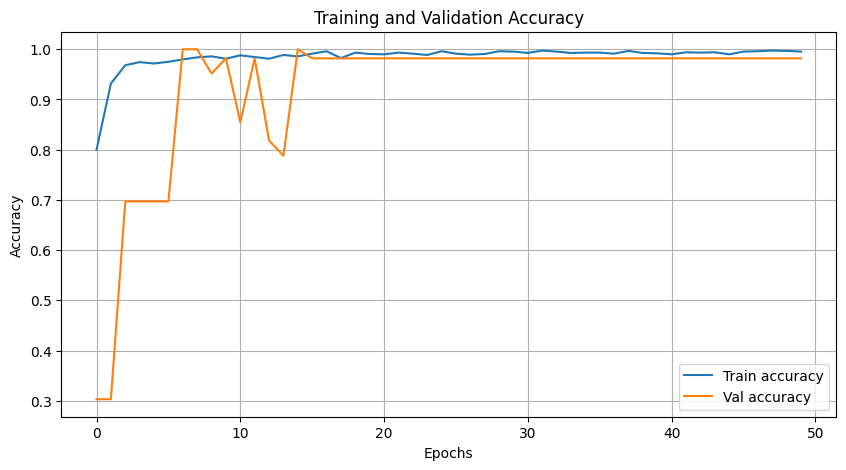

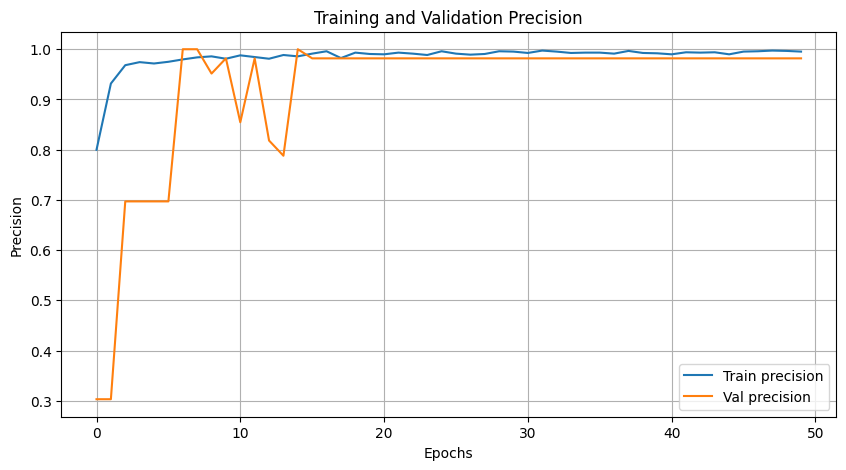

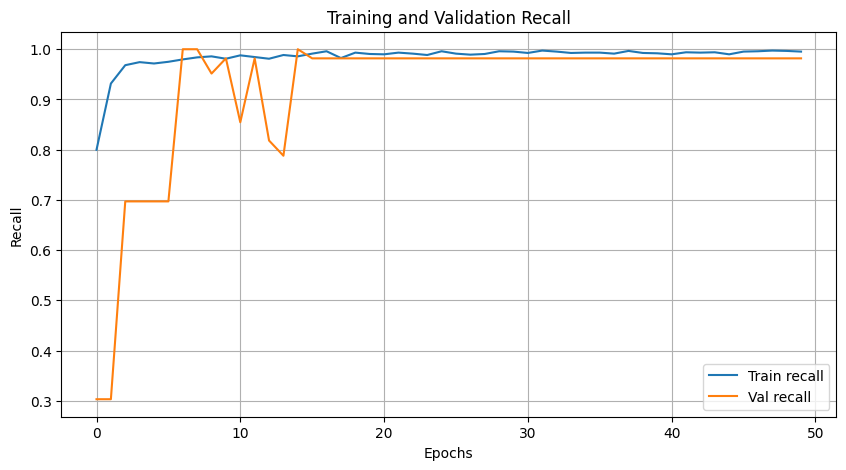

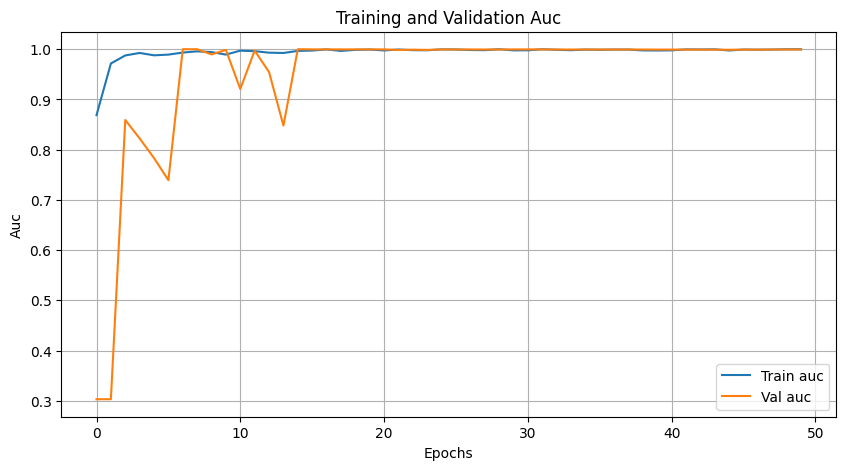

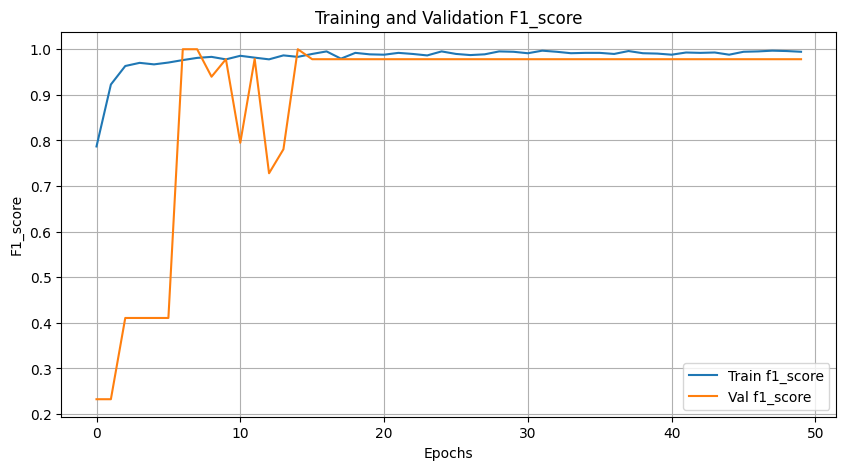

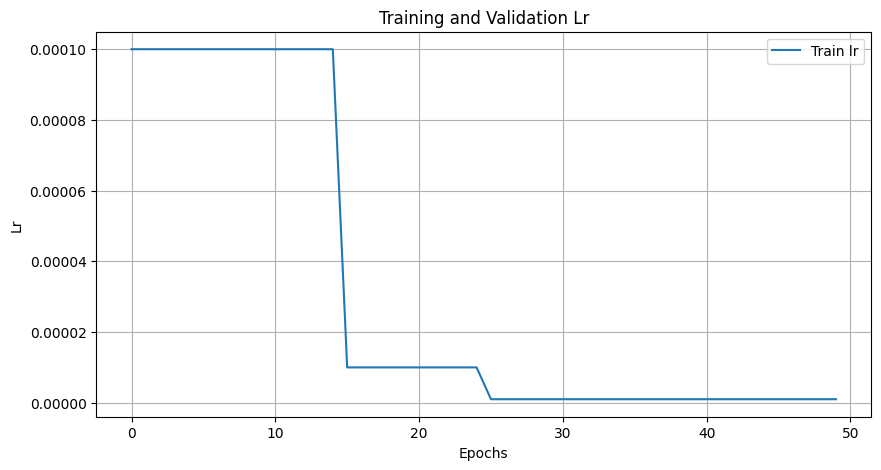

In [18]:
plot_training_history(history)

In [19]:
# Converter o histórico em DataFrame
history = pd.DataFrame(history.history)
# Salvar em CSV
history.to_csv('Recriar_Estudo_6_Aug_train_history.csv', index=False)

In [20]:
model.save('Recriar_Estudo_6_Aug.h5')

/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Avaliar

In [21]:
avaliar_modelo(model, test_ds)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7780, TN=7733, FP=47, FN=0
Accuracy       : 0.9970
Precision      : 0.9940
Recall         : 1.0000
F1-Score       : 0.9970
AUC            : 1.0000
Binary Loss    : 0.0091
FDR (Fire Detection Rate)      : 100.00 %
EWR (Error Warning Rate)       : 0.30 %
Confusion Matrix:
[[7733   47]
 [   0 7780]]


{'TP': 7780,
 'TN': 7733,
 'FP': 47,
 'FN': 0,
 'accuracy': 0.9969794344473007,
 'precision': 0.9939951450108598,
 'recall': 1.0,
 'f1_score': 0.9969885307874672,
 'auc': 1.0,
 'loss': 0.009118039171625906,
 'fdr': 100.0,
 'ewr': 0.30205655526992287,
 'confusion_matrix': array([[7733,   47],
        [   0, 7780]])}

In [22]:
model_best = load_model('Recriar_Estudo_6_Aug_best.h5')

In [23]:
avaliar_modelo(model_best, test_ds)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7780, TN=7764, FP=16, FN=0
Accuracy       : 0.9990
Precision      : 0.9979
Recall         : 1.0000
F1-Score       : 0.9990
AUC            : 1.0000
Binary Loss    : 0.0088
FDR (Fire Detection Rate)      : 100.00 %
EWR (Error Warning Rate)       : 0.10 %
Confusion Matrix:
[[7764   16]
 [   0 7780]]


{'TP': 7780,
 'TN': 7764,
 'FP': 16,
 'FN': 0,
 'accuracy': 0.9989717223650385,
 'precision': 0.9979476654694716,
 'recall': 1.0,
 'f1_score': 0.9989727786337956,
 'auc': 1.0,
 'loss': 0.008800944384568625,
 'fdr': 100.0,
 'ewr': 0.10282776349614395,
 'confusion_matrix': array([[7764,   16],
        [   0, 7780]])}

## Testar no FLAME train

In [24]:
data = pd.read_csv("../Datasets/FLAME_train.csv")
image_paths_flame_train = data['image_path'].values
labels_flame_train = data['label_bi'].values

test_ds_flame_train = tf.data.Dataset.from_tensor_slices((image_paths_flame_train, labels_flame_train))
test_ds_flame_train = test_ds_flame_train.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_train, name="FLAME train")

📊 FLAME TRAIN -> Total de imagens: 39375
  Classe 0 (Sem fogo): 14357 imagens (36.46%)
  Classe 1 (Fogo): 25018 imagens (63.54%)
----------------------------------------


In [25]:
avaliar_modelo(model, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=69, TN=12042, FP=2315, FN=24949
Accuracy       : 0.3076
Precision      : 0.0289
Recall         : 0.0028
F1-Score       : 0.0050
AUC            : 0.0674
Binary Loss    : 9.5247
FDR (Fire Detection Rate)      : 0.28 %
EWR (Error Warning Rate)       : 69.24 %
Confusion Matrix:
[[12042  2315]
 [24949    69]]


{'TP': 69,
 'TN': 12042,
 'FP': 2315,
 'FN': 24949,
 'accuracy': 0.3075809523809524,
 'precision': 0.028942953020134228,
 'recall': 0.0027580142297545765,
 'f1_score': 0.005036128749726297,
 'auc': 0.06740909587515322,
 'loss': 9.52467199092086,
 'fdr': 0.2758014229754577,
 'ewr': 69.24190476190476,
 'confusion_matrix': array([[12042,  2315],
        [24949,    69]])}

In [26]:
avaliar_modelo(model_best, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=98, TN=12605, FP=1752, FN=24920
Accuracy       : 0.3226
Precision      : 0.0530
Recall         : 0.0039
F1-Score       : 0.0073
AUC            : 0.0707
Binary Loss    : 9.0587
FDR (Fire Detection Rate)      : 0.39 %
EWR (Error Warning Rate)       : 67.74 %
Confusion Matrix:
[[12605  1752]
 [24920    98]]


{'TP': 98,
 'TN': 12605,
 'FP': 1752,
 'FN': 24920,
 'accuracy': 0.322615873015873,
 'precision': 0.05297297297297297,
 'recall': 0.00391717963066592,
 'f1_score': 0.0072949233288670525,
 'auc': 0.07074064018755699,
 'loss': 9.058696766814696,
 'fdr': 0.391717963066592,
 'ewr': 67.7384126984127,
 'confusion_matrix': array([[12605,  1752],
        [24920,    98]])}

## Testar no FLAME test

In [27]:
data = pd.read_csv("../Datasets/FLAME_test.csv")
image_paths_flame_test = data['image_path'].values
labels_flame_test = data['label_bi'].values

test_ds_flame_test = tf.data.Dataset.from_tensor_slices((image_paths_flame_test, labels_flame_test))
test_ds_flame_test = test_ds_flame_test.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_test, name="FLAME test")

📊 FLAME TEST -> Total de imagens: 8617
  Classe 0 (Sem fogo): 3480 imagens (40.39%)
  Classe 1 (Fogo): 5137 imagens (59.61%)
----------------------------------------


In [28]:
avaliar_modelo(model, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=0, TN=3469, FP=11, FN=5137
Accuracy       : 0.4026
Precision      : 0.0000
Recall         : 0.0000
F1-Score       : 0.0000
AUC            : 0.2682
Binary Loss    : 8.5397
FDR (Fire Detection Rate)      : 0.00 %
EWR (Error Warning Rate)       : 59.74 %
Confusion Matrix:
[[3469   11]
 [5137    0]]


{'TP': 0,
 'TN': 3469,
 'FP': 11,
 'FN': 5137,
 'accuracy': 0.4025763026575374,
 'precision': 0.0,
 'recall': 0.0,
 'f1_score': 0.0,
 'auc': 0.26816327455310696,
 'loss': 8.53973132783999,
 'fdr': 0.0,
 'ewr': 59.74236973424626,
 'confusion_matrix': array([[3469,   11],
        [5137,    0]])}

In [29]:
avaliar_modelo(model_best, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=0, TN=3468, FP=12, FN=5137
Accuracy       : 0.4025
Precision      : 0.0000
Recall         : 0.0000
F1-Score       : 0.0000
AUC            : 0.2697
Binary Loss    : 8.2179
FDR (Fire Detection Rate)      : 0.00 %
EWR (Error Warning Rate)       : 59.75 %
Confusion Matrix:
[[3468   12]
 [5137    0]]


{'TP': 0,
 'TN': 3468,
 'FP': 12,
 'FN': 5137,
 'accuracy': 0.402460252988279,
 'precision': 0.0,
 'recall': 0.0,
 'f1_score': 0.0,
 'auc': 0.2697095279010291,
 'loss': 8.217875585617001,
 'fdr': 0.0,
 'ewr': 59.7539747011721,
 'confusion_matrix': array([[3468,   12],
        [5137,    0]])}

## Testar no UAVS Raw Images

In [30]:
data = pd.read_csv("../Datasets/UAVS_RawImages.csv")
image_paths_uavs_raw = data['image_path'].values
labels_uavs_raw = data['label_bi'].values

test_ds_uavs_raw = tf.data.Dataset.from_tensor_slices((image_paths_uavs_raw, labels_uavs_raw))
test_ds_uavs_raw = test_ds_uavs_raw.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_raw, name="UAVS Raw Images")

📊 UAVS RAW IMAGES -> Total de imagens: 1643
  Classe 0 (Sem fogo): 498 imagens (30.31%)
  Classe 1 (Fogo): 1145 imagens (69.69%)
----------------------------------------


In [31]:
avaliar_modelo(model, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1145, TN=490, FP=8, FN=0
Accuracy       : 0.9951
Precision      : 0.9931
Recall         : 1.0000
F1-Score       : 0.9965
AUC            : 1.0000
Binary Loss    : 0.0160
FDR (Fire Detection Rate)      : 100.00 %
EWR (Error Warning Rate)       : 0.49 %
Confusion Matrix:
[[ 490    8]
 [   0 1145]]


{'TP': 1145,
 'TN': 490,
 'FP': 8,
 'FN': 0,
 'accuracy': 0.9951308581862447,
 'precision': 0.9930615784908933,
 'recall': 1.0,
 'f1_score': 0.9965187119234116,
 'auc': 1.0,
 'loss': 0.015987476631021777,
 'fdr': 100.0,
 'ewr': 0.48691418137553255,
 'confusion_matrix': array([[ 490,    8],
        [   0, 1145]])}

In [32]:
avaliar_modelo(model_best, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1145, TN=495, FP=3, FN=0
Accuracy       : 0.9982
Precision      : 0.9974
Recall         : 1.0000
F1-Score       : 0.9987
AUC            : 1.0000
Binary Loss    : 0.0108
FDR (Fire Detection Rate)      : 100.00 %
EWR (Error Warning Rate)       : 0.18 %
Confusion Matrix:
[[ 495    3]
 [   0 1145]]


{'TP': 1145,
 'TN': 495,
 'FP': 3,
 'FN': 0,
 'accuracy': 0.9981740718198417,
 'precision': 0.9973867595818815,
 'recall': 1.0,
 'f1_score': 0.9986916703009158,
 'auc': 1.0,
 'loss': 0.010786602181571493,
 'fdr': 100.0,
 'ewr': 0.18259281801582472,
 'confusion_matrix': array([[ 495,    3],
        [   0, 1145]])}

## Testar no UAVS Augmented Images

In [33]:
data = pd.read_csv("../Datasets/UAVS_AugmentedImages.csv")
image_paths_uavs_aug = data['image_path'].values
labels_uavs_aug = data['label_bi'].values

test_ds_uavs_aug = tf.data.Dataset.from_tensor_slices((image_paths_uavs_aug, labels_uavs_aug))
test_ds_uavs_aug = test_ds_uavs_aug.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_aug, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 15560
  Classe 0 (Sem fogo): 7780 imagens (50.00%)
  Classe 1 (Fogo): 7780 imagens (50.00%)
----------------------------------------


In [34]:
avaliar_modelo(model, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7780, TN=7733, FP=47, FN=0
Accuracy       : 0.9970
Precision      : 0.9940
Recall         : 1.0000
F1-Score       : 0.9970
AUC            : 1.0000
Binary Loss    : 0.0091
FDR (Fire Detection Rate)      : 100.00 %
EWR (Error Warning Rate)       : 0.30 %
Confusion Matrix:
[[7733   47]
 [   0 7780]]


{'TP': 7780,
 'TN': 7733,
 'FP': 47,
 'FN': 0,
 'accuracy': 0.9969794344473007,
 'precision': 0.9939951450108598,
 'recall': 1.0,
 'f1_score': 0.9969885307874672,
 'auc': 1.0,
 'loss': 0.009118039171625906,
 'fdr': 100.0,
 'ewr': 0.30205655526992287,
 'confusion_matrix': array([[7733,   47],
        [   0, 7780]])}

In [35]:
avaliar_modelo(model_best, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7780, TN=7764, FP=16, FN=0
Accuracy       : 0.9990
Precision      : 0.9979
Recall         : 1.0000
F1-Score       : 0.9990
AUC            : 1.0000
Binary Loss    : 0.0088
FDR (Fire Detection Rate)      : 100.00 %
EWR (Error Warning Rate)       : 0.10 %
Confusion Matrix:
[[7764   16]
 [   0 7780]]


{'TP': 7780,
 'TN': 7764,
 'FP': 16,
 'FN': 0,
 'accuracy': 0.9989717223650385,
 'precision': 0.9979476654694716,
 'recall': 1.0,
 'f1_score': 0.9989727786337956,
 'auc': 1.0,
 'loss': 0.008800944384568625,
 'fdr': 100.0,
 'ewr': 0.10282776349614395,
 'confusion_matrix': array([[7764,   16],
        [   0, 7780]])}

## Testar no FireMan

In [36]:
data = pd.read_csv("../Datasets/FireMan_test.csv")
image_paths_fireman = data['image_path'].values
labels_fireman = data['label_bi'].values

test_ds_fireman = tf.data.Dataset.from_tensor_slices((image_paths_fireman, labels_fireman))
test_ds_fireman = test_ds_fireman.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_fireman, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 589
  Classe 0 (Sem fogo): 33 imagens (5.60%)
  Classe 1 (Fogo): 556 imagens (94.40%)
----------------------------------------


In [37]:
avaliar_modelo(model, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=59, TN=33, FP=0, FN=497
Accuracy       : 0.1562
Precision      : 1.0000
Recall         : 0.1061
F1-Score       : 0.1919
AUC            : 1.0000
Binary Loss    : 7.5624
FDR (Fire Detection Rate)      : 10.61 %
EWR (Error Warning Rate)       : 84.38 %
Confusion Matrix:
[[ 33   0]
 [497  59]]


{'TP': 59,
 'TN': 33,
 'FP': 0,
 'FN': 497,
 'accuracy': 0.15619694397283532,
 'precision': 1.0,
 'recall': 0.10611510791366907,
 'f1_score': 0.19186991869918701,
 'auc': 1.0,
 'loss': 7.56235400556408,
 'fdr': 10.611510791366907,
 'ewr': 84.38030560271646,
 'confusion_matrix': array([[ 33,   0],
        [497,  59]])}

In [38]:
avaliar_modelo(model_best, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=50, TN=33, FP=0, FN=506
Accuracy       : 0.1409
Precision      : 1.0000
Recall         : 0.0899
F1-Score       : 0.1650
AUC            : 1.0000
Binary Loss    : 7.2610
FDR (Fire Detection Rate)      : 8.99 %
EWR (Error Warning Rate)       : 85.91 %
Confusion Matrix:
[[ 33   0]
 [506  50]]


{'TP': 50,
 'TN': 33,
 'FP': 0,
 'FN': 506,
 'accuracy': 0.14091680814940577,
 'precision': 1.0,
 'recall': 0.08992805755395683,
 'f1_score': 0.16501650165016502,
 'auc': 1.0,
 'loss': 7.260968296243912,
 'fdr': 8.992805755395683,
 'ewr': 85.90831918505943,
 'confusion_matrix': array([[ 33,   0],
        [506,  50]])}